### 基于原始代码读出的图片应用faster rcnn并得到输出结果进行进一步特征提取，提取区域特征，以及bbox大小和位置。

In [1]:
# Example
# python demo.py --net res101 --dataset vg --load_dir models --cuda
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os
import sys
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dset
# from scipy.misc import imread
from imageio import imread
from model.utils.config import cfg, cfg_from_file, cfg_from_list
from model.rpn.bbox_transform import clip_boxes
# from model.nms.nms_wrapper import nms
from model.roi_layers import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import vis_detections
from model.utils.blob import im_list_to_blob
from model.faster_rcnn.resnet import resnet
import pdb

import matplotlib.pyplot as plt

In [2]:
xrange = range  # Python 3
lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY


conf_thresh = 0.4
MIN_BOXES = 10
MAX_BOXES = 36

def _get_image_blob(im):
  """Converts an image into a network input.
  Arguments:
    im (ndarray): a color image in BGR order
  Returns:
    blob (ndarray): a data blob holding an image pyramid
    im_scale_factors (list): list of image scales (relative to im) used
      in the image pyramid
  """
  im_orig = im.astype(np.float32, copy=True)
  im_orig -= cfg.PIXEL_MEANS

  im_shape = im_orig.shape
  im_size_min = np.min(im_shape[0:2])
  im_size_max = np.max(im_shape[0:2])

  processed_ims = []
  im_scale_factors = []

  for target_size in cfg.TEST.SCALES:
      im_scale = float(target_size) / float(im_size_min)
      # Prevent the biggest axis from being more than MAX_SIZE
      if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
        im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
      im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
              interpolation=cv2.INTER_LINEAR)
      im_scale_factors.append(im_scale)
      processed_ims.append(im)

  # Create a blob to hold the input images
  blob = im_list_to_blob(processed_ims)

  return blob, np.array(im_scale_factors)

In [3]:
class Args():
    def __init__(self,dataset='vg',cfg='obj_detector/faster_r_cnn/cfgs/res101.yml',net='res101',load_dir='obj_detector/faster_r_cnn/data/faster_rcnn/',\
                 image_dir='obj_detector/faster_r_cnn/images',image_file='img0.jpg',classes_dir='obj_detector/faster_r_cnn/data/genome/1600-400-20',\
                    cuda=True,mGPUs=False,set=None,cag=False,parallel_type=0,vis=False):
        self.dataset=dataset
        self.cfg_file=cfg
        self.net=net
        self.load_dir=load_dir
        self.image_dir=image_dir
        self.image_file=image_file
        self.classes_dir=classes_dir
        self.cuda=cuda
        self.mGPUs=mGPUs
        self.set_cfgs=set
        self.class_agnostic=cag
        self.parallel_type=parallel_type
        self.vis=vis
args = Args(net='res101',dataset='vg')
# set cfg according to the dataset used to train the pre-trained model
if args.dataset == "pascal_voc":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "pascal_voc_0712":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "coco":
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "imagenet":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "vg":
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

cfg.USE_GPU_NMS = args.cuda

# print('Using config:')
# pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)
        

In [4]:
# Load faster rcnn model
if not os.path.exists(args.load_dir):
    raise Exception('There is no input directory for loading network from ' + args.load_dir)
load_name = os.path.join(args.load_dir, 'faster_rcnn_{}_{}.pth'.format(args.net, args.dataset))

# Load classes
classes = ['__background__']
with open(os.path.join(args.classes_dir, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())
        
fasterRCNN = resnet(classes, 101, pretrained=False, class_agnostic=args.class_agnostic)
fasterRCNN.create_architecture()

In [5]:
print(len(classes))

1601


In [6]:
# 检查是否有 CUDA 支持
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")
fasterRCNN.to(device)

print("load checkpoint %s" % (load_name))
# 加载检查点，确保 map_location 与您的设备设置一致
checkpoint = torch.load(load_name, map_location=device)
fasterRCNN.load_state_dict(checkpoint['model'])

# 如果你想检查模型是否完全在GPU上
all_on_gpu = all(param.device.type == 'cuda' for param in fasterRCNN.parameters())
if all_on_gpu:
    print("Model is on GPU.")
else:
    print("Model is not fully on GPU.")

Using GPU: NVIDIA GeForce RTX 4070 Ti
load checkpoint obj_detector/faster_r_cnn/data/faster_rcnn/faster_rcnn_res101_vg.pth
Model is on GPU.


In [7]:
# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)
# make variable
with torch.no_grad():
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)

fasterRCNN.eval()

max_per_image = 100
thresh = 0.05
vis = True

In [8]:
from src.datasets.data_utils.image_ops import img_from_base64
def get_image(bytestring): 
    # output numpy array (T, C, H, W), channel is RGB, T = 1
    cv2_im = img_from_base64(bytestring)
    cv2_im = cv2_im[:,:,::-1] # COLOR_BGR2RGB
    # cv2_im = cv2.cvtColor(cv2_im, cv2.COLOR_BGR2RGB)
    output = np.transpose(cv2_im[np.newaxis, ...], (0, 3, 1, 2))
    return output
img_base64_url='/9j/4AAQSkZJRgABAQAASABIAAD/4R1kRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAMAAAABIAAAAAQAAAEgAAAABAAeQAAAHAAAABDAyMjGRAQAHAAAABAECAwCgAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAAnygAwAEAAAAAQAABJakBgADAAAAAQAAAAAAAAAAAAYBAwADAAAAAQAGAAABGgAFAAAAAQAAAQ4BGwAFAAAAAQAAARYBKAADAAAAAQACAAACAQAEAAAAAQAAAR4CAgAEAAAAAQAAHDwAAAAAAAAASAAAAAEAAABIAAAAAf/Y/9sAhAABAQEBAQECAQECAwICAgMEAwMDAwQFBAQEBAQFBgUFBQUFBQYGBgYGBgYGBwcHBwcHCAgICAgJCQkJCQkJCQkJAQEBAQICAgQCAgQJBgUGCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQn/3QAEAAb/wAARCACgAFcDASIAAhEBAxEB/8QBogAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoLEAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+foBAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKCxEAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+iH9iq5z+zzolkX3wWjT29sw+6beOQiDBPYRbR+FfSmp2d3qLFYFGyPjHTJrxn9ljw7qHhT4C+F9B1q0FjdQafAtxABwkwQBwPbIr6Mjx0Aosk7o5Jz0scTp2ltHe7Z0wYxn8+ldMG2ir7RLneBg968u+LPxX+HnwX8HXXjz4l6rBpGl2a7pJpmCj6AdSfQCio7oyjdK0TvmKvwv4/wCFZGra3o2g2hvdYuorSBP4pGCj9cV/Lx+1l/wXq1zUbu48G/spWKaXZplG1q/QPcOOmYYT8keexYM3oBX46eKP2j/jZ8c9STUPiD4g1bXVZ8OZ7lxDnrhUyEH0GAB2prCy6nTCDtqf3J+I/wBpv4M6Du+0+JdL3FsCM3sK4HqTkgAVW0T47eCvEm+78J6/o+s7Bue30+7SYhR1xg53Aewr+HnxXBqdvpB1i/vbOwsPuxR2+bi4kPs3CsfUr8or548K+IPibpnis654F1CfTr6x/fJL55jdMcjOzAXp0ohhrrc39m1ZI/0MBqsN2RLG3E48xP8AcbkH8q2bK1kuSsUAyPWv5Hv2e/8Agr38Z7G0sfD/AIvtl1e50+JYJZfNZXdV6kIBtP0x/wDW/oB/ZO/bR+HHxzsls9O1COz1VwG+ySfLIPZedrAHjp7ECipRa3MlHU/RO3to7aIRw9q/xaK/2kLO6llJgnQCRAM7ehHYj29u1f4t9ZwVjU//0P6xRIpUbelWoZNnB6Vyn22ADEfzHHQV4vc/FTS/APgs3fi27jE1mjbo1bzGVV/vFcgYUZOTXFPFU4fG7HJ7C+qOx+Pnx/8Ah/8As8fDfUviT8QLyO0stNgaZ97Y4HAHrycKoHLHhRX8Iv7dv7fXxT/bJ+Isms61dSWegQOU03TM7Ujjz8rugJXzG6nrt6Z4r0L/AIKbf8FAfEH7V/xRm8K6DckeDtCmIs4FJAup14a5lx1x92JeiL05Jr8lbq4812uLgnYBg46sT2FfQ4LDRcedlQi4s2XvlspRdaixKAkBfX6DsB3J5r2TwYuteLbqAXERcupNtbg+WioBkySdAqjqSew9K8z8GeGbXXL7+0vEsotdMtMPKcZJAHyoq92PRF7nnpX1d4G0a58RM97cWDWOgxMkSWeCZbjdykcmMO7OQGMYIB6vtQAVyZpilS92J7WCwftNWeu+DNN1vWNCaZI7WOJ0MUV7cJuUhOP9HibquT97gE469vG9e+GWpfDm31HXb6OZ1uIpFgiX5pHkkAG+Q9OF5OBgHAFfWHgvTNd8ZawNP0dVvL9zgugDWtgmcbQFwC6joi9Tg/d5PvXiP4R23gjwrN408ZIbiDymhEkjffdWTd9MDrjj0r5pZyoy5GfRyyGVSPPtZH5TfAzQns/ttxq+FuJo45YDjuWKr9CCPyYele8XXxH1Hwl4gtPGvhNmtpAFMoi+XZKjYLAKc7SOD7CqfxG1Xw1oLX2n6Gnln7NCbbcNuIw/H/j3P+RXy7/wnQe+lsbefyBdKGjfP+qkb5SfoDsbHTjFfSxre1jdHy9fDezlY/t8/wCCeP7XUH7S/wALE/tiQtrGkKIZiDukKKAPm7ll45/iUg+tf5Qtf2Lf8Eyf2mF+D3x8uLS/1FNO07WbWZLknPlRXMKlgRt5Cn5lH1X2r+OmsZxsc0lY/9H+g6/+0zW8l14o1CS6CqzeSn7qAYHA2L1/4Fmv5+P+CsP7aEvwz/Zx0L4WaBOE8Q+L4Qz+VhTDaLyzhVxy5IUfT/Zr9FP2hf2jfCfwX8NTeIPHuoi0trbTJXx1Mkx/d7UXqWYkhcdq/i8/aY+NusfH74qT/EXWQ9tEkMdnZJN9+O3hGFWJOijvk9K8PLcBTU/djp3OiEm99jx5JpLa3LXjbGI3Pnoqnp9WNM8M2+s+NfEMGlaNbvcSyEJbW0fO0Hjc54VfxIAFR+FvCmt/E7WIfB/haNmLyYO3O0L3d29B0Hqa/cn4D/8ABN3XPB3h6DxNp11YXOqMgdI5m4HfGz1+oNe1j+IqOGjyN6nq5fkFXE+/Fe6fFWi+FtF+GkSaBp4/4SLxG+0SXFspays2fjy7c9JZs8eYB/ucc19n/Dn9nHxj4pSzt/HRl0q0AbZYWjAX1zu6ozLxbxn/AJabfnb+J+gH0H4T0K68H+OVk+KGgJpurnFvZ6gy77WIHglQowvHp9MgV+lvw5+EWl+G7H+04Ha9u7ldzXUmNzA8gLjhUHYDivzTOeIam/U/SMlyCilZ7LoeF/D34RaZ4A8LGx02ygtLmVBbQRwriOCPPIX1Zv4nPJr5c/bW1iLxBq3gn9m7w9c+Y93ItzfrGMeVZxvksc/89mDEdtoWv0g+I17YeC/Dc2uagceWu1MdSxwAo9yeB71+V/7PmgXnxM+Jvi34/eI/9JN+7Wlgx7QQkqxQdAmVxHj+ECvDyzEyvLE1Ps7evQ9rMKCajh4dfy/rQ/Lv9tyc+Hfix/Z0MgA+zyyEAYwPOYKPw24FfDMOoyjUbZGIBO5T9Nv9Divr7/goWr2Pxvvd+d0WnQZHu5kY/wAxXwbaXIm1aFXfGyPcT9OT/Sv1/IKnNhYPyPyjPKFsTNI918OeIbo639vs38pkH3hwclcGvxMr9b/DrzBC6tt385r8kK7qstbHztaNrH//0vw7/a8+PXxN/aM8TXvxN1qMw6VpLC2hheRnitd33Uzwslw3UhRhQOwr8zNZ8RHUrl1lf92PvKp+Zsf3j6e3SvtP9qzxZY+HPDGjfCDw0oisdMi82Qr1lmk5MjnucY596/O/SLS61CYWdmC815IIY1HdpGCKPxrzsDUbhzbI96pTjFJI/sP/AOCaP/BPzR5/grpnj7xDD5E2sWsU5I4cl1DdSOAO1eh/tBfsb694L8NeLNT8IJLqus3tqo0qdp5Fa0mVxuZVDKOY8hcdGA7V+w/7PPhmHwn8JdA8L26bPsNhBBj/AHI1U/yr0rWfB2n66PL1CIMCK/LqmbSjXlVST9T9dWWQeHVG9lptofgR+xBqXxfl0dfhX+0c/wDbF5tklgM8ZaWOJGCKJWI27yDkAEnHWv2K0nQLbw7oCxFNiIo2A+lex+GPgz4OsrrzNNswJOpJ71V+NulR2GjpDp5G/AXaO3+FeVmTU71UreSO7B+4lSvex+aP7WUGv+I/h/c2Xg+xe7vVRhBt6I5GA2O5XqPcV+fPg74rD4H6RF4S1vw3fWNhaWqQJ8hOTGMZb65zX6C/F/UPip4Z1GHTtB/0HTGtpHm1EL5somCkxxiPbhUYgAv82P7uBX4y+Av2vP2rbS91vVvjDZWN7oenOiOsqeXNIZWwY4TgeY0a8ttXHH4V6GV4OrOg9E4+upxZljIRrxjdp+mh8M/t++LNB8dfFT/hINFjdI7yzEZ3DBzG2R+QbpX52W1yiX1xIwwEQR/mQP1r9kv29vAHgjxD8Mofi34GiFo8LRTFB0IcgEH061+Jt/J5O+EP89xL8vb7i5P/ANav0rhvFxnh0oaW0PzviXDTpYl8/U9U0i/W18PQ6g3RhjA/3iOK/LKv0lvnNt4WtbBSG+RNw9CMn+tfm1Xswlds+TxfQ//T/lg+Mk0+r3l7qF026VpBF0/ujJ/DnFcv+zppltdftB+A9MvFzbyeI9Kjk9w1ymRXV+PCEsZI15kMzMcD+9/9YCvD9D8WT/D/AMWaR48hGTour293j1+zyJJj8lrxcHW9zlPtMVh+Wab6H+m14CuAlkkSY2qOBXdahe3axFrVMseFB9TwK+fvhL4/0TX/AAVp/jXTZVlsr63juomTkNHKgdSMexFeuWni3wv8RPDU/wDwjGoRTbg0e6BwWR14IIHKkHscYr8exMPfaR+uxre6kj3bwDpU80JN9PGjj5XI9fQD0rxf4vWFtpd8FabzVnYKv1z0xXyn4j8V/EH4WaXef2dLPqU8bbiC2Tg9ucflWx8PviD4k+LGgLBrdrIskcyymV1IC+XzhcgZ/CuHGYiT9y2h6GCwMP4ql8j03VfBdn4h0sQXMYYdOlfOfin9lfwnr7FtTt45o/R1Xp+VfaFreQ2VrsbsK8o8VeMbS1RsOABWaxNtjaOAvufgX/wU4+EPh3wL8DtT0Xw5brAssfCp0+XB/pX8pHiCGL7bar/ekYbuOA6YzX72f8Fsf2xdM86L4PeF7pftVwu6faclY84xx/ePH0Br8FL2ZNcjMBAWRtksXbnAHH5V+qcH0qkMPzz6n5VxhKlPE+zg/hR2UsF5rbW9hZrmUfKNvUjb/wDYGvzgr9l/2X/Del6p4mk1/wAUvHBp1jE253+UGR/kUK3rzX40V9fh6qbcex8DmVNR5bH/1P5a/GjQTS4Uf66SWQY4PG0dPpXzX4utxDYyqw/ds7tk9fumvXru+OvX2jago+VrdlK+jsef/Qa8q+JYMHh2CSIYEyykf99Bf618ngnyy5Wfo2NheF0f14/8EF/2obb42fszN8F9cuvN174fMlrtb70umykm0ceyYaI+m1fWvvD9p74Ianpev/8AC0/hbc3GkXkozcm1JA8xejsikblYDDdx1FfxGf8ABOf9rfxB+xj+1JoPxQ0+OW70q6xpur2cXLXFjMy7to/vxsFkT3XHQ1/oq+EvHvw9+KnhG08Q+HrhLq0v4VlikHXawyMg9CO47dK+M4lwn1avzR2kfdcDZ3KFppXcdLeR+RVh+2l8TfBkttZ/FvQRrWlLiOW8s3TzwBxuPIY/Qqa/Rj4Q/tJfBrx5pwHgC5Dgplo2UpJGfRlOMH9K5nxn8MPAX2+TUL7TbaRlOd5jU15nqOv+FfCdmZolgtYoh22qB+WAK+PqVItWPvs0xeFq2nQp8rPpfxV46CITbPxX5i/tr/tYeG/2f/hbqPjXxNeCLapSGFSPMmlYfJGg7k/oOTwK+W/2pv8Agqz8Ffgt9o0PSLgeIvEEaHZp9gd2z0M0v3Ix+be1fy+ftK/tNfFH9p3xsfFnxJuBtiLC1sYifItYz2Qd2OOWPJ+nFe9kfDlSvJTqK0P62Ph894mhhqfJTd5fkeN/Erx54k+MnxH1H4jeLpN93qMvmbSflhj/AIUXPZRwPzrt9Fju7hbIgYP+r+np+hrifDnh9r6USgdOn4V9i/Bf4bnxBe2omGY0kByB/FzwPwGK/VsRiIUocq0sfl2Fw05yc5dT9Fv2MPgUJ9Jl8TeJ1RhbxqtpbSIGiBlJyWQ/efaPwr+Xyv7Lv2f7+3stKbR0iCDasq84wehGSM+tfxo15PC2IqVKtbn20t+J53ENJR5Lef6H/9X+SzQRLfait6yFYrZmZR2C4wo/livM/iw2bCy01W+7Gq/99Hef6VzNp8UNfICQhVjzkIo/L8zXRR+HtY+JN9beHPDcLSXEknfqqEAEn2HSvmpUeWpzvY/QJVYyhyRG/s+fDiX4j/EjTNNaORoTNHyuAv31zuz22A8Dnp2zX9qn7PWpav4U0CK00yZ4k2LhR93p6dK/Cn9ij9nj/hBtVkv9bQ7YEDo54XzCCh2rjqAuNw47cYNfvb8PbRrHSbUsMFkU/pXw3FuLVWaitkfY8J4T2NNzfU9J8aeKPFd5p0hN0wO08AYr+ez/AIKD/tMeKfBkLeB9HvZHv7vK7nf5UX1VOnHr2r9y/ir4vtfC3hy51G+/1UMLO2OpCj7o+vAr+VT4oW2ufF/4wX3jHWysjB2wBjasaH5UH0PFefw9lkak/aT2R6GeZlOEOWG7PjGXSL/TNI/tG/cy3t+xkd3+/jIGfxrG0bQZbuU6hNaGWNCOB0+hr6ofw/NqGsea3yIHjRnI4CDjjBH3jive5dCgbQDazRKtvGhaNAFJcLjHYnbnoM1+i1MeoxtFHwEcHzu7Pm7wKthcTvbXka7UjZkjCjCkHnHcdO1fXXwm1K1sdPea3tjHC8isW7KFAA5Ix1JFfMreJPDfh7WFNzJFbhgVLbcAN1Ocdf0p6/FW28c3f9l2dwr2uNiJGy+YcdyN3fHA9K86vGVRe6j0OenHRux+vng/xDaOr6noExii4JlXqdwwBxgAY7V/IzX72/Bj49W/hjQb3RvFkosdLglXEzBXctyFVAdgwO/IxnivwSr1eHcLKnzuS7fqfJ8SVoycVHp/wD//1v5R/g18MfC2u/tCXXgyxtpTYeHrVhMZV+/cbgCfYc/L9M1+1f7Pv7N3hK01IzaXZokkyMC+BnpwK+BP2IfCWlax448S+KbPU4dS/tq580SKjRsi5yEKvgg89uOOCe39Cv7P/gmNJFRUxhGOT6HivzvOpyU+Tskfr2S0ITpqdjC+FX7PWlSajqthbZDW1wknp96GNyMdvnJIHoa+xbXwFd2Ngu9NoQYB9hXL/DtW0T4lX1jPhvtwVgRxh4MRsp9xH5fT0NfckmkWl5Yw+aBtGNwHHFeFi6UZ6M+iwdXlp6H4oftv6q/hj4dXpd9peL5Rj5jjpj6vt4Ffg4ZLfQtHlvHQdo0IHU4G4f8AfZ5+lfsx/wAFVfFF1c+IG8L+HLVlt7EQ/aLg/wCqQrmRYyf7zvt4HRVNfhX441Pw/aJp+m6teSR2cEe6RosY3/MT1HAGeK9TB0VSpqMDxswm5z5n0JdA0iTxdK1tbGOJFkV2baWDeX246E5PXgCmfF/xj4c+HYsLKadN0pVfl+YxJux93hePvY6d/SvPz8bdB0/Sv7O+H9uY/n2o0uHY/wC1x157YwfWvMdf8LTeIPBur/ErxHcN/orJFB5pGXkd8LHGF4yQCx9FX6V7uGwznKzR4eKxEadP3dzZ8efBFvDZXxXrl6b7S7uMz289pliFJw28sCTt/iC4/wC+cVzngP4VW2t3q3TRA29tiSG9t5MO2DwVYc59iBjpitHwn428e654N07wMSn2ESlwW7KRtcAc9UVRx/dFe+2vhbWdH0WK28FhIlhUbVHcemD+tfXUKMUtD4mvUbbuYWjab4N1DXvsGuedJqECERvdyEhl7sBwu7sTjNfkDX6s+I7iz8VxjTvExfQ9Wt2/d3AUlSv8QIX17EV+U1bT2SPOqM//1/5V/wBhP45Wfgv4jWNvfRxx6fqc/wBlmxwFmYYifnpk4U9u9f2R/s+GxvrBL/aC/lqje2ABX+f54Cv4tFv2sbqTZ5wBDD+FlOVYfQ4r+0r9j74yWGveD9K1OG4ST+07aPLKfl84KA6n0IYYxXx/E+G5ZxqLZ6H6dwhjb03TfQ/R3UvCSzeKrO/tn8oTTIm/B+ViGIYH7owQAfVSR0r36fw18QrqI6cXg09D8puB87FPVFzgE+/SvC9E8RW+q239mXRCt2PXa2DggeoOMV1utfGfxi8Nt8OUsYxreoIsaXAkBXbhg0pjU70UYB68g4A4JHzrpvlXKj3ZVoxmfkv/AMFFPg38V/iB4am8GfA7TE1a00y4F1dTCVRLJOT1bIG4gADG7j+6OK/mt8WfAzxXYX9xY/F6x1OxnT5Rb+SdoA6ndjBHvX95KaZ4c+H+kLYatqdtJezkNO7uiZOMYCk/KoHCj0r83/8Ago78Rvht8MP2aPFXi3UBZS6le6fJYafG3llppLnEI2D+JY9+846YrtwUZtqEUcWOdNR5pbH8gmjeBf7X1BtM8KW0rYU7gvZRwCSM49hXefGzUtPt/DGheFtJkVtO0xY2mVR8hnnQM7t67MrHntsr7m/Yt/Zu1nRfg9F8UvEaOG8Xyqunxv1WzgYosmP+mjbiP9gD1r4y/aM8A6p8N/iJ4g8FXMAeK11GZPLIzmK6CTwEf7PzEivp8un+/lSfQ+WzGPNRhWWlzC+EvhfUr/ztVcrBBAgghXcMBQSXYdjuOMY7CvqzRtlvGFVvu+3bH5V8rWemXNlpMOl2Enl+XEsTY6cAf1p2laHr+n3ImtNRlhYHA2kt7YAPFfT8p8sm7n1d4i8L+H/E1jt123WRYzw4PlsPoR2r8Cq/VDxVrvj3xNef8Ird3IMdkQzXGdhYFRtVtuOR+FflfWEpLYyrrY//0P4o7ewjjmiGtw2UqZAkkTcpKZ5IUfKD9MCvsX4dfGD4m/Cm0a8+G+vy2cEY837M6iSNtqjGFPB4AAOM18ZwnSHXyfsKhsEAqzKMj1AOPyr1Sy+x6zoTW8LlbgRsghB+UkLgICP5UT5ZLlmro9hOVLWGh+iOr/8ABUH9rG505LbRr57B1Vd0lraW5kxjn5sOeMf3RXzV40/bJ/aG8Y60/iPxD4m1W8uDCISXnkjk8tOdmI9mVBJOB09K+NvDMmv6fcrBNM20wrNGwPOD/hXop8aSrN/xOoY77jau5nhkAHH3oyAePUVlTo0I6RgkVVxNVv3pHqfhv4yeJNQvW1Al7l5EkAMkZmPzIV5LgngmuiaPxD4uFxZ3aNdWErL+5mkKRKo2n5VB2r8wHReMD0ryBPiDotqFWDRcbenmXMjL9MDGaral411/xPbi0aUQWw6QRDYo9uOo9q3nWhFWJhGUnc/TL4fftmeLPDWhaN4Bnk07W9N8OW6WlojHynSOMbUjWVVG7AGAWjJx1NeYftS/GPwZ8dfHCeOdM09dJuTp0dvdh5hJ50lq37p4iqgbwrFOeCnuK+Cbe3WP5gTkDtVi4Mkq7Cxwn3R6VwQhSU+dRszolUqcnI5aH0NGizEyjnJzn9a6m1soEtvMHDD73/1q4Tw1etc6ZbTyLyY1yvbjg/yr6C+EPw31340fEXQfg34YXN94ov4bFCeiK7fOx9AiBmPsK9X6xGMeZ9Djp0uaSij79/4Jr/8ABNP4g/toX+o+L5S+m6EucXL/ALpOBtQFwGYk4GFUdOTxX8kNf7H37L/wV8E/s/8Awd0b4UeALdbfTNHt0iXAAaVwAHlfHVnPJ9OnQV/jg18nkOaSxM6ja0Vrfie7xTlNPCU6MY7u9/wP/9kAAP/tADhQaG90b3Nob3AgMy4wADhCSU0EBAAAAAAAADhCSU0EJQAAAAAAENQdjNmPALIE6YAJmOz4Qn7/wAARCASWAnwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9sAQwACAgICAgIDAgIDBQMDAwUGBQUFBQYIBgYGBgYICggICAgICAoKCgoKCgoKDAwMDAwMDg4ODg4PDw8PDw8PDw8P/9sAQwECAgIEBAQHBAQHEAsJCxAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQ/90ABAAo/9oADAMBAAIRAxEAPwDA+C2sX3hq4vvDWqOkc1tPLZPGvUyRt1+hxX6cQ3323wgZojhrfai568YI/TNfl38W9N0rwF8YYryKUxxar5N5OE6JMzfOQfda/SjwfqNlqmg2M1o4aK+SMjPA3j2+lTImR6/YSia1hmX+OMBvqKuVh6K3lwvbn5trEVuVJIUYFFFBcQooooGFKOtA60/gc0AIcAZPasK5n89yjHGOlaV1IFhYn2/nWJEnmMXfj0q4mU9xhPGGGD2pMmpHQlvm49KTYfrWkTKQzJoyafsb0o2N6UyRo606jaR1FFADWztOKVOGXPcVYt08x8egzVdmDM0YGCKAL9pEAzMwzn1rT7VBAmyNQamqJG0Nhy07Apq06s2ygooopAFFFFABS9qSigBhJpKVutJQAUUUUAPXpTHJX5u1IX2j5uF9ag3vKfk5WgBrXDOfLtv9YepPQClFsgwASW7knPNSKipkL361IOlAC4KfLnp6UdetFFABRRRQAw9aeOlMPWnjpQAVCQwZpM8KKmrKu7gLbXICuhCvzjjoOlAFyJhKpf8Av9PbFS88Z61DGQIlVflKgNn61TN+0zGOGNnZuhxgDFAGmWCjJqq17EhqsJC/DPk9wKnWO1/55l6AE/tC1PWcflTTeWTf8tP/AB2p/ITsoX6il+zxf5FA7lANbw/6qTNC3KSdWArRaxth/AD9Ky59Ot2bvHQFyykjE5UHYe9WHlji/wBWCzH1rmZby7tPlQ5Sr1lexTAtG+40Fmn5juOetRl3TjpUobeBjipXEar83WgCL7y5rBm+831roIWQxvjk1gXe4S9MU0ZkGTRk0lFWAuTRnHWkooYBuFRlsnFMfpSqm/5fWs7gI6bRv7CkiBZvN7GoHdpD9m/iBG76VbTCZj/hHSgCSiiigAooooAKQjNLTl60DRAFO7rWhDGD1GaiRN5xWrFDtWg0Q3G0DHFOUnnmnsh9abt20Fig4PNThhiq9GTQB//Q0f2kPDdve6RH4nun23enXaQZX+KFx8o/DNe/fsy+I5Nd8IaVBcJzp1zw46lCpXmvLfibpov/AIW61HdHaI5jKFHzPuh+YZP4Vu/so3bppFyHiIg8qGZDu7k4egyR95aOjRxzSv8AMzSyD/gORitz73NZOiFntZnf7ryvs+nFa2zHNTI0iFFFFSMUdafTB1p9ABSHoacvWs66ufLyucZprcHsZ9xN5oRP7hNMHQ00LyX3ZzS10HFPcMmlyaSikQLk0ZNJRQA1lLjFPhTf8lKp5x608SeQR70AXvK8iE+pFULRA0uTU811ujxUllH+73+tTI2hsX4+49KmwKiQ8kVLUmqI36Co6lk6CoqCWxy06mrTqhlIKKKKQwooooAKNueaKKADG2kLKy570E4Gaqs25s0ARyq74B6VYGAFC0sa5pyjGRQA5utNoooAKKKKAGHrSUp60lADCrZ4pPnqwOlFAEUe9Tmq17IkcZbuetXHdIVLH+Ksi4V5gc9F4H0oAdAzTRiS4bMBAAHoasCa3g/dcbj0qnbBFPDb3PGw9h61cktFjXdKEKn+KgBvkxud/lgY7rS/ZyPb/dqq06W/7yKaPZFy6+opn9tWS/PHP+7/AOBUAWfIuV+cyb/96pQSP+Pj5KyovFPh2R5bdb+IvFyVYOuf9zf1rkfEXj7QrOYWccr3t12gt/nZf99+3/AKAO9uNQhtF/1yyf7tc9JrDXnKfc9f4/yrzmLUNeuOLDTH8r/pp8ldJZ2uoTg/a2KD+KNPlNAHRxX+mw8THP8AvVJJp2l6gDNZuI5R9wpJgE9+K5+DTtKA5iJ/3qc+g2d2CbbMbDptbaM9uKDQ1bHUrjTZ/sGoNuiJ4z0/A1142SYPZhkfSvJ5xqVtaNHfqbiKM4z/AMtF/wB32rc8MeIvtymzvpGWW3OAT97aegNAHbwrE8jIDgisG+wJWTzMkVLHKLi8LuNsZRiAvfaOtV7qCLaZI16imjMiHQU6sG0uphcNYyfMOob+lbCrgg5qwJqNwX5j2ooxnigCIqWO9u3SkeQxKXHb+vFOl2vGSxwF71WRPtrhiNsSdPehgSRRGPbN/E2amQA/MetLNtwyr0WmRfOpkrMCWiiigAoopD2oAeoycU8R5IHrRGMnFacKcj2oGhYbUxLlu9WVPalkm42elMAwuaCx56VGOppaKACimtTaAP/R9x8XaPDL4G8VSrljp1hK4jC7i7k42g+orh/gHBfado+lzlhC4szNMq+rvtG/3xWpBq0P/CKXOh3BEt4LSV7hjJvDSjCbz7k42fjXSeDbX9zok+fKk1OxkZ8fcxG5AxVSOf2vLofaehkx6ZaEAymVS3FbqN0AJB7q3UVg+GZ9uh2Ehi3BoFJdfoWzj8K2DdWNwCXk2n1b5CKk1gaLfdqOs77ZFCpxKblQPu9f/Hu31qzbzy3I3RJtTuSMHHpt/wDZqCyyOtPo2t3pD0qZEyEdtqFvSueu/wB49bV0cRk+1ZdvFvYvTiS9iSG0LICOtS/ZHHNaMI2jFTEZGKfPY5zAlt3AzTBC5HNbYT5qc0W4Yo5rhyXMDbtOKevWtE2O580NbbRVoiUbGcwJHFMZYwPmqxLCwBxVG5UDbjrTESCIFgR0zW+g8pAfXisuwgdly3StVuoSg2hsLIcqDUNPc4Oz0plTIoKKKKkBy06mrTqhkMKKKKQgooooAM9qTbg5oK7qgZ942elBvHYjk3ucr0qVRjinBOB7UuMcUDFPakoooAKKKKAEc7VzUSHPz+tSMNwx6VGhIbJ6GgCbbu5p6jBxTCwXgdKha4wxXHSgCw/U00dKxrvWkhkMKEySFeAq7gPqe1YgGr3QBmk8lDyPLPA+tAG1qd7ZwssN1JHCg+b5juYn2Fc9J4knuLgf2VHuRvkV24G5eGOK0ovDGnK0d7cxpcPJkl5OjEf4Vow3Ok2lsJYjFtIcM4ZcE56jNAGIV1K5JzJJv/6YrtX8TQNOvV/1juP95t36VfuPEGk28gPn+avqv3R9ap3PiDR7gGabUUhiXrzQBDcwfZkZzPHISMYVeea4DV9aihiaytv3ksbZ8v8Avj+H9a6PV/FXhpE8y3aPyowH3J9+5c/KFX3rntBFtqMkupXn2ZJriQMkbN/qsfwr70Ac7F4WvtelS/8AEFy4afiKIfcr1WDwj4X0yJIrGyhMn8JU/P8A9900QJaTRz3EazBF2r5Z3bc1oWN/Ztdt5cyrL/dn+9/wCgB9roVzayyzW1y8Am/5YFt6U+6s7qP7/wA3/XP79beW9fnqKS7t7ZJRcbGP9wffoAxoIxMP9YpH8S/x1N/Zsft+HWs+4FzJ/pVun2cn7tVgurAj7ZPIIs8NhKDQS+Gx/Jm/1Y6bq8/8R+VpdzHqdv5gRSBKU+7JEehPsDXpg2Z/02FbiI9GfqPcVj3lnZ3MTRY+0IybZE9FJwKAIrHxDa3EkKGTeZcqh+owBW83ClfWvEraZrIS2eMS6cyhs9WDt8kg9z92vYdKuBqtvvhDgB8NleM4poCK3T7TcTXH92Qj9KvpJuTPocVVikEbToeiSn+VOXc0xRfrVmZNcMyyKinBYUiTqGaDqVHJ9Kz7mcXFyGj+5HwfrT2TzQEiO0LyTQwJ0JmY+ZxCOh/vVOg2sAj/AC+lRfJs+Vf3Q7eh9amjdXHy9qzAdIu+Nh7fypIXxAg/vf0qZTg59Kp2pyHT+6xb86ALVFFIaAFxnijy81JGM1eiTmgaCCHiroGBilVcCmnqKCx1FPXpQ3SgBlFFFABRRRQB/9JlvcrceDNEnjZ5dS1aJobkdi0PT8FH3vevprw7awRRaJMgMUdto87xKF6bcKE/UtXyl8Lklk8Q3NrcRt5FirTGIn5VaZdgJ/u7+pAr7NsEhjjt9LhYm5cLa4A42MMHJ6gEdT2xWlSNmY1KfK0fTXhmIReHNJC8SNaxs34qM1p/xHNUrC0eGCCAylBAqqAg3Kdo/vHk1cwdxrMvoKVXHFMBKHjrUgBzT/LoEMWV9wz0qffnio/JpsYxJj1oJkV7gA8GpbVUHNLKg3c9KsRqoGR1qZEkny9qKjH3hUlOIBRRRTLjOwUYB4IzRRQKUrkNx5aRFsYrmQjXE+R0rob3Hkc+tZlrAyN5g78VaJNSGJYkCjrU1NXH406lItBRRRUikMk6CoqlfoKjwaCRVp1NWnVDIYUUUUhC9qYGwadUMzbFLUALPNtGF+8aiii43HqabEu5t7fdqxx26UASUVHuxxRnPNAEny96PkqBow5yWI+lIICejtQbrYlOM8UmRVK4tGYZM7IPYc1jy+VZsTdXZiUdFbr+XvQM6XNNbySrK0hU98dPxrg7/XAgMNnKYy3V2Kj+dec694y8CaUFuvGniYbUP+qSUZJ7DataKkB7Rc+IdGsIiZ7kfL2jFcLqHjPVb0vFolhIIAeZTwzj/ZPpXyv4g/aQ8DWSyr4ftZbqKNiqAsFL99xB52Z7V4xrn7UPi/Uop4tKjis2lOI3VyfLGMfKq8Z+tHsgP0DXWpbOA3WpwLaxEZbLfNkevtXAah8bprRmeKaA2oJVBEiPv9Dk9K/M3V/iF4y1J3fW9Yu74OSSJXwM/QcD8Kwo/E17u4ZjCByGk4FHsgP0eu/jVrV3IyXl5BY27d5WBGPoKwm+J2jKSr+KbcbPn2xAH731FfnzLrRlXdbgDdzlfmY/SsrztcmnHkh1R+QZTkZHfFZgfeuofFPSQZGh1mZyT1AwH/8ArCqEvxTspk8ltUCg9RKrShz24+QfrXxYx8QzJ5t5eCPCnCJ35pTJfOf+PwqO60Gnsj62k+K8Amj36jFJJFlERUwsYXklRzg1n3Hxchu84vGWLuMMW/777V8hzJcxl5vtjAhh8oGR/wB9dqYdavbL5ox+NBp7I+qpfirpkEUw8yV5S37sSO7p5UfOKxbP4zTJARfX85kP3PLCjd/33XzVJqWqX7edImcfy/gqncXesN/opii2/wB4mtAqn1V/wvjXYj/oeozx/wCy0r7NlbVp+0x4ztPlh8l5f+ejH95XxmttfM/7xh+DYquDqNjPlVXbu/1gc5FP2Rx+1P0h0v8AabkuYrca9ZTRr2nj+7u716bofx68P39o2dWWNImK7ZhuyGOR83WvystPGvijTXD2sgWINu2ud6UH4i3lzdefPZKrFj+8t+M0eyNfaH7PxeLtMvrSM2t8ZQ5DFByefQ9hXRWrMt/dNblfKQrGE6DJGc7u+DX5b/D/AONOmiBNNvJ5YZS4IfO1htPQ19PeC/izcalqN1ZaNcRS/bfNlzJ1TAwyD8PmHvWQI9K8a3q6f4rttVRTDDcObW5z90i5+VGH0Za9s8JXj21hbiVd7PGPM/3gfvflXjXiG7tPF/hPUdPDeTqMESAnPCTQyBwQPfArp/APiFr/AMNWd5c8XMsTFx2Gx8Z/HFNFnpRiA8/zVyhkZh+VZGoLukjWY+SrOduO9dHa3ts0axB4VyN2X5A+tcbrl/ZpOkruCtq2ck5D+yjtVmZZaRks3VBuLFj/AEq9Zyx2cJilOQNp3euR0rPs915ppuSwBZWYDPar9rGkjEMMx5GB+AoBj0uEmJ4/dnrUrLFw0I+Ucn8KvpbpjbjanpVG4kigyzEKg70MhCrJgbcgZ5596nhQRSkBidyj6VlHUrMYxIGOQMUtpqEU1yGSFiQhXPbg1mWbx6Uzy/MIVqo/2kElGbdgAfvZ4rTtb6CSZw6vGD3Y5NA0XIIFQZFXl54qNJ7R+FfJqwhG7AOaCxxXC1XfqKstyOKrnqKAFU4GaXdnilxkYpNuOaACiiigAooooA//07/g3StOi8dW2nxPK/8AaNpYXMhUkgv5mHLEfw7eMdq+2ZdFntdcTxRagBYQIHi278E8B+2OO9fJvwNu7O+8UazZ3IKSLYJDBIcc7HB4PbB7V+gvhqzVdNNjcSC4MmNz9dwIwOaOpzm3pEvmWSeadzn7p9q1q5HTZDpFy2m3B8uHcdrN2J6Dn1rrhyNw5B70AFFLgikoAKKKKAFHWn5FR0o60APooyKKACiiigAoPSiigCtLF5o2n61LFGI0wKexIHFM3N6UAN/5aH6U6lx3pKC0FFFFBMgooooENam05qbUMhhRR0pMikICdvzHpVNm89zDHwBy1TzShF29d3SmxJ9nGX5Z+tAEgVVAEf3aOnWkLbfu9KT7x5+lACH76/jUkfKjHelkVIlBbkscAdz9K47W/G2h6BbS3V9dJbxpkEZ3MWHVcDkUWNEdkCC2wHLdMd/yrmfEPjHw/wCFYjPrF7HAQOEzmQn2A5r4n+KX7VX2ENpuh6h9hRQWYwqDIe2Nx7mvkLxH8ZtQ1i2lj0aGSCSVcSXUz+dM3PUA5A/CnY0SP0b8T/tC2VgkpMqWUCjcNy72kXHo3Ir5P8RftOardzPDpO2AMQfOxuZkyduC/ofyr4huvEGryXMi3N09zK+du5iT+tQJf3A2tekkbcYPY0WNVCMvjPddX+MvjXVoTaNe3NzI4xubAC+vK4/nXmN1eSQrm9nILZO98EsxOc4JJGOlY11rS6TbqIAZGlH4DNc1dSTzKt5eSl1BwF4xz71VOHM7BaC0SN2bW7SLK2qtK57kbQT/AFrOOsamTgIoJ+6VUcfSkkS0htPtMEibvQHLL7c8ZpmiM99eee1hPcHDYZ/lQcY7cV3KkZtDGi1q6lWW7Z5l6gMwRceuOK0oZLKBsXM4Z3PKKMjA7EmtiXwxdXyy3cri1iIBwuHGe+OeKksbDR7KYZkyqjdll61ySpahYu6fq8alsWziFF+SNVAbJ757j2rQsJr64Mn7hmXGN5+XB9MVo6U41C6xpNn50u37xB2j/CtOPU9WtJ3sLwRRfMrBlXcOnqKm5uqZjQ6VfKPtQf8Adjrng1I1vGpyJQS/OFXn9an1K8cRPc3k2+JRk7BjHuRXnl/r8gxHYAkSZIeVuv0qGOpPlOuvJbCNR5qYb+Jzx+lZj6hpz4McIChcH/e7GuMfVbuQq93cB48dYsN0qCBJL24kXTI7mdCM+Y44/IUWF7U05fEBtAVtAVb0bmoZfEzzAF41YntkYrKvo9MsrdmvdXhtGBYlApkYH0OO9Yw1DTZrf/R7dmuCwPnyHCBfQLVmY+fWtULfuUjT82/mapnV9ZH+skjC+gquJmf78Qf6AioWMhOI4Nv+7/8AXrpsZk7XN8eWchf7q8CpI725HKDap9DVY2151BAX0qsRLGxIbC+lIDpFunhPmRcFeUI6hu9dZovjnVtEVIYbgxDl1ZSflYckk9QfpxXmq3ckY+9tHqeat2d3YS3Ma6huES5w3TLn7oPsTUWA+8fAHxzdXD+J4A00+5TcrmM4kwQzDoQCOvWvZPBHi22g0izuhO4FvJJAw3sV2bsfgSDxxX5knXl01zZTyGSSM5Ibt3C16Z4F8e3ccU8JLS/8tAGbarFuOp4ytZ+yA/XX/hLtP0ayjllnjlW4xGFQklXbpg4/OqGp6to9xAxgJuXc/ORzj246V8t+HfGF3q+krOxFqhiRIkRd2Xbh2Ynpx6V6JYXmp6UgisJ1upptzt0VkGOoB60rAeixa3ex2EcdrDJawrkSS53BjngHPNdBZ+MbxYlX97IE6mNVPHvXBafei68oazM8FmzsSePv+hxXfNNY6dBG2lypKG/iCeZkehA60AdJYeLNGuws0109u0nGyQMSfy4Fb0kdgAMIX8zkDLMpz6dq8iTUoZ1ZlsZGulfcrRfKAPePFdZo2qXGp+Yke5Z4hnywRgEdMjr19KAZ1cEWnJIp8tV3HAb36fzptpcRLqExSNmjkyqlTgMV6kHvWVda3a6bDFHq9j9kJYQrIrbsu/cj605vEVhapB9mbzFglGFxztPDfnQQkdaRE2FCFc888/rWjHbAKGPWuet/FGkXiqkbujEFsMjDAz0ziussNUsJ4gfPjYehbH88UGiKR3oeFwB371Zh1MQsFkXcvcngj6VvpHayrmJQxPft+dVLrSreWNkYbXYcEUFl+3nguowbUgqeAB94mmPzyOa4QRajoMpurcm4gXiSMHll6/Kex4rr7a+s7+AXdpKHR+W7FT6EdsUMCxRS4PPHSjBrOwCUUuD6UYI60AJRRRQB/9TM+BuqQ32t2MFrF5MwuIImkAYswlYsSR7V+negfaoTHBHN5MqooBZchhk9Qa/Lf4A3g0y90rRZUb+0Lm+guY2P9yMbXbPfcPlx261+rOgzxXVkq3BxcISAcdRngfhVVtzCxp6hbandqySeU+7B3KCvK/7uRTLCW/ilEFz91R0rZiSRSMtj606aFJSJs4dfTvWcRE4fIAY4PpS0xWVlBYfMOKfVAFFFFABRRRQAo60/IqOlHWgB9FFFABRRRQAUUUUAI3SmU89Kbg0AJRRRQAUUUUANam05qbUMhocqhuDTeFViw4WlHHJqrJvnbylPBpFIgjSSWYueFHSpnLlsN26VNIkaQbXYKF6uTj3ridY8daJpMOEY3MmPlG4BT7+9AztFjYgMQoUdSxxXDa3480fSWlhs2N1OvBSIjBP90t0FfO3xA+LsgtXTU74xWo6w2xCOV9Ce1fFfjf46XjJJpnh//iWWj5wIjumk9Szn+ddEad0B9afEb9o3T9DSSG4vzEzrj7LYfNIxGcpJIchR9Oa+BfH3x38VeMnmtbQ/2XYnIMER3OV9Gc8ZNeT6vq1xfymaSQ5IZuTkkn37n3rBknizvAIzht3ocdfetVTNEjUkkt5SJZy21j/ESSPr6/WmJvdysLttHQ9BissXdqF/ePnd6c59/aqjTS3LCO3kKKOCenFJo0Rv3+qab9mENuMTqcZHXP1qlaSS3W0REbVOGDetZyWgR8oN2GB565rfjvl02FlghVpJDuyeufpUNGiND+z5UlLhsfL8+4Z2j6VpNpVsxinFwsybcYIwu71I7Vx0eqiXNzqE/luxKspO3cPYe1VTrzXmbLTLcylGxubJGPUY6fjRYhnXRXGmW6PvCzTo2VTHAHqfWsq88U6lcFrWy2lW4+T5cH0HrWBa2k32l5b+RoSDg85ODQ1zBp96xtpshDlCR973q0I7GP8AtDyRJfM3luMMSTtB9iOAPrXV6B/Z9nKRcWouPMALGQ5b6jH9K88W91S6tJN8zSQs4U7R+5LdlJ7n2Fb39oSWOky3OobLaeIhEiIIcj/ZB5A+tAHsV5r1vpcBurOZLG2dQq7lwAPr715JrvjqwWcm3Zr59uEJGFHsMda5fUdZlvbTfaW8jQLtXzZTvDs3GxFH3se1Nh8FXbmKL7OxQsrHOYyoI5+VuTiop0oX9409oc63xD1lZGFpFGdwZSgRmHvuPQY7VDpNlqevu1xDE4Un5pGJVY8dQO1eow+FrfTSIo4/tRAA2iM4GemTitG48MandKFuJRaWfRoohtY+zt0/DrW9SULaEe0PLdSudOguYLW3c3tyuQ0Vv0DDscfrWxbW/jjUoPsTRrp+nk5ZUOMn37lvpxXf6b4ZTTwW03TNuTgSspOT7E12B0O0FvHJeu8k/wB7YMqMnpXNdEeyPE7fwQTKJRDKYE5eeRgwI/8AivatS98M6Xb2puLcGSf5MSOcqv8AwEV6heShIi+UggXkqxCjPvmvIde8Z6cx+yWoF3tODk7Mn0qvZCsZcpigj2yXIA/uBefzrPl1C1ddka/PXP3mpX942EKhf7mP61SBlVtvOfWuywjoFvFU/eH/AAI1RkuRnOA3vWL/AGfK6Boo2c/XNaEOk3Ri5XBHPX0rICUyl0xImF9arHKTR5+cKw3emCePyrRFlMkPnysCg+Xb/WmNpcskXn2xLeXw465z6fSruOzMbWNT87ULi4U4aRyc9cEkD+XNdR4d1U21wk3l748ANk/K319K46aI/ad8QHlFiSW6dOtaNnHM2I9wALY4qXTCx9e6F8UJfDttHBYpEiQgPhlLc+nNXIPi1NFcG4hSOS/ZtwlOBt9gM18uS3U7GX5968AYPUCrlleQq7NLKI1bH3uh/Guewj65t/i/rmpzs+py79/AKkBeP9n1rYs/i0+mXSSWVwxlJ5kO5SPpngfU18zSSFLUIrZjA3AocCoYtaaEqjK8ynjIHzD6etFmB97Wnxm1V7f93JbySkcvLFGzAd8fMCa6vSPiToWpTRs1y63kC7jKy+UrccgBeDXwLZSsCLuByCegLbj79OnFen6H4jtpvJsdaAaKMkqQNp246H3rOwH334b8UweK5zApgs5wp2Kx8xSMfeJPANb2o+HNQ+zSXEY2SRLnfEwO5uxHsa+GTrhsG3+H55CPvJubLAemR6eh69K+mvBHxivIrGG38TQpIYowC6kbyDx/q+i/8Bz70rAeseGb3Rb+RbTUkNvdBVZDvBV+xBbpnPau5m0SzYeW8RikOSu0bhkegrl7fTfCvirSoNY0yReBl4+pU577eQfSteHUNf0i8CPALqzyDCyHM0K4AJz0IPpQBYtDqNrmExm8VSOV+TA7ZrsbG8Vk8tZmDnqjLux9M1JZ3dtqxLQuolUEGMkcBe4I+9nPPpTZrC3ukJVhFcphhtPUUDRM9w8bbCgb6oF/GuTm+1Wt99s0YhJQfnHVWHcbff1rorTUQkotdRXEg6MBzWrJaW10hBIdH/jA2nHtQWQ6Prtlq8DCBtksWfMiP8B789xWo2cAg8HofWuD1jSri0ze6e2Gi+6QNpb1Vh6e9a2k3y6nbfaLeVkK4EgP8LenPShgdKpPdqcwIwTWcYbwfdlY469KRjfeWVJLnjGe1ZgaB4ODwaXa3oapvPOhAaIscDlaPtE//PJ/zoA//9XvvA/gGKG7tlg2odFeQrkYaVIpAeW7Z7V9xaC1zbaVb3kEYmtj99SeQT1wfavNvCfh4WENn5tsjPBC8buoI+8+cjPXIr2bQ7cQRSWzIFh/5ZtnsfUVDEtjYs7kXUW6CQtH3VuMH2NX6rWlqluGSNj5Z56d6tYNOJgwHUVPUA6ipty+tUAtFJuHrRkUALRSZFLQAh6U9aYelPWgB1FFFABRRRQAUUUUAFFFFACN0plPbpTKACij+lNDrxg5DUAB54FJj17UySeOEdRuqrvkmYedjbyRjg8VDQD7i++z27TrhkBxntXM3d7KiyXErKoYHAH3gaqeK/Eem6YoilcO8P3gGACZ5BP5V8s+P/jJqlyv2fQnWItkS30hA8te+0dN1Idj1Dx18RtD8JRu2rTtNPgbkZtyrnplRzkg18dfEL43aXPfeXcvLplmqMkawqDMwH3QQ3Ko3XNeDeOfiVYQ3sskMsl9OSw8+RslePvBe5Jr5t1nxDd6jOLmWRnaVvuA5x+FbU4X1NFTPTPEvj+S7lkMbtEZPuRk549yOp9685e6urt0mnJOBwR05rGNozSGe7YgA8JjDflSXeomJTb2nGFyC1dVrD9mXZ9SSzjwk2JE6DrnNUIrgzA7T985ZRz+P0rETzZCszfMw5atK1228haFd3m85P8AKoZVrGnFYMJVZ3KQ4J4PGatvfx2caySKJmA+VDxj6mqcsrmFlLiNenTPNYM96toq/MJGH6/QUgOr843BEzAwqcHJ4H0zVC81GaaVYLHBk4AHc/SsJYZJdsssjNG3Pl7mAH5VZ8y3hlElonlmIZwCWwT7mgDYOnRxJvvLho9xAJHI3H+H2NSFbW3+Sz/dlerZ5Nc8xkmlSe/lKxxtn32nk4Hc5q7YaNq3iW4CWO60s2fbyPmbnjP1HNAD5r5ZiqpL5hYlSR7cmtrTfCus6qq3kUn2axU5eVlyCB15PArvv+ER0Twnb2T6tsdsPNsVuWC5zv3cc+1c/fXb6yPJWE29l1jtYf3ceDyGOOv4UARra6XO8kOlNLei3JhyW3RhuxCnjA9an0LSX1DU5JDB9pkt88uwEMRTgAjofwrU0nS90ezUGENqGRfLUtHNKOyn0Wu5gudIX5BCLe3tEAESnam1fUnlj/OgC/pPhxbkJdRCK4ntMqHJxGnYrCrYVcep69q17OLTrWUpqUpSMAg7lyv4kcCueufiHpGn2E39j25kklxhyPLRR6lT1zVCfUodYiiv5uJZl3AjhQO+B7dK4ZrUDtUbw3OgNqgCrlQwQkqR6eob9K2dNn0iz2SXNlvusEJvOFyehweuK4jSdO1C4mWG2QFM4Zzxj/Iro2tLG3lkaQea6LxNI27HspHA+lSdFOmaDXWqZeS4eKBIz98EYHsB615h4m8YafaviNnabJXCjJyvIUDup9ab4y8e2qL5Lw+fJGoVYwcAMOAeOpPpXi11Ne6hI11eADc4IQKu4D6VrSpDqodqOo6xrisLhUtLE5wI5MgmLnlevNYARTxAqrH93LcNj/4quhumk2xWkxDAluBwealTRoViS4kVlikyVkPUkegrrfunPY5+OwLkOgPOQPqKu2tgscvlkea/XYORj61spaRvOYtKaRrcxxqXdcN5rfeUD+6PWquoXYs7Y2ay7pMYYkYGfQGtPaGRAjQrdeSCqZ5GTjNWV27lh6oxAA7YPJwe9cjbxG4m/eycnofavQPC0Ud6kdrfLi3tRIsQPBJ38c98Cs6o0adnpDXjLKEUW+Dtyeprd0/RIhdz3F1EJIRFK/lr/edCiBvTB5NW2SzhWLyN2yIk47HHUUy4vLiXT2bLQrJswEOO+QD9a5Odx2O2mmcRe6DZWNlagfvLqQKGDDGwNkYx3+tcUphbUXW1GPJcs+fukAc4rq9VkE0bKBuXaOp5yp5xXPQxIltICViI5UKMlgfU+ldlOoY1TJg1SOKTZIMqWI+ma2lW1P8AD5ijkD1zzXEzI6swIwxbgn+dbmlTNOwtlPzR8sT3A44/CrMLHoOhXtn5gt7mUqT93+79K6S+siwE0UmF29MY5ryNjICsKnHmMVDZxtzxnNel6JqpksoYbqE74T5LsWzyn8R/3h0rWOwiSzupbbEMh+XPWtaK+uRLuXLrgnjk4Ayat32lW1zhrdh5TDgDqGrPisb3TpA+754uXHcq3HA79a5mgPQ/DWsPceXHIcJIQAfY8V6Xo2oW2l6m17qfmTwJlSo9MYH4Zr5v2Npd2i26skcsiuqc/wARGWPofavR7HXFu7SO2uSZW+fY3fGeM1m0OK1PpXwn4pW7leTSbxrW4jYuskb4ZR6EHgj1r6Z8H/Fu3ZP7L8dhYZEH7m52Ha2f4pB29j0r85Yr660W5jnjk2HAJ2fxexr0PSviTEsKtq1uElDDDo3z7fbNRY3lDQ/SW8bzY4tT0CaOWQESRBZBtbHXaB3I6HpXQaB4jt9XVZGOzzmIZW++jjqGb2r5U8H66bOxi1bwdMtzbyjN1p7PhGJ/ijJ5R/U9K9f0vW9M8T2r65oAMV7ZYjvrN+HOO+e/bBHWlYxSPXdQtC8kU+3EbggkdSAeo/Gr9sxY4b7wGOOmO2KwNH1RL+wLwyl4cEknruTqD6ba2IJgnlurcOFwR3DdPzoKNIhZG2cMfT1rjdUtJtKmOtaR8qRfLKg5GSfvY712LwFEMoG188H3phKupjdQfMXDg9DmhgV7HUYpwI3HlSsAxXPDZ7itJgOCO9cLYW7pLLp07bZYvmhY9dnvXXW1206+XKuySLg57471nYC1RR/Wl2n0oA//1v1KtNGMUB8+TJx2FaVraqo9BUwIIxip+FXC0TZKegBQo4pKTLUtZnPLcD0qOpD0pmDVIIgOtPpgBzT6JBIUdafUYp+RQgiB6U9aYTning4qih1FJkUZFAC0Umc0tABRRRQAUUZxSZFAA3SmU4nNN7470ABxtJPX+neqJuN37uzUMQcbj0FWJlMq+UhOW9DjiqaBYj9ktgpyQC/X5j2oAaZIrcN5eZGTJbI6etefeN/G3h7wTp76xqtyGm+ZY4FO5mk2nau33rmfiD8W7DRILjTNCk82VGMc86ZKqw6qDjBOewNfnL4/+LM0l8+t3yi4Fs+VjmX5nkzjgA9BwTnpxQVCN3Y9s8ZfECS9tf8AhKPGb/YLFlaa20yNsz3LEYVpD12f/Xr4b8f/ABj1XxAv9n2UYtlCDdjoB2we4965Pxb451jxJqs+oXdw0zNz5icHI42qDxswePpXJeVFIjCQkuMttPQjsK1VPQ6uW2hTP2q+j2pyXO4uT/KpBbRWTYj+ZyOXPUfSp726SILZ24IjQA7icKCeeO+RXLXU80zsmco3Gc88dz/KtoqyC5ZvtVlmCLGFIjOPMxlyPrWatpKXa5fcBIcjLbs/4fSr1vpsLyedeyFbdOSB1/D3q/NdJPGxjhEUEY+TJyxHYt70wuEMdmkOw/fYYqlNcwWiFT80i8gD0qg1xCzbNmG9c9Ko3V2t5cRiKI/uvlcjuKhohkkmoy3JVYiNx5BJ4yexq/Y2kdhIZr4KZG5+bn8q29MtbARecgQyj+FxwAP61jzOLi5lJO4sxA7AY9KLCJ2MmoyCO3UFff5eB1xWpb6WyhYkfKnJO4ZxUGmwwLG01ym8A4AHUiulaGa5UM/yRKMLtGc4Gcce1FgM2DSI7ib7WWE0kfd12oAOOler6NqFnoGmnULmNPPlysLsPulPmyg9+lcnb217EILn7GV3qAI3+VSv9446+uDS6pfw6ZaeVfXBvnLF0BAHlccAHsKQBNfXPiq53TIZ5I23BXPyjf8Aeyfb0qtHe2eitNFbsbi4jb5ZG+4o9B9K43VfFV3cxtEpS2iQABEG0Mcdv6+9ZdnFJNGs1xkBOiZ4J9aAO9l1a6lmW8uJN7xksvcMV6cU+/8AEGpak+zeXLDKRKvGB7egrkJI5ppleVuAQAF7Z6V0Oh3lyJbm305A7lSGmPJjGex6YoA17M2pXzr8pNeH7sfSNAOmPcelejeHdNjmQahq4JibG2MABguMk49647T4YrdFuLhfOlkcEEdMnmumW7vrwCK0+RbhcuVP3Y1/lmscS9DWlS5jtLnXbcI8VtE0KsgdVA5OeFz74rgfFd5r9vLHZLIsEcaZODyqkD73vzVjxDq2meHLJZTG8cyQg7R8xPON4PUHPY1xehaXrnje6e5vw9lpySO3nHl3UnBJP984x6YrCmdnsyhZ6fpdjKNRvC9xNC+5i5YqmDjKj1zWgNJ1DVfL1FZFt4rzzGErjLeWvQgelev3ejeH7a1sI7ZjKF3iWMgbVU/dHHOCfxpdS0WSBA2sSCCSbAhs0G5gPVlHIWtfaOOxnY8Vu00+GMR2Wbu5h+cSvwFf1X1FXdI0jVdTd72+YYm3fK/yqmemPrXrVtoEllZ/2trdqo88ERRKqgcfxn0A968r8SahOd76vI+m2IZ1jQDJcj7uMdj69KFNy6GT03OK1C/OnxvY2B8+5K/M5+6qe+OhrhJGQTyR3S+bCML5ZIyCeh/GrWraw0j+VpMJijCcCPg7fd/4vxrN0KwuPtjyLbSBEUvIxPAA+7yev4V0XOM77w/pFld30RlBENuPMJz1PYGugaS2kmzcHYwdmYJx1PauajZbeCR2kyfv/LxkHtVW3czOskbncpAOeT9azqDR7XBHblDftcx+REqvtyOcHj9etZmoXlt9iktA6vI779y8hdp+UfiKwtBnt10G7jl2na7+WjLwyryxb8a17GyRdCgv5Ml5naRwOFRAPl/PpWZ3e0Z55qq3H2yJ8/uCpwB3z3rnbhdtuJFf5SgYHtgHpUqSXlxcOsz5iQkKPTmo38qaZmHETErjsFXkH8TW1NGFRmc8bsH3yMu07SMdD6VWsZIre/QopK5zk9aWVpWmg44lzn3YdT+AqwIv3bXEf3m5HtitkzM6yWxLr51qPMixwRzyOv5VuWcdwYH8lCXlj4H+0Oc/lWl4Fe2vtLNnIVWWI7Y1JBLFxkmtBdNOk3kIClo25Ck4yRzjNaJmdjS8P6pBNHEqqok2hXJPXLBdw/EgV1l3ZJOTnLFcruHfHb8DXn13o89rqct1GyxrOpubbBxuxw8YzxkH/wCtXomlao2p6ascKFpVChAeRzyynHesagGWtpKTiXDKFOM9flP+NcZdXOtabqUv2Pi3iPBP8Qxk4/GvXNQijtLhgI9sMmdg+uMn86y00r7VYTqVZiMEccEE9fwqGyop3MzTfEltfWqLKNkkvDb+1bUqhIoxHgqO55Brzq4t4fNfTpnCSR8r2OD3rQttQuNJKWN0TLC3XuQDUGx614W8R3Hh3UfPsjsbHzqSSrAkHGO3TrX1P4f8Wpq7R+J/DN4tjr1oPmVV3GZR97cOh9B9a+IJblNkc0JyDyMdvrWlp+uXumSx3lpO0U6kMuDxx2NDFLY/R7wh8U9OutYNzHEbGeYhdQs1+8jDhZolPX/bHoa+jbeeFreCZGV4SwKuD8p3Ecg9we1fnHp2t6d470ttRtpPsGvWi71ZB/rWUY2kjoDnr+FevfBz4q6p56+ENfBguy4eFZWyCMYKj0OegHBrOxkkfdc5DR7lORk1QAHmZboo59qzdP1eHySJmCRoQoU9VY8kH8a2mRJV3Ic7xzigo5nUkMNzFqSjHlYJH94elas0LXMaXto21wAw9Djk/wCFPuYjPEY2HAXFQaQCkDWUjdDwfakwNSG7jvF8xRsYDkelTZbsOKyZwLWdbqPomQy+oPeuitJIpIQ4wQelTYD/1/1lUAU+mdDT6yRz1AooopmYUUUUAFFFFABRRRQAo60+mDrT6uJcQopQM9KXa3pTGC9adSAEdRS0AFFGcUmRQAN0plOPPSkxigBBUbuqSKzHA9alIwu48L69q53xJr1h4e06TUb+Xyo4gTkcnj+72JoAtX+q21kXfcQACd2OFVepYnAH4185+L/iXqOt6i3hbwnOYbV8m4nQDcUHUKw5A9T2riNe8Xa9451STRbGRrPTZuW2EnCdS8jdCx9O1fO3xq+LWj+BtJuPBHg0PBdyoEvJ8qZ5mPIUEcIp6nnpQgKPxM+I/hXwvcXulujymJcxQIdyu5/iI7HPVjya+F9W1a81y6n1C8Y7nySF4CIf4QMnOe574qK6uLm7ae/1OXfcTuWZgSd2OmM84HTH1rC+3sUaPbgHg47j3renSfU0pk9vJBuVQwBPQHlAPb3qOa7iQlmfLE4JJ5IrGV/Li8gkA5OD7VFFHGm6WQiTOAM5OOa2cbHRctsWu8kNtAODRDHgkYzjvUUrPHIVBU5JOF4xT5ZhFFleXPYck/gOtIxluLNPEg8y4+6ucr3IHtWBNf8A2uRrW2JEann/AGRgEAn8c1VuzNqkos8GJ/l2sOGBJIYEHnoK2bWKG1tvKhACclh1YsOMn8AKCkVjHnYzAYx1PU060OyQ8+UxY4x0NTsuSsg/I9qXlPnUAZPLegoAmjDys0A3H5vvZ7t2/StCws7YTq87l2ycYHC8d6zRO0lz9jtSB8u4n1IrVMKKY47QNubkkAsPfkdKAOl06NLGMRjbJuzyeWH0xxSXlzId5R1jSBQxKj+8cc5I5rNF9ZWsUkMf+tA+d+cCsCQxSsklxJw2XK/wsq9Nw9z0oA9Nutbew0RblboSqCFQOMMWztBx6dq8iv76fV7iSGJWkY5yoPJYdcfjRe3zvJaw+YSsjFnUjJjxyNh6YzV/TLqLT5CI48zYLM5GP9YcHB6ZA561DQDdPskgf7RcytDKMKAyhh+TdK6BUBUENuz34602MRXcYXezLv4Z8ZIHGSOuK3Y9BnnlVIV3RD+IdvqOo/GkwILDQri8WOcsUgkLbioy5I6Ae1de1tpvhiCKytVKscMw7sT2NNa6t9JtDY6Us19OFwxA+SMt2U1zrPMk7faGLu5zubkgen1rOpUtsaUoc250811cagIotMjCsq7uOm4cd/auqs71tNs2tYI/Nmkwrt/skZyM+hrzyTWYbNIhYkJPyrH2ptlf69qreVbyhYVJDN/dTOD9c+1YTdzsguXY2LrT49e1wRz24u7mMoWZnIhUgcudud23oB6165a6ilrZpYR2ZK4BLgbcBT3HTmuLs1i0yyNvpkbLG335O7fjXQaNf6rLBcWFu4MUwwyyjlR2wf8ACs7GlzobnU7a2T7RZ2ivqEzAwrjKZbhXcdsdRWgsdv4QgbVNakF94ivsCVicnn7uM8hPoPpXGz67YaIC9g+/UQpAic5IAG0s3bA6rzXCSavcXmVExmuY1IeSTLg7xngjJwo5XHQ1ZmzrtZ8W3trbTNfg3NxM7MkYB2pHjOXHZcd+lfO+v6xca7eyXV1d+YYWKo/8G0dU29MVt+JdT1C7sbizE7z2iMAXHym4lkO0h2HzbFX+EDBra8FeB1aznudfgMFq8qlI3Uhiq9/x966KbOPEs5/w94ctpbBrmYGOKEA7n4jO7ouTRI91q9xHZaWpS0g5YkYUP33HsPrXX65YXWpAaPpDGOEFmCsD5cKJ0MuOT+FeeeLtUXSLVdA0oyIrHfO6DmZ/Vj/c9B1ov1MLMLyaC7vWt7AZgiQrkdCV6io3Nxp4TaMtLyP9mpdJCaNoKzNG32lipj3qQWD/AHjz6d/SmXMlxNay7hhwDjI6ECi4JHovh/R21GzsraX5muYkRj02CRtxY/gK6TxTMINK1OOBhHGuxVHTZs+Xr+tdVoNhDDptrPKpjeVI4woGNyso34+mcZ96878eXMN1Pc6Ja5KTzxRyAA5IRCxGfqMVmmdbPHTNbxNNLbsWDYGP7ze1U3vbcxR25AOCTkdm9Kv+IodP094raxOJFHK8nb7k9K5uJTHMF4JmHX/Cumxzl77SZri3jUBGdlxnorE4IrodNtRNbhIl2yxqxk3cgj2Az+tcPeCUItwuY2U8HpgYzn8q7fwrNeSGC9JXPmOkoBwZAo+X8KEgNXw1G+geJbVpgFkd0dSeF2kHn0r3u9jsb61g1FQCVLOi44bIwRz6jNeaajo0V94ai1K2j3T27F8ZJIj7jHXg16R4T8vVtM067hlQR2MG9gRnLjIwPzqwKAsl1vTJtLQJHdWzmRCwYrsA4KccbTwR61z3hm5vdB1loJzyzqZFXoSf4h7kV0Hi5r7Tbyz1TTmwsbMMgH5xIQeQPfjmsjVbJtQt31hHIuYUJATq2T1/A8VlJaEJantF81hr9g32WNozK3mHJAIKfwgZzyazLXUbO1cabdMzpbqY4mX+LcMkn6dK4rwvra3iMr4a6Yonl5+fbj730z1rodTsi1wr2/yCZPPQdcyqdrr+WTWCZvc848f2P2S6tdTC/KU2K46g54BxVDw7rMdxFNDdICxAO9scgHHH4163qOk2mvaTLazMVDxZ3Dqki88fj6V8z6O8sM8thcKGlWZ0weoKseCemCOetaXA9nMbRE+UPLWP7yN3z6ev4VENrgvHkqTyW6iuesdRujYq1zIZhuYq7AgqOgAyOn1rRt7khXnY5K8nHpQB3ngrXE8Oa3DqFyC8KZBQNgMD64r6H1axtNStbDX9NvhAQ3mx3PG6GQcqufQnjmvkNbtVBkOJBjcFIr3L4PeNtPt7w+GtdUDTtSVonBPG1/XgkYODx3pMTPuX4TfFSDxjHHomv7YfEFsAD0VbkN/F9fTOM9q+h7W7ETGBeNh2lR0T2PvX5v8AizRIvDV9b3+nSC11GMiWKVBn7RAOFYOD9+PgYOOuegNfWvw0+IKeNtGimvGWPVrQeXMB8vmgc78Hqx7+p6VBB9BAfMT/AAsKygjWtyZc5x2rSsbiK604SRnLKcNwQQfcHmq99HlFkXv/ACoAvAxiIFhu38/nWJMt7BIUtySnUVpWMqzL5Mg5XgVYZZQxWP5lHFAH/9D9ZDzT8io8ijIrMwmiTIoyKZRQZ2Y/IoyKZRQFmPyKWoxT8igLMWlHWm5FOHWgVhB94VJUfcE07cvrVxLiPBxS7jURYY4PNNy1MZMSx6Unz1CSe/FH40ATfN3oqNOvWpKAAkgZFQu7FMrz9OtTlWIIx1BriPEvi230GI2luguNRb7kZ4VNwJDSHoB7E8nigBPFHjTQ/Cmmpe63cBBOSsESAvLM3pGigk/Xp7189eJf7f8AGes2VtqyNHNcgyW2nxsNsFuvPmz843t3HoOK6BbaXSbi48beKl/tLVp1JgjdOI2x8nkoen4cV8+fFf4vv8MfDd/eRkJ4q1/GN+TMI+5z0RQemSM9qLAR/GL4qeH/AISaPP4e0eaO51q5VhP5fRQRyvselflxrviS/wBX1KbXr5/OnlkDOT/EcYGPoBis/XtZv9cuJ77UZmluJ5C0shbcWYmqVlatdSLLMcRx4KjOMn1OfSuqlS0uBYwsiLNIxZiM7ewJ7VXeRmOFG0VbaQbCYlEcQY49Sx6n8aqXBdjsPbriulFoqnZu+/lvYVOWCh44vnJXrxxzVXLGRYYT5ZPVuDU8ktrAwDqzOoIJHG7P09Klo0TM2XNrlpmwSx5PQmkE8qp5ik7ycBGGAR6g9Qf0qax0aeaQ3E6mSCIHCuwxjPBPNb11LYWNuJpl824bGD2GenHpUNMZh2tgbc/bZc+a7LgNyffJq0Ra2pZ2+aTLHGD/AJPWs43085cT7W44XPIqhJLJ5LL92VRwxPTkYP4c/WlYDcuJmaMytjAzg5HOOuPX8KzbW7WYvEkm0qQTkY/nVKG0n1edLa2gEolIQZD/ALtMksHI4UEncD1Ocdq7iw0bT9KsBGxRbxAciMFu/A+b+vNFgI7NGjTEK5ZzwAcMc9+Af506ZiIjpzEWxMnmM5clmGMbciuZ1bVzFsgtj5WOWxlTk+uaq2LmVxMyqynPJLY/WiwGyioT5cEYVLcHcAc7/fJrMnmluJECqvkkqC3Qgg9KY2qC3MiOq3Ljoq5Cqp689yfeq1kZhBK10fO3v8i8DZ6D8KVgLwjjNw0vUKTn254p1nHPdXmCxKoCFB+5/wACHXNRRROjvHF+8MhUEDnMh6Y9wO3416JpPh1VXzZWxGnLnplhyeazqVDSnTvuP0TR5LtvMusoiDP3SCcdiem32rXl1YwstrbAptfHmE8/Q461UvdZYRmCyZgmPmOeMe1c4ZJGcSgYTr+Nc9So7GzpI7iHWRDC0MYaKR23O4wFIA/z0riy2oXzFmLO5O47Rxg+/SpzcJcyrbK4YPgYJH3j2rp9A8PXF6SoURQksz5zltvUCue9yYaMx7PSrmVVnKDaMnL8Z/PrXZ2VtLbWghtY8yMmTj1PP5V1E1lFp9r9ks7UqQfm3ZYgewNcdNrTWTTWWlRBcOfNmfIZi3OAGxjb7cVaZ1crNtUMUyG+kNrCoDGItks569M45qnqXjJdNWSPTUAuHIVQp3bTjPzHoPxrzy8v5XkaOB5Lu56hiCevoK7jRPBl1NLFdaqBNJNAXWNRjGerSY6gdvy607icWYHhy51TX7q9vbiQyBgftEuFyUHVVrvpre+uNKgubDTxZtdx7YFUfMBnAZj245Oa7geD4NGigtZrcb5QhMakKRAy5Uso5+cjHP41twvIGjWYHYAFUAjAH8X5jisqlRhY860nwjbjVrbSlj3Wtqu5nboZT/Ec1r6yJL5Ee3cyGPOQSRwOpA9K7u7tZI9GLQHy/tbGLZ2I9f7wryPVLq2gkuNN0N3L2sLrdTk5zzjag69e/Sj2hKw6lucl411s6JFHoulFxe3ZxI6/8skj7g9CG965DRPBK+KNWgnuUf7HYxCSbD4DL2Qknr7da7/RNEkvFuNV1OI3EsyxxqG4KpnCDn+8evp3rr7uyi8P6N/ZltAEuLht5OeN/fcO4/Suq3uWOVpnmXiecrcwhU8vYHMYxu2CM4Gff+6P4upqfw54fl1jVohPuljjOZFx94t1FdC8DW8Ms+p7XmGyT5hjcccEH0H611Xg8Xel6LceIIgFV8GMnDF3UnBAHPU/kKTREVqdzcy2+m3k91MBHaadahQHI4kAwwBHGMivnX+1NP0vQNa8S2x+0XLP5cBk5VpOQ+33UkiqnxD8Sah9itvDjXeZHJeZRkli3Kxkj1JJ/SuM1yGCJNK0XTpR5WnwAMeqySyFnkl+pJAx1FRSNqpz014Z51MgH7/945weD1xUSwI6ph8EEkGrsNuLu28yMY3HH17Zos38q/t5JI96xdV/vY7V6FM57Fi2sptTglsAwB+zn5gAzDZypHqStY2n3baDe299bH542QTKckPk4I2npkdxXd+A7GRnh1JY8Ref5bZ5GMYINZPxF0KOz1R30wjy7yNXCqeEIOMevJ9KQHvGjR2sf2ie0JFnNITEWz/qnAyp9jzUlpaXHhLUJIoBs0vVNxhiUZ2gcsCfrWD8G71LzQJYbgCX7FIQxbJwpxk47gHjiu48QT2WpAafbrKk9mH2knCkvgrj/PFK6A2pNj2xtZNu3co57DHNeZW013Z3N1pZiLlfMAOQCYTnIHvjmuxtrm+u7ZZp9kiscYCkHKAcE/hWD4tjnt7+01m02kOm1iAQVOMEEH16UPYCtaab/Yt/bX+mv59tPHhdw+YeqsevHY16Jp975SrbuDIUOIgBkYbrz1rzW3vrpI49q4SVgNv4/pWhputi6u3QMVMUmxyOCtYumCZ2n9sJZX5hUbCfmTP94V4X4+0/+w9d/wCEjiwLG8KSSe0g+V+OozjNeia6ZpCl0jAqR5ecfMDnrWdrFtFruhz6VdNjcoVjjJOOR9OcVmkaXMZwxsm1CBHlS9UIoyNmDgqQM8EY+tYTT3trcXEgJML7QV/u4FN8NR3Zhl8J6rGTLB++hbccs+OQCODkfyqGF47uOeS3wxgysijO5SOxB+nSrA662uklijdTnjj3p0gkhuIriJup5HOfoPeuehxaLC8LbxMoI/GtT7eoOJsjafxyKGJn1p4U1qLxd4Os9I1K4l+26Kxlh2YZnj7o2ecMOPY11/gfXjpOuxFyLS1uNqglsmN4wdp65PJwcCvkPwf4vuvDeuwarAf3ak7gx6huoPbHavq7Svs+vXCazpojaC+lCurDK28jjKhu4ye4rOxFj7w8FeLY2vJIdSfy3m2pIrA5MjdGHqG9RxXql1ETYGRAXIGVwMjGcfhXxD4R8RXYgkS7YLqWgth1cH99ED/Dnnd6DrX1touptcafb3enyu0E6A7TyApGcH3DdTQBr6ew80SHgSA4+qcGtVmZMY781zkUkiSGI8eWwZckckjJ/WungkzEsijeJPm+me1AH//R/VvLU8ODVYPu6d6kXiszMtAg0ZFRB1FG9aAJcijIqIMCcUu4ZxQBJkUtRbgDzT2dEbax5oAeOtPqMEdc98U/cKDOaA9Kbg07cKQkYqkJIQdafTB1pxIFJiaAjNNxil3Clb7uewqkxoE61KxKLuxn6c1ArqnzscA9CehrzrxT4syW0nSZMbuJJQcbD0496Yy54n8XfY55NI0koLpRl7iQ5jhGMscDqQM4HrXnOj6dbalqkGrzLLftNuliSQ43spwstyfQ8hAOCDVyPSgDLGwzaJh8scvNJjIJ/wBn279K84+LPxS034deDru9juRaz52MerbyOUQD26D+HvQBxXxq+Kei+CxJql1dJd3kCvFbopynnv8AewD/AAxjP41+RfjTxnq3i/XZ9X1G4aRj8o3c5Ttjr09K1/iB441PxrrUt/dSslvuO1D1K/y+p7muFsbH7UPMkZjGjHauQcfiK6aME9QEsLIalcecoNvbwD5c/wAZ71tmyNxDhvkVD94UwSxW58vpGOorOmvplj8qNx5fJ2+1ddgJ5XSZ1RmAC9B9KrxRzuGPQ5PPtSrZTOxmiJSMDkkgD8SayRrgsGlW2WN5NpBbPIHqvY0FoneRbcudmD2H86qLePLzGMMe/aqYknnu3lmLPI6rnPp29q0I7dYAs8qjHoTQMvQ6g1vaS26upeXlgOSyjt7VjrC19eyGMu+FwFHPBHb6VrrLpKLjmbLByjEhVI6Zx1BrRmv4rC3GptGIhLkxpGAufoBz19aC0ZjaLdW9quo6gY4BIPulwGGOBkdeQM1BptnY3bmcxNcxrg4bhGPbn261kyL/AGxcm6vCzxucgc4z/WuykuBp8AEAGEXCRqOvqT6VDQw1bUbq0tvsFq6JJP8AK2BhAo+nJNcrdag1jGiwITu45POR3564p80kEkpk83fn5j6j1rLmSfUrzy4kJSHB5PRfX8e1FgKFulxeTs0sgcMdzbhyxrRn1BLfbAoDk8cDAArQ1GWHSLbZbFGlzxkcnPWueCSyBry7CooGB7jtgUrgWY7dGgeSJGkUDJC9V5zzU9oyys/kt5jtzx0Hpx9OtFvZteIsUKnLDHIwDXa6VpJtEEqvGvA4wM8fSsakn0NKUbvUv6N4ZmMaXTuEYn72OR6/gRx61v6rebbWOxtm2Qx7gV9c9Bn26VWvdfZrdbO0wGxjJ+UFj6HpWamn3xjWW/kEZ7AfNnntjrk8VzS03Oi1tCtGEaAbvk2AKB3yanklEKAgZMg28cj0pbqOUosEZUThlzkYIxXS+HfDlxq+rw20qkRJ+8YAck7vu49O9Z1GrXBanU/DP4dnX7qJ7yRI7YRmV3K4KBT+rGvW/EWr+HvDd6sXhy1MVvGqxLG/Pm7eTKxPcmrerS2HgXQraNz/AKXc9Ihwdin5if8APNeB6hq+o6g76hMY0EZYEbgCuOeh5P4CuOlzPVI6fcgrsXxH4nuLhmV5yGTPMQP5VwKXEuqTRLbIfPk3AclznPUgegq3pGkS65eO4uDguN3GMljXtfhPTdJi1C0YxkrZRtsPKlmPDE+oBrarJRRPtL7E3gTwHMrLDpoV0hUyT3MmMJnkAZ/vdhXp1tpjaWt/dWzK6Pbqrbsbljzyo9y/OOtapbTLeNV0uN7eERRq+c5ln2jd8v1yVB7Vxuv6mI51s5ZSSuJFHX5j1DkdTn8q5/aHVOCaH29xcXU1wLlmkvGZGaUn5vlG3y/pjoPXmtC6FvZIjyIwRQSRnJ49feuN07Uo4/OnuG2zKSY0QHdye+ep9DVXU9XW4uirs4E8sLPbjlggX5+frWnMjDkZ2eq+Kby7s/8ARY0WCQSRQ+aPmYAcsMVz+naNCksEd4EWJWL3TgYJWIZ2EdeTTbCIzvLcJgW6jMWOgX+FVz0J6n25rft7Flu2snkUzRndKN2/5m6hiOtNMp6bmrdeTqOjzytbLbRsWmj24Vi8S7t3+4D2rh9IhEFjP4iuImZCkiQgNkNk/Mfm9O3r2r0a6sbnWrI2dsmJplT7QwOFhTPK47eatZ9yum/Y4EWQfZYl2IF5H7rhuPft61t7QxqUjkbPw9NfW8uoTWxEl2zW7RP82AT8gQdhiq3jCVNOtBYwFZLbR4ygYEIrXGAS3vtAA+prq49dt7eIx27M9yELqTwVftwa8Z12SbVEt9FIIWWQmT6k5Yn6k5/CsvrLM6VNI4HTLezvFv8AxPqaeY7YW3Y9PMY4Bx6Ac1zTWEiNKwYHY4dRjpzz+de76vp9sLdNDt4lSCJIyuF5JH3j+Nc9J4YitIZVb946okhxyTI7Y2n6DmnTqjq0H2PHbKOWys4Yjz5e5vqSc4rQ0+ASXb3AGB0U/wC1W1r9rJCyRLBtCqx/HFP8MiOeX7MwGCTJn2rtp1Tl5WdN4HsLcx6lYpuVbZ2kwDxvK5FcrpD6br/h+GSaQG8triWE7jghCco3PY54r1HwdpD28OvXsWcyo5XPqIyB+teXeBbSDybu0kiUfbrSRgDyweNgy4P+yRW/MmtCnSaLXwwuv7M1iWKNmCTs8JXsMMDg16v401CfSpNP1G3i3xWefMI/i3HjP0ryawtrvS9W0+ZcIZS+/I6ksAG/KvZdes0uNPl0iYmZRGS+OzD1/MYrFNXMeVnN2d/Nb65PoqzEokwuIcDg713MM9MAnFdD4gc3trLLJgnBkCqMAFe351xduZ7p9E1bAT7JG6TdskcDPrxXb7kurJsLkmNiCOh7it20Jo461lf+yIkYbriU7wP7pz0rJs7hLa9mc8fbQFfj7rKev51oRXkQ+w3anckgG9uyYzx+lY+oIYbpy/8Aq5skH6nIxUMhI9Eg23SGBhgxgAnsPQiucMvP2diQ6OQx/velXdNu2e1Ey8lFCsO/FYmvo9vIsxOyOb5CfRjyDWZoia9sYrW8TUbYtGdyqWY5G8n5QMdFPevM/EUV/oesN4gsgYbO+dty9VWQ/Kw47E85Nesi6j1DRLjTEQvP5OYzjlpByp+vFY+jXFtq+nzabfQZHKurEEvhfmCjsd3Ofai5ZzMDeXbw3MbebFwN+eFbIyD6e1dJZbLnfDcDMv3x7q3TH5VhDQX8D3SJfRm/8OahnM+crFIBuCkDnIOBmrtnai2jl8iYSsCzBlySImwQv4UAW5JIoHe34VnGORnH4CvYPhT45/4R+WfQ9VP/ABLr/BYj7yuv3W9yDXjIxJGWbAcDOSck+n59qZbTzRYlZivlsucdcZ6fjQxM/SqK4jub+z8SWeDJO3kTFuA0qDKnB/iIxx719EfBjxPNerPpGqxtHDcTPJZMVKo2f9ZGGPBAavib4c+MDqmgHT5A0jRACWUkcbDkOo678fLn0r6G8L+JhLN9lsmLNBL5qRr/AMsSQMYz0DYyfeosTY+uL6wZJ0uGkG3LJtUcrnGM/wC7/WqMdzdQblt84ZiT/vd6uaTqbappUM92Ps9yV3Mh5O4jkkj1xV9YLfYj+b5e8Zxj9aLBY//S/VJVIIqam7TTqzMwooooAcv3h9ad/HTAcEGlyN2aAFZinzL1FeZa1rGoaPrsEc0wMExfB7BvSvTchiPrXj/xJt457u0jHyrIzuPUN2oA9dspjPaxTOwyw/M1bzXFeG9YWXS4oZUPmwLtPH6iulS6Mgzgge9AF5m+U1FvqMNmiglofvpN+3nmm0cd6BWHGUkUfaBGpcjcR0HqTwBUUjom3PcgcVy/iDW7izElhpp2XsvBcgHyEI5cj17D657U7BYp+J/EboZNIs5d97wGdRkQnuo7FgDyK52105YrKJZY1FzOfkQnlBnmRs/3uw+tPsYLfS7N7ibLLER5cYG55JT90knGecn36Vl+NvGOj/D/AMOXniPxPOhuQA8Qk4DP/Fkeh4wO2KpCOX+J/jjSfBHhvUNau7oW8Fv+5jH8czlT8yg9MEV+NfxP+KWsfEnVwZ2ZNMtXkMMQORuPBdv7zMe9dd8a/i5rXxNv9s1yVsYXkMcA6EHOCx7n09q8At4j80IOEYAlvQ9xXVTpxa1GkwTzZJBGwyqgfMe47iryyLa/uydiH0ojRbUYU7z2B6/WqUjtM+QdxBwRW8YWWgcrHYe5n2QjK+ppkkccTOJMEqjf0qWe7S0VYl5kbggdBnpzWIvHnmQ/MQRyatBYk1G+ub1fscOfLbqBxnAHWqsWnW1pEbm7dQ6qQE6n/Jq1bg/Z2kjBD8Ng9CBxyKq38hnvB50exIeAD0L+wphYnile7KNLH5RVcDtkUXE2yEIcNz3NVIJ9iN/EMnaT3PcD6VAXMzBdhAHcggfrQUhuHiJu9nClR67snpj0pgjN+wjmBCAkkbyCRn+EY4ANPuJfLYLg+aB8iHqc8A+mK2ooo7GPMk6szAckcqx6gfjQaJkkexYFCt5kq/d+nbNVLmWUqWbJJ5YA9M+lWnkkhjMRxvI646fWseQAL5SPhmwSeoPNAxiB5VWGIjGSjZGOvTmttbi0sLclUBY/cycfOBxk+noKinEMNsGjjHO1pDjnC/1rDe5Fxi4Zd6IwJyeg5+b6DvQBWSNVk+03jGdnJ69cnnpUzpM+DD8zj5dpGeDTUM/2webH+8J3bMjABHB/HFdPp2mrnzLjJYMWA+tYVGk9RpX2L2kQRwxJMv327+gxipLu88mMwRr5rxgbiAe9aVxFDbWUcrN97CgY5LHtgVo+D/AF34zvprs7orCxz9plw23dt+VMjgt7CuWVU66UF1Dwpot1rsquqDy49w6HCf3mJPGQORXo1zpdtomkf8JBqeLgzfuNPiP3pcDBYjjAU5OfWumFhpei6QtlORZaTagPLjIeUsoDnJ5xwMV5dc63ceL9Ylu528u3jiZLZDwkcEWDhMZ+eTv35rkqVebQprUpaPo8eqakn2zdM8rDYFz8xPXH0xk17dbTaN4O0t9QmCmdA3lL1b5eecc1gaZqWkeF9Me9UeZqDKnC/MlqnJ5IyQWzjBHbnFeK+KPGVrqUkV0k0ksfUAn5MZ5PHP0rOb5mktjfkSVzS8Z/EbU9av5b6aXE5UKsW37qH0z0rnfDGgx6/q0+p6vmG1XdvO4hnIGMKTngn0rV8P8AhaXXGa+uYGk81SyRDlpNnLEH6V7t4M8J2Ny8mqXVtHDpulRebIZcncQflVeeWPpVSqWXLEmEOcueH9HtdHs4tct7TNxc7bfSrcjIMkjkEkHk4HTIrr4tJTRtNitbtw88sis2RteNFXDJ9Wbk+9dffW/9nn/hZfikBCdo0i06LtT5FIUYICd279a8S1vWbqcsJLhXYjeJcnaznk4Pua5pJyN6dNI7LVvEI0u2igsRvupkwhYZ8o/xSHtu7AVwkGTIYoiZbhnxk8ksRuP4Vw8+p60ocecfIkOJCR0Oc4weTn2r03w40NhCmpRQ+YJFzEH4KO3Vh16elCizY5/dK0NxcyO32rcqKMY2k9MVq6bogSEmZ903Vz/Efoa1dH0gO895cRmRI5NyuzYB3EluPft6VaVJTdMkSGVZDtXsT6/gvc/lmlcC+bpbazL26MHiKlQUAVIinzSYz1z8qjvVqO2/sq1OpSyGO4mVo4YiPmJXq5Pc+lS3o/s5ViuD5kko86Rj0L/eCgf3VPQd64a58Qy6vfSqrGTy9q7yMF2PXaOgrSnoc+I12OwuvEsrWE1osYgaYEMc88/eye+7t/drmzdxW1upmG5gwbIzgg9MD370ti8dy4e5GUYFhu43Af8A1ufpVG606+kul2uSqom7nheM8celVKSW40mxIJftE8l0BiZEz+ArnNnkT+cwPms5Cg+4rsvLhsbUwwqGlljIZj1yazoLJby6Rj8wEkZ+gB5Nc3tI9zo9jE3dUs2Nlp1+iYfa2/HXCdc1jzN9stLie3j+edgeOpbpj6Yr1bUdEha0ubd5hElpDLNk9SO2PriuU0nw04vG0qVxH5UHn7lOcCVSQT7itaQqp4h4ksdl+0FypjkESuAT2IzWLaaVb6feWkqTD9/GN3PRc8k17J4p0u1j026mZvtF5IiRpIeoKAgfhmsC70G1t9c0iAweX50W1t/Vo1GcEc4ya7YSSRxTgrnY6UFTwfqV5AuGc+Wp6ZJwP61892dvcafZ2epXSG3jSe7t4/VvmyM+2K+ivE1xD4f+HWpytHtSaa38tOhLSuobb7ACvIdW0ySb4eWV5LnfLctJDGDuJDn+tKNS2iCqM1fR9QL2NyYijJGcZ7nhv5V6Vr0gl8y6aPY90kTHb0I2Y/8A11jxalLqGjwXN4g3xPjaTj5WBQfzroNWSJvDul3URxIEaJxnPKGrW5yM8o0+J4dOvBNkIuVXnoWYZ/Strw/fzSQ/ZYT/AKkKpJ/uMCRn8sVBdGGC/l0zIP3XZT3ZhnH4CsLT/Ng1xplOLe5DQuucdOUrdMzaF1WGKKzmsgpXypWdce7Arn261k6ldSX1utzcN5dxAq5C/dcKcjHoa2tYjW3aWQZUxEIznkMp7iudW3E+6zt+FI3Eseo61ozM1vD2ogyyhm+V1DD6nqK6O5jXXrO6025yokyyHvwOMfjXl+mSLETGrZeBiRjvuFej6VfEvFdcFlBXGe571m0NGP4ZuWbGn6guCHC8nByue/bpxVrxOkNp4ohvLGAQx6lAyyBOAsij5SPQ8c1havP9i1e5aP8AeAlZQR/eHYV11wovdN+0SDdtCy59GJG4D8Ki1izR0PWrbxFaTWNyyYuAqTxH7gKLjco7HiuWl8O3mj/aLQORCSSkndgOcflxXk8Grnw14nvLRpWeGWeRRgdFOCD9Oa+i7jVItRt0IGY0XMbDkMCoFWtQPHNUuJ7UiOEksAM/j0B/3elb8F4t1FF5o/eSL847ZU1Hq9rGkv2iP5klAH0b/wDXWNBtRww+bcFxzjGetOwHsXgTxRdeHrmaRZPLjmXaSRkcnkY96/RHR2tLqyg8VaLHxLDBDKy9NnXcB6qa/Juzvbpp3tJZAuJFeLuOOufwr9Fv2cvGdj4m8Pav4Au/9Fna0Jtpe74JBz6YzxSA+xfCviV7/SnuSfNezm2z7eXMbnAOPr+lemJfWbRqsrZ2fKpXkFQeK+WPB17B4V1XR1l3Nba8HtbiRs4SRUxlvT+H8TXte3VrMLaWiySxwqFyEB5xnqT70Af/0/1YopNwpaxiZhRRRVAFFFFACE4Ga8g+IjldS05M/dLZ9816/kHjFeKfEeQDUdKkJ6M5Yd+KiQHSyyrpN5aXK8RXMIU/7/WuutLkzwCUD5TXl3jC5f8AsSzZcgrJHj6v/TFem6Suyyiibn5QPxoUkBpLJkU7fioWGM49cUwbs81a1AsiTJxTw3Pr6D1NQqMHdkYrN1HUUtkZAdsgG7JwAqjq2fQU7AVNa1Nrb5LciSZmCoB3Y/4VzMpi01GM03mTyZeWZuvH8Iz19BSi5QKuoSowLD5VbH3D0bHUFuo74rgfEfiS3jMr6mm2CFB+6wCXVTwg5/i7k4poDd1vxXp3h7Qj4s1BdqwLm0tzwxLZG45wDjr14GfpX5KfHn4yX3xD1lgboy2MJZIkz8jlWG5sf3T/AAnr7V7N+0R8Wpp4ru0aYzXu3ypI1OIbOPGVgT+8xGCxAwOma/PaW7e7kM9wvLY4HA9vy/rWsI3YmmaE80cjbwCrKT83qD2p1oUhJjJ3LJz+NUsSsu0EbT2NKuUKiQYT17102sXHRGnKA8nnONrD5VH96qN1PHaQlYF/e4y3rk1WnuzGyHO4g/L6Disq2Z2kkuGbcxPetobCZCkx8szzHJz175q4wQkEnJYc46c+tVp4451H8IibfgfxGpzhn38KGG5h6ZqhAz5kxj93GBk5xx3x+lY5iMkqkuSkg5PXBHcVdnJa2MHIDHJYdcDt+NVV3Ltlf5QDgL9RQA+eadWXyARCwACqQMHu3I6mrkeIvll2oW6jJOR6855qskTCIMzDeCBtIyRV5QrSZkUPnkcdMUAQ2ltNJdG5uX3rkZQ8DaOmD1/CtC8lby/MgQSMmTGhx1z357VK7K6BjtUDrmsa9v8AYrtb8EcKduPrQBUiaRgDI5kJ4Zzkfh+FXJEgWHD7mbomB2PXP9Kq2rL5f7rKhe55PNTtKIQ+04f36H3oNEMuZw8hEKliw+b2C8YA6Zqu8UkykNsZY+MklWCnkjAGDmhXYj5sPkgnPA9+au6fp8+oPHNKNsaMQSRwcc4oAlsrITuJWK7m+8zD5zjoc+noK7qwtI/KVgyhQ23JJ5wMnkiqtrGSpSLb5XbIx+A75rovDHhfVfHeovots7Q2EJBu5wMKkSHLJkfxMflrixcklqdeGp3dy1oHhe78TTNfQS+VY7hGrEZ81iMlE/qf5173Asfhzw5aaJYrHb2sUjzvEpYnOPm8wjv6ZrTuLnS/CtoYLO2B2qywQ4AEAHy5P+1j7v64r5z8Z+I5tSg/sy08xoeioBuklYHq20jaMd8kV5cqt9Ed1WmktBmpapqnjfVobO1U/wBnx7mSIEfMFOCznOARj7pNVrm3luS+l6KyCOBCss4OEBJyck4+UDggc56HGKyU8QyaXpM9j5Pl/aGAkcEZA6AHGM/3eO4/GuK1HXL24t20sN5Fjku8ackunGSy5Oe22j2UrXscxq+Idc+xyPY2v7wqxVn3n5+AR0xwo+7nPJOa0fBXgvUtZmOs36m1tFYFWk5EjevQDI6Y6Vc8A+AbrWprfWtZTykfPkxOCrsicmRkIyFPQZ59sYNex6y1vbLDbwyAWyqyIgyqrjq5BwR1wOKG0jVa7m/4T01orlbzebKytFKyOR0jf5Tt9Sx/StDXPFOmvckZWxs7d1MUWRjKjGWGcMT3GTg157J4t1u/uYPD3hy3acM2yNXU7DIRgkZ4IB59PSvRNL+GsOlaW13rXk32sXJJ2vzDZRHlnwf42/hJrFmkVbY4/UfE+ueMLiQzS+ZZ6fF5Eas21xHgcADJB3Y4xjkc1hTsy71lk3KmNqkYyx9AM4ro/Euu2dpby6DocUZj3xtJPKoaQ4GGCsMEDPIX2HNcbp99DLdGHIcqSskgUqoPTaobsOnWrpl3Ol0yC3eSP+0lDyiQbd3rjpn26Dg10dl4daW8iu5bqRUBLeX2Ht+NTaT4aM7QTtyqDdHk/eI5Lf7o6c8+ma3/ABDqMCXFpouhZutQuiVQRqSihhuZpHxhQuayq1LfCaFbU9R1PUZoNK0KEPlwNqkDO3r+A9TXUzWNv4d02eTVYvNlBVJH3AAsvPlrjnC9cjrUNtpem+CNPa/1edJrqddrvEdzyKxx5SDgBTjljj2zXiHjPxnP4s1adJU8iDK+WqNtWFE+VVGM5wOcnqaUYuWwHT6140tdUugumMGCx4yeAfoT/WuW0W11XWoLi3updsQnhJkQeW7hBlh8uRkjpg1m+BPBWq+ONT+w2kRTT5CxnnbPEafeZvQfTJr3v/hFobKJLPRf3TIWVFyCkSIuPMJ689uMVrKSTszJQbV7FXwzpKat4g0+yvSw09JEWZkH/LNRuYLnGTj5eccVfXT11W7muIzshlkKRAf8s0U7U+vydff86z4LOWayWwsnnihiM8rSqR8zsvyordMgcnmug09JbS3jjhXdsXccd29q4p1Obc7qNG+xz2oaXHCZkx8ofCnuRVnw1aEauH8nEafM2e2Oa1dVt9rRpHlmkXJB/hNTQowWBBlQ4wWXuD1zXNY7Xh0dRDpj6jNfXF7sSJNsflEnMrY3Z4H3Qa5bQ3NsupzWx+a5LQlPvZDD5ck9Nor0SGNlsWuklZTHsXGAVYdDnvjHWvOLrUIob2ZdOXygwZiAOOTgV30ps82tyrcydc02CG18qUAsZF57Duc96y73Szqviuw1J5isCIcY5+ZFBC8465xXXac8OoardS3TK0e4BVJ745I+lWDplpYy3t5eASwvGxUA8KS+VI6fw4H1rsOGSuzyf4pzyXujjSLb5pUb7SdvQbP4fmxx9M1yviyT7D4Q8KaZZjKQyxs0Y6kxx7859ya3Nfil1KaWWNVJh3RL824nI4xWd4zijZLCO2+dI0jROudzxjI/IU4iqxZtxWTt4XS4XbELm2854+rLIsnyjp7Zp1pLFf6HqMD5VbG8do29S5BKn860Tcxl7fToW8v7PbeUy+rADJb3+biuXvLqWD+2dIgc/Z7aXzGOANx2g569eK6EcdjlteMsWtW85jGbgfM3cNjA/CuHuZb2GdmjYiSCUnae+OfyrsvEVyk4s7hnKTBcqnrjn+VcNfX0k2syNjDmMHHrnitFuSzupkjv7O2+0N8typGPrzz9DXOcWF3AJTtbcYseq9vzp1nfi505bKY7HhY7WHt0/PtT9cUME1GPEht2jR8c46fNx6VuYtHH+J90GoQyW6/Z47hMr/vR8H/PpXQeGpiuneXK258kj1561l+JUSbTo5OWEcrYY4+XfyV+tYWi6qU1CONshCuD6Y7UAj1DVLCD7LDcxct1Y981qeDr6O+s2tmw/wBnIO0/xKxwc/hmsae/jFvcWQO52jBT8ef6Vz2iTXGh6pOq8pJFsyPUE8j8cVm4lnMfFDRRa+Iv3ChY7uEeSw9Y2ww/HI/Kt3wF4peykk0bU/nj4aM9QCBjaCfXNWNc0698S2P21fnubFSUXsCAc4+v868x066zAbg9YGAc85XJ4OOvWtIQSQHvF1bvJp8zNtUEkgdwT07VyFrbtO8qI6r5eThs/h2rpdEuX1KyhWQ4ldlL57ZzgVFrOnz2t6rCQNBNnBXGFIOPmx60mBzjxyoVeNQzBhkjg7e+K97+C/jWDQPFMckyMYWhMMg+6SpOc7vUYrwS6u5LSRVTBfnIIzitTSL8rdRvEdrk87j8pBByMdOuKgD9ctA1K3v9HWNkMjB1lwecKqZYg+y8nHpXuPhfW9MuNEt1vbsxSwgpuZ8GVfvLJ+KkD8K+UfhZqkmteDG163jYtaQWxmKDlSCyuAvoVGG9q9Cmjsw+2xC3kA+65JGAeduP9nOKAP/U/VIOM1LuFU1YGrI54Fc9zOw89DUO40jMcH8qrlipGe9VFgWA9OM6dDxVcspGCaqTXEMIwQWPaquBduLlbZQ7dT0FeH+PpFl1vSlbIDkn8zXrcMTzsZbkE/3RXJa/4an1HUrO72jZbjGMc1nNajSuYvjGNmi0u3jXcryKTjtt6V6fbNsiwB9zbWJNo1xc3NuHT93CO/rXaW9tHsZWOCwAx71i5JD5WZG+SQEdOc1aEDBNxyauCawsziUguOq5A/nWXqXirS7LdiRQEGc9qynjIw6hyMJp4oE3SRs4BHHqc8V5vq2r2Wpag8MmJYoSMoT8kh7xkjJwO9cp4s+J7fZZItNOWm+VHA4yTXF2MWowaWNac+TBGwZm5+Z89h6+tcFTOFzWjqaxpO12em+IvEieH7GTULvE99Mwhj7s0z9PlHGQB0HAAr5Y+IPji18PaVIqXIn1K5y6lhnaDkeYwPYH7vYkelQeNvHdzBdRX96sglHmLbwBl2occyE56n1H0r5E+KGtajYWjapqd19ou7xTEBkfeAyQAOioCMDsSa7cLiZT1aIlB9D5/wDFup3Wo38kc873CqzKC3UHOW/U5P1rn9iAhV6ACoTINu+dvnb8enf6nvS/O6nGB717kECWhbVd5wn/AOqopisYKO25x+VZ81y9rFt7k4JHpVQ3Z+4MsnXcfWt7EMsl3JO1Qw9e1QSOETIxnPOKchjYiQSYI/h7U+aJ0XzpEwx6LkDI9s1pFaCIYtx+dOeRkVHqDyqphdfLkYg4/wBmp4ZltYwzLy55GQfp+VR3t35DMzL5rvgEnqAelUA2RJso8SF4FA3H096oxXK3UjXRP7mJjhscHHSrFwLhFjtIjiNxukcfwr6fU1eAhhjEUe3bgFQw6g+uO9AFYod4fO6V8HjoAelW512OlkvVuSR2p9sY/mmI+6OKrT+c3zgcnknPIFADNQvFgIsgA6bWBIGTkjg59Kz7WGERG4um+UABRu3EnGOnbn1qtO4kkJQlolGCQcZ78mrVl5MrSSSMISBkELjOP4ff60AWZF8uJmRNuecd+3+NVpS083lwFW2thh347+mKSaUzcrkHJxGvUjjp+VbOm+HZ74/bNT3WVujEjjDOev5Um7GiK8OkfaJDFJ88PXaOpP1/xrroYWt4V5/cxdVxyB+HWoIp7SN2S3+SMBi3HUKB1+vbFXrVRqLwxw7g9wwSMDjA65/D3rGrOyui6aTeollZ6r4h1q20DQ7Xc92cxuM/KDwS3pj3r6nu3svhT4RTwzpVo9xeAsZ7kAs0sx+9ux/Cp6N29K5bwi2i+DIDeSBkiOBctGN08uTjYM9MmuD8c/Ee4143VtbOUTaYzH2SPdnapGPmP8RJrya8pTdkekmoK5man4qs7K3nea/a6vbzLI3Lqr9VBfp357+tcBbT3+jh9WmlQXRQoAG+bY/bHcE+nIrnrnU47G4MokDuo3iNQMByeFXPYf8A66o2M2ta9e3EB3SMeVUqN4OMFg3QA/d+nNa06CW5NStfVFe71S8urtbEwb5N+QV/hzxtHY4659a9Q8P+A2s4/t/iKMNDC4lS0blJHYcF2BBz3IHetXw/4dsdCMV1PGtzqcgHb93AAMBcH2xk9zzWhfT6lqM0n2nakaIF2qflBzngdcmsKte3uodBKT1NnVNfnmC20StLkfMIyF4AGUUA5AAHrVW10fWvFOpSxKhW12gyykEIsYwSAT1IHWul8K+Hb7xXqRsdIhFvFGqiSZ1IjjTq7M4BwSOBmvW7qK3trVNG0ZAbe1LKpT7xJ4MrN39vauZvqzq5EU/Aekaf4RtrrV4kS71FlXZKT8kEZ7855HsK898f+NLuynl0+3nNzeSrG0ztyXdu8gHUDsO1O8aeNbTw9avpkGXvJ8pIVIbJPYgevavL/Dmh6lr95NquqtIUAIdsYJbPyqPXFC12JZc0SzutQu3OG+zxhjJJL3YjIHfJPp617p4c8GW+jWkV9qEax3s67lXAXBJ43Zzz36VN4V0O00i1bXtXQw21uS0EEgxumY7g3uWHPpWGfGEes6qIJ42vZro7Qq8JvVcKWPACr/nmlWm47G1GnfcvXup3dyGtrNd7y4RmHAI659sH2otDbW97PLFIwmjQpJPkgu5UFwuOAmcjJFXdatrHT9LuNRurpbIFowgH+snB7Rj0HevnjxDr+teJLt7XSo2itYAcorhcRk8M7d89l64rGKb2NJRS3PSdY8W6dfMi3ZUbVYCOM5GACFDv04rjdD8O3nim9WDSLRyhUtJIwwgUHHWtHwV4N1DVr6E6lb+XFEMGL+CUnhXYex/+vX1LaWVpolgy6e5lMX7t5UAVWfP3VXo2Dxgc1p7Tk3Jo05SV2jUtF0vwh4VTS9AHnvcosTgACSSSXh8Y6kflVbxfZxaBpi+EtL8u613UI4/t80R3eRAOkSn19e9RyJcaTeW0s1uTqkq/u48Z8hJuAwA/j9K3tI8KtEtzrNxEZJniQuZjuZD654+f2PFedUrtzuzsp0rRsZ1rof8AY/haz0+VD9qlmJVQQTg9cr0yE4PPWqN9FDYs8Nu2Sg7Dq2M1vwu0l9DeYwqIU4OThlwxGe9JbaSzT2szykCWT5lxkgZzz+HFW5JHZSp8pzE2mzjTDcyAiXPJPXFWtJiaSNJymX6bD7nA/OvavEPhO5h8OXGosnlxzOBGpxuG4blJHbcOlcALVNPWynmwqAq8zZ4CLg/zoTvsaFPxxeQ+HNEW0gBN1chsL/d4wT9Oa8Jt5ZItuCSys2Nx6hhj5voeleoavLN4gvLnxBsKWKzmziLkD5j8xH4dTXkN5M0d/K0f3EcqO2T7etddHU8bGUb7G1E8kMxdGXK7mAx1yK39X1q3GjxWJHzzSiEH/Yh+cn8a8v8A7Ym+07wNuzrnsfT8a0dVu0ubpLq2YtDbIcj0dxg12cyOJLUia2V7TzkbBYsxwMHngc1yn21r3XdMa4+dI5H3OW6KFyAR7DiupsZPs9jPJIGB8squTn5j6V5VfyXGnRXl+SCzZhQEfxk9R+HFVSmi6sXa51Xh7Whf6ve3b/Mt1NIR/srwF/lWnPGtzd61HkAlHL+nCda8r8NX1zBexW0QChtxOf8AZ6V6E83+majeOrbbiF1Kr1ORiumOp5zOB1SUIbS5DbowFGScbd2ByPcZrL19ItPRNYfDEyx26Ac5LjI/LGTU4DajF9mgG8s6BB2JQgLn29aq+PfPazsLOJBFBA0kAUHJMoIfcx7kY4I7VqlqQhI4/wCz9UOnOxKMpJwOydBz6gmr9jqselRmORfMQn7uMgZPv14rE1u926pZ3kanddoMAsB22kc8deaku2VUwwyTwdvIz3GRWxjMTXLfbcRwwDfbyr5wLZwR15/2h/KuMtGUXKOrcY6dsHPSvQIoXu44oySJIBtRSeWA5P6V5/dbBeyoxIyTtUe3OR+dBKO+gunWGKeVOMAA98L1ovNouIWhbcQuB7k4rmdLvJGtHWRt5j4Ue1Wr/UXMUDsmwqMEj1oKuekeFJUS4dW5yGJHbeORn2rz3xRpg0fVdT/skgLNApkjxxgguME9G3V0fh29EcsEwbYJHCk+pNdHq3h6XV9bhgVlaa6jlBDcDzEUmPp69Pxpx3GcPo0r29jHKZSzzLgnoAcAjPbcOma2pdSaCXb5SttwmPUgZJ/wrgNFuQLuTSdcYCHe425+5IBhhn2IxW9JdiZ2KYBTIyOnUYP5VMgLWqQM9tBfgq0efLMg6bj0U+9N0tFluFUclBv56KwP3SD3qbQb9LVbrT7hPPtrv70bcgE9XHoR2NRzQS2l1G0ahocZVjywQ8ANjqeOtQB+g37JHxB0+21rUvCOtSrDa61FtRjkhHTO0E+hJ7dOK918R6D4o8ParLa6LprXFtNiYHd90vwV/TP41+XvhHV9R0fUobmxdluoXV4z0HXJA+oFfth4I1lPH3hTTPFenXKxJfQqXAUN+8UbW/UUAf/V/UJSRVgzbGUH0qop3dOaY+XYYHtXJN2JkiwZgRx61HLIx6dqlhs32ndj161bjtgylsD86a0V2KxlfvGGMdatQQCUYA5HcjpUpvdOt0YzuFZeMVkXnjGzhXamFUd/b3rjr42EHuXTjc6i3jNoyyI+8g5wR0qKXVNNtGzcSfvGPXHArxvWfiTcOrLY7Tt4GK8/k1bxNqDH7QjtGx/hHFediM5UVaGp1ww7tc9+1LxnZ2bOY/3m0dRXn8/xIvbiV/skW5F4z3NczpOj3soaWbfGGOCGOeK6ey0a0tXKLHuJ9fWuB061X3r2FZHL3Gpa3qs4YiSOPkkjk8c1U1LTPOmD3UpeNk3OMkBR7+9epw6fa29tJfbthhBIz0yBXD27nxNI1xKojRG3bQMB2Hr7e1ddDLJNXbGpqJy+j+GDrTxmZVhtIfnT6A459+9Y/jzxppOnQ3BkcQ2VmrRxKOrSKPvAetb3jbxSmi6Vc6bokBeZ3OWXoo25IFfIGrXp8V679i1W4/cQfvJiBxGidcnoCf1ruo4SKdrGM6rb02PMfihrEkN2mpXJys8QKfNlETqdvqAe/rXyB4k186xfm5uGfYnyqCei59D69TXqnxo8bW+s6tHZ6SfLiiYxiMD5Yok4RR9epPc14vK0EHzXB82duST0/KvXpYeKWg76EImUKGK4j7emPWqt1c+ZKkMXc546VVN+z3Jt1XKMOcc/lUoVrRSI8EHpnqBXfTTsZt6WLcp2IUcfMePrUKz5j8vaQg746GpIg2oAIjYHc+lOuGjRxZWkgaMfeJHVq3UWYjrSCFkeVnDKgznFQ3chu5FeUEunCj2PepRcPZjyowrZ6gioJluLdmufvKRnjnGatAQ+XDGOo3q2SPb1qpftNc3UZhG7fgBR1b39qmHnzHeqfvMZbI421ctFKf8AExXAcAog/wBk/wBaYEsgjtYkJQgMdkmBnkdAfpVSOIteF5iCoGFAOevQe1a/kylQXIwwGQf5/WmXCwq6r9wZULx355J9qAI1yd0cYxyMj2HX8q5HVb1r65ljsUIU/KGHcDv+NTapq7eXJaWoYO7AGToOeD+dT2tqiFBCAxUDj6dBmgB1jZHZHNcR7UU7xGOhYDHPtWmqxzMYimI1BIAGTn0qMXDyYiHygccVIIWQh2diBzgEAfj3oA1dNgtxKJo41M+DjdwRjqM9sdaim1F7yYhJmkR1wAehwTx9KzLm/l3LDb5aSQgcc4B44A6n15rf0zR3mMaBt4+65UcD3FZ1EaImtrWSaWHe3yoAAqjpg9B+detaRo40azgvdQClkaQ7z1JfjJHbAHFcrYyQaLfRSyoFaI4j3jHmcHoOe9M1HUpL+dy9wzSSHmIE7Rx029BXNPYqDJfE3ie7luGS2Plww4Eb5GWx3bHXNeaancTzsWWPETDjyxluueR/WtK5gEMwjuZFyeijnntgKCSfXA4r0/wn4NudRt/7R1VPslshCjAy8memADnH+cCuNtR1Ouleb5TxfSPBup6y5vJFaLD4CqNzlG7N2UV7Jo3hbTvD8UxSELvRVlJcnOB2J7g9q9G1CTTtItTZ26RxKg+YZMe4+5zk1weo6jLqxiF3GsEMOScHCgLznJ6nHIrP6wmzshhlezIkklnux9njJLDO/qAuOSasaFpV3rN9cQkE20AwJBjDuecZ7kA9KdaST60q6fpMbRWcbEeYvD3B3Hn6V9C6F4UsPCWkC+1QiBlj8yKMqCqE/eZvVz29BXDXmuhsqai9CbTNNbRfC7aehe2srvDGMHa8rD+KTvj/AGa828ZeOk0y3fR9CRBLJxJN0YHHI9sCsbxl8UJNavhHpcn7jbjzDwuVGOOnpXG6b4d1XxXqHnXKhbVMMWDbSSepPHII+lTB33E0c1pWiat4m1CK4t1knUMEdpThZGBwNvqa+tV8MWHw9sox4g3i9tollW3IChQRlVP+1TfC8ujeBNPbWLaOCa5iR1V5SGjt/cAZ/DjNeL+INZ1Txnqc2o6heONKgbe91O/M8gPCqMAnHetf8JdOK+0XdY8Z6n8QdR8nTrd47OIsq7mxs3cu2OhI/h9BVC28W+FfBtnELOJdTuWWdGjDEhmLnaJD2BPYd643UvHtrpM8lnpkFvsaVlWbJzvbgKGHHP04rK8JeCNV8W37PpcTRxSnLTv135zkZ44JPGKj2afxM3un8Jbk1vWvHusx2qATXs067GH3EjXkhTnChRwT1J4PNe9eF/CPkWq/aoESND8qhBvdu7tnr+PQV6B4f8AeF/BlpBb6ZD5crRMJpJVDSySNyR0G1CefrS3irDCIxN5NpGd00pOZM9o0Poe9KtilH4Dqo4a/xlzRbG382Zhst9OtwFnlB3Ebhjy4j/EzD5T6V2FxqFqv2OGx00PdwBl06zQ5MUYH+sk4wS3Zj0Nc7pdpqv8AZ3/CQXFgsUBPl6dZLwZ5D/ER6/7WK9E0HwpfaPH9unljk1XUlQ3MrNwqdfKTjGB0PHNebJOW7O52TtFaFHwv4autMurvXtZlWfUZGQPuGViXtFFk87e7dfStPWJ3i0aRfNIkvZnLKOrqOhPsPatS9lV5BZN+7SEsY2H+11/H3rmFkjmlEkbbxbqygHtmsamoezKkdlIn2e0i5bGTXY+G9Fa6lMk3OD8v1rEtDIkzXMnyn7inHf29q9l8EaTcyTw7tuwOR8/yj/gXXavvU1KlgJ/EulW1jpsdgpjmaEPLJJy3mMV+UHnHy9BXzf4qaZorHTokD3eqSeUin+FV5LfTOK+nPEiw2ttIo2wIHfc0fMWyP5iQTntxXz34d8/XrzWPHl7CVtrNljslP/PMZyw/3jjtXTSkgPPvEl1Hb6Rb+GYiGk0wySsOQXlnPzMT0OAMD2rw3xDerav5i53AcEnkH6dMV33iS+fzf7Tnchpm3FcnhAev614BrGpHULp0ZtqyltuT/CO9ejhYu1zxcwr8rsjXhv8A7UkLHB3uHcepQ5APsa6+2tjNp1xqA/1c0jxhsdfLHzge2eK870y1nliL267555I4bcD7pLHbye2O5r6e8Y6RZaH4P0i3s1wkANs3HO/eHJ98tyT6V1YnlicVBuSuzy2IBLNlk5ViAM9q8p8Z5jt7WFenml+PXtXqUreXACOSvBHrmuA8XWgX7ZKP+WKjj0JFc9I6qvwWPP8ATbxbW6Fw3J2vtHqWNejRXarPMGP/ACwcHPYgGvIIijqWiHDHv1U12hvNk07n5lmjcAd93Ir1KZ5DOa0ySS3jh8pijCBRyfvMS2T9MUzxLKsltY2kQyUuRMTnGwFSrAE9uc1RjcosLTfciQH6hDgn9at63Kk955VwmFRcbV9hzn6ZFbIzK+qxre6VYXaMo2vLGxxkqUbBA+mRVWefeEjWLnysltx65xx6n1pkTv8A2ULTbtWWaSVRjkbhknPoSBVZ5yeQCo6BccAYxxV3Mp6li3kFvfx3hG6SJgQCxGeOR+NZmo+bHcRZIKzA4OOMA9vxq5Nbxzhlk/vDB98cVmt5ghhtyS4hdl+isSQKZNi3pcscFwUlTZk9+Mg1d1V1aNbduOWx+Fc1GrSZ2r5ah8jnP3TXY30Ed7o7XcfWIhgffpigaQmk3E0lkFiXCx/Mc9QVOc11EOr6nc6bdXdjKy3iLuRwcEZIz+QzXJ6QzRTSbzhShBA6Z4rd0O6SO5ZCMRklH/3dpyRQUcXqkSF45UcyrMDJKT97cT3+vUmrVhOFhCgFNxzjt9a073S1gtyGcsI5HhcjqCpJAP4fzrGs4QQT5u4Kcc9qGBtsA5BSQx7Qc4/i9q0tN1U28k0VyP3N0ylyDkgL0A+lZCBCDnBOOKzZgGlRZBlVzyOCKiwHqunR3NrfJO2Xt3b91J357Aev86+yvht8UPHPw68OHQdDhWW0knkuFDc7DJjKgYOAMdPevhnwvfzQKLSU+bFIRgN2Izgj3Ga+gfDHijU7DSlt4bkxqGY44OSe5zmpuB//1v1MhtFi602a7trbiQjNed6p4xeOFpw/yAduprza88Y3t+5W0B4/vHFfI4riJR0SNI4dyPb7/wAT2tmjk4yASB6kCuG1Dx5I2DCdgI6AbufTtXAwvqGogiZS7dPatODw6joFnjAGcnBxXmzx9erstC44VRerINR8Q3l6MQIwZuORjr703T9F1K6maS6Z5FxnGeK7Cw0mOFPLH3emAa6KytRC3y1tQyh1PeqG06qjscpZ+GrRHBeIDPJ4q2biCxZoJG2bcYX611PlFW+fkE/pXgvjrWmj8WTWkDYVYl/OvXhl1OnHRGEsTJ6Hr0F1b3FwiW2CcfN7e9bS+UpMknAA59RjuRXlnw+vHukkmY7jnaSea9E1LVNP0bT59V1RtttbDJJ+85H8I9cngV6dGlHlCDOW8U3txPdWukI5Uv8AvJEHGIz0z9fSr1pbeTbf6P8AJGGKjtnPHWsHw/aaprF4+v6jH5Z1E71jP340xlcjjA2/rS+LvFMeg2Mmoqv7tQYrSMcmWboMr6fzraySshVHZHz9481mFpLm208+XHYJJ9omY4IPoD3JHA/Ovi3x/wCK4dK8MnT9CuGWS6YC5lP35UZScfgfevcfid4gt9N0m70q/feIpdj4+VtrESOX67j1APYfL718G+N9ctbi9Y2b7o4mkC5PVAwC49z6VlFajo09Ls42/vCjF1YyPNhmZuT06D6Vi+dLIpVuc1OJXu5DkDaMtjuAT39MVaAgjjLsMY6Zr0KewSWpWtLV4fnbO48DHvU8sEssnlsSM9DUAuhKhOTkdMetLdXgtLQGTJmYE9elddIwmtS9JeW9nss7SXEjDBwOrVKkLQ25kLbznJz/AHqytJtWnUXM64duVbHf1rUZWSUxH5v4sdMkV03JsIY0kTzbhvmAyVHb8ayrmUz7Y4c5b7qk064vJAu6MbzJx06npToGeaRUVFPlfKzDsfSkFiXiKNIum07m5zkjoM1e09Ge2e8uWC7n/AewpVgjEuWQFP6460XGCfs6Y8r5W6YyT1H19PWgRY1C7ZsJGADjI5z0rmLu+kX96xO5BwQ2ME8elRazqiyKsNqeVkVWYDoOeD78dK54Mb68CFv3WCQuT2Pepc0gL1jarNNIzkTSxkBmDBs555GVrfZJoykcTAHB2DcPl/AVBY28MEOIl2PMxLFQATnpyc9K1bO3jjeR0j/eA4+Ycn8sU+ZAFvAtsixuQ79WYepqx5Rfktkf8B/rUciXCrt2DL8nFTxGG3aNHz5j4OMDpnHcUXAuWNuJZAiJscHIdQARj0I6V0kd/Fb2KaazJEZQwkYDk8k4HPp3rlZ7vdK1lE7R4cqWwFyB3GKp3LW0L74nLgFdpY5ILHDZ9gBRUelzSKvsaMl+lmmII2ZcbVZm3ZAPfPSq9ncarrV5Hpmnq8szMPkjGFTP8RPXH1rs/B/gLVfF9yHjhMWmLIF81xlWzk8cjj396+t/DfhXwx4dg/4lNnG0qx7ZJAQCT75HOD2zXl4uvGMdzsw+CcnqeW+APhRe6ZIuralMkkjDdLJMQDGv91G/njrXWeIdZ0jTpZDAPLVcBeOox/D7n1OTW9r+pxqr3c0iRwKNuxhheB0Azya8NvprnXJRqLsYNOQZLyDAyD91B/F+leL7aU3oex9XjTV0QPLNrbzXEiqtspLbpuRge/GDj86SDSU1wG3hjkeCQ7YUPLTbgB8o4wOO9NdrvWpRZ6em3Tl5UsMCTHBY+n0rqZPEKeHY4Ro0ZWa3UEM4DIOOueM47AYxW0FbcL31PTrS10b4e6amq6uAl3ACIo2AZIV7KV/iPqeOa8Z1nxrrPju+azjP2eyz5hTnaz9Bu7/QCuQu7rxJ49vzbrLLe3ErKAAeM7s5x0xjjrX0T4Z8CaR4LtVu9auI7i/mDEBPmMZ6hR9Oh4rOskS4s4bQ/hZBcINY1VnjhiyTE/c8dAO1b/irxho/h+1j0mBYoVIVSIlw0p6D5u49apeNfH9rYQOgw8wAxbI4Kk44LdDnoe1fL99q2pahPLf6o+ZmBKkgbUyMADBO3p70Q12IlJLc9D1DxZPdOlxqM5jggYhbC1AGAO5H8We5J/CvPWvfEfiScQWJ3mFWdEU5VVJ4UA4AOOvU+1augeCfFHi5wNMsZX85eZAcBcfxHoQDX2X8Mfgt4e8Dp/ad7Et5q0qoxmk/eLEAP4F4XnsSM1VScY9S6cXPWJ4f8PfgTe3iQ6h4jjFpbyAOsYBErKfmyA3QbuQTzjivsLwz4dtbFEXTbRRHbrtSMfw7OC7dOTV64PkRyXF4u+Lhn8xxlx/CQOu71OfwqOfWLIaVcX2pGSNJFVbe2iOZp5eykqMBMcsT06YrzKmKvselQopbmN4kvftLCYMsdupChz/rHcDkAenpXG2UV1q+pxTSx8RMFiiAztZjjYo7s/U/nxU91DearcAyQl5S37sRncgz91UI+9joTxXsnh3Rj4eghiWLzdbmh4k/ggY9SG52vjgnBz2xUuoludyg3sbWladLaaykMkaTX8Y+ZeWSzjUdAOgz0ruoJRIk17O3LllEuBlwFxjGMcUunacLOwa3LFri9ZfMkxkOSQvLcYUdcenGa5zxLdRW1xLpdnKHhtyoG3u38R/GuL27DlZx9zdAicScyKfl/wAc1zUUErlYoxtkk+8P/r1fnlRsAD6+pq3G6NBuPD5wD3pc7LsX7VppZre2lKN9lj8vjnPufevd9AnubaxSS3lUG8gEWGwxfnGTjPHt+tebeGNIa4vFjdEKBt0jKP8Ax3nv7V6DfXtlbSjUJdkFtZw/Pt+XLBv4QuOtQpN7mdjzT4xa7cPbR6FpBZbq6Kxfu+irjDluMDPUcVy2tr/wiHhCPS7ZcyzbYC45yMZJJ6daueGhfa5cah43v3k86/8A3lrbso+SGM7YS6kjkjk9K8i+Kvii4lvJrXerLbx7V8kEIZSOcdeR3rsoyTdiJOyueMeOdbtW3IrACIrCR7KpBH4nmvna6mm+3NKi5IGxATwS3UfgK9A8bySrcQabt8wlDNM6kYU4AH59a85uGiSXBbd9nAx6NI3XJ5xxX02HhaB8pianNK7Poj4faJ/aDi9j2/ZdLlkc54HYR8Z53HJx2Ar2j4gTJJodlbo5KxyuZcj7rCPgA/7Rrl/hv4UtF8Hx6gwZJwhnJOQHkJwvHdShY+3vU/jaeaDRHt5nV5SI3kIOV+c4XBx94dxXm4qp+8t0PQwdL3DzE/PdMn8DAVi+NIhb6VdPNw0qFj77eAa37OMF9pbJGefXA4/OuY+Jhmg0VVb5C8Thix4wTmtaM1cdaDadjwK0diAhO2ZsEnttJ4ro7eZXM8ucFY3Yk9OG7VwSObYgOxEaMh34PPt61uw3beU6Oud+5VwcZDc9+f0r2YQaV2eM+xUklZ7Zo3HBRkH/AALk1e1tnmvp88F/KI+jIN/54qt5kMcjRMM7EDf98jpSapcndBcsuBLHGRz/AHj/AEFWQyBpRKTEg3NHhRzjgUkaAk+bhAfx/WqcjJ8wi+9uzkelW0ljKsrqTtHbk00RYfJIWBdeh+bHsOKUxsRK8Y+SVM59xUAmjR0k5KCLDADIBIz1qW0ui9zd2wGI7VFcn2Yf/XqxHOQzqjxsOSeo7V21rmTSTC/ysVJIHpkV5zECsatnO5nAPtng/jXo9mQlk7HHKFevOSpoApQkJIv/AE0bP4VoWpInlZPl+YHPt0P6VmBWMsRX+GKP88HNW4ZMu4X8fzoA6jVfJIvCpxFczfaG/wB48H9K464tvsdy5QDyrrEsf+70rfvZw6hE+4ykH8qzdQmS30+xmkUuI0MefQZzQBXj47/pSBN0w9KGkTeAgO0nr9RUNvcDer44Y4/pUt6AdHYSiNkwNuw5r0nS9SWS0Dn5ck15OtxsJUcDJGa6CDUjbxLEOcVlYD//1/raOwu5R5DfMzfpW7p/hcwjzXHmMeortE0y2jImUfMO1XoYUQl14Y96+OoZBBO8md1TGX0SM+0sIBCE27SOwGK0I7KNeSMkVa34HQZ9aYzkg4Ne7RoRirJHHzMmjtxxwoqwnkxtgkVmgs3fFKIxu3EkmuuNn0sJu5bup41UhRyRxXyF4uuJZfE2pXA++DGoH4V9WS4kk29NvNfIPiucjWdQuEBb/SWAA5JwMCsMTa2gj2j4cr5WlqxIT58uT2q5LL/wmmuYn/5BWlyAqvVXkQ7tx6ZGRXKaM883heO2tyUa4UyO/wDs5wAPUmvWrS0sdC0q1sm/dlIxNKcfwkZIPvmro/CaQehY1bUrexULGDHLc5ORyyxn+hPQdq+dfGviRheR6tcACSwUlFzlIwDhWPHXNela1rLTPPdwHM+0bQf4Fz8i496+Fvjf4uvbd77w5pc4VhmO8kLcFwPMfHsuAPqatlxgm7s+aPir46k8T382oNIIrRXaKAE4MhXO9m9ct09K+abmd7idIz84yenPXrWt4k1SW6MNvaoPKiJC7znK99vHOTyapQW6nbcAnnrjtWsKfVlzq32LtshQM8iGNUGMnqfqa5y6vJbpmdQTtO0KPStK/wBUWUm1gDEAckniqVtCN++P5cjGP611KPYwRYtU2RNK2NqEZ55q9bWX9pXbTzn92MYGOooa2U223OD346mtqyQ2sYNwMO4wvsK6Ka0FItSyRQAJEPkAx7isO6u0kfy4cgJ8xY/lj9adcvIWOT8wP5islhH5jOSSAenc1qmSPmmVrhTCdndF9yMGtzTo2gQKFCr/ABHqcmoLa2ZY4zIgMs33eOgpXdEdoYshyMSMTwB+HFDmgLNxdQpE8kSs8gO0AdC2e59PesPU7/7NF9n2O07AyODgFFJ4VgTw45+gwe+KdfXaabal5MCRebc9sjoxHfHpXGeZLcu0lwVkllHLE/Mc9z6n39MelHOiWhrTAlhHFj5+5BPTqcHrzW9o0LlwztnYpGOmc/hVG20yNZAZJsuxPy4yBn0Irfgni/1cbkunylR/PpWE1disajWphMZRQGyDmoZtQIbb5gV+eMVYmdXt3ROJQuBis+LT4g6y3GCcDPIFXF6BYsi6nKqRl89ccn8qiaK7u7aS5lDpFHnGTtzjBHqea0QtlbKjQMVct/D83B6/lVTzbtniWMNJJK4EY69G6Bfem5JK7BRbdkT+Wv2dSOCRuVuSzM54jxjOcnrXpfgz4ZXGqXpudcge2WBCYYH+/K7HGHCkhRx716J8OvhDe6jeDV9cMyHBYRxkeYDwcbcYXHb19q+nNL8PaZ4Vi8uDYlwzFyHHCBhnGSTz3PvXk4jF30id9Clbc5nRNAGnWIi1BhawxxbUgXhQ3BB98f1qjrWr6ZaxO67VVMsE6onuenPvVHxx8QdLjQW8couJ143L03c8V4DqOvXGsO9vKDjDfKpwvPcnv9K4E5T3PThOKNHVNfutcvI7t1ZoFOI1PKkr3HTg5qs1tMYCdZlZYcbvKjboc5AHuR7VzL60LS1S2tG3zKgACjITaep9Kba6NrV1IdRunJSU5Vy3yEfT19zitY0lHYJVGzcvPELC0EFpGtpbJ9yINmQn34HPrUuieFtV8Qn7ZqqvBYK2C7kAEn+EKDnmtbRbbwrokrXGvzxX0gAZIw+SCfXjmsXXfiFqepyi2tIo7O3YBV4yCpx6DhuuDntS5XctNWPVdO8R+FfCa/Y9PMPmoMMrIeo784ORXA+LfiVLeiW00KNozJndcSkFjkYOBj8uelefz2M0iLcsAElKr8zbiznjGPvD+tdL4f8Ahzqut/PqONOsNxCluZWAOOF6jPvWUrL4huMnsee2tlqOoXIjso5Lm4dedq73/wB4kjhffNe4fDv4QtqN2t3qqeZKWHB+6vuw/i/IV6v4Y8FWGhWy2el2JdSQXkbJd/8AfORx7V7Xo1i1ogSKIBer7ece2a5sTjLq1M66GW9ZEWnaBpegwpZWCCe5c75igwFVei5HQH0xWhd3REfmXbAHPzEDaAOw7/hjNTzXA0xFSKDzGkIfYpw7D1PXiuTurqfULjy4pg9yM/cGY4h2AP8AfI6mvIlzS3PUoxjBWsQXM1vcXyRNbfablhlIT8xHoWOeAPpWRLHdX949lZv5k5dRdzKNoWP+5Dg4XLdTg5qwq3WqXX9heF03TuN1zd8L5SH7wZsnGfTNd3pOiC1t4tLstq28KsnmPwznOS3fPtSDlRPomijSpUigQyXx5Yg/u4Q3deOCe9em2Fg1gQ4G+WZtzs5ycY7egFY9rAUI2tuDjkgYz6ZroophBCSPmfAHPb1rnqVbm0NCzd3aQowTDDKj0De+P1rz2/U3DsVwzHqWFdPPKsikYxgVz7Dc/NJO4HOLZFZvm5qVbVmlKjjDYx6n0q9NkTheckZHFbmiWBnvGcrvEfzY9WrUDr9Fs7iO1it/LeS7k6oBktj7xOMYYetcJ4vu73xLqMHg3So0Nu4W4vmTllhhfGxTxgs3Ar1fUJ4tF0ufUQ0kMsY+/nnJ+8AfeuO8C6R9ntpNUvE33OpsbjzJD8wWE5RMD1PPvQZh4isrfS7JbNEWU3BjDKQRsCdcYPQV8bfEC5gh1W7sdhWLS1aafHygswG0A88nPJr7C8RSLFrd/f6pILe1sYRLJu6JgZI/Ec1+afizxRHqC6jciV5LnUbiR2JPylQ3yD8R/KvTy6jd8z2OXHTUYHm1xevcStNenz5C+eQTlF6AnPStDwno02ta1bRCMpHHIGk4wjsxwAevB6GsculvG19d8KvQY5JPYCvov4K6DGkz6je/IoIkbfyDs5Ix6g8D1r368uSB89Gmpysj6blt7XQ9ITTrceaCyxKqHJLbMBV9Aufxrz3x0iXUVvpLAStBE9zIUGFDyHy8MPUHpXZ6BeSa2H10ws0UblYIyu3e6Hlvx6Vj67bM2izansZmlkdRLjl0QYAz/cLfN9Rj3r5b27crs+idFRjaJ4FY77a7dbjLIqIF4xyec1zfxau47jQ9PeJt7SlkcDqoUZz/AEr1a3iWcXEr4ZlATOP7orxn4oWUlitqE4EplkI9MtjH5V6OGmnNI4MRFrY+fiFmmkeQ7mULgMDxj0wRitKzHmW8twjZjjPJwDgjsM8/rWMt3JJcuMAAj/61aoc2mnTeR8vy8D9f519TKaaSPnZ/EzPhHnNOWJ3OTg46Ag9f8KZfOyQ2xlO9Wto2XsFKkj8c1p2LmMXLEEozKxIGDuwM4/OsPUfMlW0DxMGWCPgDJ+YnPPHSoJHWcym8G4cFM/jThIXW4Vcgt6DJ/pS6fEtzOcAgLkZA6YH8WcYz+NSSxRwyzQMM4yD69MjFNAwilKaeHkUR4L4AXqD+PNXtNDtdTySL8s48uQ4xlfLyv51lKm/S40cs/lyA8Hjr0+o7itDSHAdrYA5k6OT1OMZxVkWOPkBiVbc8lAM+3eut0eQTWwmORltpGc8DvXIXrP8AbrgDgo7A59RgCuj0SUHT2hx83r70CNjkXMao/rkY7dqlVtjNj7xZSfoafHEFlEmOSmM+hqs5CO6u2GIA/KgDXUrJDMem1SR36EVnakxfR54SASFG3d7+lXLWRTEVTlmBU/jWG1004XklASjY9VoYDLaeSSWNECkAAnB9BVt4p1QKmAq85+tZEZEcgaNjjGM1u25M0GxT9feswLcKma3Cu3zZBBx+daZiifBZ9pxjGKx7CZWZ0HPl4rUlmjjIBXJIBoA//9D9GKKQuiOY3BJ7Y6UjMAMgGuHlAVpCO1RhueaYzjNBK44ppAWN6gU0TqDlugqkXK8nkCnzPCsDMx25BxWkQIHvYY45LtzwcjHf618eatKbh57xvlSS5lYEHmvqm8GdKnu4wBtiZmJ+h4FfJOtv5ek6L5R2m9kkkP4npXNiXoB714KsxP4ffU5MruKmPd90Rx89PqK0tb1K/wBVvF0q3fcqoJLib+EI3IH1wOlSWl2bXw/ZWUQAi2hfxK5P4ZrlrSeS30m/njyGtn89mY48xv8Alko7YHp7VdGasUmYXjPxPpXha0AuR8tkgmkJ5+6CzSk91TgAdyRX5GfEHxzceIJNQuY3CrfzF4lUfNsdtzEn/bwD+lfY37T/AMQrbTtCuvDtkS99qysk5B/eMgAbYM8AM2GbHYcV+dF+yKJLiYgMSAAD0xjCj2AzW/K7nRGPumT5ONjzsW2Z49j2A7Ut9erbrGsAYKetVJZ5TPmN8o4+u3FRXDzXAVY87V6lsV1wi7GNh6Eu5K9G61uWUSxpk8tVGwtJdpaUYz93PeurtdMhmVXaUpIP4MVtHRANso1MgaYfKBnFZl/fsqySMCSTtQelaWoTLbho0H70D5fr61zm+Rzubl3+9WikiWiVpGEhQncUXdu9v8mr1jp8khS6lAO3p7iq8dvsBSUZLDP4VenuntolhQYYjC+1PmQuU0BdJHmHJ5GMY5rCluTaxvLt2W6Eng4BPuDTRqEqxuJMOP4j3Pt/+qubvLsajdebKmzy/lUfw8e3rUSVw5TNv7iPUJTczsXYY2YBAA9Me1bNjp95eOjKBGoHcDNRWKwpI7XIJbqD0HHbAre/tONSuyLDYByOmaEJuw86PHaoHWTYBzhuCT3qzaXOl6RHJeH5pmB96w7u8u7nc07lvpxxXPJGZptqlnznIzyowTx7nFVbqJM6iTVhfOqWq7VByzfxc+1VxqdzEhW3xIy43HGTz7H0qxpmkzR2cjsreYyrgAAHHUjJ711mg+Bp/Es+25DWlkf4Qfnye/PB6VnKoluaxpN7HPaNYat4g1Ax2G52j3A/LhcEeo7ivtH4O/BiwtmTV9UiNzcRnBkkG4RJ6gfXNbPw7+H1hpcENvZxGG1j5+b5d2eSWJJ716pq3xB0jwvCYtNdJJY24Uf6tT6s3NeVjMU3pA9GhRjH4js9U1DQ/COnS3LbraGPBeRwAzsvI2kH8h3r5d8W+Ob/AF69lm0ZPs2mnlPMYeY+epb0JPb0rkPH/wAQLjXL4Sz3K3cy8oqjESZJ/gHyn615HfeItTIjhjnhthkhnAG4g9gMZJrhpJ9TunUilaJtaneadbXm+SUNv/5ZoSxdu/tmuZv5rmeUSNG8MPQKGAb8cVjP/wAJFeX/ANnsXMqMUXzZAc4JOeowCPb1ru9D8B6jcFJbx/Kc9WPXIJ5HXrXXGcEznUW9ShZ3NjBuu2hafyowAEJx153DHNOvNY1e9ilSFGS0Y4KQ8Lgf3vYd672XwxpGmQsjtsDj5ndzvdv9lelYcV9pmlyyfZYjPeIQY4wMIGbrkfxfSnKolqaezZkDS557aO5eECFQAG24Vvp3x710Oi6BqmuQ/ZNItYrdYRiSV2+QYBydx9jnA5r0Lw54H1/xTdre6jGzKThRjYqg9PlHGDX0PY+C7bR7SK0vsyrDyiDAjRjyTtHU+5zXHXxUUro6aFByZ4x4X+HHnNHO8ZkkhYuJ5j8jZGAVXqcDpmvZ9L8J6fYxJIGaaQA7nbhWOfTr+tb6RpEAkKeWWPA9qmLeYdhb7v615ksQ5HqUcHCGrY+1tLcJi3cIn+zxV641CDTohAudx5IHQn1NY092lgDlhwMsR0+n1rkdS1WadTIr4yQAT1YVL7nYrPY27q8up/Okt5Crv96T/ZPVR6CsG107U9Wki0rRD9i05mP2i6PJO3qAO57Zrp9C8OajqMSTXAaK3c/JH93cPV/avU9L0uztI0EUfyoABxgbe4x71zuojT2ZmaXoNvoWmCxs7dordm8wA4O8nu56sa0I03FgUA8zlvX25rXdd/XOF6DPAoihXdnFcbqah7MdbQqi/Nkn1odnVsA8Ve+ZVwOKqzQq3PtWTJ5Su7EqTmsgn5+laTjCYBrPjTeQW4Jq4SsLlEgO+4PybnYAD2zXoGl2v9mWyKFHmyFi5/ugVymmL/pcZxztVvwzXRalrK6ZZBpAPOm3r9FPRjXQncfKcn4kuf8AhJvElh4dluD9ihbzbhgcAgZ3D8MCvUUudJiaW+n/AHVpaqpjCcEuB8m0dwv615H4S0vUbgs91GkLXLsyOcl2iGMbgfu7sc1a8U6omm292PtalIFEsjkfKjD+Af8A1qpK7sYtWPCfjn46kj0NvDlkrm41VvMuSWUv5XZQM88cV8QXMHmO7A443H0yPQewrt/Hfii91jxBdGXIumJLuMYA9vT6VwxmaaJYoyDO4UD8ePz9a+twGGtA+bzCu3Ky2Kdpp76vr1pokLCSUuqsOv3hnj3FfYum6dFY28PhyxGGIjebHJIcYPPbJrw34Y6E+nzz+ItRAa6t0CxcDHmyHr+CivpPwxZmCVb2XiW4BZ/dVBwB7DrXn5ribe6jqy2g/Z87Owv5ZtPsUstOcQyBNqDPJlzhcfzrP8Wwx2Hh6z0yAkJZi3ixuz8pG5gfX5ua1NPsXu/EcMMp+SwBkfPIZ3Xao/Dr9aw/GNzGZ54wOCy8f7oxXhxjd2PY5GeVaVGwg1FCcMJmH0yOK8l+NdyU1PTrNeQ0BbP04r2HT1Kyyo3/AC1cyt+FfP3xsu2XxTDEB8tnZnJzyWdun5V7WCinVVuhwYtHgEWFuh6sD/OtlnKxEda5qKVvOVzglAob/ZLcnit+SXDKv3VboW7n6V9FY+Vm/ebLqyyW9k2/DjDEjOCd5GPyrnrxllGCSSqHljgYX5v6cVpTtG6PcHEciYRR2JJwKw747ZXR2OEAY9PlwOp/4FincRraXhmmn8zdIihTzkbiMjHt6mqV25knlkLY8xgMDrgDk/8A16u6SGa3Ejjy0coVUcZVwd3P61TiBJVHOcKy5zk4LdPyqkBftQkloY8kbyACB29fr71SlP2NwwfDRY2+7E9K17PaVljDBQYvlz6+3vWHdyeXe21qY8FmEh3EE8j5TxVgUtTDxO9w33p1MmR2PHFaGibYkgLDJkOTiqOoNI9nG64kYFwQCOeeBWhpgWElCQPLYfL12kZyP5UEWOpkYxxhuzH8qyLk4lTfy7Hj3FX5pN0ajvnj3rNml/5aNwU6HGcf/WoEWrdyCRGeQefasPS2AuZImyytOevGC1aMEg80ZUDcM5B61kecV8QNEo2xFI5AB/eY0nsBqPDsxEq8kkda1rUSRW5iT5GzjORVDxBiz1GGEjAK5qxCyS2wKDDE5zWdx2NKCMrOdpxx83vWo8QnIfOMDH5VlxhMED723r6kVpW8yRwopQMcZNFwsf/R/QDVb57O0Do2GlmjRT3+Y81dMhAAznNch4jkMupaNpi/eknMrf7sY3fyNdKz4x7VxgOdjTBIAQWPA61BLMFUluAMk1lPfoLJ7oHgLkVMpJbgR+IPEsehy2kPkNNLdybUA9PU1qXBNyjsMYQAj2z615pqk76x470aC2OUtYDKx77m9fpXpeCLZ5SQAeCD0P1qoTTAwfGFytj4fdFbYpjBJHcelfJesmSRdAtIlLnYWX0A3cj8TX0h8QL6CLw8zStg+UVTPrtHP5mvnS8t57TVNLS4YvIdhTHRRjP864cVUu0kB9GW8Zu4LW0jb5I0RD7s3zH/AL5xiuQ+KviGz8O6HqEETpEdM8tmJ6NJL8wXj+6vNakd5HpTDUp322tivmEfxOW6j6k18OftGfEiW9zpnywySySTS4z8zz/Knf8AgQ12xp2SNKaXU+PfiJ4nuvFHjO91C4uJJLeJwQZGySxUg7fQc14/qMsTZgt84BD9cnKg5P4g1t6h5lr5kKMZmUcueQWBx/KuXtWa4mYL8jc5zXTA6ZSSViSLC/uIgxeTDkn0NbdpZRhx5pL85p9tZxRQtJJIUk4AJGRj0retYBDD57ldrevH866ovQ52SvCzp5x4EeNoqnc6wYQFYbZD06HH5VSvdZllY29rhE6bupNYqKtvPll8139c45qhHRw3JniJuiXZuAT2qB4ypDKMgDBI9KfhgoVz15wPSrUEZ2EnMY7A96AL1tbvFEJHw5bkZ9KzZreWXcenOcnoB7U9rwQyiGUnJGQe30rL1PVGdfsWSue4oAwNRlkluVtbXJiTlmFPby3VFiB3Pio3lESGOM4KjJ96owyTO0ao20ryT6U+ZAXpWgiwu8GRgMr680LcpHujiUgtx9MVmR6b9ovYjBIG+cBmbsD6V0cGnm3YlwZCxOGAyP8A61Umgtcg+yXM6xxMxWOQ4bHWuh0nTYbWN1T/AFuGCk4Ppg59cUkETQTL57jOD8oOatwMQyMucq2frUzloaQpanWabpTX12C7kQb9xycAnAH64r1+zvxoCRGOKORiwCxNyTn1I4xXktktxMi7EIVV2kr1r0nwpZXrt5cMYQdpJQWZP93PH5ivMxFTQ9CjTtKx3GraxqN3Eq61cpaREf8AHvaqUB9mOck49K4saVrmvzTWmiW0kFo425Ync2OSCTyB+NeyaHo0cdxJJ5Yu55VCvcOm7B9AOg49MV3mn6X9mm53YjXAGDn1+XP9a8ic77HpezifPVl8M2SFpdWuPIyvVBye2Dxz9adbeArKGY/Z9OJKcrNcLn8R7V9ITGOJWLRMQT9wjge5FcXrF5cSPLLGgECjGAMfUioU5D9lE8efSRaXhhkT7S7c4VsLk+o/Cq2qeIrbSYzHcxBJk+5GnQ578c8Y5/Cn6/q8cMrtY/I+OJD+PFYnh7w1eeJtQ+0/Z2kkwV8xlYjB+8BwRz3pubSuxU4K9jKgtfEnjS8QgeRA4z1LHb2+Xt7GvofwV8L7HToreWdBJMnzM7qMscemK7Hwr4ITS7aOIwhcHJOCGOO2SAcV6xbWyuCzADAx+A6Vy1se7cqOqGDu7sxrCL+zkC2/BAwT9OhqW7vLiR8dfernkoCdnOe3pWXdXMFvKLZmzKvL4G4AHkDjuRXK6ja1PQhDl0ihQJpCGIzkYLen4Vk61rNrp/yxDeseAZMHLORkIg7n36VmX3iHzWaGzlESEHduGH445FY9hCmqXfladA9y8YwWbO2MnnIz9auKCcinPfym4WTW4muJZRtttPjPKsejyOv8sV614Z8DTKsepeJSu9wHWDgbD2HFO8L+D9L0NmumBur6c7nnYncP9lf7oHtXoQjlbJlOc9vSs6lW2hpQi2DhpUFsF8uLjJ9cfStiOCPYMncSOSOM1BZwKnI5+tW2c5NcvOjoKrxqrYHepI48U4qXYE1ZRQKxYETDiqsnJNXH6mqMx29KCGUJT5rrAnG7jNQSIdot0GH9aktnBlORwpJLelaItzhWH3j0NAh9hbSQznzUIaMA7cj7ijJ5rmdbll1K9AYbGuF+WMgkLCnQFhxz3ro5Z1lu7i3jwIYY4mcknPyryufVj1rO0u0luLwX0a7JLkjaeTtSP7wAORj8K3g7AdnEbzR9Ik2bAm1FSUgGQf3Rnvnvmvlf4veKIbHTLizkYNHBDLI5TgAuNyhs9Wz8v1r2jx94hOn280jOVS3R2Vd2VMmMqDjsB83rjjrX53eJdW1TxjrzWk2ZLLTFV5+doYoc++7c3IPQd69PA0uaVzzcdW5Vc8lla4vbhpnJE0x3EA9Pb6Vf0S4gn8QtawZcWwKuxB2+YVy+PYcD61Xtporm4vJ4uEhON3cgnC4+tei/DHSJrueUTxkJI3788MTGh3MuAMglsc19RKahA+bUZSnqe3+FdFZraFWBUPukI9EOMZ9+w9jXrdossRjmeHYsKgZ9Fqlo+nF5VhC/vJiruF6LEvRa3vFSxwab+5GGuZBAoU8jIzn/AL5z+NfJ4upzSufVYejaHKaHgtz/AGdc65OcyXTvKSf7rgiMfl+tcH4ikSVkbHzuxzXcA/ZdFkjj+XfsUKOgCnPFcJfrudXbklgKwpTSlc6HocZZbslnA+XIz7V8p/GDUDc+ItQyAwjUpjofu4U/1r62tCjW8pkO1cPk+mK+JviLMW1rWLqY7GM8MQJPBCRjJ9s5r28sj+8bPEzGbTsjz63Zxcy9CURWBIyMscfXgV0V6w2p5YRWcAc9c+2eaw9PiaW6aOSMhmQZQlVGBkgqQ7Zz9BWteeT5qK7BXTG0Hnt619EfOTgyhFlIZVOVcvsYjnB9s1Q1Yqj/ALkDLjgMCRu2kAHHYmtYMBkuPvv82OFyOhz71z2oXsc95IQp5IA6qAB1IyeTmpSJOvs5ZLuzO0AiGNI8DBwyjBxWE0mWPlYcAkZHGDzx/KrdhdRRQtJt4ij2rjgs2c5YDgntVSVfKkBIYKDuOBgnIGcg9OnFWgLcRcJt2F/lA5HXnPA6msWbyTfz7QECgHG7np788V0lvDutZJ7d3/dEMM+jDPfmuSmfMzS4H77uw5/kasLluBVW3kZEBjgO45zhvqe1XLUv5yNL/Co6DC44798461DpVxHHYzLIFYyNggkkY+nFEEjt5hBwqjoOnUf54oE2dEjmRSPyqjqAxFtUkZ646mn21xH9n+1t9xCVPr/9emaqskLKAyhiQV3ZByR6fTvQQQ+aV8tEAA28ex96z5t0eq28rfK2EDA9wvFXIQZWPm4QZGeeTVS+QTX0ZkI3B1UD2qZbDRva673c8c5IYbTk+mK0bNWaIFANq8D3yKxpSj7kztUKR+VaVpL+4AjPDViWX2BiJxyDWlZGN4c9eSOayoC0Z/efN6ZpyStCCqdCSfzoA//S+zpZRc+PIlXkWVo5b2MjbV/lXWO1cH4eY3XiDxBqI5D3MUC+wiXc3+fWu3dWPQ1xgUNTY/YLoKfm8qTH12muLsbsHwoSx3YiYk+612F4T/Z92zkZWN8f98mvN/Cf73wfdtJ82BMv4YNY1QGeCWF54y1i/U5S0RIQe3Iz+del38ry2htYfvzBgB7r979OleV/CeKSXRr+8U5ku7ls/wDAeP0rrNev57RmisG33V3iG3C8lMjLO3/AayUrMDjPiBJ/a0kpU5sNOjWFSOk0zsMkewArzLxZOqeJdOVDhIYucDJ4r1TxlHb6ba2WlRYiRpICSfQLlifc96+cvGV/d3XihoYEIKRqAV44bn9B1rjrJ3uB0PxE8UPpnhGG2gm865vWCqwOcSMflCnvx2x1r8+Pi5cTLrNtazSebPFFmY55MpPT6j+L3r6i1fWrK71l9Wucmw0ZMQnIKzXJHUdgF6jv718QeL5ZdV16+vLl8iaQsAOfvcn869PDczSLgcRdtcSSeUiYiXKnB6sec1f07So4xvkG4nue1TQRWcCM8h2jjkn39PWobjXLPONPRsD+LGOfp3r1oRVi5u5sfurGFi4WV+q56CuSnvprqVpJJMDONnYfQUjvcapmQRGNY+XZ8qvHtmoVWO8dYdPUs38cq8IMegP+NVYkswSiVjD5eAvQgAZ+tXRHg4kOWPAA4qaK1hiTbGd8g4yeMmr0kUNiqG7AMzjhR2qXKwFi0iW2KmQbmI780lyxyZG+YGstLthNjGcnn2qre6v5QZQOQcfnRzFKLZHqF9bWaPblvOnHzEjouewrlpZJXIBy7uMgDtV77K0U2J4yzSHcMdXB7Vs28NtZo5cEXLD5UPVR70nUSDlZzkVhdm3LScMT0PXFSCCNMliDuxx7ipZr11kJJJk7r61oWdoJSLiVSi9cdyalzTFYlsoRNLtgwqgAkAccV0cVp5UQa1Q4A53Gkt7YCL90MBuMY+b9MV0Om6Dd3ZxHC0Q4GcHn9azlVsdFCncw4rEODKB5r5GVwcjP0Fd5pXhOS+lTy1bGAWVShYfmR/Kun0vwnFBtE5fLYJYHb0/n+NemWthYWZimiijMgBG7au78TiuSrib7HdCjaWpiaB4Yt7CTe7LKB2I6V2sUiRuFC7MdiufyxVA3tvD8jKx7rjkA55p7aqpcmKXy1zxuHbtXnzqNs7VTW51+lau1vcfM4Udv4a66PXJJpTOwjBXhWLHr9BXj4v0ySbtVHXhc5+laemaypuMRbi44wwAz75IrFxNEeo3GoW8zbp2Bc/fZWyMVxF3ZTXsqrakrD93PUHd0/Ck8+Io0bMq7vvcgn9K2tL1C1hJiknCq3QbSR+HvRymiWhz+n/DuwnnV7vlCckHGM557V67pejWGmRrHbQxlF/2Rms6zjFzIW5UscjPQj2Fdla2jIAStc2Ik0jqw9NNliLaUBjXYBx0xV0soi3L81SKI0iMkoIA9uPzrC1HXLDR4WuLkkIfuhRkH8a87kb1O68VoRatqcUNuuCIix2+5+leTa34oWKWS201h5u3q4PMueMkEcYqW9bV/FMxvZCbW0YkQxAZkfBwQgHO49cngelddo3w7gR0vb4YYAMkLHcQ3Q7zjk45OMc11UYW3IqPT3Tz/AMOeHPEPicqt6GtbViS8xIJJzzjuPxr6G0XwfZadAkS7iiEBT3PHcjGa2tK0dLSKKGFNsZ6++D3rq0tERdpHAOetY152+EdCF/iM23sRCAoGcetXBA27nmrGxv4RxVuNH2gkV5822dqlFbEMUW0ZqFgC5960Dkg4HAqqYv8Alp2oRDkRkFWGKsBe9IgEgLDtSlgo5B4FPlFcryfex61Wu4wkPmjOchcHgZPSrYXzVEuCB3pJsx+SwGVLd+afKQVobRowY5FAIwSB0PrU8lysS7toyBwPers4Ea4Jy4JOfXNYly4XduHMQ3sKkDl9YeeWOLSbM7bjUJxLI4/hRTmujg1eCNbiZF2RRAxIfYdT9T3rm7UPPNNetwdgWPHofWsL4g6y2jWn/CP2ITzNpmnmY5SGI9ScY3H8q1SuJM8B+NfxEbTkttH0s7rmZ/OYdcnd+5j+rnk+h9uK+cpoZ/CvhCe3ZxJc+JDJFNLg4aCJ9zIATldx6kH6Yr0Cz0W78QyXXj7UYHeytJfJtBIObiaV8K6/7559h0rzn4iaqbzxFNbiTdDpoa1HRlMpA3OuMDg53V9PllHS585j6nNKyOJNrqBS20ywhEr37h8rnICcqO3B719c/DLw9HpWnSWkacDZvPUls5PPWvnj4exXWp+Iv7RvxmK0hLnngRou0FcY5J4+tfb/AIT0E6XpNqtyW8y4HnOT1+bOwY7cdaWaVnGAsFRvK7Ot8N26wNJKw5cHcx6+wFMuoobvVNpyYraJirH7ryv/APEjpWnbJ9milXtIw25/u96ls7ffbuxHEknmKP7oPy8fjXzyk+p9FB23OXv1kIEQPCqT+Ncbeo6r5mchPm/KuyumYNKT1Q4/CuW1ECC3ZR8wZGH/AH0KUdxT1OQML29lcDuFY/gw4r4i8df8hSWSMnfcXLDOeSIkA/Mkc194a6ot9JeIHDSxKxPtHyP/AK9fBHxKxBqIEamRJJrh1x6E19JlesjwMx3OO043mybcqh2fGwcZB/2s1cuICuo/ZRlnGCQSAp4/M/nUmkuHnfyiUGcbeuTgY5/OquoRLb30kyJtzwxyT83tnpXvXPGLEKlxEm0riWMtk5GNu5uPY9K5d8LOWEUjIWfjvs4YtznjsMV1NuE2iRo/kQO5IPqv/wBauVuppLe+Bjk2gIEXJOCBgkfoKYcqNWNti/KuVfcp9to5/mMVYj88sI3TeR8xDNkbTx9c/XNULGbCqHXzVc8jJ64PPT86v2UUELTJcSbc/dJBLAHtmgOVEs1w32cqJDwwA9QOmDjjFc7JL5s0ZXOB0APcda2rydEaNIwYxyNxIwR2yMVz9up+0SeYo3RgAtzjvniruTKKsXY1ddoG4BiSc5NXUYALk8E85BGSO3ANU1lJXKJjZkN1JGeh685/Sr8CbFMkbONgznlevbrTOdxZpwRbIzGjbVclu2Mnt6/oKo6ii5SViSN2xsDcQMHnnnFXvLVVDOoDYyzY6k9OetJdvHHEpdWGQeV5PTPNBJnWjW0m6GPmOM8P098kHvVK/Ym8idVwzFfyB61ctz+7keRiyvjjgHmmS25luEeRtrRALj9etKWw0bF4Qghd1ALgjHbNWrYK1uVHDrwcVQnMkypkEqhGDVsZiJYEFnwSB2rGxZeJKBU5YgE06GUSJucc+1UywE6F32hiAfYd6gMrxnZG27HU470gP//T+tvALM/h1tRON17cTzE+zNgH8q7Ezsq5BrmvDVv/AGd4W022x/q7ZBj3xk/rWnPcCNhGv3toP41wKogKUrvcTTWBPVGYkdxjtXn+gahFY+AdUnkODEJzx/u//Xr0gRLE8brncAxJPv1r541HUPsngXWLfOGF19nx6mX/ACKyrO8dAPWPh5E1l4F06UgRFUa5mc8fK+Sc+2Kl0GaW48/xFPGUWNCkQI5O9up9D6e1Y0Nx9p0KysrdgLd7SBZFY4DALyM+h71uLrNlFYN5rsIWbe4VepYbVBHovY1tTprk1A4HxlK+reIktXfETDI7fdFfIXxG8Ym21+7ubKQs0rvHGi9dm3ZkfQZr0P4o/E6ztNamg08l3t4nBdfUiviHWfEDteSalckliSVzxtXNZKjcaVzp9a8QxjRfsM8vkDIZLeM5DAnBd27fT1rwqad4J5pVXfvzt5z0OKzvEHiP7VesjuqW5AwvqQc9a5BtSnumK20m0g/dByetehTp2RSR0Fys84xNhWU5xVMyKsbE/vSCM5YfLg9gBViPTL+6kFxcNyQOAcEV0tlpdraMXkjXf69TXUhnMRWF3qdwLq8cx2o+4N3zOPda6PZCjpDboF3fdVeh9c1ZdWlJaNycdcjkiqM93DaqfsxVZcHbnnmk5WAfeMLMsXxJNjCqP4DWYSz7HmO6Y9z6022tLgSmW4fe8y5Zs8CpLiSKO0DL/rVJGc5z6YrOTuBXmuY7aKSQEGZeW7An8TVW2tZLmbz5+kgzjI/xql5UapJc30pD43KFOM+xq7pt1d6jm6kUhEXAxkAYPGQaaNYvQ6MSqsbNIo81eEOOlYd3dRquzbunk6uetaM8qxw/aHILL/D6+9c7c3BJMjJg56dwDWdRdQ3dkT2rWquHlTfIOM112kaXc6lyAeTwMdBUfhPwzNesryL8jncG/pX0BoOhxQTIIUAC8GvOr4pR0O/D4SUjitO8GuXWWUFm/hUcZIr0zR/CUsm3zY5Cf+eYP9a9M0TQBcyKu0YHJxXqmjaE2CiLgr0wK4JYu6PWhhFE8WtvA1pOu/c6SL1iYkn8DXVWvgqCKIHYQfTvXt8WhxyQhJFWGTs+O9aUHhud18idgJB0I53Vl7cPYtO7Pnq68KSRx+ZHujXOCQM4JHGa5nUfDNzFALmLNxDENr5HTHc/4V9UpomoRFo0gYlOGHGG9+fSqT+EvtTPdW2FmTkjG3GO5B4qo1UyW9T5Caw0+f8AdSjZjpg8fWql9p9ykO2CQSRjvnDV9K6p4Js7oCYKkTPnLBeGb6ds15dqXhm80+ZiEB2qW24JzzjAPT3odVXsK55XFeT2hUIu4jsxya6a3169IUxw+Ww6nINWTpaTp50y4U8A8cn046CsSGykhuWQApknB7cfzq1JMTk0ereHPFiPIFnILLxg8E/SvZtP1a2mUMCcYzg9j6V8kyQzyxPcW52Sr9xh229a67w34vu4bMW9zICH43kdD71FWKasdGGq6n0Lr+u6ZbW8KK/n3DHCwx8uxPT1ripbPVb6eM3Q3zOdoix8sZPQEeo71d8PHTrZmnjKzyzhd8n8WB0APYV6focVpLPJdLj5G5z71wSVjuUuZ6EWh+G49JUSTJ5t0VAaRsHHsuOgrrLW3R3jlaPaYyTj3xirHlPP8qn5FJPX1qzbjaG8z7z8D8OK5nUlc0sSxxEhTnAXpVlQc+tTxqgjCEcj+tOEfPyjiueo2zelEaq9gKsIoUZbtSxRnzMsOKmlTJO3pWZUtynLwQRwDUbBWICdO9WGj+UDtUUURSQ7envQIayhFOO5qNYmyTuGDxzU8hDNtA/iq6lvGybe+c1oBV8siMRBfxFZWogKsMe4/I4PFb8j7EbcwyOOKxLpVZ1YMWYkEigBZoto8x2JRCW9yCOP1rI1d/Ks4bVhm91A7QO4StqdVeeGFid+RuT/AGQcg1yEmp215rGpaz5o8nTP3SkrxvIyAPfFTygUdVvrTwvpUs1xmV1wqIvJZh/8T3r5q+I1zc3jW3gqBxJqniBkm1J1zmK2fhUxn5dw+Ye1ev8Ai/VrXT0m1S9IhttNto7iQNyQ8px5X++R8x9q8t+GelTT/avHuuMDfazMzxl+Sluh+XI9FXgelehgqV9zkxM7bGJ8Xdfs/BOjaJoNim5dNgNxHH2afZ5VuMccK3Oa+KYkvEeC0iYz3LuCxXnJJJZu+S2eRXpPxI8bReNPEt3fxljBbSEByfkSGNsxqB6Y5NWfhf4WEsMnja7JaGzZmijPG6V+EJz15r6ShFxgeBWlzT0O+0jwvGk+n2iKyiedIiQhQ+UJBhTg/wB7Jr7GUf6Q8i9c4/4D0A+leFeE9HubbWdKgkyXt4I7h8nI+Y4wc98c/WveUQByo/iwK+fx05OVme1gaOlxdRmZ7BBCPmRPKH++xrX83yrMMnoMZ7YHP61RmjRmhjjP3XEuP05/GrF+DHF5Kc7gAfbBzXCdzjY5LUThWjx80vX8a57yBJMFl5QcGum1ElpTHwCBgH0zXPWwJ8wMDwcY7n3oJOP19tmkRByCy7857j0r4B8arNd6iBAcrG0iYPGATkn3r768XgfYpF6YVhXwb4u/5Cdx3UOw+m4ZBFfR5RNXPBzFO5h6HIqWrjAzIwYE8Y257/jUep20kdyGDFkGM5OR83Q9ugqxoqxNBKCdvzZB64xUepqDMjqCwPBb6+1e06iR4/KUtSPl206RswjMZAweTngke1ctNH9one6GcxZyOMfOvbBz2FbN/c+XHA4KyIMlwBlvlOcfSsLzVUZdTlAQONoO87uT7Ctk7mcpJGnZCRx5KZPloGAGT1PzcZ5wOlaoxCXiU/vMBsHltp6Ef4dqz7ABD5pJDlQw7dOa1ZmVizEDIYH8cdaY07lLUZFZmjmiKgIADty2fzrFgctdSF3wwCtheME8d85rVuWaTcRljjJ57DrVDykCyeWxKEDap545xtPf3pobHbQxUMAirnj3Pete0cmHzym7Pykk8D6+1ZAbeuG+c5HPpjtXQWcSmBYlYEZ4yMYPXP5Z5qzM0Rl0XaxMakLnGCSeenccdayNRuxfyFFgKhMIGzwR3zW5BgrI6yDfICBu647f/rrmJ3lRvLwFCZHvz3oE4qwWTCOEyH7udhHVcdufWh/LaRV3GMKep6ZNTQlRHh1+U469ytE2yRwQoyWB2nnpSexmoMtamTbW2Vk2MD0IyCAf8KvqyywxzKMCQZzjGV7VV1fbMMuMI3p1/wA81ah3paRJklFwFB5wMYrJy0GWI0WVwuMk8Y455BPX2qO6keKTMOF8wbmBA4JJHHPoBUsPySiRfvKTjIz1BH9alaJJMM4BOAOg7celRzAf/9T7RR1hj2N0RAPxHH8qxXud90kzdGOPwqxeykqsf945P0rOu1Ma28UfDtJ+leTEDqdy7g7DK45+lfI3iO4SXUR4XicGWXUjPIeyqq85+lfVNze29nYebM25gCMA4/nXxgk0f/Cca3d3J8oWskzTM56b+gX1zTkr6Ae5m/s7LSNNSfb5Bznc2C0aDAGPQ+teJfED4h6vql3GLGddP01Mu7KNp2J94fTFc3q3i3R4tLXVtdZoordilu+ctKqnOAO34V8feOfiBr3im/uYbaQWdoFaOKNiBujbgn8RXZCPu2Kgrmf4x8WpZXN1b2dz9oG85fGSQ3qa8av9R1LVpBIilWiBGAMcHvXRQaFKv7zKyqwK4zuPPvV+5tI7VFZB259a0pQtubzS6HE2+hxlFlvnPmE5K9SK1obaGEf6NGEA6uRk1twwySgKY+vVu4qxdWyxIhY8n09q6XJEcpWgxCMoSS3VyKgeSeKQvLIGU/hVa+1WOyACEO23gE45rmpbvU76Jjg7zn5ewoU0HKXNU1adMxwLkNxwc9ais9MulWGe6GQTn86ZZae9q0d5eEMzLwh6ZPXpV2R5pXyCdvpzipk7hyjJLgiWSPBEZOM9cVUmnggYNIOVGQT0IqvNdwxOtruK72GSPmI98d/pUOsiwFx9ltLuS+i27tzQ+US3oBz0qSWZKF9SuWlPzJuwAK61Lj7LD5BOxR2x1qhYRw6XComQ+aOcYxkGiXzLuZGm+Q53Y9vSr2Vxxl0AMZsSdBuwK6DRdCn1K9icglW5Y9sA1Z8O+HZtQu2ldSIScLivoHw94fhsowirkgYGRXmYvEW2PXweFclcn0fSYra3W3hHyqOteh6XY7YsoOTTNPsGUbWUAfSuxsbYIAFXFeBWrXZ9BQwjR3nhe28sIUTI7163ZQKhDKAufavOdDQQwg13VrqyIoDYOK5faNHf7NLRnoFvDG0aggFe+RVw2yKgCAPj7oPUevNcMvim3jKpux7AZqU+JrIsCZgpHXBwal1iJUk9kd60SmJTKisT/Fjp9KqOir84+Zum49SK55fFFmxDCbdn1xitNNSinj3LLGM+9Dqu2hzPD+QyTT4GdiqDHp2rFutFsXjMLxKFfjIHT6V0CSbhiMhs9eaGKbSSM+opU6rvqN4bS9jw/wAS+BrlE36cF8sNhg3AIrza/wDDKsi2t1HIFyc+WOMegPavrCIbi6kLIjjBVufyzWbd6Jp9wGHl4YjGOmPpXTHEJM56lDQ+N/7HFsJEhWQhjwrjBAH0rB1HSntrgMvCTDIT3r6i1PwdNBmSFg/k4ZVYfMck5HvXC6r4eS9iktJ4GjLZkSQcFSP4c11QrKRiqbR5JYXk2llWYssTDn/YbsK9q8MeI/MgHOWGN3sRXnD6I81s0XLFyCd3UY71JBY3OmyLcKSgbjH97HenUhcundO9z6msdXWW0AVgZH6V1tmVLBj2AxjpXgOg6uxnhSccx4yR717bpUvn5lR8qMYFebUptM7ou51UcRb5x39atpCe9PRvlBXjj61LuJFc7iddIidCDx0pFzjaOM1OQzD2pBG447VkwluVzH29KTyzgheKtKozz0pHYDgDikSVRaybC8gwB096jyGJPQgZqy8oKbVySO1UiCZA7fKcY/Cr5gIpCshWTGSAKdLHJMnmYWPj+XSpVj2NlBkjoPWkvpVS2kllGNqkjHTngD880wOR1HU/7O0W+1uXlgu2Pj5mbOxQP95jiuFdE0zTbaTVSUtoG810ztaSU88f3sHtXRa4zXGraRohz5S7rhgFGMRgsC3oMnj6V4h8ZvEwOoWmhWpDyo6Hy+j+axzg/wB0fSmlcJtR3OG1ye4+JOu2+gxS+ZbxzyXt/t6GRnwqlxwMJxjtW58V9es/D3gW6/s+QR3KAW0QUckzcKo7fKvX86n8D6QfCnhyW+VR9v1Kdy8jjEmxsjgfgcH3r5++NeuXl5eWumW6oLDSZ/LIz/rJSNsrH12H5R+de3QhrZHkTbtdniNpYz6lKmhWUQNxfbbZkz2IwGP0HWvrnwxpMt0dP8Osqx29tPuaNRktHbNlWP1P514L8MrC3u/E8d4MiOGMtLIBlVz2B9fevqz4V6VL9kbX70ndc3zwqR/zzRcnB65z1FduMrckbHJhafNK52OlLjW7idxxjA/4DwRXY2+JJWz0ABrjdIc3QadfvN5hz/vtx+ld9Z24WLzCPmbA/DmvnZz5pXZ9DTajGw6EBr3d261bmTfOc88UWkIaQMB/Dn9aWRtiySyHsR9KgJyucVqIH2l/M4LfyqD7G8cDyqMMCDjvt7mtEbZ7lpyu5V4GfX1q20iQx3BuhiNEJY+2O1BB4j4pmV4XD9Ajk/XFfCPi5SdSnjJ2q4jfOQOAPU19weK4ybaSQHib5AenzH/61fFXjAlNamVMoY41XPf5Wwf0r3sp0keJmGrOT0QsY1MZ3HgAEYzn36GptcSQQKzDCrJyemKTSMJMWYAM4+8eDwal1iSSTFvIpK5zwOG//V1r2qi1PGMa8EZ02KWLCEfNuA2jnHUd85rmoHkLFCpdTwwbnqevPvXQsjCDyiv7tVwu4/wjGD+grmX3DYxyvzckdvSuinI56kTct3GCshKlTtyeQB7VZuJGHnFE3KMsOcfIMANUGnJJKXV180Q/NknHHfPrinM4WMHG7zgyFAeRGxzkfj0rQcdCqN3ytGfMZRuOOBz0qtfMuFhBKlCT9eO5qR03vGhGTs28HC4B46fxDvWdeSq0pULtQcZ7knp+GKaLZbsf3lxHE2Oep/rxXbacYRLuuDm3txvkJx8wUjC+vJwK47Twy3AlVgFOAPXFdHhfNyV6dPx9fWrMyyb43OpS3qRiBHDHYf8AlnkjMYPbHFYklylzJ5isXAznd8pz2AHce9Xp8BS/XpkevbmsqV5/MzGyLJErAMfu8g4waANOIeWrEn5lAzkjuM9KlLlZopGPGXPPoOBVGxnmukZLo5cIqk+vHP61eeIuU54jBH4HmpnsDLepr58sQHEYIGPwzU0m4JH6YH6UTYMihDwZFB/KpZED7cH5R2rnbJ5SSLktnsM1KxK4x6VXhfa7BhwRipCH/ibpUhyn/9X63DLK/mvyF4NU9Vv7aC4ikV0UwjO6RtqjP88VzNxrV1d2byaShhtycGV+sn+4p5ry7W7yPTkW81RzcCPI2OSSX7ce1eTEDpPGPjfS9Nt2mYm7upQRHk7URgOCfVc9Se1fD/izxjdST6xrUt1HbD5ThznzHJ/gx1HpXonxR8RWnh7QJtZ18A3uogR2kOcME2ks2w9iPbFfAOua3e+ILhTGGQElI07ID7VvGkzb2LT1N3XvHWs6pclLq4HlpnYmCVHuB0Fc/apb3MTX2qNJJOpzCOi8eo9Ki0/S7y2cpOC7npkk10NvZW8EnnX5ImA+VDyv410xVjaSXQrvcX11GkFnH5Q6ZTgUlpbSwMfte9znPJzV+91BBD5UAVBjkrXLtc3CvuJKp/eHWtYk8p0NzqQgVzCCOOMjj9a5S916Sf8A1QweRiq95DcX0ZWzuGI6kGnRaSYNry/NvXnHXNMOUxbawu9SmJdTk9Ce3eulFubRBCXyy9SO9WJJSkWGym0cADFYk2rxxt5OMnGfxoDlJ5pwhZrhsFegrmtS16dE8uA/KeuelZt1LLNK0obcrZz7VVt7CWZhIQdo6Z70Byluzt5r8nLbS+fmBP8AOujtLOC2m+0TH96qAqg4AI74HBqouyzhEZJ3P0A7VoQxNdOrSg/Muwnpn0FKTsrjUR4V5nWeUs6nnB9K7Lw94ffU5TdAb4VIYseNuOMVNofhm41ARxdIkAJ+ncV7voejQxRJa20e0KOcdDXnYjGJaI68JR5pDvD2hpDCiINrfwjH8PrXqNjo2xUDdc9qm0XRsyIZBgAV38VhjheR0rwsRiG2fVU6MYqyMSDSS5xggKM5rVhhEXykZrSWwkjX5cgH8aqyW7DI5rkg31Ouma8MhEexZQmfpXPavc30KHZOABnJBqlPA6o+5+D3J6fSvLvECXMTkRyytG3cdK7KdJNDqzS1NyXWIFYrc6rKu7qE68fSq41zSiwh+3yH03OSx/wrzG70XUbtHWF/LDLw27B3dv610Gi/CHV9R2TT3Qiil+bywcO47AN275zXTHCpnk1sylGTUdjeuPGFvbSfZxqBA7ZfJ/GtC3+I/kp5Vvqi7x6jNdf4e/Z1sLi1k1G4JSKP7xd8sCe3ufSjUvg/4J08NcS58tRy0uNw/AVt/Ziaucks3ncNB+LGtxs7B4rzyxnAOD/OvV9H+L2nXagXn7mRuMP90H6gCvgPxprPg/Q9YktPD9uWRdyu53LuOOCCpDDB9DVHTPiZpFsI4vtM0M6KAFud00LnuMjLKPqawnlyWxUM0b3P1J07XbLUCDE4JPdSOfpiujFyrAIDjB79fzr4O8M+MYnaJrK6SGfA2vG++JvfHPHb8K9/8OePHknjs9X/AHUrcLIxHlye6EfyNeRWw84tnqYerGZ7+8MF42GJaQpgAe2T1rF1Dw6l3amRcYjGSD94U+yv1KqyHawz9ea2I3LspU/dFSnJI6alNPRnkF94YLSCW3BL45GMfL+FZN14eVrWSNiQxxj2219AZQ7lCgFuCcVl3GnRbCuwc1oqzsY/VIniPh3SrdI3RwxckjkntXrGgloLVd/fgmk/siJJNyIFPXirdnaPFtVegP8AWonJs2hBROwS6EcIYAkL29c1swKJ0GwYLdKxooncrnk1vW2bdg2ORWXOaRdiyYGQfSoWJxjFXWn80ZPem7RtFZsTepTWMMuSKDEAmTVwKNlVnRnTikIpKWyQQAvrijZhsj5vqKspGqIWI5FROxJFBXKQOsQBd32KDz/gK569dr+/soiriAyn5cYB8tdwY+oremjWWVWfmKPnaOu71PtXI+KdWOnWr3MYIK28nlheoeRto/Ac49q0DlObhvITJqHinUcxrtKKc/KIIc4H/Am+U18lx/aNc1a+8ZXLq99c3LRwRsMlRnD59Sq9D0r6Y8UQSW+ix6HGQxADuoOQyAbiPxPNeU6Pp1zJeoLaBEXy2A4HygnLN+I4x0rtwlPucuIi2bT2TFLc3L7hCqkk9FUEHb74A618CeK79tU1GcuWcS3DlY0AO1e5J9+/vX3B8SdXfwv4Qub2JCZWV7WFO4Mq7WY/3uPTp2r4MSzklu1gMpS3lbYxVh5mZOn1/wCA4r2aFlK5w42Nlyo9r+GmmG102IRlSdRdSQeCEPYgcV9Tw40Tw5Zx25HyQyMIyAAJZE/n79a840TwlFovh2SBw6zgeVG2ASCgwSCf4t3bpXrOvwLHp6FxllTk/wDTKOPAP1J/GuDMZt7F4OFjO8MWzQ220jlUjP8A31yK9GDrHDx/BwPqK890C6PmCKQ5Z44scddg4rsjcFslegbJHoa8w7OdG3bOkLq5HBX8qp6ns/1UR/1nzE9aZNPInlxwpuD/AHj6ZqM27pKELZDHOfQUFmM0fPyjCjt0/Go9R8xY5BIASwBPuo9q072OH7VwflCH86qapAz2b3bDnAX8KAPEvGBMikDG0yM2Ogzivhz4iwz22qM7Mnys6PgNubdyMdq+6fEcMhcj+Hkj618k/FK22agVXjcWJwepxXuZbKzueLj46XPG9IlLNCJAMNkgHqRWxqsYaEKOSDkDpkelYOmukMm1uiF19SFrW1M7bWKONXIJU+YegQ9z+PFe/UWlzxkc3MPLhlkfBCnr/d9BWDMw+0+Z0MijKdvrW/cQnyJWjQlWbGD6DnI9axFCCdTIjk8DOM8fSrpmNQ0bRiIZQSCVHJHbPtShP3K52pIXAzjHydc8etNt4ktoLjy9zyTLk9Aowe+QTx6d+lLJucRpkh0bLcbd4289c/oRWvMSig0ctpbhmdcKvzY5wxbtnuR3rKeO3ZsO7YUk9ckcDGfX8K3J1S7tmhYCNzhdwwuWJ4zuzxjrise4ingkMciFXTCgbcYP94egx0xVItmra+XHaq6g4XOC3fPp36+tdWqlYk34ZgSDjvgkZrkbHdKQjE7N2SD3HqfwzXWXFykShhwwXaPc5J/kaszMi5lkgcbjlU5YgdRWb5kM7byypEoLbT1wOc/WrTRy3ETFz93kL7d6qfZdlvPJOmxHBjwBljkdBnvQBoaRdxzwxuxUkr06EHvnHbpWvb5lB346nIU8Y+tc1pYW2gizEd7tli4w/pyBxjFdVCVE8bs3yyZ6ADjOOgrOpLSwCo0Qw7cDdn8qmTEYz2Y8fQ1Xik5xtyhJzUtwS8cbIPunFc4FmNvmxIM8nP4dKRZPN+Yru7ZpkW+RJSDkkH9KLSaSOBVxQB//1vU9Q1SfUbzybcG3tIQVLkYYAdT+VeTeOfFmh+FU/wCEgkP2lNPJdDJyJNwxjb0OT7VY+Jnxh8MeC98TKzX8ilBGFyd2OhXsPevz+8a+OdX8YXn2jVZAkIysUSf3evI6VwUoGlOk2yv488Sa94/1u48Qaw3myuVWJCeIIgfkVMYwPX9aw7K1gjc318gWTbtwP5gVQW9dImjRD8ykZ78ip7Oa4kvEuIAbhoAJWjfhQnTB+nWupWO6cGWpbkiU+WCSwxgdce3vWTqaBQ4tzI/T72NwPpXP6hreoLdTQTMiOpADJ65ycfQVm/2kz3nmGUuHGDz3pmJqmXyMeYGVm65pyypn92NzHpzxWXJFNcNncSvbNW4YDGMs2MUc6QGhCZowfMAAPpgVQvdUW0Yyod2RiqWoamsWEHJHGa51pJZQd7bsHODTU0wNF9YkmhkdiAduRXKwG9vi00xAVT174rakA4GAeMU2EgfuguFNVzAMitmd9wXg/wCelb5CeXk/KuOPciqMD7fmbjZ0qQFrg/McihMB8ODG1zIvzRc/UV2Wg2DalexwxceZhj7Vwt9erDGUAx8u0CvZfhRZfbRJqLA87UH071z4qVo3KpK8rHr+iaCLOMCIfM/BHpivUtD0Ux4LDrVPRtKLS+cpPOARXquk6W07oFQ8Gvnq8m2fTYSgoq7LGkaS8xAxjFd1aaC7fKV4zXQ6J4ePHqO9ej2ujKigY964nTZ6Epo82j8MyuMKD+VJc+EWEW7bg17baWSohIIzjuKZd2uVABXmnGm0T7Sx8rat4dZUfKkAd64O70PjLHcO3H9K+s9R0D7QpDLgV5pqnhqWC4Jhj3ba7KTIqXa0Pl7XNJntzv2FBkENjrj/APXXtXw3vdNuNO+ySpl9mzkfdA7/AIVd8Q6RLdaeyG3Acd+tcH4MvzofiFYb7YYiwztB4I6Fvb1r0sPbm1PHxUGon2r4a8M6eY4S8YkEygBScKfTI6ZNfMHxqm0nw/qMI3CO2Lb5STvyUbmMhTwG+7ntmvsXRLzSpdPtDAw35DMB2Bx09j2r86f2qJDaeJrhdPjdCyKQVHGMk9DwefWvX91qyPnZuXM0eH/Hmw+D876T4l+HmpFLvXlkmvNKcO7ads6KJcnKs2cAkt7183S2KQxhEJdZMk4UxsecEEdxnpntW2lrau9zFdz/AGW4Zt0XmDEbuw5LkdBVLVNP1a2MNtcX8OoRNgK1s+8gemSAfzzSa0NIcy6lbR9YudCvhPYymOROQgxjH9z2r608DeM7TxVZC2umEdyvIT+JCAOVr48k00LO01/HIsY+6i48z6/SvRfBRupdesks0ZE4G4fe5J+99MVyYuhHk13PSwtWa1ufo94K8TOpXTNQYhkUbHPVvrXt2n3KMocHnv8AWvjLTbu6kLx42zxtlCeo2/419L+D9Wjv9PjkDkueGU9n7j6V8piKdmz6nCVfaRPUi6E/LVsIHUZHNY0TEttbgrwfrW3b7mA5rmR1cwwwDrjmkithv6cVew2cVNEmWxTJJ7eMAg4rQwZDxUSx/KMCrUAw3NYuOoDo7fHbipzHwfargAIpGACnFHKBlkkHb2p6lRxTWU7qDtU5NSBDMVCtiqDHlcelSXLk79p6YqIlc4J6Cg0Gs0IGdxDCuV1+xt9ShjjIyEJfd0xtOccdRn1rdnuVVDgcjvWRLexrhmHy7TketXzAcLqsFrb2c2qXRd3mQsB/dUdh9RXL2DwaFokupX2PtF9tULjlSPljx/vZ5rstUvIJ7YRuQwwfLC9z6HNeWeI9Yknijm8pUj04Ssvm9HcLnnHp0Fb4abOarI+b/jNrw1jVrDS4XLmwTLqGPliR+hyDkFfauR8JaVaR6jp2pWtmZbeJ1kAlQYMifdUHqPwrFvJV+3zHUFInvpCSWPTNe9+DdNhtNP02yX5ltRk7ectndnnP8Ne3CaR5NRuUrs9XaVzDbRy/JIYQX8z/AJ6ONzN9Sea09Xu/Ps3y4YsAF+i8gVyL6na3N5K05JT5Oc57Y/lUV7q0IiVbdh5caoMnrk9a46i5tzsorl3NTRLzE08r/fCpkd1+ld5b3CsBJH95yMe4968RTXhFq0d1AoMUiFHHbI6E16BompI7yQbxjqG7ACublLueiwsweXYN3SrDoF4Lbg/X1FYdnrAg3SIRtHUnowHpVaHVkM0p80KJOgrHkZtzI0bpI/OjgV87gevX6U3VbjzdMMYTDKqj65OM1nG6tkuVgLhpTyre57Va1C5TywjuoYL0HfHSq9kxtnkOvs7BmI+6cfhXyb8T4ZGuVu9vGe/+7k19X65do1vM33QHr568dxQ3UESno0hH4AV6mCdjyccrxsfKloriS5Xbul3b09NpXlf611d0wXS/tKYPmhkKg5AIA65rjb/atxcSPkBXIwOOnTpXUXDs2gtN13bT+Bxmvo2+aNjwm7GAQTtYSAqFAHPJJ61y948q3giVmIJHIOMfjXT7FbzN7cFc59MCs26tY1Cyrs/esq/MemRVQ0MZO5fi2rbSQBigGM4HzMpPTNUSsKzGHASObnb0zihvMiZGw20EoV7FQOoIqCNxJIkRDEL7cg9R+lWSiHWEaAiRdpLcZf5sZ4yAfQVFZahCbZIrkNKDv2M5Jcdsc9qoeIRPNNG4DeWflPGQKbFHGwJYeXGp+Y55P0HWtFLUrmOpg6FFUBFXHuRU15yiHqQM89FHAqnYPI0qRzDBZlwD1Ckjpj1HWrdzhkTf0AGfem6iJK9s6tKYozuVOcj7v09al1KS0S2wH33CnJjJ254PI9xUUAiVzOw+ZRyAdueePasnXC5uDdR/eZVwPcsB1+lUpAT2OxLnIYupAYbiWbBHfPvXVW8alonIy4GM+gznFcVp8sh1CWE8eWwBGScnsea7qAHYwXggnn8KxqgZ2lu8spjx8p3HP41cUFgI2PGSadbpGioIRs4xwfz61A5ZZtqkbR0AOeaxuBpQs3lEIPX9arJbvIu5XCD0p7uEhLBwj4wue5NZZS5/hKj1xnrTA//X/OLXddvNRupZrqRpJ5ursSzH8asw+D7mLSV1LUPMiut4kEbjiO2YYV2+rdvStPwV4aj1y/l1C6bbaWrBgH6sU+8M91pniHWr/UNZj0a4vCtrfXAj35wFhXtnsMVxRlY9CEbGLBplxqlx5FmY4l3lQ7cAnHY1a8Vatp2jaedD0Ui4uCAssnQsTwwz7dqg8Va5a3Di20VRHZaeTEmw8yEcMxrjINJu9Yvkgt0L7sNuAyc9q3RrKWljBi0ybfum4aRiQM5JLcH866F9JtbC3EdypDvzyK9y0L4foITOFzOsTTyGQYVEVsYX39K848XXTPqHlhQ6R/LkUKRjyXOJZ0gUFOnYVmXF1JIeCRmnXVwZOOhBrP3hzgnpUy1H7MguY9w3OM1BHC+d3rT5pctt/h700TkYA5qoLQlxsViHRjk/L3qwCjKrqPlNVndy2SOKkjdViOeg7VRJKwkx8x4qxFIIzsHQgnP0rMFxJJJGn8JPNX2hCxPtbnNXEDNuJg8m/G7bX118KNP+zeGbaUx4eU5P418goH89Ik/jYCv0T+HmkbNLs7dlyCq/+g5rzsxlaJ2YKHNM9X8N6Vv+6vXFe5eHdD2Jkryfauf8KaKyRxEr1A6179oukoEU4GRivBlI+mirIdpWkeTEDjk108VjkAYrUihAUIo4A61fhgGMkUuYtIx107Ix/KpG02Hbk5Jrf8pAORSGKEkA8UcwnA5CSxj+ZSpI965nUdLjOWMecV6JLbsc4O0dqxLuF9hXOafNoCbWh5be6HFMPl4I6Ljg59a8r8ReB7RpWmMfkT/eUqcZI7H1r6Ga1lyT6Vk30aSLtljB9yKKeJcXqE4KW54X4Y8V6t4SuhDqDCW1LLljnIAz0+nFcX+0Ith4zsbbxFp/zmIeVKqnDhR3xXtOp+HFmV5YlVgM5BHrz/SvPtQ8Nx6lBPZtCsQf75ZeD+FelDHJq9zzMRlkX7yR8IaB4G8NeJGe01C6kWSF2V4yArgk4XHJz0rZ1H4W+E9HtjqFpeyQNEpLByCN235VH1PpXo/iz4Na/p2qyXmhSr5h2y5XjJxXk+o+F/Gs8wjvUC+WwYK2cZHQiuujil1Z5FTCyT0PK9S06a8vGud/y7FLAeuORXvXwV8E6je37akbY+RFHiMEYJJ6nmtbwh8MbOSX7X4kuF2NjKZ465PFfWdjqHg3Q9OhtNKmihWIdF47YrbEVoyWhpRi9rHkXiDw5daOyXTsGafdnHUFcf8A6q73wLqcM0/lp8gkUKw6bW7VzXibV7LVJ40t5A4Vhgg5ABPNZHhfVo4PGkumRSBobggI3q6c4/KvDxFPS57mCbR9aW1wGUMTyf6V0VrMvArj7dWiQR53bR19c8/1robfd8p6V5B6fOjoFIbkVdhTJzVS3TKhe9a9vEeKB8xOEOOKmjX1qwsPApREAahj5h4OABSscr9adsNQyyBRt9KnmGUpXCvgVVmlXvUkhyxNZU7/ADkVm5AI8qgnPQ1WlaNvmDEE0krIgy/OemKpiTOew7UzQJgmNue2a5nVZVG0xfdA5rSupSkm4HO7isXU4JJLcRg43UAcHr1/brbyxRczSKNuOwB5ryPxPtu7BbCSRkD7Q4H9yI7uPrXrmpaFDEiyhyWQNxiuC1bQbm7kSSMfJEhx8yjNdmGkjkqnzVqFrHc6mlzNEp3FmJfsF6Diuthmcweatx5YXnC/wjGP5V0V3o9t5xEnLHsBkVjzaO0KzbY8IwwcHnFelGaZ5zpsybDWPst5dTiQuAQsa9QSPWrFzrWpXaFXCKQR/wACxVZNJjs0IRSuTvO7mo3g4y0Zdo+QB3FaxszKTkgkvbuGKXK/NJ6HtW3p3iC4VIGDbnQnIIxkVxs6ooaUbt3pmoCRE6SRMxYDjniqjTizKVaSPfLHxXJPbs2AHhGcNjaw9BVRvF8LtnHly/3D1/A9MV4yuoSQsoRdsp5GG4qnJrZR2iuk8on+LqCaz9mjT2zPdF8aYlCTL5bfwsRnntW3LrcV7Ghjm8u49/ut9K+frbVrtIvLlcPF1DDllFbUOtIYvLMqlxyMd/r70vYmirM1/EGrkxmMsCu/kDqTXjvia+W6hhig/wBYrsTXYajcrLPHKu3EqnPPRq8y1d3tHnkUdzj8a6MPGxz153PC9cLnU5YxtCyAkVsvIG8PyD7zQgdPTFY+vE/a0nPQpjj1Oathzb6B5YdmaUDdkdee/wCFexTkeVViZlnI7M0b9ZV2gjsWHGfxqrdNHNcJNtCgFsL2xtwD+ealjY+ZH85YE5DdcY6cUySPzXUMnzRnaDkqdvpWqOYmYJ5P77kqMn6HgcVnGSRZhMFUop3HOc8DHrV6QqYX3KQhypbOTgf4dq5qK4SexS6kQxq7kcjDAA4H51YFi1Zi88NsxZN3mMWbgZ7AHmnh7Y5LP37iqDIztJ5OR059qdbLsmckbtuCAenvTTA3bNTLMpjfJUcHPQZBrR1BVCxRHjaMfWotPkmijljj/ekZB3/KQOxH51U1C4AmEbo0zIoAAPcdf50nuAx12N5ud2OSD3qlqLJII3fJOQy49R2qdPMdyrJgKM9eopXCbTJGThATg1opaibsZGmkprM8hG5nIH9a9H3CGCQgbhJyf9n/AD+NeXaFOP7RE7j/AFjc/XPWvXzCY7SWRPlZ0IXH55qKqugTuUlXCoQuCoznORj+f6VUlQG5maMYU9MdulXQ4RmjIwgHH171Shb5mc8j734VzoZYvHgRIwvzAuFbcO+OMVWS+lVFGQh7gYNVddnkkNskQC7tzDtycc1hfaHh/d7TkdcdCarmA//Q+LtSvtN0prvS9FdWtLKAtHH1J+X5s7MA8814zfTyyK0juZfK+Zc9CX4rW8Q6hbC9M42p5iMspXgkk8/nXJWWn6t4gla0tLQmAsP3mecZrgS6npRLmhaZd6/qYsbNg+0BZHK/KrA56/SvqrwX8OEsrQz2aI0+0lpXf7p9s/ypvgbwYmk+GX3QbZN4YuV4c+uOxHr3r1e0aG509ryYhLONSsKnjc4HJb2rgxeOajaI2jzvx7rVr4e8Ix6RpakSMVE87HLsSC20Hrt3c18f31+TJNJ1dyevTNe1eMr8avfXr3BCRAuYwrcYB2qAPavBLlBIQCchWPNdWEnJwvIcYmVK0cjean4jtWZI3lKX9TV1CP4hwcgfWsi7kwu012rUbVhA2VYt0NVjKiArnlahWZjgOMDb+dUipY8n7x61cYmEpXNEXaucngHpT2OMehrPESs+FP3ccVfdh5yjoAKHoSPjVRJuU5C9vSrszhAAOAevvVWCNQrsP4ulSzIDAjScVUWBHo4e91uytgMb5QPzOK/VD4faUyW0KMOmMe2ABX5j/D20e98a6TDLwPPz+ANfsL4F0kJJCj/dBxn1zXl5nLZdz1srj71z2Tw1p4W1hBGT7165ploYV+YdeK5rQrJQiA9FPHvXoNuvYjFeBOdnY+icLllIwFAA4qwF2gU1fvY9qnUbjip9oNRE6qeM0wKp5xzVkrtzUJ4PFQ5D5TPmjYN7VSng3r9K2JF3CqrpxSuS4HL3UToxA4FYs0aPkNz9a666UnjGc1gzWo5NS5DUTmriyjXEinGPSubvbZGkY7f0rsLiBzkHpWPJAec0cxcG09TzzUdMMr+bGo3jqfYVzM/h6ykk+0yrvbupGRmvULiHAIx1rAmgZTxx+FCqST0ZpOlCWtjyzU/CenPiQqNxycZxXnl54TLxkwja3IBBz+tfQ81sXB3cn6Vlf2YjnY6Aj64raOKl1MXhF0R8v3HgzxPabprWXO/gY5K+9UPDFlqdn4l09L1X8yK4Q7wp7nGfyr7Ds9FgjYOFx+tayaFZSXUcywruBBztGcitvrN1YSp20NcQGPbyMH0GOPStyFeVxT2tBtAxn61p2dmSu4jiuK12S2altGMKa3beMccVFZWw2jIretrUccVfsmHtUQCLI4pGjxW0bfAxiqs0WE4rJ0y4zuZLZFZ9z61ouCoyayLiTk1hNWNik744rInf94auTSYNZdw/U1kAks391ckVSaTOQ/GaCTgnNQlwcbufrWhoQ+Tubnnnig25nXa5wBUynnj1qSlzFcphT2QLna5YAdCOKwb3w4LhGiZVIx1A9a9EWJJBj1ppsQudvGapNrYxmkzxdPBTFvljyPeqMnhGEO48oA17Z9mKvzzTSqk7iASa3hUaMPYnzvdeBrREZXdiwXqRxXI3PhKKdzPBGwZRtAI4NfVF3ZRNFsYZX0zXJXVqgIWPGB0HpW8KzRE4JnyzN4DmS5aWWFmWUYwDgA1yV94amgm2y2724QHJzkda+xZdNgkGJ41I69BWbP4cs51KiPj0PI/EV1QxNjnnhrnxe1vNHMcSK0Y+7kHNZd9aPIDIs6xydCpBOR7V9gXPgO3mJ2hUbuRGMVzt58N4R8wcSsOmFAxW3tkZ/VmfLdjbPZj925QN95G5J98+ntWlcacsMaXdqfLOcsOzY7AV6Tqfgi40h3HzyKcknk7c1xEyXdjL5bR+YEOSWRs4/GtFVTIdFo5i9uJYJJQSBG0oK5X07Cub1Mm7hkVnUlgSBjmu41MtqFuytGGRWB3Dsa85vY3t7k5O0AcYralI5qsGeK+JLS4trnDKzL5asPrmn2N1bmJRd70jAIYjkjII4HrXXeLBJc6fBMFxIW2kD+7Xnd1E0MJZum/n1xjpXp05Hl1ESQwyxnMqBY14wR8yt/CRjqCuc+9TMQdsrAORzT9KuluIURwFEJyAyjBXuKsXEKwmV4EKhBysjbwxJyAAenp9K3UjlehnTeQY2YttimBDY6gY5wfWsi5h/clJF8xy2WxnhgvG3HbbyfetO5jWK2bDJ5HBx2yeSOPQ8VmvJHPCsMkaIcZABJJB+tacwFaCZwJI1O8Zxjhs8eq8ce9T2rNv24zn7zDt9KovJLEdsZ8tef4gB+vFX9HuHDJGuHjZCSShznP97pTA6PT/ACoYZQqlDcYH0Cc1hXUzyTEfxsWfA4Az0rfMxWJ2YcBSBXJSSoQSR1wDj0HSgCzbyBJFBBdV+8vp7/Smz3EkFjIzfOrk4JOSBUlvdGC7jSHcFkQqT7cUzXpANN8plIOfQDIpx3E1dGFpAKXKrGMr/F+Jr2kNutki77NpJ64NeMeHlKXEmF+6QRXsgK7PML4O3APc0qktLBFWKP2kSTMQoOPl+oHf8aii8oybSuwNkVXgCERsQB8+M9yK2LO3ikf513IELAYBbcvTg8Y9a5xo5TxAy/abeLd8sZ7e1WLGNfJJ+VssSCaxr4NKfNUqPMZs8nG7joev4dBUMerR2y7T5eH+ZRnoOn9KCuU//9H8pZkm1KSFgDsmYqAf9rivqfwJ4QiWGC2QBVswiz7RhmY89q8d0jw7PFKLcrueN1xu4I3c8j1r7V8F6LZ2ulNfAfv5IDcSkNyvljj8a8upKyPSiPgMjaHfWwYCa+ljsoupwOsjgf7I4HvXMfE/ULbQ/Dk9jFi1kixbIiqQXAXJkyDgE989e9dZpK/arG1nvGVvJ2w4X+K4dt8hHseMV8zfEzWGk1P+zopceRJKXIJ5bd8uPcV5sKN5alHmEgFxA9w3zImTz27/AMOB156VwNw5TzFJwOSK2tbvZZdsUjliN5ztGDhh1rkZ2fchYcEHrXt2SSSLiVJmKqgyeGzWJLOzht46Hg1p3BYnJOQKyZgoYDnDGtIbEzZVlk4HPtUWSpAJ606VgTIgHfio5SSF29RW0TlTL1kvzu55xStGfmcsSalijMNqCT8z1U3E3IBPGBUSQzciVVgyegFU7+X5IYiepzn6VoxoPJRn5XJyKxLkZvBbtng5BPbNVFAejfB6I3/xD0iJ+Ckh49a/Zvwdp7MYxjgYr8f/ANnmzOo/FCzQf8sFJz75FftZ4OgaK2jGMkd68zMoXs+x7mUx6nqOiwlQVbna3HtXYQg5JNYVkgXYR3roY+n4187WXvHvotIByaki/wBYKbH3pw4bishk3VmzUbAZqTtmmNQAwgYqvIuc4q12NRMM5xQBkyr61Qlt9wzitt4t1V2iNQwOVnt+xrJms+uRXbPbBuoqpJZEdRSA8+lslOcrmqDaeh7Yr0OSwDZwtZ8mlyfwigtVLaHAS6ap525qqulkt8qV6dFo7OPmFacOhJ1K0D+sHmVtpjZwVIFbsGklXRkFd8dKiRNqpz9KlgsPKZS69TWqWhk53dzlIbBnciRa27fTdgwBgelb5tBu3qMVZCchcVUaZi9ylbW+xQK2reHilSADAFaccJA4rZ6GctClIu0YrOuANprYkTk55rOuIvlNc7NaRzlx6Vz9x9410FwhDEZ6Vg3YxmuWqdRh3DYrHuH+atG6bBrBvHwDisAB5sHFNLjIrL3sWGSauICWGa25SuYt59KlDjFVznNV5JCAcH9azcTTmNWKcK3NPl1BIx8+B+NcLqGv29jERvLyr2zXneo+LZ7mVlLqgTkc7c1r7NmXqe3tq1sDy/8AKse48R6ZHz58YPpur5yvNfW3PnTXoSP/AGjk/pXMaj4o8PxGIsmWPUkgCuiNBswqV4x3Z9PTeI9OfgTR/wDfdJbahY3HKOh/EV8fT+MtBuf3USqvsMA0aZ4ztrEYuJ5o8YJ3sBlj94D6U/qdQ5vrMO59pNBGRu4I9jVV4Iz904z6V82WXxQv4Qqpcx3it9yMna2PcjrXZaZ8UtMuiLS63W8n8WRkA/71KVGSNadSEup6yYQBtY7QOnasyeNmJUR4x/EtPstZsL5AIZ1kyO/NWElh+U2/AGdzMcj8Kx5mdNmcfq9vNKhCttD9yOuK8i13wveXExuYNrs/Ocele/XqtcAAjKDoRXMPpC+YX3YAzj2reFRoxlC583XGh3EMckTxFTMeSBxXnGs6PNHId0YlUdeMkCvrHVtLkeFxGQ5DDHtXlmuaeLN3zHtcg9uDXbSrHJVpHy74gtw8IZB5ZDYBI6V5FrUEipI0uSAw6HGefSvpjXtGBLuwyj5O09QfWvB/EtmBZux+SSI5x+Neth6tzx69OxwWnyNFKsi4IAbg9T7V0VzDusJ5ImEMjLvyOPmXnH4dq4+znXzPMYZwa60TBrG4DYOUOM816kY3POqNGbM0X2RMZUsoztOF9Tx71m6hsiiBDHO1cfieBV9Y99tt9NufpisvUY1Z5EbgBRj8OlXymQlt5c9vFg4kCljxk5B6fjWlay7WCsCob7vQD34FY1okSNncQduTjt/hWpaRtLcIy4CdUyAS2fvDd6Z4yMYqgN3UEMemCTPWuSt03u+ThQua6K+mcW32eU/ID8ozn689655CqRsAeW4oAjjkkkkVs/KrAfrT72QSvEr5IwOPxNU8MGyrFVHYHjNMDmR8yMUUDhsZoA1NJUpc5b7jNhsdQK9ORkjtkil+bcp2kDIxXnOjeXhnL5bPQr1Fd/IJEt0lDEI/3QBgD6VzSeoGOqIs0ULNyuTxkHP4VvWEguEl2qyqVKkkccVz8spluvNU4Cdceta1vN5C+UW2lwZT6cdQfzouNHIX8cm8CMEoDgE9RVCz021mh3TYYgkDPOB6Vb1G7eeWJIyYwp28dyOTn86tQRqyE+Vnk8g4FMs//9L5GGmTp42vEvCiPlpJGUZAl24Cj23ZAHavX9KvBo3hzWbiRv3rwFEJPyvlfuiuLhyXuL+YZae43cd2dif55rY1y6trvSLDwxCQs0bN5remeQTXh1qvSx6UR0utw6H4U029UsLjymljQnjeP4vfFfJus6w99dz3c0xlbezDA6lute3+P9TNtpos5WG+0jaONPRWwMfXv9K+erwLDGNv8YJP1pUo6lGRdSpMZSwII5A9656+RkGU5ywH0BrUmuQJNpYAEd65153ZnDNxnivV5DSK0KzyExs2P4gKz2KkrKDnB5FWmbcnkoec5NUpE8mTZn92w/WtIRMqjKtzs8zzI+fM5quVkLonTBGaJkCuFU/dOatRoWmEmeDxVbHNEv3b/uUA7HFQ+X+8De1WLlQGjJ6UitnoON1Jso1VkzDHAOCKwJ97XUoLZIHXvxWmoLzOynG2uaneQGRs5LE/WqgiJTsfUH7KFkt38RjPtI2rjP5V+0nhi2SO3C/SvyK/Y1057nxNcXeOEA/mK/YPRFxbpIO7V4Oa1XsfR5VG0bnb2oInIPQAV0UIGK56z+Zy/bpXQw9K8Fy7nuqJYXrxTj0zTT94VMAN1LmBofJwBioasFN4+lRYwcGqQhFpH4HFPx3FNYg8elAEIGc1GUOamK56HFN2H1qGJsh8umtH2q0qH1pwj555pC5ikIOfrUn2YE8rmrpXBH0qZOlBN7sppbheAMVKYmHAFWtpIzUfK8Zq1AcoJDI4WJyakZMtzT0yeM1MFK9ea2jHQz50ReXmkEYz0qyOlSDGMYqyOYiAxitW3GVOaitoQxO8ZHatS3tiUZyvSnLUUncymQHnFZ1wAGArfWNHDTdAvasaaJpSZU521zyVjSkcreJzkVyd/kFhXZXcLiQljj2rjtT4Jrkm7nWcjdvhhWRcjecCtm6TIJrLKfMKz5QKSWx3itFIMVZt481YcYWthcxlzRMjcdD1rzLxh460jwysiTzL5+MBByc1R+J3xDuvC1m9jpFu11qEwIjx0XPUn6V8OXV1q2o60+oa/wCbNPIxZwchVGeMVdOhzdTSTse0zeMtS1a9kS1VoVcfePJq7b+HNY1kwWglLvIcsT1xXJaDeRXtxFDajazAN+Z219deCfDTkresCSqY3HoV74r26GC5z5/NMXOOx4pd/Cyaz0o6lqc7QbRu5A2ED+96V4B4k8AaV4m0HUvFmleMLSxttJgmb7JcBg03kf6to3A2kt3Gea+4Pj/Pqlp8NL+30xSpu49pJX7/AJfXPpX5BX1t59/AupDYWfLYBCqnqAeB+Fe1ChTXQ8F151dzllvLlm3QPJA3TO4sd/pnNX73xDrkBEEsoviFyqzMSV3ffJb1Fa3lXWhNviSO6sSckkglz6nHK1xLC2uXcqzKzMRgocDzP7p71l7M0s+52+l/EqazxbTR+RIP4lO6vYNC+JVveqFuQEwMFuxzXz3Z6XZoGAO9Nv3k/wDrivTfhz4Rt/EMl/ZXTFI1iDRsP4DmidGDLw9ex9IaB4ouIClza3RaLI+XPb0r3DQvHun38Oy4HklDjYT1PriviSUal4I1FrO9Uz2nAWRen4nsfau007Wl1CESwA7weOcMDXk4nCQ6H0uHxbe59yWmqiaLamdjdD7VK8gdSMjaeteE+DvGU86DT75h5kQxu6bx7fSvUrbUkmGF78V5NSm4nZHU1dQskVZI4TlMbvxrz7U9PuGtpVmUSgg4JHIruPtYHysetYepENnac5qITsauhzHhOtWCMglMe1wpAz3r508X6KLmN5IhhjneD6V9i6pDvQBlHHtXgvjOy2CWRFGQD0GK9XC1bannYnCXTPjKe1aylMQOM9vxrZ+9Zsn8QU5P1FWPFVgYzHcIDu5JrDt52K+U2RuUN1r6SnU0ufJ1o2djTjbazL2wq/jis295lZ8buMY+laFt87DdwSeR6VWk+RwzJzg/Tk4rTnMjDtyxuJdy4QAfL0Oe3Nb9kZd6SNtjPPVux65zVWJo4ZmJRX3evNaVtEhyrgEoQdw5OD2ppg2JfBZ4dsfA2s6rkYUJ94dO9c5G+8yk4IZ9y47BgOK6bUJkihYx58seYhJ6fMOP5VxVlDi2Ak+SR1G4jk47DFUQpm0qqqYdAT6A5H51j+erXSQ4JVpFBA6AZrehgiWGSCHlWxlucisthiZpOFwRjPHT096Czq7GxkjOY2Hlkj6966+QvLojpMf9UwK84wB/jXNadci4BIBBGASRgH8K6iyAeykDjcM9+a55rUDkbaUyqGY4LDJGO5Nal0euR91MZquF8uRsdDTAwMtw7LuEaZ69+1JIaOblmEk+wdlLH8KiincICrEA88HFVsncHUEb8k59+wq8qx7RkD86Y+Y//9P5yl88XK26qsYSQySDP8Q+ZcfgaWNrV9RN5ccJbKZGI+9lRt5/Oo9QmVr+8nztaSUlP9wdDUetJZaRo3lR/PcyQyCVv9/kV8/KS5j0ongvi/WDqmuTaivMaSLIEPpnGa881m989nkOQvbbXX38EYg3p80hyDXB6hNsjMX/AD1P8q66UL6lpGG4MsJduHHTPXFZpxu8p+vWtG6GbZWHWQ/yrNYOFEpX7vFekogqllYYEUPk/wCs9PaqN7GI5Qg6kZNaIGFMm2sWSVriYv8Awjg1SRjOZWiV9zeZ0rWs0RwW/u1TgiSUkDqK0rFNiSN68UpGKZDcSI53etOVEwHz0pktviPPrUxG2FBUlJj0kTazA43VgzxKdz7s4rbP+qOMdO9ZkiBoMYJORn0xVwZnUR+iP7HGhC0tG1If8tDX6iaZgWyue54+tfC/7L2hf2b4MsJduBOqEH/dGK+7bEbY9tfNZi7tn1OWQ91HS6YDsJbrmt6PtWJZfcFbqdBXjN3PdaLH8QqyPvVWWrKUiJE6nApGXvS/xUtWiSFjnim+V3q0tO25pgU9ufwo2VaZKbtxUMhkATmpguKWnLSERsuaFGKkbrTaAjuLuwKYBuOadtzzT1GBitU9DSoOVcc1YVs8VCoyMVKi7eK2WxyMnEeeKsQ2uPmNOt49wBrT27eKYiuse0g7sVeMh27Vb61HlFUk9TTEQbOKCuUruWaQxLyKY0BtY2dv46m+SPLHrVG7ukaECuecrmlM5jU22gmuIv5N6kV1GqSBpAo6GuRu04NcjOo5qeLeSKp+ThsVrOlQ7PmFIAih2rmoLjhDWzAI84PWpJ7eOQcR9e9aE8p4vqOi2d5qZup4RIy5xurj/EHg/SNUjIaFYn/2a9vv7CPLN03EiuRu7JlbCR5xW1KryhKVz5PvfBVzoN8LmzVipfO5ewBr3bwV8Q3sESw1FuvQnhK2b2wRRsuothk6V57q/hadOYvkR+1epDFtbHmYzAe162PorxZHp/jnwbcaZBKrZjdo9rZzx8v61+RmqeD7m68TXGgXPlwTo+zBU7dv9/NfaNvq+ueFB/o7M8X8StXjvxAsbXxNctqlqv2O8x95f4q9ililI8aGEdOHLI8Wl+DNz9nIg1RIweOUNcD4s0i60TT10iQZt7PEKnICsYuM4XJr0G68UeK7ITWmpB4WH+qk29Y/7v1ryPULrxDrU7f6LJcAv/qx9/n/AGK2M+Uo2amNB/vEH/d7V9b/AAX8LzxaTNeiNmeVQ5aUYQt1Ufka5H4a/AbWNfubfUPFu+3tYv8Alkwxv/2T/ex619vW2l6RotklnbGOCG3Taoj5wPX5ODis6tNy2MqVM8C8f+DINa0J1uFMeFLRseMSKNvy+oBNfKsVxq3h7U2tbmLaYmKsp/u46/8AAq+w/G/i22W3Ni0o2op2Y5L8/wB3tXy3rEsWoXkkk0eHbOPpXG9T1opnfaNq76uiagkawOg3AL6H5a918Oawk0KK3yuowT618faJd6hpE8YiXzYnONvtX0R4V1FZ7cODtfuvpXnV6dz1MDUu7M9j+0b6ZK+QBWNbXYIAbvV6SZcDb1rypRsetF2MTVO9eXeI7CKaCYv1KmvUr9mY5Nef63wG+mPzrpw7scdZaHxX4mQxag8T8CNCtcS1pIjIysDgZ5967vxf8uv3St0TIri22rEgHVmA/M19XQleCPi8anGpYvbAIUbILn7xHf0rGjkUp++J3hWJz04NX0iP2RB67x+RrMuVaOMsvUSf0rdHMToUMmSoYldwFacBVfMkZcjAPy9TjtWRZnaxf+Ecn8a1NzDcc4O0/rViZgT3itEbSY7kDFyT37D8s1HZ2t0yOkQBY8Ed8dR/KudkupIZWGd2CT+tdT4cux5d3JPkdDn05HJ9q1krIxhqxhWdYy7cYIz9Aagtbd727DSDaqlsCtbUVMXlyv0lZihT7rVDYMIY3nkXKA8465qVI3OossW8KqvJORXQqG+zKx7rXMRb0eMtGQH+YZ9K0lnVrjy1YEsMYFZy3AqXSlbUN6tVR32PL7ovHrzV+8lKbFH8A259KzpsxRhXG4SOvzA4PfpS5QMt/LLHfwDuwPTk02K1hZM5qK8mRf3Uow2O/Lde/pU1val4gwzz/t4o5QP/1PlG2huZ9Qe3P71IpSzD+MRjls1zHxA1NniS2to9ouJPNZz0CuMAfpW0969s0zKMkk5rzXXpHu43Yn96JDuPouOBXz0Ya3PVUDnL688m26eZuBXJ+7x6V5xeSebeBfXiu012eCF4rSNt6hQSPQmuMij33OW+7uGPzr0qEbI2VLQot+8uRF/dqO4O7Kf3K2Z0QFIol2x8kn1NYN3KYnIrsjIwqQsZMkzuSp6CqqAjdEPrV+2WSVVPfmqDQBCwf+I1q46XOeoRrHJGvnDqxxWlEWCRgdGPNVNkfyr7irciMib17NWTZCRFPIRPtHfFaRhDsFPVRms6dN1zGP4l5rTkYFvMPXB/lSKSMjzF+dWBI9utSaZYpf6hZ2EQeRp3A56Co5G5Y7tu9Rz9K7/4ZWX9oePtHtdu7fIPm+lUtmNbo/YX4QaMNL8PabaoMRxwoB/vd6+kLEYRh715R4Otvs+nwR4xsTbXrGnptAevl8bK8mfVYFWSOjs+1bydBXO2Y3sW963lPAWvJsexIuLVqLrVJKmXrQTy3NH+KlqOL7lSVSY3SsFFFFHML2YU1qGptQ5EOmFKOtJRVIlxJduQKYx2cU2inZCUR6vxRnJzUX8VTd/wq1EKkiVatxDcQKqLuOAta1hCdxy2K2WxylyJNoqznPNNZGBwDmkwQBmmBHKyDg9aqGcopKUs/wB4fSs/u1KTsaIZNdzsrCufuriQR4PXNbMjYjIrmrxtxIrhlU1NqcBk7l+T1Nc/fJ8xrUJ2jFVpjuTFYuR1chzkn3TTI1yAauzpk7ajVMHFLmD2Y6BE3c1fKR4+9UMSc1eEKAbj1NbR1MzDuLcFmf14rBnso8bf7vNdpLFkZFZk9tkZpzVieU4a50+C4TYEVXPeualXyD5U38Fd9c229vl+WsK8tSyETL81LUOU8y1HSLS+l851rhdV8C2s++SFtlezPprq+R9yqU9tGjfJ9+uj6wzOVFPc+XdQ8Fu6skkTeVD83+r+SoIvDs1kvnxpsP8Au19Q3FtA/wAkyrVOXQtNmi+RtldH9ozMvqUDwFtU8UNbm3hZ0Yrt+auM1RvFUsQhWd1A6j2r6Nl8PDd+6YY/3axr7w2ucHbiuj+0vMwjg4rofJ17ouqXUuZgzH36/hWVP4ZdD+/+Zv7o+8PrX1Dc+H40bIrndS8OJMMiIPj0rpjiEypYe5852OjOLhJHDIqkgV6doVusAaYDBHGfWuj/AOEaI5+zNVuLRLmPlI9uK5qtRdDXC0uR3JrO4Ylc9K6hWVosr1rGt9NnXBda3orNwn3K82Sud/tDJnDlsHpXG64ic/3q7+7jdByvFcHqhAck9K0pnPOep8feP9P8nW7iQd0Y/oa8sRnMOW+8vzN/3ycV7P8AEYPFqs67d5ePgf59q8UfyhbypucERHb/AHWJ65r6TCfCj5nMKV5s042B2/8AXMNWdKylijdPvGtPzB9nSMdVc7/0rDlXzblSxwATt79q70ebyFq3dHbb/B2qR8h/LJwCDt+lUbY+S8XIOz+8MDrV+cF1kwcBU3Hb0xVsnlPK7mUQXMm5s4c/zrstGkSQygHl1BHOMniuCuFEl86jKq+drGvQ/DtnHGmWO90U/MfT2rWpsjmp7s0JJTbrIsqL5b/MQy55A6g+tWNOiE9mZY42EUbeT8x7x89P+BVzmoM7kSDopP3vvf8A6q3NGZ4bMz+WZCSPMA9exrOO5udIIzhVD4OOKzljjXVLednLKoYH0z71u/ZZL4MbVQQMNjODWTcRqZZbYJtI5bjHT3qZbgPviy38xk/ic4x93B9KqLKyLj0IGO2B1zV/WBzaXIGRImPyrnfORIm8w5BP5UwLlybWfAiRopQTjAzG47Z9MVV8oD/WNcI3pC+E/CpBJCXypwMDFRPc4YgNQB//1fijUL9YYbmY9MOB9TXFRkbSZONwqXUbqRRFZHnJ8xl9zWdfsGsdh/i4rxKcbntJHn145lnuH/iLYX6CooDGo2gZerFxEFlKj/ln/Wm2OXG9o8YkIz+Fd1LY1TGzRsyeXMcP1H0rj75C0u0dq6n5is0rtlV2/wA65m5uFuJmde3FbKVmYVkZzSSJMEqpIz8A+tXZo9ku7HUVWij85yfSt5VNDim9SdI9zhvpUjECFl/2qntkjSBx33VSnBJAHXIrGLuESZwzzROvVv8ACpXRvMG3pg5/Kq0IYPZzt0ywNWDKjMwHdW/nVDM+4+Ql0/u/J9a9r/Z1t/tHxJ0loxu2GRgP9kdf1rxGQiSJUPRK+nP2WLNbv4jSbetvEzfnT6GlL4kj9hvD9p5Nkqqm0YUk/wC7xXeWZ3pj2rmtKdyg3dCiiunthtG31r5XEayZ9dRp2SZs2rbPkrZiesSA4NaMbZNefUjZnapXNZWzipxVKM4FW0bNQaRL8XSpaoqcGrSNmgpu5JRRTHOBQIVqbVZ35pm7NQyGWH7VHUR4INJJJlfpUuRLRIzbab5lZ092FXBqh9tJdArY68URbYOKtc6HzcCrkM3B+lc3aSSMSWGBW7amNlxjmu2EdDCWpq2oaXGK2MLAMu2DVSIiCEEfeIqCMzyOS561oYNGxEwblTkUu7BxUcabBn1p3lsvIoENulQlHbrWVdSBFOOlaE/mbRWVcqWXBqJamiMO5ncpkdKwmlkYsK6KW3zHish7RlZiK4Jbs6qRm7CeTUUicVaIKnBqGToayZ1GNKMPilWnSJ82aciUgJIxtOauKd1V1q4OgropGDGFOaqzRbuK0QdwxSsnFVVEctNAiZNZssJ/iWutmt+/rWS8PNSgORns3P7yH7tYU9gHPy8V3k1q6fvBWXPbJP1G2gDg5baEfejaqb2yfwcV6DLYiT7vFZkumA0AcC1tMjfJVWaPPDrXcNpLo9RPpu/kr0osg0PPn0uOYHio4dBXNegjThmpV04Ag0RbXUNDg/7BTr5VQyaGpBHl16lHaR7eRzTZLRcHirjNoI6HkL6Kkf8ABUEtksa/cwa9OuLPrXOX1oemKfOTzHluowjDZ9K801m3R96jIz3HUe/4da9g1mDy849K8o1fO6TacHB5/CtIS6GLetz5E+KO5dVnnCsCCowegyMEf8Bz+teGagSqbITnYGG714r6F+JcUhlleMbi+3NfPdzbsXZVOAAePWvo8HK8bHgY+Xvl6BI3tZ8dCjBf+umRWZcg52PnKbc4/vEc1q20U8cab+crgfjWaWb5xLknkAjqcV6CkecBjKrhGOcE881cEkpXe7bV25PHHHr7VAGK2y4AIPGO/NTCQxLKmeqhcfWqcieU4ic2lxcyyj90oznPQ/7vtXReG55nu0jhUyvtIUIOcHg59ua5KaHa+1ugJrU054oZ1Q87uDXTJXijlUOVhdf8fM4LkqjmMZXBITqc+x4rotOmVVRIeEI9M1j6lb7JMw8KTWpbW7SKhBwoGT/KskzQ661kaOOJYeZW6c9PfFTXFxpN+/8AxOi0FynyiVP4vdqzoW8tPMVciLgVl6jk3GUPMgzipa1uB1viTS54tIgmjbzjEpVWHTDY5rgLtI1cxhsyKBuH4cV3lhc3CaeLWaTdA2zJPXqePwrhLxQt5IykkZOM9MZpgJnKoPQCmwRDa2SB8xpS21fNyPxqL7P5/wC8+XmgD//W/PK4TNz9qj+bLEH6ViahI7N5aDhOR+NaupStAE8vjzPvfWsrUJBDaK/8R6mvFpM9zlscRcyETYAzuYD8zW8lq62JREAyc1nWUC3F48i/Mi9PcmuluW8iOMLzng12RdkVE5qS2SK1mAP3iCfeuGSNFaQ46Nmuy1O6Mdi4Xnc+38TXLybfNdF6sAT71cXcyqlC8ZnkVYzg02GPyoWZjzTWIadHXjBGfpU10y+S5A7YrVyOZ0rjU+S3Qj+I1BeZjIYDq1XoIgLWJH+9jisrVXdZIoweh5oihcliezJksomPVWeiSPl2Xrtq1o5heyWM8yEM2O/WkVTHNJuGc9KoOUyNwM0sI4A/+Jr64/ZBhUfEu6b+/Dj8jXx8PM+3HzBy5r7D/ZGfHxJvW7LAMfi4pTdotlUV+8SP2H0/aEAUdzXQQdK5vSWzCp9q6KIjNfL1Nz7Cn8KNeDrV9CRzVCHpWjFXDW3N4vQvoxKirsVUo/uirsYNZGqkWF61KhwajXpS0mx8xZ3gL1qB3BPWoyajalzBzD2I9aTIqOiochMV2wOKrPJhWNSv0qjP3qWIyry6AjYnrWfZRedMrE8mn3Mfmnyx1Yjj8a6bTNKSCPEoyzZI9q6KexlUJIIJiDu6Dity0jCRHjmnRosMYU8nuamjUyNhelbc5mtiRUaUDJ6VoWsbltijNS2umsW3N92tyGCGJhsHNP2hLgUk065lfJOFFasenZGH7VfQBTirR6Cq5jGq+Uy2tolQgrk1j3NrEybQuK6ltm3B61mXKgjiolKxcW2cfcWRTGOlctdRMsu7NejT7PLKmuK1KEFzgVwSlqzrpXOTcHcc1BJWtMiJ161i3DhXz0rM7UjNk/1lSpVTd5kpq5Eo2NQPlLCoB8w781YCggVCgOwCrKcAZrohocr3HLGF5qTYDzU6AMvNKEAU05O4ihL7VTWJB94ZrU2Aniq7pSAy5bVpPunFQfZEToK2vLxTPL9qAOfeFf7gqm9su6ulaGq/kN6UAc20C/3T+VVntlJ+7XWeQfSoXth/doA5f7E3/PMUhsmwf3YrpRb89KebXjpU8wHMR2px93FMe1bBzXTG2AqpLEO1HMaxp3OOubYKCcVy19H96u9v0IGQK46/D4bK4q0Ycp5braDafxrxjXVIRyvWvatc6LH6k14x4iARnXsB1rWO5LhofL3xDhaQvKrbTgocV8+TgxFQB8sZCn86+kfGaeYuz6nj2r511CC4iuymfv8AzADkntX0eC2PnMyjZplm3ZfLh8w5HI+hLdPpWNiNSXbrll/3eauqrkqXwMEH3wDz/hVbUU2QvIMKVmL9MjawwM4r0EeZzDWKNHhFD7COhpSR5iEn7x+7VaKYtiN3y3YMMN+GKnGwjzX6D0/KqaKOM1DImdh0ycVTsUkN7FIT0Ycd+tWL2MCSTYxIGcD61X0y6EWqIJgTjBFdcdVYwmup311aq5Eg6RuePrU8RCoRGPuHp7HrUZkE28jIyQcUoGGldWwWXH5isJOwoK5IZgLmOINhB+WDTtRUJOq/dXgiqkIHmBC4LAKvTt1qS4D3C/a5HA8s7MEGlzGvszotICzL5CMH3qxOe3JxXKXgTzm/ecglSOmMVoaI/wDxMogZNqhguACP51n6lAH1CW0jzkuDn6k0cwezK9yuIB0ANa1jbM9spXn6CsnUIJIw0IcMFIPHNdTp8v2eziReQw3ce9HMHsz/1/zyv1R5lRhkAnPtXH+Ipz5CQqcFiOO+BXb34C/vJOrOVH4V5/rssklypAXKDFeNTifQuBT0mQwyNcEYSPgHsT7V0V4USJZ5CAH5AJrHiBWAW0gHUHj3qz4rmS3FnbpjlR+db8wuWxyl+CNGt5D964uXce4XpWJeqYljZf8AWA5P0rptUj2rZ254SDIAPZyM4+tYtxGGtmcn5+1bU2YVTJQAtvb8qLmNliVCMrIc/SprKAu+6XoOee9PfLzhDyoNaGRI/wAgjI5xjNYl9IjXL7hkk8VsSP5Ltn5gTxisOXAkLuOT0/GriTIsaVbyQTxSE/6xWq/NG+9mPv8AypwBg8ojnCjGKt3QRSxboqFz+IpknOhQRFMRlt1fVX7Ib7vH9wc53Qj/ANCr5QY7HiCk/J82P97ivp/9kSXyviKyE4BhJP55pTV4tGlBe+mfszpH/HrH7Ba6OAjdXLaI260jPrz+tdLB1r5epufXxjZI3IjheKuxsc1nw9OK0E6VxVtzaK0NGN6vKxxWbH2rRTqKxHexaQk089KZHUlTIOYixyaWpMA9aeqCpKTRXYGmYNW2QU0x8UrDuim5GRVKdGYEjpWqEXBDDk9Kzb1JII2Y9CKOULoj0mxEtx57jcFPFdfJHkAgYZv0FYejOEs1YjG7mt0XKN1raLsjKWpnzMysI8cVr2SKPmJxxWZPNHtPrTYrnaw6n6U+YlRO+gw0YA5q0iBenWuattRjXC8itNLpHbqaHJJD5GbUZy3NXywAGTWH5qqNwNRfbizbc1P1iJnUwspamxJtDBwazprhVBBqGS4Oys2SXd1rCdW5tCjYZcTBjx0rLuZIxkEc1PK2OBWbcyqAc1kbx0Oa1NwZfl6CuRvpx0zXSXoZ3dl6HH864XUHaKQljxzQdCJbd8y5rWiLeWRg9a5ezuN8grsLcjZyKAJ4z8ozVsKCOKrqv4VfhToa6Ecj3JY0wvPFP8vK8c05gcfhU0X3KBFREprxCrapzSslAGc6UKlXXSo/LoAp+UKZ5HtV7YKSgvkKXk0nkBhzxVvBpOgGaA5Cl9nUU0wjFWXNV3c1jzFezKzxDms+WHBzWi7mqcr9KOY2Ssc3fKMNjnFcRqIxvB44NdrO2ZWz0NcZrPyv7etUqhk6SPJtbGNsp4IBFeJ+IzujbPvXt3iNgIxz3NeE+JHyrAda6oamD2PA/FcIlmKYJwuSB145r591qNm8oyg5IY8ghlAOVGOvWvpLViBeeYwJJUjjrXgHjGZftwth95PmOeeD7DmvocC9D5/MYJnKWpCXCxQsDgFBkcnI3E/Q9M1PqolUPb+X5OUG4d29xmqIXZKincN5yCvoeg9atSM4Jk3GUHjnqAK9JHkKBjwySJM0ca7kZAAzYyG7YqedN8TtnYhHAHUf5NLKjOA2MAenWq8gIRTknea0Q5KyObuZXQnYMZZQGxnmoIdpu0fdvYKgYAdG+b+VaOooqJuHGDnFZtoqJOJZuASc/lWqnZGFzsrJg4dnbsefwqYKBkrzworHsZQ7IsYyuBkH2readGtyQmwuRWTdzSHYhtgizF254Iz6HFTx2sr282WyHwwHuBVaOSN7jywBjODk45xV+J5RK/lgAAEYBzSNHEx7NXa8hDOyNneCO5FbEqO1080gP7okbj/EOvWsFJWjuVZhkJwMV1t2oitd0ZLMy7gAM/Wgk5VnE9wXTYVRgWBGeOc4xXr+jeGra70yC4OzDrkDa3A9K8d0/dcXG+PkvwRj8sV9F6PYX66bbiDJTaOgzQB//9D885WMpXqSN0hz0xivLJZI7m/81mIVu30r06627HkGV2ptI+ory6KMK13Mo3CPIUHvmvFpyPpWjotOVby4CxsMd/bFHiC1D6rbxS8hAD+ArV8N2It7VYZctJNh9o/hHpmqWpsk96JozkKdmf0rVMloxdVha+to7pAV2S7z/L+Vc+qLJGwY4O0AfXNdHftNFZmLohPXtXNmRUlEx+6OMepremzGpBDbVA0sSt8gXrmsyEtJqV254SM7VFXp7kefhRjjP41TgkQu0h4L8mtOYxlGxHOdoDHpmsWKOSe5wecHpWxf5CK3Yc1m6dKDcFyMFjiqjIy3N6MbUUOM+hqle3IkgmA4JBSrd5nz7eNTtGf6Vk3cRzKvQKT+NWmJoqlElnBXP3VH1wK97/ZgvTa/FC1t84adXQjvwDXz2C8b7s8BetezfAO5EfxU0C6B27ZGDHpncpApt6GlH4kz9zfDzhrRSD2xXVRdjXFeGXAtVU/3R+ddon3B9a+Xqr3mfXRd0jatiK0ErLhOAM1qQ1xVVqaxehfjIq/GR61mr0q5D0ArPlG2aUZxnNTgBqgQDjNW0A7VEomUlqII/apglOHSlwT0pcoIZsFIUqTBHWijlHcpyJgZ75rOvszRsD2HT1rZkIHUVj3nK/LxipYLUy7HVY/s4i+75Z2/jVw6iM4B5ryy9vb3S717yHDRrncD6Z6isu712fU4jJplzsfrt70uZnTGknseuSXrhiCarRamxkIYlcV4G3jTxHZyiKVFnReu7iuo0TxZb61KY3Zkmj/5ZsMKfoazk3cv6rM9tgupMbw2Qe9a0OovnG6vP7a8lVRluDzj09q1EuywyDg0N3R0xhZWZ6Ct85HLUv27Ychs1wgvmQYY5pj6jz3rJsHc9C/tQkYamm+Qjk81wi6nheGwKQ6oSfvClzFKlc7d7uMrWXdSrIOtc+uoB+CeasK5l6Gp5yJ0LFk2ZlXevIwa878S2/2eLce9er2I2xBSfvVxfjq2Q6S0yDGw4zVoSPNdMcmRTXfW7ny/xrznTAwkXJr0OzB8rHU0wNSLLHmtOPgAVnxVop0FXzmTpIlGW4qeNQBUa1Mqn9avmQeyQbBRg1Jg0YNHMjPkI3UVWqw/eq9T7QOQjfvTMHrT3I5qFpPlxR7Q6ri7h61XdzUXmYbNRs/NLnK5Qd6ru9JLJzVdpAT1qA9kgd/eqM0nB5qdyMGs+Xjmgr2Zk3QKhSO5riNbb5a7W8kwi/WvOtcuODg9DQQ46HmniWUBAfSvAvE0jszBePmr2bxLc5BAPUV4TrlzunYMcAZ6134dXOFo8z16e3trOS7uGGIQWP8AwHnH49K+URqB1jWLm7Ygxzkuox8wXoB+B5r1D4reK5pLttAtWWCHZ+8bPzyHqAR29a8O0+c211vHR1Cn2x6V9Dg4NHzeNvz2OslTyF+f5uQRg4IIOaL1WG9UMjiLb8zEbcP/AD5qYWSXoXcxBPP5c0alsktyyN1XYQO+K9PlONszkwS6SchR7H+dNeGLIRF+ZOeg7/SsvTJIxLIku7AwAp6muj+ziW3Wc/LJGcMe2D0poyaucFqMhwUk6gnmobSTbK0b/wAQxzXUXdozhwyA8bl9WPoK4z94m2GQ4JbDHvz/AIVXMZumlqXbCaRL113k4yBgV1JV22oH6qG546CuZDLbu0pHzRDA9810kMhe3DqcsBnPt6VIo7jIHuMB3UZzn39Kt2zSpKWV9u8MOenSqsnmiPzT8q5wPxqZd8cyr7ZoNhtzC08iJGNhAGT9K1bqeWO3ikEm392Vx1yD3p2mxQT65awyv5aySKrN2UHrV69i05b2aC1dXhjkMYcnkgc5x6U0LlMfSHe0L+VmXgj7vRgR/jX1LoOmPPpsZTgJhevXgHP61454X8PRzESTuY1lVn4GRkkYz+mK9ZhuGst9paM8ixHa20Zw2BkH3rmqVmnYOU//0fzhvpZJbWRHYKxGeK4yxRUjBxtMrHew5z7Gt3Vi+Iwvzv2x2X3rOsovnK4+XI/M14kEfTzR1FrL5KOxHzgDb9K57YwAZiMMxf8AWtrI+UZwTwfbPSsidgChkHzRjYR75rWJBk6pInliEgjPIrm5QPujkLzXQamChhj6eYCRnv7ViT7VbcvOBzW9MzqGfuCMzOM7lOKhSAGJXU/WpHBt7aMPyzkn8KtKitCuDjNWYz2MS6LMMdhVC1Uo3+0Mn9KvXMYyQDxUNq211dhnJxTTOdGoZMW9pO43MzYPtVDUt6O7dQ39av3sbRW8JT5lD5+maq3QDxNznK/yq4yG0c/GrCWWNjkbOK6T4baq+l+O9IuC22NbmNSc+9chA0huHkJxlcfhSQKI7ldpKKWBz3yORincIytJH9Efg64F3Z27L0aMP/8AXr0hG4x7186fAXxHceIfBGlavcMGeW1Tfj++o2n+Ve/wNuIbNfOYhWkz6yjK8Uzoo+iitWDpWLbtkDPUGtmAjFcNXc6EXlqwjAGq44FPQZIIrMZsROuBmryOrE7ayovu4qZZAp61MiZGqtSKSOlZy3IHTmrEcxfPapJLLEnrTaTd609TQBE68ZrBuW++D6cV0uMgj1rBuIiWIApWGnY8t1GzW6aSGUEEHIrzy7sJbSc3MR2lew7ivaNVtPLLSKOTXGz2glRiepq1E6FV02OJHl3oEswyOmMYIqOLRylz5sPyMfukf1rdWz2cAc1ehjO5eOlV7NB7aXc2rO7m8hY5OXThiO5qz9vaD7xqhCyqzZPeo7yMupZa46t09DppVLrU031oHnpUDaoWG7PFcjOshBAJrJmmMPytJyK5m2zsS0O9OsY+UHOKiOruOc4BrzZ9UVDxIPfmrdtq1uxPzhyemKhzZurWPSrXU3LjccV22n3DMoLV4/p7mX5yCMnjmu8sLtUj2k1PMKokel2bMvzt91RkfWua8ZS+doNwB3Ax9Saig1SMIybugrG1y7FxpohU53lf0at1I4nE5C0gMbAY713djyox6VhQQDdk10lqqoMirIL0YOa0EBwKghHGT3q0pAoAlWridBVPcKlV8UrAWCQDzSbl9ajZlI61HkUWLsK/eq/TrSu9QOxpk3Gt3qu/enbjVZ3x1oNORET96icg9Ke7qM81W84UFcpBKxzioCQKJZPeqjSjPWgZM7GqU78UPN15rOnm4OTQBQ1B9qAn1ryzXbjAk59a7HxBetGihTXjniG/aM7ifqK0hC5jVlZHnfifUGUrg8Ac/nXzn4419dKsrm6mZVK52hj95iOB+NepeJNYjjaTfyByfYV8RfErxCuq6k1mrkxgk4B9OAB7V62X0LyseDiMW4xZ5lf3Nzf3T396Vd3U9OvLZ/QVSs2tnvljLYXI60+4lW2QbSVwp+tc9EHlu1kBI6cmvq4U1FHy7qNu7PXLW5iRAqZ2bipPsKZNIHjMcY2DJ+b61m28kciKEYFQOpyBuqytwznyJ23onQgcH8afKbJ3Rg73juVLDb5LDLd2B711Usi/ORgIy5Bz1rjtRkaO+LgZDDCnsfWteF/3fzEiMgAEetSSXiwlS3bqVzvA6j0zXJapp0UdxHchsBiTt9a6+1LRXEmQNrDGe/NY2qqw8oMM8kCgUtjnPLDygFv9by3+z9a6G0UraJCTzzk+wrGKFFORxnrWuhIRMen6UGUdy6JVndUPCRj86er7nIPJfjPpVBlDNlWxj9a04bYpF5zdT2oNhFdbe1YPkMOQ3fI6VPZSPJEZiyxxo20M3XGDub8cgCoWjEoKP2IzWtpUdsMxSttVG3jA5OO2e1Ju2oHtHgi7W30e7EDbNjRrbhx87TEdSP7o5r1qwsLK2twtwMu53Ekcknrn8a838BWUR1nZJuZbeASKT1LE/Lyeuf6V6p4pvF0zWJLV2EXyqwCMMfMK8+rO7A//0vzT1uTy7e3Cp5bGQE564PaotPiDIxHqv6Vb8WN51+9wpBijCkY9e/FRaeMkL0JG6vFjsfUyVyOXd86dG+X9Aaoh/MMme0gOatLcqLmZW/gBz9aqDYwZgeD0+tWmTylDUUUWQabl0J2muMkmV/uck11WsXG6IW5/jGPXk1y0dkUmjjbjbya0jMiUELq0kLQ2yRtl8YIFXPkFtCo4ZRzWPclYLyIMN2e1ab7GZcjAbiq52YTic3cpJJJiI5weabYRSXMhZDgJmpb1XgkbymxUOjExM6tyf8aqMrmPIkdArfaNMDKMMjHP0rJkG5HROMqc1uWiM9rPAjYUjjjqax1/dwOHHz4Iz7it7EtHLQ5aRo1GSowaqSuFmS3zyf0q5azbFlcDknHFZ0kYO853Mwzz/T39Kqytcxq7aH6z/sY+LJNR+H76dK3zWFwYhnrtIyMjtmvve0k+Un+7X47/ALF3iA2fjzUdHeUhNQtBKgPR3iYADHqBmv1302US2omBzuFeBjIWlc+ny2acLM7W2fIjP97mtuAjp71zNq+FjHp1rfhYg5PevPrRVz0L20NvHy0+MgCq4fK01ZB0Nc3MHMW/OKc9qsqTnB61hzzfu22msuXWWjm2h+w9alyE2dsnX61ZR8DK1x0OqvJwrbmHYdcfStiK7bKhed3Si3YR0ActU6sapQOzj5gRVkYHUNQBZ38Z9KqsATmgsB0BH1qEvjrQBn3dqswO/pXJXOmlWO1cg12U74HNQbY2TJrRD5jz+SyAO4DAFZ5hdWJXpXcT26sDtFczdRtESM4FO4+Y5x3ZXO4U24u/LhOBnNSTRF25PNVrm2Zo9oPWueerN4NWOI1LXpLbcoXJ615hf+K7iadlbIHSvU9T0jzQWbr0ryu/0IRyuxGMGs+RHdGtoT28i3cYcuQG7VoQaZOcNauVI9TXO2SywgjBwprQh1m7t5doHFc8qSubKR32jX+oW84huskr37V6LBduwBANeP23iiWMqGg3ke1dTYeLWmk2GwJPrnFZ8iNPaJqx6bFdBVGcgnrT4pXu7lIgCYl6n0NYVrcSX1uW8gxY6DOa7Pw/b5Vgyda1UTF2L1vBz05rWijxxirBt0hHHUU+NRnNUYsmQYAqXIplFAiccjiglhUQYr1oL56UF8pawcZpcGqrSkDntSefxmgY5+9VHfHWkeU1UlegfIiUsR1qjLKD3prz+9UnkxQWPlkY9Kqb2BwRQ8lUnlOc0ATzSVRZjTTLu61QnuNpwDQBYkcgZrHurkBWyecGnT3Py9a5LUr3AbDcHigU2kZGsal5jFSeFrwvxZrQRnGeBmuz8R6mLSJ27nOOe9fOXinXhaI99ebivzFcA9Vrto0G9jy8RWSPIfif4oSxtTaQSZmmyOOvB5r5UvCbm5ackl88fSur8WapLrF7Lf3DbGDYCZ5Geu32rgJL6OLezEsF619HgMPyu7Pk8bim3oUtTnyjRqBux1PUVl28Ku6iRsEgCo57g3YeZVwq9B61RsW+0zbnJUoeleuzzOc9FVnjlj2EJGF289D78VccoVyMqfTsaybdlkCgc7a15sBFIBPTpWfOdVOehmz+Ux2N98+vbFX7MhYSznKisO9/cTYIOW6bulXIJN0WxAPfH50yjaiPlSKGO5I+SfUH/Cm3wjuoWC8EZwarpLzKx+64AX3xWjZt5jsq4BC559qBM5dmDlI8fMnb1pGldcKOj/pW/dwSyONocEEEsQm3HsAd2fwomNqxZpIcNgZ9qDNIxkRtoVjlAcn3ro90iqhyFcj5c9Aves+MrJGyBgV9O9EwQyqHbbFtwD6GgtMv20ZmJaLgY4z2HfNdd4Z0iO6YzuN0MRDBe7OOmPpWLBbLDZpKzBuCAP6mvVfh1p1vFDBd3e58yqQq8qAT6e9Z1ZJRZR7ho2hDRbDR7uVQ0yyPcXLckeW+0Kp9hzV3Wvh63ivUZNXkuYoVb5U3Njci9GGe3OPwq1LczeRdacsnkfbn8ppH6RIvzA/mKwbrHiuY6gbw2VvCBBbxBtuIo+5/3nLN9DXl1JsD/9P8zdSgaV85wkrYHuKuND9liSUHBAx/hVnWLeRjbHG0A561zuv3cqmK1Q44zXh03c+puUJN0VxMSciTDZ+lassaG2RhwGBNZWnlrjMTjLJj8q1bzdHYR2w4dGyT7VoI5q+QfaVVWwFwefWsny5XuWkc5KjirWoTMpY/eckYNLFuXJkPO3+dXEmRnT2vmTxO3BH86dNEqpycsvSn+W5lyT19anCHJD9D3pmNQ5fUywfgZ4pmliNSoLYaZtv41Lq2J7tVj6CobO3JvYIlPRt/4DrTi9TJo6O/k/s94IQMlCNx+tVdbtglubyH7gBY9uoxTtd/f3rNC3LbfwxTry5afTJIZF3AKy/iBXQ5syqaHn9qy4OeQT/PpVe9dkDKnDHgVd0xgQ8B4yQfyqo67JX3tnJOOKcXcxjrqd78LPFcvhHxpo2vwnaLG5j3dg0X8WfbFfvb4T1W31bTvt1owe3uAs0bDoRIMjH4V/OXHIYwjM2AWIPsDwf0Nfsr+yT48PiT4eWen3DYu9HP2WVScnaD+7b2BGB+FcGYwvC6PXy2padmfa9tL8wFdNE/yiuLgJSYljgA4/KupgkBAxXzftGz3bm4kg24pjORzVeJwDg1M/K8VAFK4dmUj1rldRR0G7kA9SOorq3jL1nXFqGBRxwahxuwPn/XPHWqeGb/AMxLX7XEh6Firle+D0Nel+Dfi34d8St5Vq5SVAMxMcOvrweSKr+IfDVreQN5qBwQR055r488TeG73wzrzXVg5ikDbhJGcMMdAfVT3reCa0RvTppo/S7T9bspYg4nO3tk1rRX8Fw2InLY/AfrX5/aN408QWdnFc3s4lbkvjgfgOwr1nw98VIp1j82TaOhXPrVTh1NPqknsfV6TB13KcilZuMtXjen/EC2z5W3I4PXIFdxB4rsp4kPmgZ7E5qIxVtSZYWa3R1hj8xeRxULxkIRTYNUtJkXMqrn1OKtFonTKOGHrTM3SaMdEJLbxgVxWrSgSsqnpXY3ztEPk5zxxXKahZtOPLH+sPNZuepHKYUILt81Xp4kULmqVu4ik8qRTlTg1tkxylQRiobHY5i9jDE8YFcPfaf5jMdvWvTLyBAxAOa5+aAZIzikapnk1xpUgkOw4FRLpCFwWGT616PLp4YlsZzUKacu/wC7WTidca2hzFpo25wFUY/Gu70Xw4Wl3gDFaOm6X50gUDAWu9tLdYFChankRi3qUbXThEwjXBX1rotMj8ppY2GPSo0j/iFaVogEhL8ZpFpku3cOaaV29Ku7AOKgdTk0GhGOlLSZA60bhQBG7GmqxpHIyahL4oNC1IwxxURIC4NQu+BTGegBHeqUso9aV5KoSsaDQHY1QlmJoeY1ReTFAE7ymqMkxqN5/eqDynpQBYM2Ky7qbBzUksm0EmsG6uGzwaCeYkurrbGST2rzjWNSC7lB5+tbOq6oY4jyOAa8b13Vd7vyRwelNbnPWasYOv6v9sIWM56nngcfWvjX4veLs2b2trPJ5kj4C5wAE9M+te3ePdebTNKuPnCPICc55AxXwF451mfUblZkblySc9RivqssoXWp8zjMQkmmc7dareTM6A5A5JbqPxqje6h56Ig4wPm+tVrZym9pmzms+4+eQlDXuKFj5+U0ydZppdyo2EHb1q5bRfZyGZuvNZ0K7CNvNbCKQm7G71FDOc6bRnaVnUDJ6/hXSYDjy8kEY7VzOmSyRukcP7rPLA/3frXW2bA3eWcGM9B6VnynRSiYetK00kDwnJQ4bNRRboyCcY4B49q2teRHaOOCPYqHnPGc1hqoQNkZPpn/ABpnQWIpQyhGP3Wq7EywvkuAeoycVn7TFGHBwT2xU9vGt0BuUMc9zQB0aI11+/bBYDtwDWXcWpgzgghR653A1fhCwjasnA6is+RsB5ZEOCcAnpQLlMuNiJSkamPcOAe9a4gE4RWbI7j/APXVcuJA5+XKDr/hXXaDo099OoRP3QiJ55+fqM+tKU0gsWr20e10eC5kyS7bFyOTkYAwOa938A6NesNIt7dvKjkZTIx6BQOfyxXJeOo9O82x0qzjERhWMuScky4BP4V2p1wWmjR/ZH2vLhIwOMLjBY+ledVqXYzqBq9lrF3dWV4/l2luzea4/iWNucY7kdB1rx3xXqMPibxDfalpErWNiH8qCIZGI0AAOPeq+sTRmzisLGVniXEryYKZkycBice9bPhj4f8AinVdKW8is4wjMwVnkVC4/vYYg81hJXA//9T87NSZA6YU/LwOa4rVFM4eU/ejYCvSLmCNAjTYOOv1rzeWRWEhk4G4v+APFfPwlY+paJNDRUulkbq+d34Vp6nGYxIT97JH6VUsomBU9GU/zqzrL4tJmb7zMcfTFXzsRw2splY/J5bIzSmZ0tCwX5yRjircK+Z14C4zTb8hIAFIJPatISYmikC7oTKecVG8uxTCOpFSRxynMmOCKiBM0bOqnIOOlXzESgcvMzC4ORnFTaari8W5JxtQj8SajnDC7bPFacDwoURsEvxWlNX1MZRsWpGjGJHIZm71TvZWig8uPo3JNSOEeVotn059Kh1iFxYDAxk7TzWrRhUMfTbFAJzJw4PB7Y61iXyuzOCenSt22ZWikSMngjn8Kzb9BFkP1NNaEKNkYsW0uqOMhefxr6z/AGS/iMPCfxFi0nUJtlrrqCCQt0Mq8qfY8V8lsdhJHXtWnp13LYahaX9s4Sa2lSRCf7y84/HpU1FzJodKq4u5/R7aytIkcr/eZQefQ9662ybcAK+ePgl8QrT4h+A9O1yJ90qxCOUdSsqYDKfpXvmlydm7V8pWpcrZ9VQqc0bnQgEMCat7wVwKqlgxAFSrXOmaj0VhzjNSvEsnLDFOiGauogNMDCn04TROoHNfPnxB8LC4Rptn7zJAOK+phEyjKcmuW8R6M19GzhAcA4Hua2pzNqErSPguS1EEhguCX8vII7GudvBJpyvdRsEUEYQ969j8XeH5dP1JlKkDqfrXEvZR3cyW0qgqDuJIzjFddk0fY4OELIxdJ8YSsVCT+W7AfKTXoen+Lr9UQu4bHpXlmveHBcK15b/uJFAUFeORXLaZ4iv9FmFrq6nYp++eePwrjrQs9D054VSWiPr6x+IUiqiujDHuP616Rofjl52GHLLn7rEf0r5KtNUjniW6R90T9CK3tO1SS2m81X2j61ips8yvgls0fc1jew3ymQkA44BqbykILL8xr5q0TxpcviIN0Feq6P4zjiUCYg7qls8WvljveJ202lxSYdFy7Dn61hXcUlq48wbQK0I/ENnOu3zApPvUsk8GpFYZiNijA5z+NI4ZYOS3OWeZWO5/WoJEjY7h3rorrw+7D9y+VJ4rP/sqSP5WfpQYtWdjIWBC23FXYrFN2SvWtm3tY42APPvWmYImUBaxb1JjqynZ2xhUMgrSj3uQG4qeGJVULU8VuCwo5jaSsPggblfetYRooGOopqRhAKshxipKjsQlgOtQuwqy8ielUmZWJxQVzCMpIz7VXYletTM+Bj0qlK+c4oLH7geahcjJqPzMDmq0kyjrQPmHSu2KrtJ71DLNkcGqTzYoHzFh5sd6pyTE1Xkmz0NVHlI60GnMSvJis2SYmiWb3qg8gzigOYkeUCqbyYqOWQetZ09yB3oI52TXNyuMZrltQvAuee1F3eY6muP1G8bOc8VryIz52ZGtXyhGGea8W1fUmV2mz8o5z0ru9XuRcSCMd+OK+Zfir4yTw/aHT9wV5VKjnJ46n6V00cK27o83F1+U8L+LXjJ5bhrJXzExI9fwr5futRlvLhnAwIzwD6Vs+KNWk1C9KbiwUlgfeucVQ0np3r7TBU+SJ8djKvNOxYmfcgBwN3pTY4QFye9KqGVto5xWhDFjh663I5eUdBAuNwGTU4TJIHbtSZaMgJ1ptrM/2plcdO9ZMfKdFaGAS/MTnaBz61s26s0qFCQMg5rDSSLY4f73GK0LS8lUpt+5mszppxNbVjLcpFub+Ig/SsqSP94pxlYv1rYlYTjgcoc/gazLwOsbNH1JAqeY0FmMhcbOjDkemaihkksyWRC2Ouajt5S86/NzgcVsSnkRv1znilzAa4xNbI4QbmGTisWRiJDC27a3GOtPS6aAtB5mR97j+WavLatdPHdxMNg+9j1qfaMaWpZs9NRoVhlBbPOTgDPvXqvh+ZdJtnnnXCnATsNwHH61wVjdKD5NzHtjPAb1revL0vAlp5gdMgAelcVWo2zTkRswMuoXFxrt/gpGCB/tOP4v6U1b1NVs7m7hRore0A2sBwxPQD179K5rUJZP7Ot7diRbxg4UcFjnvXQ6XpGoapHaW9q5LSkYjQYWMH+Mj1rCXcho7rwNo0viK6SdrctFbsUSPH+tJx07EZr6LutIt7cxR6wPMn8scBtmxeQFwOOMVleC9FTRrKwNuvl3KwsHcnIRg38I79zmuu1rxHpNhNBa20UTlYh5jS5dmkLEk5qeck//1fzquZGZZCzZHbNcRMRKshhHAfH4f/rrv76LdaAqmNwOa4a0TzY2C/KFJFfP2PqpGnEPN+1OvGNoX6gc1U19ysO7uAOP51eUeXGgTks2T+Vc/wCKJSjwqOC+VI98UElG3Iy7d24/IZpNTiSQIg4YcmnWK7bd/OOGLcDvhhilvgqOH/2auLKSIopN9v5QPQYqKPMUcm3nH86khePy8Dg9ajuDiNsZG49a0TBwVjmLxXkkD425OCadDCss8ILZUHJx/s1fuHhicOTkD2qlYblmZycr83H1rppbHJPcjlmSO/Rs4UkgfjUviKVYbFSjZBOTVK4QXN9ChTowPHpU3iW1i8powpXaO9aGE0YmnN5lv5yHksSaXUEScAhsn0qLRkZLUp3zxUqrFG08vLOf4TQZc2hhvHGOR2qAFluAD/CQfX3FXzGkiiYcM3UVnlZJLjzlOB2/CgmKuj9Af2KviNJpniy88C3swFtrGJ4AegmTG8excHP4V+tVjjyx5Z+8Ac+x6V/OD4T1688M69Za3YO0dxZTJOrDqChGR9CMg1/QF8OPGdj408Oafr9hKsiajCJPl5CuQNyfRf614mZ0PtI93Lq+nKev23zR5PUcVbVTmqFpuaMYraij+XJrxUj1URK22r0LetVvL+arcQAFMZejcYxUjoXTPoRVXI4xVgN8tFgPNPHvhaLUrZ7qFMuCDx1yK+VbrS2s5yw4Lkk+2a+6p5V8va3OTz9K+fPHXhcWoN3aruDA/h612UZ6WPosrxifuyPEVsEkkEjgSCP+E9Dn/Cua8Z+GIriNpo02sFzkDjnsa7aIG2byW49c1tiO2uABdJ5gx0zxxVVGtj6mg3ex8m299qegzhJA3lMcbW+7j1Fd5aa7DJB50bblHX2r0HxP4Wi1G3lugoAGAqgdK8WvvCupadeJJZsVU8kdj9RXFKOp01IJvU9W0zXvJfewwCMA1qyeL3LRrA24qwBx7143/awii2Xy+VKMgH+His+1123kYmC4VvmAbB549qyaZwyoO+h9AweL70yEswKZ9eeK7HR/HMsD+WrfK3XnNfOEWrxphFYOw7A59+a0E1WZv3gBQjsKDnqYXm3R90+HfHMNwiwzSAjoP/r16JEtteRiVWyD3Ffnjpvi+e1Yg/ux3zxn6V7h4Q+JYQrFcy/LgADNB4+Kylr3kfUX2CBeQalS3iXHPJrlNN8VWt9GrRsu0+9dD9pR9rqwxWD3PHdCUdzR2oCuPepI2KqPbNZjzABWzwKaLuMLy1ItpPc3vNyKQPWF9tUnCtUomZhkHrQKxrlw3SqkmATzVdZiOtNeQdaAHs/aq8hPWmFu+aqyy0Gg53qhM/WnNJmqczHmgBrzLjFVJZKikY1TkcnpQTzEzuPWqssoNV3b3qmzn1oNOYfLMKz2lO7PapZGBqm7CgOYhnlwKwri4PrWhcyYrnrmUKfWmjOcrGZfTEAncMCuG1W8IXCnNb2rXJSMt90GvL9e1QxxF42AC9c9K6Yxb2Od1bbnFeKfEUeiWk97cSbNnUHjHp+dfnl8Q/F0uvavckSHy2BRO5VB2/4FXq3xi+II1y/bRrOYPFaZMrp0LDoD9K+X2uZrm5ldmGHPzcenpX1GXYb3bs+ZzDGe80jPMbZyeWzxT1ilZyxFXmQHkU2NSG+9Xrp6WPAvrcmitSkRlXkip4VWQlc/MKEm3RhPujPJqtcSeVKQv7vPf1q2PmI7uSSN9qdqvWtu4iEvUydqrQRB7gec2Qa2JSJNqwnaI8VmyivxFc4k59q6G0i7g4B6CsJ7cJJgtuY8k/StC2llYrz90is2dFOR2ERjjL+oTBz0zXNzHJaMk4B5+p6VvJJvuFicZVsZ/CsV40W4nJOQGyB9KzNBsMcSXERcdDkn2q6sglUsBu+Yj0qJ5dyqyqM5x+FTRbow6qo2scj1oAryxTM6hAMZrsrcRW9oLVPkVxk/WsNG2RiMjDMcDNaAMqbY3GTjv1rnnKxrCPUsPeDcsDDcV+6e351btI5Z7j/SF8pCPvHtjp+tVrCxklRi52nPFd5onh6fU72GXdtI+Xk/Ka535lkFjoz390JbksYh86KeOnX86+q/hT4SsyW1jU8RQ2yNMsWOZmQrhM9uteV3mnafatbaNpcJVhhpH3bu4yPavpTSI4ktvs7o7F1RYoYvvM/Hb371wV61tCeUk1mYtrtvNDCIUcugjTosYwR/6Ea56PTIJWlee2aU72wQARjt1Neg2+hDUtc0y3kUy2kiMB2G8ng7upGeOnaqdkUtVlhuLT7QUlkAYNjhWxj9KiE00LkR/9b85L2+fDrG2VOcVzce2FCvckk4q2cEgA5zVJ1Ko5Yd+K8Bo+nTubNrE+Io8ZPX2rjvEo869i3n7rbiO+DxXb6Z8pd3b/VoSPyrhdZHm3K3R6uoXHsTSGR3r+XcFP4kwP0zmm3eTPGsnCyxkj8KbqCq11LcdNpC/pVy9RZUViMeWmAfrTTKiUbWPdGof1yPpTbif92yEZA4FT2sb7ogxAXaSKqMm9mGcjNaQYpyKF0omhZQADikt7dY7RZBy3ORUd6JIpuOR7VYgD+ZJu+6q8fiK6KcjnkjPt7cPqEcytgrjg1X8RsZZi5PyEKSPY9M1es0MtxbMO5yfop5rO8RgmW6C9GCKP8AgJrcwqIzbeKNY98Ywp4H1qO9cxp0AY9xRYzFY1UjIx39aZqS7YzKxqkjGK0M2zkA3RSfdbPPeo1CIREDkLkiswTMcvGOB61aglDtu6U7GCk07Fl2O4SqSrJyAB1xzg+xr9E/2I/i0bLV7v4c3sv7mRTd2iN1Dcb41zjsSce1fncHxKrKOB17Vv8AhfxPd+FfElh4m07dHfadN5yFMncqkEr+Kbh+NY16anHlZ2UKrhJNH9LmnXSzxAoQyddw6HIyK3kZQuM5rxH4VeMrTxv4T07xHYSq8V7ErlU6I5wWX/gPT869nihIG7NfK16XK7H01GfMrlhgeCKkTNRqCeKnVSK50zaSH88VIGJGKbg4oTrTLjFWIJkJU5rnNZgF1A0LAYNdPN0IrJuYt2c0udotScXofOHirw81qxuoVyp646iuRgkdCFevpW+s42RkkUMGrxbX/C89tNJcWQ3p12jqKanrdn1mU5jFpKe5y0spYLGeRnn0rnr2w85iqZ3nsK3VTcdsx244+hqrdyLDGfKkyw9KOdNnvOom9Dz3XdBglRomQbiOK4K9+Hkao0tmhRmAOQK9qQ/aCWkUE5/Gtu1Fv5TKzdP4SKuyNEz481Hwzq8MxZJJI/8AdJFc3KdftGIjkmXH8RY4r7UuNNsplLCJQc1x194VguiSUUDPbpScUI+XbLxP4g0yctdSfawOz9MfWvUdH8aWtwimP/R5DyQRwD7HNaur+DrGJtuxeea4ifQktZf3QAGalxOSa1PoDwv48e3dfOusJnGc8V9IaB46tJ1RDMXYjIAxz9MkCvz22SWx3277G4565/Cun0zxbqunKu11eMn5kbkEe3cVn7I87F4JSV0fpPHq8dxCCr4B9ahkuwnG8H3r410L4sxIFiuJzFjs5zj8a9V074gWWoIrRzq4PoRzUOmeBUwjR7tHfRLjc/NasOobSMHK9q8stNchmVdm0ketdNa3YkwwYcdgc1m0c1raHei8J6HFOW4yeTXOJcH0q1HPmkBsPLVaSTIqi1x25qNpDjOaDQnMgFVpZKiaTiqcshPQ0E8wryVTdqR3qu8lA7DHaqj57nFOkfFU5GZupoGRF2PSomJPelJA61n3E4HQ0AV7p8krnpXKX1wI1LOcBavvM8jOxOB6muF1e+2gxlsgd6qEWzKrJHPatfsfNeRz5cZOfbAzn6V8h/Gn4px6VbPpGmSqbl1O5VPKqwxk13Pxn+KFv4Usm060mVr2dRx/dyep/Cvzt1nVptVuJrm5kLNLIST1LH39MV72WYOUneWx89mOM5DMvLqe/eSVnJDkswHBLdj71HHFHFgjqRQsZjUqSBupdsjsBGM9smvp4JRVkfLVHzyuyxjkA96k2lcEjGakFu5wZOB0zTJZjvWMDcF70uY15EQZ8uLzD0zUEyPKwZfn3dM9qskjLxnn0HvVq2tnMiMeACKOdgoIt2VkLK0E8qmSQ9vSnPEQRKcASDIA7fWrs9wqu8wbKLxWdb3KlnXd3yPYGlzF8iG+ahUSBslW2mtiJFiBK8hyMetZVqkRcxZ3Ev0xxXQ3KpHGm3Gc4pM0gtS7G5K+avIztP8AWi/sQFS6zjzhg49qZpvNsUzyzHrWlcln0pHYY8p8H8azNrHNMiq4VGPSrdsW3gM3fApojiLhz7irEMMvmgYwM5GaGNRVzfFsVAZxliOn+FXLO389wm4ovfvinW7rLGIn/h5LHqK1LMhZDtjLDGODj/gVcVRmyika2jwC4mESkyAe2K9n060GjQLNMu1yMqvfJ9a53wna29qsd1NEHCjcBjqe2T6V28STarPLeS4yx4xyox0xXNUqJIpRE0S2S21GKLPmNcfOzN13H+GvqjwkIFnk1gAb1XZEx42sFIJHv2r570zSZYtWhaVsu4Dpjn94Ogr6O8MWENvpr299LtQAuOxDtnINeHiag3BFYz3GlXOizzBlijMjKCeDhiv5bjmue1WeU3rvZBER+WG4/fz82OOma0PFepS3H9n2aL8tpG4HuWfdx+FdRplrZz2EMkkADkc7uuck1yqrJE2P/9f8znUxjKYOBnis18yQb+chwSPxq7C5js5GblmA2iogC7IU6Hhvqa+elI+rUVY6GUols3ljIKDJHuK8t1+8S11W3gc/IEH5g5r0mUtDaGJed3WvG/Gbka7GrgYbavHbHWrpq5LRNfXUkr3SqeBKPyIrsbmaBrWIk8FB9a4RSX1q6gwPKOD+S10d4EEMKg52KQfcmqcUS5WLcYJkQNwqqQPxqs6CM4Hc1PCrOCG/hFVHff8AIxxg1UUS3coXM8YSSWQEYB61di+eyjmXjftyfbFYepsXMkIGMLx710GyIaZFDu2koDx7VadiJFbRVRbou3KplcD1Jrm9UmVL+dZAWTJwB15rqtFj2Wkx6lJACfXNcRrUwkvmMYILZOD27V0Qk2tTKcboGi2wqMbSrYJ4+vasu9lMo8teRWw8sGMWsewOBu75IGKx76JbWMyng8VtEwtZHN+X87LnGKtQoyqV4z61SVt7tKPWtKB1bA70zkfxEkWQnzdc1HLINnmozJtI+YHH+eKsOArqBVaQj5mIyOm3t9aVjds/TP8AYL+KSx/bvhney7Xb/SbRWYkkp/rFGfUHI+lfrJa3Jnt1I6//AFsj86/mm+HXiy98B+MtG8W6fK3mafPHLgDll3AMn0Kk5r+iDwR4ssfFPh7T9Z0p1e2vohOpTp+856/oB7GvEzHC68yPZy3E/ZZ6REw2KT3q6g3VmR4MCMpz61ftmzXiyjZ2PZbuWyoAqLbg5FWAQTtpJBtqTaGxUlUnmqbgcg1pkcfWqrxE81DEzAu4AyGuYuLQPk9K7qSEuD7VkzWvBGKzl2NISa1R4tr/AIQhu3NxbnZI55A+7mvNdU0K8snKSxkqP4lr6fe13KUC81iXulM0TEoGOMYaoUX0PXw2azjufMbOYE8sKMeveqq3Lb9mMZ557ivbLvwlYXPEse2QjqOlcbfeB7yHLQybh2HtVqpJHu4bNIz0ZwMkz7iAxAqlPKQhJY5rpJPDt+mS8RJrMfR77OGiYfhV/WEd08VBdTg7xmdu5xWDJYC4HK8816wnhe4uDuaMj6ir1t4LmLcocVarw7HFUxS3ueDPozITgAH61AdDup2wiFye4B/pX1DF4ILKAUUfVQa1LHwS1uzTblRe4AA3VaqxPOrY59GfKsXgG/u8eamAfeuk0n4Z3MT70DBuzAE/mQf6V9a23hzT4VXEQHtjNaY0+2jQLGmMeny/y60udHkzrtvU8T0Lwvf6dtCyvkf7RYfka9e0dblU8u4OfoNv6irpsoRz3+mKsQoUGByBXM1qczlqbERVVAyRj8f1q7HNismMkgGrCk1mRzs0jLnmmmbtVTJppyOc0GykSvNVV5qZIxFUXY+tAi20nFVnkFVWlIFQl2PSg0JXfd0qtLJt60xm2jJNZs9x68UAT3EpUZ6CucubtVXczYHb3p95eMFLSN+7H51wmp6uhysnCIMrVQi2ZznbYsanqbNEyk7fTHevnT4t/Eyy8E6U6+aGvJCFVAQSSQf5d6b8U/ilaeDrJ5WYSXD/AHApyB9a/OTxR4m1TxZqP9pX0hxlmHORkn/CvYy/Aym7vY8bG45QVr6kfiHxFeeIbx7+9lLyu7HJ54Pb8K5eVJAQrEEJyfxq3tXCpjnOc0jkbZCRuJPHA7V9VFWVkfNVZuXxEflxTOpY9BU6BIkZkwcVHhgBIFGMdKEk3qVIxWhyJCPdzTbYzwKggVjAxY4JbAq0YthJ67ahbBQg/wAJ4HvWZqW7S3QIXl5Yt19qtxFUDMGzis8u0Unkk8EU6JWKM2eDQRzDQR5TR7uGYmp7OJY5DLu/hIGR3psMIGB36/nWxBDvjVckbSc8UGsXcis/kHmt98dsVeabzY8SjB3Zpqxb2wW5PXikaJiwDHocChm0EblvCFhQJ1ySK0rtWNtdRkYVwjD2K9az4XJeBU4AODW+bcyxTbTy2Rz6VmaHLKsWW4+6QeferG9yRJ2H5VBMpjmZVXAOBzWvY2TSsEccNgfnUORUdzUsULWxlxudjjHqK9S0PSbVfLtyQ7Mu5if5Vwun2gJjAOBkBfzxXouikC4PmKCTyATg55FcU5amx01luaGTyxtCfLj0HrXdeH7U3EZsrZiFIwGHr15rhrfAmFs7bXY/dUH9a9C0SWa3tpwMKF5BHUV5WIeoHX+DbJZdcWWZuISWJPPzL0r1DULtprZ4F4lkkMhzwAK4DwhbyktexjLY3N6BR1JrsNVZ5biJbWPcsiBwfY15dZdR3M26ne6uo5R94MFAP612tteMIVywHtXL2aL/AGjbLMwwGyQe2BW+LdXUNGCVOcfnWAj/0PzDsWWYZJ+VAAM8dKRzJG8UKDBeTJOeozWfo9wZJrjdh9uCT2XNbYeGcJI4AePlTjrXgSWp9VBtouXWYwGk4UEV4T4plF3qTBSS/mFl9gK9zknZtMnLqpOxnU46EdK8BuUQTuGb5mYnd7ntWtJEzZpJujuklGWZ0JI/DpXXTpst4nI3b8Afj3/CuQsZiWkiUnzVxjI7V3bsFsrZZB0OB+NXJEXLAh2eaQc7cfrWBMczALzg81viTiXAyTxWMyhrhoox7tSsNIzriL7TJt6H1rdjtnFjGuMtggH8KpyoJJgF+6P4hWtKQnlx7uAKBSRTtj9ltnyPmZxx7jivOL9HGoSJbnLEkMT9c8V6SIhHbtuO7JLA/SvNkl8y9dyOWeurDK+5lJ20LkcEkCESYY9eK5vVbk3OUbgCumLZV3b0P6cVw15JmU88EmtUc1d2V0VlXywdnerduBkEHmqah2Usoq9BhVywwaZgopq5dIJcHPFUmBBfPIParZbamOuRnNVZCCy46d6BJlj5RBHkn5TkYOOx4/Kv1G/YZ+My3FrcfCzUpMSQ5ubEsTkpxvj57KOQPrX5ZOsiwF1PIYEV2/w98Vaj4O8Uab4k06VoZbCXzlI5JA52/QjiscRHmjY1w83Gpc/pc0+ZHjKRncrBXH0YVv2yEHmvDPhX8QtN8d+FdM8R6a+Yr6MO2eqSH7y49j0r3G2lyu418hXTUnc+vpNSVzQVfnqRk3HFNjOTuqYcmsVK5rJ20QqRDHrTjCG4xU0eMc1MuKpIjmZjyW4U1nzW4boMV0ciDr61SaIHNLlQ+dnJSQhGPFZ86E9eRXTXEXJ4rFmjOcUmbxk7HM3FqrtxxWfNZLkYJxiulkh5zVN0BbFZVDSMmtjmm05GGMmq50qNf/1V0xjGfWoZIqyWxbrSfU5wadEDnH6U5bJE5xWyYsVEUyeelVcfM2iolvGecbqWWCGSJotg2N1PcGrGCvC8UoC42ngH9amwigsbY2NgY6Y7irCQj7tTlOhb7w6e1ND447jrVXFYje3T1pgjVR605pVPek3gjFFyGKuBTwwFVC2D1pvmikVyouM3fNNaXiqjTjFVJLgCgotyS5qk8oqo9yKz5J+TzQBfeUVCZQKznnAGTVR7kDvQO5dmnIXk1hXV2AMOecZxVa61NEGMGuG8R+Jre2iNwX2Ki/MzfKF+uaqMW9kKUkt2XNW1hAjBj8p7d/yr5d+Knxp0zwtG9nbkXF8wwqdl+tef/FD47xyQtpnhiffMc+bc/wAAx6V8eX1/Jqd49zcSGZpuSWyT+Br2cJgJSd3seDjcfyK19S34k8Q6n4q1M6lqs7yH+FM4UVgYBPIwPTtUxjwcZo4HNfRU3yq0T5iVRyd2M8pwDgY+p7VG2NwVRweDVhpcg5ALYwCe1QopkA2HDDqa05jUjMRwQTxVYQ8nGeavbUyQD5jfypHdVAVhtIqudk8qI84jODktjiq8qbxiP72QauiXaC0IDEjp6VBgZYuDuxnimOw2OI7w8p5BzWmY4zCdh53Z/D0otwqIDjJ96mLx/KccmgXIiBxtwE4J7+la1opWPJc5x+tU0t2m+laa2/2dPMzwBQzSNMRR5aSSyEncoAHuO9V1ZpTFgdCBU6TvcwlSOlLbRSSYQHaQe/NZuWh0qKN6ytT5Zk3hiWOB3FblvcRIzhj/AA8Z7mswxtYwqQcsw4yOMnvSwx/aRBPKMsjFOOgbrmsHN2L5URywSyFpVT7rYwf51rRL5cXmNkMhXA/vGtAwJagx7t5my7EnkAY4FWLe05aa4BC43IGPpWLqMairl7R1BmgZ/l2Y3D8c16TZaTtjmmLBiuCnrnP/ANeuZ0SC1kWC5dTk5DD1r0zSokkYxuoVAOD/AErBs1USxNE6w28kAxKcFj3rsI1FrYCJPnckE5681k2sCvNwchep7AVqJJGYSxPzs3H0rgqq71G4qx6R4CvUtrHUdNmIKSgbD/Eeefwrqtbex0O7ty8mHiX5kPX52+UD6ZrgfCTpBqVs0y5RsqB7n7o/PvXReJXbVvFFlFcQbp4SkcuTgO+eo9sY5ry8RuZG7rHlW8tsBHlnkzuHp2/OrFrfLbReQXYlCQcVfvLMWr2cV2R5yuRsJzyTkH6elLBpwAdoU3B2LEn1PWuYD//R/JLw1cOl7PADu+1BWfnuPSvQbdNrEOzEbSQMdvSvGNFu1j1GIgMhdwCTxgGvUrO7d2hgl3bcuufUV4taKWx9TT2LWulorDyoT5fydT3FeNalaea0Xl/8tDk+uRXsfiAmbTnB+bZjaenSvL5R52yTgbD0+n+NOkKoR6ZATqUazAqSAc+wrrTIs0kcXVVbI/CuPildIDcyRgSYZVIrf0DN3NHF3BIP4UqjYoJHRxIHglnQZ2kVjXMiW08kijAxg+9X7aSW1E8ZPys9ZOoAP5o6nIOaz5macqI2uA4jaEYUHkGti/CC3V+pYdu1Ya5JRZsYOMYrfnjVQ+OSq8VSkyZIrSmOPTUf+IKWP5V5hBIhugw6A5r1XVbYQaS9xJ1KbR9TXktoqmXA5ropTa2OaqtTWfAh2q2SAfxzXDXcgMhQ9c12Vwvl4OccVxUg33LydyeldFN3Wpy4j4SaAAx7BViNUQkmoVDpgjmrMpTysd60Mo/CSsWlQY6CqSI43KRnJ606GRlBA5qVXOcYoJiOmI8jyxwRSWvzMiscY6fXtUcrLz9KdbuBIrY4xUsFfmPvj9j74zp4O1oeE9fuimm6hIBGWORFKeMn2P6V+yOl6ks0UZYgkjbkHIJHpX8yllPLbyfa4XKFTzt6kV+xv7MHxtHizQrDwz4hm26vbQ5RmO3zEUYHHrj35rwM0wunNE+hy7Fq/Kz9C4bhRGM1bjcNyK4nS9UE6Y6c9zz+VdXb3KsgzXiWS0R7KV9zREmOKlD+9ZzTDIAqQyhVyTScmPlRezmmlRnNVo5A/Q1KGGcZpczDlRDNCGzWNNCOa6Iuqj1rJnIJOB1pczKOXcfMVrOkT95kVrzRkOWqgww3NRJlwKIHXNMfGcVM/BNQMc81Jq4ohZRVcgA4q0TxVVzzQBGcZNVjIASWGcdBUkj59qpzNzuA6dvWgC4XzjvVG4kKnCfjSo+1Nx5zVct1J70AOBXFIXAquWxUTy/Lmgxb1Jmcdc1EXA5zVGSfHNUpLrFBdy5cXGMgVlTXRA4NUZ7vJNZct0FySaCzZM5Kbqpy3G1QzHrWOLppAdp2getZ1zqMajDvuIPRSD/hR7OQ7LubNxqMUY+Y1zOp6yltD5zPwenv9K4rxF430zRbaS7v50t448n5yAwA7kf/AK6+OfiB+0QZhJaeH9zyb9v2g8kA90HQfrXXQwspbo58RXjDqfSfjP4raH4atGvL+8wqqWC78OfQbcHrXwf8TPjF4g8b3DQIxtdNzkhWILj0Y8Zrx3WNc1/xDf8AnXdy87lsjfyAB0H4UxnYzAScqv3gelfR4fAxjufOYzH3laI6O4mZpZWP+s3fN6Z9R3pIWyw3DGBmofLHnbx6Zx2q2yAfN0+Xp1rvb0sePKTbuxd287lGahL/AC5AqW39B19KZLjedn3aEZIzpncEbBmrQCKANx398UrIq/N69qamV3BF+Y9+tWbkgAX/AFfU9e1Qu2G2svFPkU/KT97PNWU8ogZ49RTQFAB0BMIxnpmrEP2gTgzDgDOamiWJ2O84UnArTtId4dQAQKsCkrK0o7+/Sp4bctCXK5yfyrQS0hJ3SDGKsRrEQUiO4UMcdyrArQEHHFXQzOpDj5ScfhU5t1Keh96WaNtgQAY29j3rJ1DrsU1CIzBOMnGK1rG03fvSpwATVGOyxOgbpj9a6XabeP8Ac8sMD8DUKd9Brcmu322qJjc2PyzUumQkxSQwrkFw/PripNThVWh8g7yNoZvc9sVp+HoZ5I/tAXAO7A75HH6VjUNlFE1lGl0oMsY3Q4J+hrcnhie2kyDJuwqkdee30rMt0dLi2gRsGckMSOoHWu3t9MiinhVnxtw3tisHsXyo6LT7CK1sY41ABRRkkeo9KsW0v7siUMMNkbe9dFdywTQwLZoGVk+cjHaubSQiT55QmMjHcVhKTsNo7DTLiF7UqAQzcHPXFTgRxWv+16njvWdpkNyQjqpdCw+YDqPzrfvbcxyFGYCNyCMdR+FcsibnSaXcH7TapEwLEfjXcR3Hna5aXUyZeFgeT2Xtn0rya1nhDja/mMvAycV1GkX1x9r+zAht46njGPevPqwu9SGj03WrxZ9Wg1Jvub/4fROoA9s8VSl1yYENbSeXG43ANweTUjtbSG0acFlVgSicNkd8/wBMVQuryz0+Uw3RUM3zgFNx2seOc/pWXs0Sf//S/GG3niMn2sknBXAPXj0r0zS5Y5oo7hmMu4bkAOCBnHI+teaSRFkXcNu04j7V1/huTyrURnhoTjPfGc7fzrzKtO59DSqPqdbqUm/TAB13HIrg7aF5Vk4C72446YrsridGgJXkck/4Vz80ghaMhcDr9awhdG02UVjRB9mwMjJJPetXQ41huwyjbncT+NZJiDzzXWcLGM0/Q743d85XgBGFTUZVM6izSSWzdsdXJ/Cud1WRhLIg6HFdpp8TLpm/tzXD6iN1xIazNpqxGhWGMsB0wTmuscLM6jHDICfyzXIlgI23eld40DLNGo5wEyMdlANU/hMpGH4sldNEkiU5BddvuMc/lXlmnQkGSUn0A4r1LxWyGCFYxhRu/X/61edQZRGjVvkQ/Lx3NdFMxqIg1aXy4Q2MZrmIjuO/Gc+lb+tuWhVG+bHUdP1rnoPkc4G3OD16V2RVkcNTXRkhf90TtKnOOaWMHDA8EY/Wmvh2aMvwDnmlUjY7HDHI4zVEW6Em1l4PSpIcFvmHBprIRuI6AU9CCpUcFTQS0UbzGAUHWrEDKAm4dKicYUoedo60sZDMgx2pWIbHrcs1wI1IAJ6HvXsPhvxBrfh280vX9NlaK5R1WMg8bQevXpXmGjaLJq+pxWNvIsckrqql/ukkgYJ7Z9a+hvifoumaT8SNP8L6IVNtp8VtboyDG8ov7xuCQRvJHWuXFtctmdeCi+e5+tfwn+KMPinS7Z9RYRXzIvmc/eOOv419CWt8Noya/MbwhLPp6W7wSGJ0TdxzkjoK+yvA/j2LU7RLO7cLdIcYJ+8PWvkqqSlofYUpaan0PHdBuc1fWRJF+90rgLfVI2wCcE+ta0dyF+YPnNc0nqdPKjrI3CZ5qRJgz4zisSC8iZDk1YWUcMlTcOVG4ys2ApzVJwYz83NQLO687sVBJc7jyc0XDlQ+aMFcgViSwtkv0xWk9xx1xVNp16HmkNJGIxyT2qMrxkVfcw5zjrUDMjD5eKBmZISKpPMB1FXbh1CmsCZ+Sc0ATvKDVZpBuyaqNITUEkqr1bmgC4ZBmmM4Pes37Svr+tRPdD1oAvSPtXNU2uEIIJxiqMl2ByxyKxL643KWjO2gnlRrTXCg4J4rDub5VzWDPrceDbv8rp3J64rm7nxHHzkbQO5IAH1zTjFvYlnWPeq5PNZN5fQxZ3nk9B3NeUeIfiJpmkqu67Ry3UId2K+cfGPxw1lJJI9MYW8eWG8ruZjnt0wPet44aT2Iq4mMT6s8R+PdF8NW7NrFysGOilsk/QV8jfEH9pmxVprHwzB9okwf3jL8o/Kvl7xj4xv9Z3SahdSTzFiCrc45+teewB5DwOOv/wCuveoZbp7x4NbMHf3Tr/EPjnxD4tuvO1m7aROvljIRfTAz2rFVJHyNpBc59aba2/2ibanP97jpXQPZmziGCWdeSfQV7UaUVsjznNvcw3jlUhE6L1p0MEksKS3A6/d/+vVtSI1Tec7untVlG3KqHhT94VHIjJ73M8R+X8zc8YqUxmNjN/ERjmpJ8QKfb1qhd3Jl+VDiteVGNh0jBDtT5XPT3qtvOAoHJ5NIgdjuk+8fumnEgFeOo5NRYXKgYGYqq9OMmmyP9nUmNwe2MVZiCqNhO0t68UjRtAGUguG6kEHFMoiLbwuTg9amtghc55PYUqhZMYTAWpYoRgv0zxV2HTV9xxiIcRvjB5q9B/oz5AyvU1Ua3RmD5OelXYY5S5VTxihlqJakKspdeh7Vc09FJARfvDJp0VvHKpz1TjFSQxyWpz2xiuZ1HY1UEX5o9oGR0pVSMqDwCDmpQ4kUZGaVWCttKda5uZmiFaMRvvLgjINS4aWUKCAD/LvVYMsh8ox4bJwe2Ks2kSMwd+SuRjPXIxinF6myijTsoDdLNDG3zxtuJ64A6V12nwm2Nu+8EheAPXPJrL0CwaFrh5T5ccqELjlgR2xXQWCxLPbNcF/3WeCOD70qtQ0sX9XtIRetcQJtQqCPZsc4rqvDkfm2UckTbnVdpB7j61UktJJIlnlGVDHp0INWdHlFrcIsIwCefoa5ZVdBnQJpqBHPl/MvcZzzVa9g+yWruZOZOi46fjXZ2kKzWdywOTGMg/3qx9TtnmtbfcoDMw+vSsnJgXNIvM6UWdFDxITt7k/WtKVpJlj2tuUBc59xnp7fWud02J477YOS7gbT0x6V1l5AIGAU/v5cnb/dA4/OoZLRQtrcTL5ZTarHqOvFdlpKE3iFh8q4HTpiuZt2ktypfk9663SblGnDfeUAk1lKNyTvZmUGOaIjfk9OMY6VLfG30ySO2jhWYlFZmk5JZuTXNPeJPew28R27vm+nBOP0rSv2hlnDu5BKr/KuScGhWP/T/HyKzln/ANaP9X8w+tdNZ28cVoQB8zdSPWokaZ1MkkPlK38X8JqGW4iThcqPQGuN7Huxii5uwu0JwO3rWbOWlkBZSoHY1ds54JiyqhyRxk1QmleOQ+WdyMcBvfuPrXLLc2RXaZbi2uIoRu2hSxPHBODS+HreO3kuVU5Mabgf96sxLhm8yAA8DkkenNbGhqzNdS+sa1jUNqZ32nk/2Odx4OQPeuBvBid9w2/Wu6C7NCs0HJySe2RXCarFF57CNT07NzWY6kmJFEsjdQ27jH1r0NI5QxlJ+cgf0FcDpkTPKqxAlgc/N04r0N7iIDfyWZAAB0zRJ6EJnn/i64Ri6KMGA7ce5Ga5HTot6gN3GTXQeKyqXs5bADbQR3345/Ssa0AQSEHA2cV2QWxnUZh+IPLSX7MOQmMfiK5u4xGA6cHgVtawxku5JD04H5CsI4kKs3TpXWjhk9R8O55UjfHPOTV6NVCNIAMZxxVFF2OobnJPNXQ6rCEQY5NMRWaVlMhHO/se1WEbBYY645qvIvzrz71LHjbknpQKwyUEE47imQn51x16UjOXXPQ0sK5kVB9/rQQ1qasjPaSoIyRJ9/g4Hy88+teueCDJqmr6dLOTIbaKZgzcn5znv75ryplklYoE3y4HOcYxz+tfQHwq0xXMtwRtG1UHt64rhxq9256ODVpI+uPDalreCSQZZQDj8K9C0aR7aaOdSfMj6Hp3rjNFjEaNt5Vdqj8q6+BSuMe1fKVE2z6SG1z6B0PxQ80aG+IaTjDZ6138GpLLt2tgV88WEioEDnkDIru7C8kCq4biuaS1Oynse0i4JjBQ9K1ra7IQbuK81stYjwEdsGukjuw4BR6ks7U3S7cZqBZhnG7k1zCXcjNhqtfaVU9eaC0jfeZVXDcms2S6x93gVl3F6QOGrPN0TznigLG011kZzVVrvnk1jSXiovWsl9RyTzQSzZubxcHmsKe6UDOayLvUOTzWPcXhK5zQI3Jrz5eDismS9LNtrnbm+Zh97GKyn1YqvzHBFAHXy3DxjOMiqj6lGODnNcJdeINoYOx/OuNv/Esig+Xu/Oghs9Zu9cSI7Bge5OBXB6v4t8hXPmq3spzXml1rF/d5Jdgnua52eSNcs8markY+dG3rHjHzlaSJCZF+6T/eryzWvFGq3nlG/nBVshlA4H4Zq9qOoRiQKQdkeTz0NeS+JdcjskZVYZYlh3wK76NB7o5a9a2xna9qf7mZY22+YrAFei7jnge3SvEvEWq/alaOKYl8ktnqPpUOv+NZ7t3htcqOQTjrXHw/6QPOkJD9c+te7QwbWp4GJxXMPS3t5Ha4dy4Ucgnn8amtYDJuK5UAjHFRJHK7SRHGJMEY9BXUaVZLJbZbIOcjHtXo2OO463t/soTbwc5Y461anZo5WJ6OOauAKzN8pJFU1jWdt7/cHrVXM+Yb9ljYLO6/IlZDyKA7JyO1X7i687/RojtSsuRoySg4EXWkIju2BCBjVCQDd84rVlUb1yMp696zJV/eYfmtDMjBePr82OntQxzH83Gec+lTou0Z6UIgaJu9ZgVonZzhRu+tSudoywx9KtrthTAIzSwQCY5YjFBFxYIHlH7nOCOtXRp920BQHDMcCuhs7NVs9sQ+Y1ri1IQFjggfrWVSo0a06crGRpegSsRHcyKCpAYd+fSulXwtPE3nR7ZVb7gU8ke+elVUmkhBKnLdSQOSR0rTg1q9iUqxRwemRyBTjVujqpwRiXWnPZybnRoZCclCM5HsRUZDzlQFwO9dTaRRX0++edUmPZskYrRm0lV5UxMCf4Gyf/rVky7HLWCqJWjwDgZGe4rXNvDdxqAu0sccdc1aTRhvdshS3AycAAc4zVZYLhUG2J22H5Sp5yPes2hpGRcWM2QEjO0AjOe4Na1pZjfEbZPm6knkA/SprVFMsSyArIScg8++c1qrlSPJG1/Mxjt7VCNCW3vFtZVhmVTLI2MgY5rr4tPDyrFLlzKOMdq4bULcykajAMvAx3gnABFeneGlmutRsZJA5LNGTtGQAawqopM7G6020WKSwgDEW64fPUHGa5DTrZHn3RKf3YGee56Cu/u7qMa9qUrHbFdSGML7ouDWNBBDbWqRAfvATuPrg8GuZIo23EsNmkUQKP3A5zUUssssSysCPsxJ/wCBbTj8+lIsy/6RdHnbtCjNatjbNc74EXJnZSBVNALFbx3AGpRoywQYIJGN0owW/AVRj1F57x7xwcuTke/tW/4o1C4RYLGFxH9nDK0Sgcs2Pm/ECuSiWZ5go6A9ewPvUgbSzSkiVwSuTwMk/lXXaRA0QWQHhj0xjj8aoW9oiRo+MsBknGa1Y1hZTGoIZx15GP1pxirisb9lb/aNVjcJgJuy3YAjHNdE9vCCFMJkwANw6HFeWjV3tJltAxMh4HPXFdqdbt7pUfy5ISqhSF6ZHeuStowsf//U/Km/YW1tDbg4aVSQO/pXOSALIInP3s81o6zIlwy3SsQ6ggYU4rnRMVdZGBcCuGTPeiXrWF97hT9KsXu5vMjTl4wNpHb1qOO4LMCoA3DH50+BXR2Ynp1rCaLuZR34IB+YDn39q6rQECWUzHgnK4/3eaxJYWD7sfKeciuj0cAW+ZwFEknyk9Dng1lJGtNnQhlfSd6uGMSZAwe/rXn1wWkckdWIFeg3heGzkhZwQqjGOBivPlRzNKpcKykYP1rORpVWxoaXvS/jjVTyTz7AV1dzMIy044RFwMVi+HgiTs0khcBWAPvWhqLeXpe09XP49aze9iInnGqEXbS3MhLs7Z989OKqkrHbbwf4cEVdv4vIt8n1wKpOgismZ+eDXXCTM6pyV3dCaWSFsDGCD3PaqaITH0xtPenBDJdA4yDUsrhZXU9D0rrTOFjbcKZApOcZNSSbckDsf51FbxbGMgJpdwJbPWrQgb5iCewxTyP3bDBqNDu74NSknaRupg9jP3Ha56fWtK3tpGAliO905AHVhWcyIMq5yG464r6M+Avwk1Hx/wCNdA0+5syllIs1zPJKGES21spkd2284AFDaSOdSdzyUWz2l+1nKQ0wVGORjBbnFfU/w50oWOmxKE+dsnqec8182qLbWPGcs1spBkunKIG3BYSf3YzgduR7Yr7X8PWIggjAXBQACvNxlT3T18HG9meqaIp+zYIwzHJrsIUywH0rn9KiIiUjpXU2ygv9K+cm9dD34NpHQWn3hkdBXW2DnYq+tctbAY3d66ey+ULjtXNPc66UmbkQ7jrWnDcTxkYY4rOhIHFXhjHFZM3NiHU3QfOeambUw3O7NYeeMYqJkyeKRojca/Rhy2Kga9G0hW4rDkjOcCoxGw6Gglsvy3ZwVDHPWsoXe/OGyc96leMlTnrWbJDs5Q4NWkYSk7kdxK5PymqDy70IByRVu5UmMdjWPICoABxmiwuZmJc3ZV2B6Vy2ozXEr/uTgV0N5teQoBWbNb+Wu5Tkn1qGarY5ma0kcAysc1TmsYwpJJrauWIGHPIrAvbtEQjNbKKsc8pO5h3QSIHZxt61w+pXyuz4VQq9SWxmt2/vU+dy22NQd5JxXhHi3xokfm2GnIGmcgZYcKD1PGDXXQoN7mMqltyr4n8V20aSQBsFSABnPykZP61886rrt3enzIlIQEgZPOK0tYeaR/Mnl3/7XbrmuRwlxKVGQfr2r3aNA83FV77GRcSs0hZ+cAVZRPkz2AHHpU01uh3LCOFxVi2gYmYH+Irge1etF2Wh4/KT2sMjhXVQcAgfU13Wm2wgghEnGIwffcWII/Ac1kRRBHZONi4/M9K3JoZLSBpJ+iLwe3T880WGUZJY0mKr1xVLUbwfZ0htyBIx5HpUUMqyIx6kjg+9Y98rhzJGeT+lZisRquw5kcVNHbxs33xhvvUqxgxKzsNxoErNCdoAJoMWxkku7fgcR9PeqCIGk+c81OAyRhWbk9arvxMzBNwHpWgizGqTu0WcYqW2tPmaMEldxH+FV1glVBIv8X51ppHJCjN1yAQO+e9YVHYES2ulwySETKQPqK2k0ezWPzA23B6Gqdrk7SR196vm5MY8pXwCehHWo5mbKCN61hSJkEIG3FQ3JkVim3PPaqa3AQqmSufTpUUlyzXHmLxt9OlS9TtSJTM6/dXB9KtRwRMDJIp47DvVVG3AzMcqeAe+as3LPFZlB/rQQQfb1pWsCiiASyRTIq5Dbhz2wa7a2eONd08ZIUFsqApIH0Fc7psNrLYR+aDI4bdXoZtFKRLbcytEQqt2LKev9KxcmacqGwXGl3cI2eYjNu2h1GDgeuKjtrGGS2LNGZJBz5iPgDPHK9KrQWNy+nwC9jIljLA4PyjNTx2N3uAtyoGMdccCo5mLlRqeRZm0ENvGXkHBc4zn2rEitCGLLKHAbkgYII69ati0v7cZWPCK24NvHU+3X863fN+0QhrnbuxgEYB9+nHNLmZJhWd1Zzfa7JyrfaFIUAZ+YdCa9Z0S4g0rbNv2LGiBM87hjrx715Rp6SWuoRiPZ5c8gB3DOMemK9WsFggsk8yMFQW5PIAz0rKTuNFOSefU9XSC3UlZH3B8+p+Y1Lr1yFvEislZWVefRhkgfyplhFCdTE2nEsqMDuHBIzllwfar8esr9sube409ZUUs0bu4B2H7o478msrFjIW+WEPhS6ksCwrpNO1O7jfyNOQSTspGf4QD7iqKXegyRRo2nQmRlGS0jbgepHXGPwrqNMhgjlCRWwtyy7jtbK7cjAHfn60S2Aqajpv7j7czkOQOT1ZhTNMh844kQxq+CwPc/WtrUI5Lx/ssZzCPug1fhtbGzs47m6uRGsbbRF3z6/SskwInWVrZjIAiMcAntiqEnniREgIXKnJHqKpahrJvH8tVxbo34HFW9OvIJ5S8gwMEAjpVpgU2tPtTxb3y8Z3N7+1dVBdy20flxvtGc4xn+dYFvGr3Gcj5jgetNmt5BK4eUqQcYFRKCe4H/9X8jLu5EECooILbh7HFc7biVi7H5SD07Yq1fs87QNkiIbjx9alhw8e0jnsa4ZHvRLFuWWQMq5yO9WTuEhA6NwM+/WmW3ynrwnXNK86F4l+6pPU1nJFGmhQKAwz2Iq7BnESKG8qHO3PvVK0gkdHZvl64J6Vr2kEvkhTICc1hM2pF/VZALB3KKSrKATnOO9cbcpCWjKna7sM4rq9WcCwEK8sTz9a5homNzHlRtUc/WoNqh0GhwGGzCNgyMzls+meMVW1qQAiBT0xitC0kU4CADOAPXArndSmBmd3P3GxSsjN7HPXZLjY/OGrPvWH2eRWP3uPyrTmlQKJMZBaubuGk3SK/Qk4rSByzkzDggYhpCcY4qG4iMke4fKw9e9TvMFiZF6iobJZLlsScgdK7obHKWYVP2fcwwcVmrwS7euK17twsXljgL2rDkZ3UIg+Y802wLlvHySf4j+lSsoIfA+7T4gfKDEYYL+APvUEr+Vvh5Z8ZGP4vpTQF3SNOS/v7dXj3qjB2AOMhfSvbNB+MPiXwpfTz+FpJNLnltpbMSFssLeb5ZUH8OGHB46GvIbUGzgQsSsso4C8EA/1rpPDnh+81K4uZJUZYLcFieGC+zE9z6VM2raijTTZ13gqyh1DxMLxUZSuM5Hy8cDFfZuhWytFFu6gGvnn4f6NDaybRl5jtckjA2n0r6Y0qIxqrKOgxXiY2W9j2cFCyszuNOH7sbehrobVM/P3NYOjjNsA3UE11VrEQV9BXintpGrbrtQCujtTjFYEfLH2xW5bEjbWM9zSOhuxn1q9G/FZiE8VdiGamxqpMuUoOKavSlqGPmYHnrRgU0nFJupBzCSAYyaymyWPFabnzBsFVnRQvynkdc1ojN7mVcjEdY0gbBJrfmUTjYO1UJ4xsOB0oEcXPFiVsd6y7qF8ZDHFdFKoBLGsTUJAEOKLD5mcpekA7GPLdDXAavqMUIkfcBFEP3jE/dH973HbHWun1q+2R7D8vcv2ArwfWrj+1Xbax8gPjPQMw7/SuinTuZVJpHKeJ9fudUmWKBtsHWNcHL47nBrxfWLmSLU7hQcyOVV364bA4HtivSddv0st8ytmRAQSBXhk92H3jJw53E+pzmvdwlE8XFV2t2Z15dGQeSTuXcc/41lyKysI06+verlywcMyqAGIAxVlbcyXG4enFd60OLnbKUSuTgDG/GSa3obdFkDt2GPaoPLAdI24A71pMgIVIuSTVc7M2aWmWoe6ijYbt2Sf6Vd1mV3k8iUD92M5PbHTFdFoVmlrZveuoYnj5u30rmNedZCwtgVmc5PpijnYjDiWM+SAw67mI6Yrm5pVmun+zt5m08Y6YroTF9n3I6Z2oxOO+RmsyxsFSNr2NfKjA5FbAVhGEwpbcV9KYHQhigIUVZgNqZyAfmk/KqlzHNbSkOu1GrSxnYrLcNvJKBs/hTiZOY4wdxqrMWuZlVjjPpxXRWtp5qfZo3zL8vJ460BYx0meMBHPziujRRLDGXcIy8c9/as2TThEyuXxhtrZ9amRXcuZOVVsgnpk1nVcQsW2+STbjIXHIqrNfMEzGcHkVfPySBcZVyAcelUpYUjVivRSStc5qjXtHWQxlyTkN29BmnR/vGDg7QSciqmnz3UgiYyYTDs3Ge3NaKwHCrIpDjJZT2B6c+9B0Jlq3gcoFmUqN2eKu6ijHaruELICxPbNZ1nDFHdCVyZOQOCSiitbxDCkt2SxC7UUFcHBFBoi54fljgZYyRg/KrHpXoL3VtCGkuGDZUAnOBx0rx8QuFjjDbQpBUe1du/no21FIRARk854rJos6q1uGnmkWJdsbYxv9xxjn1rHmvDZCUyAsynoD/EOeParOjL81wsedp28Zznjnrn9KwdeuLd7pbXDL50SsT1xuz+tRYCC0u7jUpPtV0pM0oIfnqc8cD2rcfEUEUUeVVOpPWsfQ4ooim/PmRbmIwQckFQOeowe1XLh5pY22I24nkEfdxSsKxraZKZZ45E+cwvux7V2t3LdraJLaEuCSQvfrXnmlFnvg1m210ADL654wK9Na9gihhaEBPLzknuxPQe4rnmNIyor/AMl0UMJHHJIJHzHsMY6VrxNBE4nbCNJjhgT05FctodtDca7cm4ICQYcIPVs9PyrbSSW5naWNSV3Hd/sgelQy2jomWKRw7EfMSQSBgFuPr9K7+C9YvGoXaY1Rc8AEKMV5bbXLzyM0aMqxdn/ixXZ2eqWxj8y5OybsvYAVFyDrpHSFAXbvkH3rn7xzKrO8gkz61UkuBendvzjsOlXUFp5AWT5XpWAmjs7e5tzICMDt2Oa2LHSoxEDAQMAnGev6GubtmVJPKVvkau10GSKPUo2dj5JBU845NApbGXAyrcI+FyjDOM4GfrXSPpqXztcICQx7dKyNaFvZ6w4cnyOCSDkc+tJNqDWT+VbuxjYbhjpg0GXMz//W/HiOP7bKohO5MYC+gq2P3Emxo+e1OtljsGQRYO7G49+atRxef+8fAbJx+FcE5WPoIRuZhS4yUVSNxzWvZWhiAe5AYL90e9WUtXOGB5J71tW1spcG5O2Md+tZSqIvkGWtvNezLC6+XECBn3NaFyINMBTYTtk289QPWrE1/DawulsoeSQjB7jHcVgSztI7/aXMhDZZj6noBWFSVy4qxASZpnDMNgYjk+lQu8HlmTbgSHbkdjn/AAq8ixyw3L+WocN97HBY9MVm3yrbpHB1UYYn321KZbdzV0zM146xnZ5MeST0rnL7YZ5A7gbufqc1u6PMtobi4kUyb12Ko6n/AD1rmbyUecxZQUj6568noKtESZVliV4jHnjOc+45rn5CEbBG7Oea6KYeZav5Qw4+b22+n1rk78iOLeSVB/OtYIxmjAmGJSVIAc4NaenfuVO8YGepqlbWry7ZWUlQc5rVuHCIQR8vWuxbHIzJ1FiJHbI2kiq1rG0riccKoqC4LSTkMflOOK07RTgwj7ppmM076F1totzj5tw5HrUmgWFrfa1awalcfZraRvnlI3GNVBJ/QZodSsXlxgfU1s6BaG4uBFGdssytHnt8wwTk/wA6HJJDhFlmwsYb5zfCXeloNhcLjLlyFcZ6Arhsexr2291Sxj0/TNA0uGOGC4gguZnTIeWRlJy/scHHtx71j/EDR/8AhFvhv4OtyvlTa/HPqTHGG8uaZooVOOuEjOPrVvwvYG7uPMnXebeGOJSfRQAo+gFcFaqd1Onsev8AhOw2LHIDkkcAdtxz/wDqr22xiEMIJHNef+FtOZIoyVxgAflXpIBKBfwrx8TK579Gmjc03esf413FouYhnvXI2CcIprs7YYAXsK4JbHbFaluKMe9asAxj2qnEAK0olzXHJ6ltGlEM1ohdoytZ0Oc81qr0ApXKQ4ZCg96lVN1NxkAVKowKpCbGtAxPFQvCR96rgbA5qNm3c07CuVAmAPrVWfDAqOCK0HO1CfTms1QSwZv4jQIrqGxgiqk3OQRWtIFDcVk3JCtxRHcylJ3OSugCWUVy2pAKpQnLN90V0d9MI3wehrn73Y0X2on/AFQNb8qFzM8W8aRTSNHaxPsLY3+4zz+leb6nHbbRtLRJGCQD02j+ImvSNcL3Ey3JbliwAPbPH8q+dPiV4mZ4f7Os5NsKDZJtP3iBjbmvQo07pWOavUsjzbxN4kt7+4e3s3Ih3EZAxnH1rhJi+cgBhVWSYtKxPI5b8BgYplwsgZlMgGDkDtt+vrXtU42SPCru+5GyO7CJRyDu/CtQPHBGJIzunzgIfQ96dFbNbqJJgWOPl7UgsLq+nWfA4bChfvD61Yo7E1vBczXISRPmPPsBXVaZZb9QSFl+7ya1BpZsbXMr7ZCuQD13dh+Vaej2odRN1JfGB19etA7FjVHitohAGOwHOK4rUriIXnmwADKAfN06dqvaxeNeyvGo2KjbCeuG6/yrnNRjUiI2p5foTzwKuxmVJJJ3n3tgkDHseMU65cRWPkv1kGQF5qSyso5TLNI/A4Apuo2nmyFiwbAwM8D9K1AxNPs87GbqtTXiyyXKtKpMa9D2ratbCVbG7uwOIEyevFYsW+8h8uaR1X1Cc/lVc5mO8qFGEylSgXO7HGaq+ZJJKG2gHeg4OOK7XS/D9tdadsWcfKyx/MBtYn0NQSaC9lfrDeQCFeSd/GdvTae9TOuo7gPijju49zQElvlJ/h+v1qt/ZrxOIeXjcjHH3Wzxn8K7LRIwLaPeN8QPzxnjH0Heuim8N+dObiMfMj7vLXqR0BFcVWrfY6qdK255/eaf5AMsrKgV+B6rjFUH08MJcL8zRHaO2810MsQuXk0+5BIVioYghl571BNiON/MPMeMkDqW+UYo9oPlRh6dYPZ3Vm5OTEylh2Azz+lSajNJazG0nm3LuJYL/Fu+7n6Vs2BD5kI5X9RWXeW0XmvcMvmeZwB3B7VSZSFsZ0QCSMbRnkdj9ad4qvtQV5Ysq4k24ZOg9qr6fBcpMYZI9ij5gT3rUukaZmVsFuvT5eKs0RRsWZWtWnYGU8BSOtegsZpHddw2MWxngEY6V5/ZEnUIX2ZlJBCkdMV2FxNPcNIkSAbMRrj+92OPqa55ss6HRC6ByoxjBGSMbj8u0n8a5/WbV21WW3fgKMEk/wAB4XH5mt2fS4dNijNzIGmymEHPzAbiWx7iq+o2ourpXYkyvGu35SeF6D/GpT1AyBqFxHELaf50RxtIHzLgY4NEd8vztBIGeQkHccHH0q/F4c1C/uQijy0Qbm3AgE963pvCllZS/ZL8hpooxvbI++3Ix+FRUk0BLY2Edq5kT5HwCGPU8ZrZvbCeNoIYQJgBv+YfLuf+vvUsts8ggaNciAD52x3GMYrVeaK3jEl85EeBlQfvY7Vi2NB4W8I3jWk73UnlPKcFiMlSDnAI69avaxbNpKCG6iEQC/dJxJJ7kD1qca7qVlYQSWhWOKZmkAzyoNcTqN2Znk1C5YzMGB3M3zsfXntSLZ2du0U9vFIifK6kgDqEHVj9DisJtSiuLsRp88aggPnAbntXJReIfKtpooiyzzOeOqiMdQD2ycZrHubmR5oHjYJ5fGwH5QO/40mjM9gs7t42DbOAeec8VumeK5YbTgGuC0PULaTbHIQC/Bwa6TyZIpl8t85bj6VAHS6eu4cjODxXW28SNZ7HyoByWAziue0LN5IsEQywDHHckV3EFkiWqyc72BzzxmgT2MgmOS1ubdxvWRT838WR93Oaw2uBbpFDPL86oBwK0ZJpmBDtnque+BVTyosfMgY+p60EWP/X/Ii6twJZIgeRg5+lPtbZ2KsSAq9D609JVknZSPmPU9ttWUmhiIjYALnJPr+FedUjc+ipSsbUQjRV3ZI7j3qG4naMCM/KpPT2rl7rVy7C3jzHznJPUCrgvGn2E8AcZNZezNPaHQpJEFFw68ICAfSseGZp5GkCEbW27T3z3qpqOqvDb/YkUNv9/Wsy31CZ7mOzWQOWdS7DtjtR7IPaHcebHBGxUB0RjjnjOK5GW5Ikcz8KHye/bArR12djMltbcRoxL4HfFYTv50cnqxBHHpUuNhc1x9pdTgtch9wkB4PGCD2/ColmEtyBFyGYZHbNWre0Pku0i5Uj5T0yPWqeIlCuDs8s0CuXr8Ys5HhPIk2n6jk/hiuK1iH7QEMecNjI+ld7fxk28cZG3I349T61x0v7skP/ABVrAiZQSfyIRDH0796qXc42bCetLINjE9BWZK3nSlAOx5+ldENjjZCUYyxydV6V0lhACzSHpjisuytt7oHORzW9bhkTao74qykiHaZZfL6D1+lejeDdM0yeaaXUi0lpZRu8oDbN5dSEXPbBOTiuVtrCW4OYYzKUG9tvZV5JrbsbucWklvBFk+cWdAPvDHG7HYA5x0rKqVGOuh738WPGvhv4h3Phn/hH7Uxmw0a0s5gzB0WWLKkoOw+nernhPS3t4VhYcpjJ9c1wPh/QltoIZJBtmuyoVB0SMZKnHUbq+gdJsQY4/UEbvcivLrHdTVrHeaJalLcHGCpxXQRxEyhj2qpp8bq2T91utbscZUMW7/yryazdz3oLQ07Jcvx2xXWwg965fTxhvyrroV3EVhPY1juW4q2bdRg1lRJ0962ol2ge9cctzSW5bjUVdQnFUk6VZjJNSaRWhcjbnmpGeoUA61JsU9atGctycFdmarMx6gVI/CgClTaOD9aZJRkYsQp6GkcADA/h6VK5V2JHao3B2g+vWgChIWPIrIum2AvIfpWnNMiZycAVyl1JJqFx5S/LEhzn1qqZm0czqEcskjTjIUYwPxxWN4zuFstGgtoD+/vpNi4/hA5JNdxqKL9mZFBOcLkD3618++I/FsN5ezznIW0326bhjDxncxx7jiuqlDmdjGempx/jK7Fha7g+dkbqPYkZz+tfF+qlp5ZY42IRwGLHkFurEV7p4y8XJPFcSLylyhO0/wACuOAPU4rw1pVWxEcURkcEg7v4YyME4r3cLRPLxVa+xzotkeR38wFV/iHTtgVLaWrNIk1yn7vfnbjhj61MiLlQFKQp0IHHFX5bjfIke7aV+6e1dj3OD1EmikncSg4Oehrq9Ms5Lm4/cgNFF0I6F+4/Cucht57llhgYMAclc5OTXoWlQ3GmW4Kxn7pBQD+I9GpDMzUZZpJY41UFY3GW6nC8Dj6VtI6afoxMZ3OTuBIxjis2Qq8vKFXkbk47fStnWkiFpDGZBuK4x6gCgDzyRY23SrwG+97nOc1AYBMiTLwd65+hJqW6V0UJEM85pbJXmDqwwq5P4ryK0IZpQxIkEt0VC8EuGG3AU9efUVS0/X5YpDNbpH5cpCnKZ6jqK29SMVxF9lvV86GRAhAJGQoyBWZBZJHBBFasY06EOfmQdPxrQRop4taeRIVUxO3ydAVPuR0IqbZqE8W7T7gyyt0cIFxVbTdM8OpdkXt5ImIyPmhON2cjke1dnY+EoNWufKsdbhgUR+Ywmyv4cVyVG1sVCnzbENn4i8fmWJLmFHUEbpWVeg6dq9HXWdUuLO5t7xbW8iw8bCeNSXLDI5XFcrF4E8YaOj3MM0GoQ4AcxziUoB97MRw35GqlzdItzp9pfwN5krebGrkjiMY+Yjrn3rKWu5v7FHYjR/DtnpqRyr9kEaYVCxMY+nesyHTLc3EZsbo4jyV8zhsnsCOoq1bXlprUSxlDGoyjE4ZSw6jcea5u5mgtpnWC5+0hFGFh52eoyecVzqLN7DNat5I4pUvUBaHLELzuJ6YrgbfQbkTxHzNyMMlT1APP5iurk1B5ZlhTJ7nd6D+dC3TW0aTyRF/Lb747g/4VokZ2MzT7CzhuAlxloj1z8vSs7XbRDLGdHQPuyCB1FdPLNYO4iIZmkBYHGAM9jVWDSU8wCKTGMli3AAPp61rcLHGyWt0iqzxvg8c880s0M1qQChYYyPr6V6lDLpccItYSjBPvbgSS31PIrIu7u3uP3DPEsAON/p+NT7UaMLSHkHmPLEoBBbJAz09a0rB1st1yEViFBUejHqayZ57Yxf6PKzsTtyvIxW7BZaFbYE13MThTISuN5boF9Me1S3csdDdRvdG9EJMhAwucBuecmtuy8QW8U9zaS2Ucsijzc7iWT2GKatxBHAvl26iJAdofBbrgVYigt9IQPeCP7Rd5cpGfm29eSORSA1LW6F3Gl5KiwQkHktzzx92rT6lHJcr9nRZ7jaQ3yZwuMBuawmia8ZZBIqgDKqFGcelaGjzixnlKZRW+9n5mUfjSYFyWecKiXQYsOuABgduKzr2RnCSRHATjBPNNm1W4W+e5QmJTgYbnK+v41z+o61e3V467iyjp0A/xrNoaLq3M6+Yz5dM5O7kD6VzOuSrLOssR6jGK04LwNaXEUx+c9Kw5I13xBhkAHNQWZK3N0knzN8vPAGBzWnaQpPKMYAPOO3HJ/SoZYlYKcc85/pTYhJCFKkBlIzk+9AmdRp7R29ysoXavBz6g9vwr0SxvftcQnQ8ZIx9DXkyX0hjWN9pWIsRjr1rptA1ZI7pbVTnzOmegyfWkyUe8+DJWg1ZJegCkHPTmvTJdscLCQYzkrjpzXkmk3yWUyRzoX835AU5+Y9CfpXos2qsLVTJ8oUBTkAYx7VBhNu5zMquXMa53A5zjsazp55FkIiGVFbr3qtK5UAoV61zCXlym5UjDLk4NArn/0PxvOtWoeSKE5kC43e1ZsuruUcBdxIxn0rBla3jkJXkn09KrmcFHGeT0rlR66bNdLsIFkkOWHc81etLueaXAby4VGWJ5zXLQlrmHc/yspxj1rVYm0ty5b5pBg1Virl+8uhPcl0cbAMKa0fDSl9TEsqBVAyDnqRXDiKSJxty27kDPrW5pU4DYLEbeOvf0qWRJu5sz6ncrezTEl0MnJz19sVuxxfaERsjYo+8PUjIH5VwwmZkkjk6knHtXV6BIk8MquditsYDPcDbn8q5qu51Uti7qchtraNASVYZ4rNt4jNBGXOcnn6VsarJGtuBvDFDgcDpWBZzlpgm7AJrI0OhlneXcSMoi4BrkJ4vtM6h22jrXYuR5JQcgiuJupkjlYHjAIrSnuRMz9WAWRfKIKgVlxxyopYDdRJE8w3vJwMkVagtpLqZYYSQCK7Kkkjmuti3YQO0g3fIAM/jW4LWfG2NRjrl8gH2GO5rpdJ0SOBY/OO48Hp6dq6gaYbi4V5QIyhG1TwpAOSx4PQCuKVY0hT0MvToYNK0yTU9RcraR3C21xGm4SPFKpLYI5AxxnPFej/DPwN4c1LxRZ2niG5ktLCTzLjLfM8ixLlIQV6FsAZP49aht9Dm1u/07S/JMFrJ5gu2kbDNAQXVynUFscY4xWZNcXayW0cICGW6gQtESu7ZKG5x0yFGQOOK5/bM1hGx6/dBdS8Y3M0EXk2duTDHF027W/iA43AYHHv616lbWhTYoGM4xXE6bC11qFxeYGJppJP8Avtsn9a9ctbYO0JPOAK4sRN3PSo076m/Z26tHGhHA61eu0EYAXip7OAR8EVHqHevOk9T0VdaFnSgHkw3SuviGCNvGa5LRhmT3rsrdSTzWM3qbR2LyKRgDtWlEWP3qpoCDzV2PtWLWpRZXOOKsJkVXQ4xVlT0zSsO7LKE4qTcfWo1xjinUCH5LDmg54x+P0pucU0uFIz3IFAFCOVg8o6jJxUs7mONATnd+lVoG2oZG5JJ/nVC+vNoES87/ANKI7gZGoytI5jX1wcUqw7IlGMZ601F3OSeqnn3pkt6zt8owo+UVvYxk9TnfEGtR2FvLMrCNY0JdvQKOPzPFfDniC+mmuo4JJMLcsXn/ANmQjcwz/vZr3j4ta7Db2L2MUn+sdY2x13Oen5flXzfqMAls1UBvMaTdu9u/J6162EpdThxlVpHluoyz3U1xLKoIU4UHpjp0qrNbiKQJI4Qoo4/vbgD/AFqe+UtcSqYmdBkLztxjjn1pFMq+S8yB3x0x+XWvWjoePe5jywbFXzDje3AHTFZn2GVGw54zXUyyF5vLeFwAOm3NV0jNwwDIV3HaoPUmmBsaPYJCfPA2gjk+9bE0lxFukSaQBmBwvIJHTJPSrYsZLWxSOReDgUydFgiii37cffU9TnpisW3cDOhN5dX8duF+Y4PrVHWvNOourt81qQNq85BrdjluNIdpGjJnlXgH+6e9ZlqY5JZrp+RMeT796XMy7HM6mHgmZWRmyMcDhT7mtLQkAiZ5R8rfLnquTxkmrCIJr2WEvlHYqAO4rUt9P+x2LSRnMSkb196fMwsjmNWSVZyrZdVcgntjHYVjy3btlAxLdAW4rd1EPc3DToCE6kU7w1pUGo3ckNywRYuc9cVpzMLIt6Yr+XFa4R2lILZ69MdevSui0y1Wa/kG7HmjAHpS6R4ejudTR4Z98afNkcfKK6r+z7Kwu31BpDEBu4Pt0rmqtmtLTYyrGzuXvyRdSsIyy7CT8pbqRWxqNyILqOFx9pZQi42hiAvXDHkU957ZJEaDKtH/ABf7PvXNi8E8s7wyAvHkemd3Ws+ZmtztHmW6tJLdYVhUryqDbx68d/eucXQLYW+YJwCDyQcH8fWr1kJbrUJoLZXc+Rn5eeV+9WatpdxXE8NvayzyYXaq9cn9KakxHQ6H4M1PV/LmsogYCSC7Onbvj71Z01hJamSzChjAzZ7j3q3o/wC5ZraAul22d8acbSOzEd6j1Z73TzuigYggl8gt9eaoLHISx3EIeR1/ck8N6e1Ojnd7RUhmDNIfmOR0HbkZH4U15rqePezbG3ZBHUD3HSpNoLm1ywIAO08hs+55FFwsUVTy4iNykseWDHO7tWTewDe1qHWRXXJCcn8q2kt5Lp3hC+UD1wBz+dLJawwhikJDryHyAePpSsgsYcGnTidIraVY9pAPcZ9QO4rp2lt3k8vTN9xHbYEssoAXeTyQDXO/avszCZW2OOM+g9q1VuIWOEb5WTdjsSOeaYGjLdQQJm2JbYfvjtnrVdbjVb/OqXbNNE58qNQACwXk9PpUmnWj3Es08gURQFS+7Ko4Yfw4x071eFhfah9mv3V4LGHeYo14duq5X/Z56nmgB+j75S24NDhi2G64Famq39vYBLjr5o5Axnj600xo7eVAj7nUBerkeuSOOOpzXG63eWEsskT3KM0RwsQBzgdTk+9ADL/X1vSBbCSMJ6/41kfbHV94O5vYHP59KzXuxKGhjYqD0HbPrikRZ550gRj+8IAGTgEdT+NJoT2NMXMxk5x8+Meuc10NzsIQLzjIJ+lYiaTc205bBnZeABx83at+xs5TAzMrFSSR6lu4rP2ZnGbuZ88biFpEIBHPPpTWt5ZBG7FWL4Jx7Vuw28GVM8TSKWAIPGM/SsS+1W3s43WGPMgGVJ4HUjBoVM2dQcbKJ5VjY7MZP41Zs9GvVdZoXBxzya5n/hIpN5cxKxxjI6ZPp71VfWpIskuw4BXJIIPfgcVTpmfOfQOmaldxRKWZl2d8Dr9a6W41y4vCI7wtsc5Zxxj8BxXgum6+8tssDl1Q8lj0zXWWmoROBHLdbsY/ixn0FZypaEtHrUEFw9mb9VYWysV3s459OBUTSRIcSMUPXANYGhNNfxRQ6dp1xqLTHHlw7mHmZwowCOueTnjFfTEP7OXxCnjV7270axlwMw3GoxrIuQDhgFbHX1q4Yd2MJVlHQ//R/DNZIzyo6VTdHLlvxFNVPlyhx9a0kQzOiDAUdWPpXNE9eJcto9lv5zDMhPA/rWdczmY7HOWB6VcNwhD4JyoKj8eKzkjdW8yRcKOc96Yy7vZEDg/PjA9qtSu1pCjrzLJ3qC3WOaU7e471JqLg3MaRDIUUBYRJSGJKZUj5h6ir+mSyC7jlPEYIGPQelZCLMznJxWtp0MwVmYBtxyuTjpWVRIOexsX7TMUfflOTjj1IqhYo0jtuP0q4ZIpI081tpQfdHeoGiVCCkm0N6dqlU7lwq6G1a3TtG8ZALAHGaxLmyhnk3rkuV5XGcN+YqR5fsqb2G4DnPenLdSXBMgUB2GSpHAXsx/rT9nbU0UrmDFYNP/oilRIDzkkHA9v/AK9dzovh2aR1C4IPAI61Jo2gXN5KJYRnzCN2PQ9/THpXs+jacMM0UewQPsA9SB1rmq1+g1TT1MiPTHtY4ldcFcZ75xXS2Ghte3MNqjkSXMqRhzwF39WPso54ro7bTXn/AHjjbt5weM1tWthkvI0X7i3imkZTkEBEJ3BhjpiuK7NEraEfw3gttd8W3lnLdtPf3On6nELqXmAfZ0JhyT93eqFVHqRXj2n6Vqt3caZeRlRDbZJRuGEmB97HVlJr0DRNTvR4adIIwtzdKbW32DBLNwWO3k4A711un6JDpZi05VJNuib2PLGTuW9z/SqSCMW5HQeGNOZFjEpYsAASfunucfjXrVjCFlTZ0HFYeiWkQt0x/Bkj/gRBNddZhA4PXFcteGp69FW0NsfKtZl0wZiGq7JKpO0dqzZcM1cDVjqZraGp3Zrt7ZOAa5LRY8Jketd3bR/IDisJ7msNhQjE/SrA4xTlXGc0pXkYrJlEiE8VOpzioAMYqdO1IC0hwtPyaYn3adQA4HNVJixOc8Cra1BcABTigDNd8AInBrEuTtdt3StcDBMh6Cucu5hIXI7GtaC94xk9RysMlf7wrC1PVTZQvGkf3PmLZ/pV6afy41cHBxXl3jHVTBYTyM43SpIq4+9nHB/A10uF5WRE5W1PnHxfqB1DxAtzMd0AZucfKhycs3v6VyfiWKW302BVLW7rGJdnopHyj+tdt4ds7DXtTtoZQTbxySyTgnllVQQST2JUivPPEviL/hJdTkChI1Z2bPoAxIXHt0r26ceVJHlVHzNnJyol1bxmddzAAHd29T9c1lCwkuLl5WfbFEvBzyfSuquPLu/9Gjy0zsH3Ku0DAx1PHNY13bm3uBbo2DJyed+frjgV1LYwdMyJI52kjgj3FyCd+T0PA46VreG7Yy63bxSlZUUjcSejc5/lWzGjCMGYbGkAHHYDpz0rb0W107TXWSFA5dtzsTk5+gFZ1KliGiK4SW5kWLPEb5J7VnapE73UqEh0yoIbgA98kcgemDXRqkn7zCKwd888AL+lVdcEWzz4iNhZRx/ExHNQXZHPpIUtxeTZd9u0A8kD0rn9RvI4YRFCQGOG2/3S3JrqhDFb2UKTEYXAz71zeoW6TX9xNEm4KEVh7Y5oIZl2YL3Xm43HqNvr61vTx+favGjkE4ZueV29eKg0+BVglnjQqsYAX+lM0qKe6n1KeVsbICSPUjj86AKxmUwERoHMhwPUfhV7RLSCx0+dvLkE8v3yfT2pPDmlNc36XVxE4jSMMPc1va/I1mI4/mUCQbunI9KdwL+iPGQ8NucZj28cYFW59KCfuppWkZ2Iy3TBrL0UvvmMDbM/L81bepRM9vtmuF2xncNvU1ztmiKl0gsrMOf3jfcbn9aqWGm2y6jLJk7ScjjtWpb6eNVR/srHBjyx/uj8a2dN0K1RZPMkea5xtVU6UjQq+GrJ01iCSB3zc+ZEwHQB+R+dX7uW2spZbeTzbeYEx7t3zEDtkf8A661daS6tpR9hi2BNhBHBGPpXJaJbSxNc6pqUfnMZ28sFs59Cc0Adr4RWxtZ2a9QFRBP1OCWEbYZj1JBweteeX/iCydnsPtMmwAFin8WTg11Vt5lz57BVa4kRiCf9rhq86uNMkiu9tqgYLw2exppgW4rR57GW4UbYEOF5+eQnpVD+0JbZvLZVYnjK8n6j2HenRJNGxjkcpgEAHoM+lZl5IgzIx2kdhx+NWBvf2mnyuYg69z0rF1C9aYCJcKw6fQ1mmZ5VCRyrj0xk/nWXdNN5u8NkkYzQBaeMyKQ2MDrzVuyguW24KSqeAFOCvpn69KxNPVjqE0EzbSy7kGePzrEn1a5tJGmg2sjsVKngfmMUEe0PUba7tpHeK6aR5IuYlX5I8A/NuB64PAx171vXmtWMWntLPfMt0FAVAO2QcDHA/CvLYvEkshSWPZuwB8/O3HTGanu9b0+8tFGoW/76NuWXgMPwoJ+sIsX+v6vJGI4GFomQQsTEMxY4Jf6j0rk57yGGWSGV9siLgk8989TnPNRXGp2jP5caOkIPDdTj0NS2E2i/aVluZdy/MMSABeRgZIOfpWkKTaMp4hXsjUtka5UlSNme3XpVrZcI3yNsYcYHWrsGoaZcb0tJ4io4GOOar3EckaxNuVuuWDA89qtUGtQ9oZ7ajqTIsDzycn2A/Mc1t2us6vbWkcTPv5+ZlUkY9zTbbT4C8bXJk3rlioxgir/lXC7BGGXJJ24IBHbParcRXLq6zdXscUcMkVu8Ryxw2CADydxPP0rmBax3kbz3rvFZrne7cHOePxOePat65CRt9omXfIeNqj9fSo/7UhjCwLAX3Db5coBHPcnofT1HXpmo5LCucvc2c0UZkUqidUwc9OR+NVV8mWyMEiZlk5V2zhCTyM+/atK+uraIm1DReYhDPGpzsA5KhuhGO46VjKxlEtxA6qrHcI+59Nue9MqO5NZzSm6fTmYxpGC7ZydqL2P+1X0j8L/hIfiHBe6hqOr23h3Q9IjZ7vVbtwsMMgUlEjTlpZTx8oBGM5FeB6RDNqeowulurTXDpHIeQuM/MWGfTrg17j4juPDMV3Ho3hKGWDTdPVAoMxkWabBDTgH7u7JXB5wK2hFMyr1rJo7Nfjx4itPDzfDXwRHH4e0mBUS5kgG6e8cEgyvcEdJB86qm0KG6ZrzuS10cuXv7dXmf5izRs5bPcsOp96wpRJGE2l1CZ2g8jHGfbHH+FU7vxjZJL5dx5pdAF/cMAnH1rT2R57d9z//S/Ccku21uBVuRF2KM4AqIxHfVgRtJhcdK5z2B6IhYYbqKFQrGxPBzjNWktnJ6UydSV8k8AfzoASAqtwGPCAfnTpRH5hkVjnt9aWECUBMcDj6muhs9FuHUfJnJyKicrFRjcw9Oge5bofNzwuOtbr2UsKDfkY6D0r0PTtJisP3k6osxwMkZAFZ1/ZvPKY48MxPVRiuepUJlSOASFmJ4PHSrs8eY0VR1Az+ddidESOBgDmUkf/XqCHRPtbuyKSrHaoJxjHPWiNUcYJHGTlTJtbJRcEevHtXQaNpZu5YjHGxWRs9OcY5z7V0dr4N3M8ksm1/4t3yn22kda9b8MaVb2ubmWJTIE2KAc5x3x71lWxNtDoproR+H/DY0lEt1j6q+/wBdxPy/kK7S1sUBC7CGB/Xua6HSLaSe6SeaPJfkjH866iWyRX3ogGG/nXB7W+p2xoNI51olbaI07Y6d6judRh0/TtSsplYy31pPaxqq7yGmXAbGRwO/1rejglRS4UkKSemce5HpUV1otrqUl5cSpvaGGURop/eF0j3bR67j2qk7l8lkdT8A/h7Pd+Gta+JetwiLSPA1lcLbyuR5c+oSffCnofLXAx7964zSme/v5LyTCLKx+Xqwyc/Men0rC+FXjzxB5198Pbq4f/hGtQF1fXFsQQnn+QFUsvQEHj3/AArrPBmln+zbcTsxfaJGY9Sx61Em7mMIXkei2QRECL0q5FJsY7Djmq8SID8nQCpBjfkVDZ6cVYvmViSQeafGpkwepqAjjitWxi3CsaiRqjo9KhYIox6V2sQCqAKwdHgyozXSIBivPnubx2HKAaYxAbFTLSMgJz3qLFDQCcE9KtJsxyKhQEcGp8LtJ70WAeOT8tSgetRQkkHNWguTUMCCVhGFPQGoZFaQ4Xpin3PTYfrUCXGznr2qkgKEziGGRW6npXKYhIdZDjI/Wt3U7kRx72XOWFcpZ+ZeW7PKCPmP860p7mMtyvqDxmELC25gMHPr2rwXxIzTSXR1BtkUa7GPZSTyR/KvZ9dK28DrHkFT8pBxyetfNXjnUp3t10lVwb+5WDnklc5z9CetdtOLlJWObF/CVrSwh0rwReagy+TcawBbxMTjCIxIYdxXz+uqQtHe3Xlqwik8lcLjfjgsD9a9o+IV9NDZaP4fjGwxQEMp4Ab1FeNajbWqzaZaQ/MyZ8wLyeTmvYtbQ8pMu6cs0Sz3d6m9OFjAbHBGfx/Csyz08ahqjNar5fcKAR0HvXS380dpbLbbdxzkL3XPA/xrbSGKx01r2HKyJHgsRyG+tO7HdnIz35sbpbV0+dTyvUn2x2rsYLd4rURqCnmNkjvzzXDaJb3V9rb6gihjNjcW7bAN5H/AcY969Mn8pWDRlimMjPoen6UmhGW0cjBn25CEYBP3s1V1SX7OwTyw4jwVAH8R/wAKtARSTiRHOF6A9qh1eSOEQJJgl8suP9ng0AcbrwKyWOmIcbGMkoPUjsM065kSIoAdryxiTHv2z+FXtVtfMkDFsyvsB+m7BrKngaa7YWqjZDtiyf7u3JI/Gghllp0NqVkw3mthlHGNvT860tDhhd7iziG1lhkc56Avgr+RzXNsks+UxtYKGNdH4RgnFneXs6/65hGpP8QBoEa1tH9iiYmZd69MZwea4bV57zWbraRjJ9R2rp9Wu1sYfs5PzZ/DFcNAIprh5Hk8vyxufn9BQB0mn6Vfx2hlM4SSRt3Xjite6ktYLWF76ZnuY2AxtzvDdjjH3a5RLiSaYTbyYlGAc9qnJutQ1ArPIyR7n++cH9KVkaHpVhftLObKFWZCu0kLt49K1mnNi0dtZcTr8+5zwAe2RXKeH9Mv5In1O+hZYpS6xqd2Mxf6whvT+7XZ6XZae0z/AG9gy5wqL13N1yfQVBoc9c+JLy3ctFtMxHJzngfWqWi6hqOoPItwNtqQWMuwdTxtAB/GqWu+I7TzWstGsEV42Pzg/OR7ioNNu55LlFn5WUCQE9Fx14+lFgO0037EkUo855bmRdoLHbgZ7YBFc3MzvelYwyOnyOCOAw5LH8KoXepXEReBGabacDb1wDnA/Csj+159Sv38m3MAnkwcZMmVHcds96ANi9jS8g3TLuaMMRjjkDg1yF2LeOMyyv8APGDuQcnFdkFlto3N9+7aMHfz8oX2/rXkWqajbrdzXUp2o7YUg8kD09KaV2FydL+VpfkGEHtz+VOuLhDGQxGD1B4rnJ79Z1DWzLEG4Ix8xFU9Qv5Le0Ijk+coMZ9TXUsMzkq4g2L/AFSJ5QISu2NMbu/0rkWZrhNiudmeVBwR9KzIJmYmMzDcPmJPSh7xpZA0UgVxwcDNbqijkdQ6C1c2WXHOf72B/Pr+FZmoXpmUOX27jyOwq3puiX17K6boDIq7wZpNiH254pLbRtNm026mvdWjt9RtnRRbspPmggklGXjtV+xXYyTZzpuQCZEudxHUEf0qhJIJyFODvPTGMV0MkWkNYR3CTN9qJxsCt8vuW96tz65YJFara2CQSwDEkjAkyH3zRFK5lUkznBeyWRENm2Mcn1B/Kr9jrdzbSCRwXHcluPyqaXXDPMZhZIQvJ+XGQax7mVXkZtgRX5K44HtW1kJTd9zv18dLGPnBYkYGOa6HS/H9peyRWsyEn7vRuBXjYMJxtUPs52jjpV/S7iKPU4cnZ5h9fu0uVGvtn3Pq2x1LQntVR13g/f4yf++v6VjavpdpdXBOngxwr13sN3TsK5fw8TNqAgDgoTgnG5SPoK9ZbSdMu7Q/ZYU+0Z+djuBIH/18VzVTohV0PEP7AkM5a2lWMc/LIMnnghcetaNpoj2jK8hJUYG0jjAr0C58L3VvGWMhwASQGHXHB9awLDTryCSZ71y0LgFcnJFKNG6uV7UtW8iQvm2CwB87cDufT0NC3aWkZluIzhDliG68jPGfesPxDrUWieTCI3kZgf8AV9F9M151L4lvQX3qo8zqM5JHvXVTpHFWqHY+IvGTC1WxtnKFyQzHqMHj9K8vvbrU7u4MqEKBxwOuO9bcapqdwoI+a4cKxz0z3r01dJskVYdqfugEzt64712QpaGHtD//0/w/tLSWRsyZ61sm1WP/AFC7jXUxaMyyNCF3sehFdJofh0AfvFyc8Huc/wCFebOvZnuctjjX0yS2s3v7obY8DA964SW5Vt7oc4PGa9j+JOzSdPisIm+Zxk5rweNNxLSfMD6VsqnMTI27EPLdLAoJ3YOBXu2k6HGkKO5PO3qeRXl/guwE12bwAFRxg19C6dpM1wYgVO04zXLiJ2aN6EbooHSoSpgGW75PNCaIC7FOMEcgV6YukQ2wWRVzkYNRrAWDxxKN3X3Ncsqhv7M8xutEji+Yu755IFaVpoj3Chh+7/mfrXodtplzIedqe5FatrpJkViV4Xqf8KzdUFS1OStNDIKxMNjdwPu/h9a9B07TlOJPLChgE6dMVPb2UI+QKWZOjHqc10ENs8cXycgdQffisakrnQqGty3ptmodimAnAz6kVoXdmYiChyDyat6HbGULDgDyzk/jXUanpeIQyrsHftmuNPU6Wzg0iHyjqM/r14rR2LpnhHTdVli8trbU7z7RJGQC8cpVoifoBgA9alS02E8gIeDnpg9a7vwl4PfxSNU8DoyRW/iK1G/zfmVJLf51kU9nxwD1xXRF6kyWh8r+HLKaLxfrGsSptguoHH3gTmRwQCB04B4Fe8aNYeRpwWReuP1Feaaraf2Nf2+lR/MN+1m2jJwcAE9e1e9aVbiexjYeg/QVpIinuYkVrtUgZpiwEE+ldqNO/dk45qumm7geOak7EYMFuWXmugsLfHarkOl7FwRWxb2IRARUVNi0X9JQpmtuMAg8VStYdgHbNaQXaRXBLc3jsKkQ5JpNrZxirAGQKmCcVJRWEQ7UjRGrflntQRxioYFZHEfUZqRZSp3txGepPamlHB46Hr7U1kab93IMwj9TWbAVl+0L5zZUn+H0qm8ZRQezNirwLsSX6LwPpVC7nCKB71SA5vWpEKkKObcMf970/Kn2saw6esagbnAI993+FV7thIZZCpZQMHpgZ/WoJtRaytN0SCea35VM5+X6/wBKtboU1oeY+N7+3t/NErY8k4GOrGvKtP0uO+1BdavIfN+yoXQHoBnJ49cc10PiWK+u76OCRGnmaRpCFG4pnnGD6Vh+I7qTw54avNQU7XuGCbBwcsNv517tClszxsRJ3PAvE122seKzeytuVGKqCcqIz90j3xVHSoUlvn1GeMBYCypkdcDGapSxxsdkBK+dwMcYLc1uXzpZaelso81xwMdzjmulnKZsFpJe3L3Nw25ZMAAfmK3NanuI9In0+zX7wDt3+Udce+ateTBpujW7TgRybRMdvBKDqPrXLaZeTalezXC/JbkZGPvY7Vi3qB0fhXTlMC3tw3lx7MAAct9a1LiZZQsKgq6HPPPFWLEiO2YQYUE/NkYzx2rMbzDExOHZcg9hj+tUmA2NHPmLkEDJ445xWNqZjleJHB3Rg/hnr+dXdPklm1L+zVI2SIduRnJPT6VR1K7hs7YSTofPdygQdeO49q0AzJGWSdpeTt6fQU8Wc88aCLH7zAz93j0OOtZq3ge4ihRXBkkUHjIORzz6V1R8nTkN0xUvEMqDyPoPegDntdgNhiK3O+d1AJ7YA5xW5DcCDT9NgT90gUM2Du5YnPFcRNqk2pX3mPl5SxZR6ZOa6i2SRrdUuCI26nHO3HIFBmxl/o0t7f8AlTzrIhG5scZU8iuV1HQN5kFlII4z1Nbmr3lvYwpdR/MzZGR3I7VyKX9y8BjRhEG9eaAOr0zw1craRw3FyArHOxED5H1ret7G1jujFbwgEcmeRtzHPovQVx+i6hdR3EduZX2jcmO2e1dl5d/BYBraMxm+cK52hmZk68dlNBoaLLNfxxrZTOwjBRSPlREXpj/e71RgN1cxHLsgJcMM9R6D2rT1GxGmaMLO/mk81wD5MMahgR0Ukdqt6Vp97JaLcXpSNQMtkc4Pp71z+zZoc/pvhvzLp7uSQK8zZKEZU1fjht4pZ54hsncFGPUHnBwO3FaE93cWk0clvEq247/x/nWTdXQSYppyYknOCepyetaActcusEkkrHGGzk84UdfxxXWaKn9n2i39xFsjlDAXbHAB68DqTisbUha6QvkXMWJ5eTGDnOf4s9q51tWvr6OKfUDujKlkMfy7VPygEd89M0CZH4p1aW6t0hspRIY2Ylvu7gfX1ryLU4GmlBhbaynHzfdOev5V6Hqygu17IQ9vKpKMoxsyMAbe+DVC10a0Onzatr86wWyGMW1uRg3AY5d4264U8HP4V2U6fLuebVrHDW8bylsIQ6DkDow9jRc+G9VkghnmKeRM4VXJzj2K+3rVvxBqkEt2TplqbaOMABPMJJH97P8ASsFb25ZnIlflSGCkqcfXvWqZzG/feCI9MzHe6jAEDY8xGLFumNqjr9KwZrvSbGCbTtOtUmmBIN1JuWRhnPCdB9ayYxeMRaLKdgPygJuIrZsvDV3dyrhXy3G7Zt/Wun2gmUnkkuxEHAO1eDnkU5LdAACMcYz6Cu2TwjdQR5wWIHSsW6s7m0LBoSSKq5NzmJYJ0xHa8jsSeB+FaVhob3BAuHEYHOQOPrV2GwjP75xs9e5Gfatu1YhhGPmVORnjOKLCLH9hWqxxyj5iBjzCflcfTtUNxoekN8xjZSerVJLPgY+6zHOCcqB9KX7WZZkjU5U8HNOO4pbGNPoOm2mGVfMEnAz71x99pJimfauB2x1Fe1RQ2rzRqOdg79Kux6HZ3zvPIofBxtJI/Lb1/HitrGB4vpWsXml4NqzfL1z0rXXx1r6tGs1wzq5+UHIAr1KXwLpTAtFuQNyRtCHP48f1qSbwforwpYuWmSLlS23P5jmjlXYd2Z2jfEiea1EOoyEtu24XnjHerOpeOdICb9PKTSx8MGYqAPc9vwq9pXgLw1bTC8KvNjomcAH1ruLPR9D08s9pYwqTg7tgJBz345oSQczPmbVNWutWlkkuBgZ+QE5H0BHb61btfDmv3ex0VCrYyWY8rX0ldaNpe5Xlt4laRiShA/P8aupawR4VI8KOnygCqQjz7S/CWmwhZlsP3gXJIbuO/NWZ45y/7k7Fx0rubl5JBsIHAOP8PxrPFv5YAVQc8njofSruFj//1Pzg0nRYAwvQNrHqrf0raFuiEIiheeMDGCe9am2Fv9ZhFXua4XxR4ptNMVDbOrlkMgw3px/OvnlHnPqHJJHhnxQ1R77xEIQ5KQjZ19OtefxXO0nKkL0Hpmpb+7fUr+e+nOd7N0qrAUaRYXJwCD1r1oU+WB5kpXke5fDWxklh8548LvBHHvX03p0TxovHAFeSfDu0SWwiiiBGcHivc7a3ZIgp6ivHxL1PawyVh8EQYnf0Pap7ezjSUyAZbscVJHFyOtaMe0kAAgiuY6bFUWzsc4xWzDBsOTzgUkZxxWokRdQR3oKihLaEFAwGK040AXGOTTbeLau2teG0LNnHpWU3qUa2i2hLFgMHvXZanA01qq/xY696z9GiCZXAzXStA0gA60olI89gtWhG07ctkZbkfjXqfwgtlPjS2+bzPs8MspbgBgqEtgVy17btAHeMANggH0J6H869sY+FPgz8Q2tXsf7Zax01kN2rKrie9g3BShG1lVjgirjC7Mak7Ox8PeIGgufEqSK25S53t23hjjH4ZzX0B4dt4/sIx0I/wrxjxx4bk0OTQtVgYm01NXyvC7J42+c46kMGBHOBXuHhhP8AQIRjOQK6GrGd7nSGwHlso68Yqlb2bsflHBdvyFdYsAYKR1/+tTtMs5Ht1fbx8386xnua02Y/9nlo09e9TJZlcD0rpfs5TqoFVnj+fAp/ZO2OxUihA4IpskZLcVoCE1LHb7ia5po1RBbRA/fq1JFxhBnNPMLoOBViNSBlhWChclsqJESNpHNRtAS20dq0+AfeopQyglBljUNWYXMtkY5jU1IsZVAtWxBswz9TzT3KAcc0rBcoiIYVj0yR+lc5qMeZFCjPysa6CeQ7cL9axmLZ2nqQ2KAucFc6VJfXUzHKR5VWOew5x+tRa1pkWls7W1wZYol811P8Kjrz+Fdfcx+XcmI8KWyfwUYrg/Hd7cW/hnULuA4knQRhR1YscY+nrW9CndmNRnikesXF3rd/dpI0kVoSFOOp25/oBXFfEi8aZNL0XazSzqGcNzllHXPsWr0P7C2iw6fp5Anl1GPz5nwDsd+QB3Ix1HavIta1OPUvGk8MoH2awhmCMpyN6eoPZmH6V7cFZI8upuzzu/tLfSb+ezuJDM0Lbd4G0bh1A+nTNUdPtr3VNWtIIwY4BISxzj5cck/jVbUtQlnuHubuYzqygqe5Yc132kxW8MH212PmToGUAfc3DOM1nJ6kGH4mlN3cDT4mwFTYh7YFZHh6GOGS5mZdroqxRgcZcnlvpSXkLLctOzfLngZ6VZ0iQZiZhv8AJfgdS24859QBzUgddOqMqIFYeWhLH1fPQe1ZBuIlhkedQvlocEdMn0FbGq3aQObZ5B5rjKquGJB6cDkce9ZE9tHLcRRRRkQlQXXB6/jmi4EWjMtpFPqd2FU/fVz94BVz+GTxXIalOt74ihAuAIScKQOFQjOa6jxLcLaQpByquNpCclv6CuVso4bmRpLdcZXayy8Mo/2cda1uAy1leFZA6qXBL5xlSeijHuKr31/B9hjspJDLJ5oOQuFVccDNXDDFZbFVWZWcEluSeOp965ya4muENov7xJG+mMVYGrpP2M3LS3OFOMpjsT1z9K3Ps8b27SWlykhaUhuccD271mW+moiR+d5e7GAFf5iG6ZqhqGmyWt2Wt8KyL90A/Lgdc9/pQZs0dS0l7rTYYllTfC+9+f4Tz+dYlrpCW7ma5xLGynZgY3Gus8K2Z1R5bdllZpF2lzn7w+bhT616hqvgTT9CtIX17UFeeIB0tFRfM3N1EhThQB6UGljyTRvD8GrX/mwt5CZWQybcL74H869d1Gzs9Lb7ZGdkkowrbtrDPXIX1rm3guIQEtLjyhD/AKvCYBHo3qPrV3SdEgvLWfU9duZI3j3uTuyyr6KO5oNPZGWzB7kzvHunY5LluCfrV+W+aeLy7l1hiQfIuSzb/wC9u64rTNnYTWpuoIVjtnkxGpOXP4U46T5iBY4Thkw/+z7D0oMzl7aK1eJlmuTLMihsuMhiewBrnr/W/wCzS0OmRq95GeXYZRT6e/1rotWe30W286ZQrR5jWRh99m3HjH6V5qJn1WeOC3wz3imKMk7B6gn096zApyJeXs8ktzJ5jtlmIPXPUD2FLZxTXd9HDEjMwUJs/uqDx9BWXrbXGh74oJ1huGBQENuXaByR754pnhTxoltcm1v0EU0gJefuQOg9RmurDI5MRVO+utFs8ot3uknRcKgAIA9OeD9K4bx8lnqFxIlkfKUkKiMWZ8KMtk9BzyBXsNhFB4h2x/dTbncpxu/E8j61uaf8OYfGSjw7oQaXXJp18m327RKSGUoo9Tt4PXPNejY4j4zls7m2iKKhKdScbvxx3qExrbp5NxIcNzvaP7v/ANavqOLQbARrGtoWki+8XXYc5xkjsRjaV9eawNa0CKWP5YdrdmIzio9kZnnfha0tocOW8sy9yoYEY6gnla9F8+3jREZwFA4YDlh65rkZdLksAXl3f8APJ/wqMXrgojT528Ku3OPahUwZ1zakkWFkbdlflwOax9RtTeb5CgXcOo7fhWKt6VYEkk7u/H5V1VuyyIXVRuYfNnk1oYJnlU/7m88uFs9c4pkd0vlMZx8ytgHvzXY6j4YluLkXNixizksp78dq88lDQNIkkbBw5BDc89jTRZdm2/fc5JxjFakUiyrGwG1iOc9vesRBwNgIU/eB6gjuPardvJJIwWHnsoPJY1ohS2OrjuIVCwryx7jqfxrqdKhk8tpHIUScLx/OsPRdJEspupDlU4X2b0FdquIiPKXIHLdqswJoYGXaBEoCnJK8A9ugpzxLKpQkZTgZHTNWPJR7ZgrFSozt7k/WoZJogjGPIIAyD60AMjla2kMW4Zz0HSrxvbeJd6MXLnIwcEH0z2rkrx2SBpOd4Oc5xisFL37O++TMnPABwvPr2oA9VhuEnXlDGRzyc8/X3qcTbOnzFhz7H0rkNO1MQ4hciRSOcDofaupjkUlCp5kXg/w8+vvQBYi3OAz8gHPHXiodwjJ8zJLHPHTmltQ7yS7cjYpH496mVMKo9qdwP//V/M/4hf8ACSCwnn0uTbabNjoF+fJGOD1FfLk0l08gtrtyTGMDJOQPQ194SiN43x8y4y2eea+IfF8QHirUlAwBKzceleZhIWufRVtjninlqVHTNIu4MDHw3b60/rXReHNGOrXSxh8AMMn05r0ZbHmR3Pov4VtJ9lMsbHZFtQAnOAe4OPmyfyr363Z9gJJOfauC8F6fBa6fBaQRlQo4/wBgDrn616OAVQLuHFfN1/jZ9JR+FDopSHwVNX7fbuyQeapx/eFasKhiBWJqWooFYZratkVF9az4kRRgHrWlDGTgUFxLsUe8HFdHZR4QZrOsrfK4roYocBVrKe4zoNMhAZWrpooGYnFY2nodoFdRFEyrkGiJcTHvbHJj3chpIwc/7wpPHpdvGWuuGwFuyM5P3Rhe3pnitl0e5Qxg7c8Bv7p7H8DzWb440zX5vsPjHw7p8uv2OpSyNqMNupa5smtkXz/NAztjZR5kb4OTkYraj8RyYl8upzvxWsZ0+DPw+vLmMQefqN+IdpyJIEVFRz7nGau+FfM+w2vOf3a1ifGnXNL/AOEI+GPgvTTIw0qye6maUgsJruRnKHbwCq7QR244Fb3hHc2l2rAe1dVYywq0PQ7cP5TOf4f/ANVdJpUFwllGAM9f1rFkVVtJOcEpXbacGFuqL/dQ/pXCzvitTMuLaQ9qoi0bfzXUumW9arGPmkdKMb7KRmporfArVWLdmnLDjIqGJszRDUv2ckVsCzyoNC25J21UYXRJgtbAAse1EcBP7wjgVqTw7soO1QN8ieWaynS1C5jXI3Nkdqzyreta80RPI4ql5JqfZEtmdMhCA9ATWeYXDgyD+Lj6V0EkKmBlJ+YsuPzqjeo6NHIf4gwUfSrVIm5wt7I/22bL5/eHC/gK878WNDq+uaV4Tjk271FxMU5JBJG32wATXf6xbSyzF4z5YjlUSP7SbVb8hj868j0K9QzeLvHUsZZ4nNjaJjqIyVO0/wB5sdPr61tQpainU0MG+byNT1LVSP3VjA1va99rt8o2+pr5+8TSWkQluoY1jnMipngeakQ+bJ7Z717Bq1yZ9Jtrdi0SoXkkduCXI8z9AMV8yXutSanPJ9o4W4lk8vI+UIOc/UivTSPLm7tnL2qLNqJgBbYzqQmMhVzyR7V6/c3tpbXsdpEN0GFU4OBt9fwrD0bSYLaBL+RS3nrlWbj5TyMe1ZkzGO+jWH5yzhSAM4U5P9KxluNFHWUnj1O7hVgwgbIUd1PI/Q11HhnTbmC9e4ki3IsSsv1c/N+QrnCQ+pQHyyzakYmU9wGG7+Qr1QWbW3h6LVTIUaZGkX0AJOR+VSBwlxGZ9akuZHAUNsC+gbCird0TplvfSo7F4idhAGABxiuftJ/OuYrmeUGMyAAYxnnjJrU8SRy6dZSooDGQmSVixJUHsF7jHNAHm9zrF1e3EhnkZXC5A25AXuMf3j2rX064t4oRI4Mh2hQTwdx68VkWtlLcbriOTb5fOO+R92rq4/dsfnIzhh2ouBG94I55rRHLkny1zxgk5yKYLY3UreUvlZJYEuAMk54xUflLHOslzIpErEggc8UlzqdvZxtNaqWRlxnPQ57V0ICzaeHrnzzeSsm4HIjU53e+7tWo2n67Lf8AnKVt4gAQrSbuntmueg1a6VnW0iM24k7QeR7mtW0028vZkaK1mLuCzsm4KvrzigDvtLu7yzMMtndfaL5N0iIiZXLfKck+gq9DLBBfXMmpzvC86rK4A3ux7jHQA1n2Tajb2htdPdIZJhsaUqNwX0xnj696vaf4YTbLHcXBmDDmUkgv7UGlMtx6ul4vm3cBggAcAI3zSlfunnoDUNvDfTTOZUHlquQgyGH0zW/e6fpVhb2c090bhW2bldAvy+n0qLVNftbu5+1WXO77x7BvSg6B8bWmgXH2rWlBCrmKKMbmz61vQ6/DqenXVwFWwjAwSXH3X6dvve1ee2kTajeCS9MhgXo+OR+NVPFXiOCOB7K1ij8qMZ8sHAYdnY9j71hczscv4112HWLlbW1jNvbWICxJ1jJH35M9SxP3c9K4hLlISHICSg56ZUY9afczyyW73G9YyBlcc/jXnmtahPbxLb/PHvBaVyeMdgK3OOq+Up+Ir4Xt+3TCZ2gdPWse3mzO25vnO0e4rOaYsPNl6/w+9QLNIzllHze1dtM8ur7x9RfDjWFudGiMpXzQWR8+nQZNevaJ4u1Twzrll4s8P3Jh1HTJVlguAM7JEOQAD7/n+NfI/gLUvsk89vPKVU4Kgjg+ua9vtBuiMjDfGBuJ3E8ewrppmbPpvX9D0D4geHLzxp4XmNtqUE6vc6OMmciYM8l1GeSdrjDAg4X5q8BuZJ7m2VP3bIrN865B2nhRk9eepxXpHwl+Imo/CrxzpHjbToY7u60st+6uPmSaOVHjkjfHcg8E5rX+Mnw7tvDTaB4y0q8jv9M8YW0mogQrzp8skhL2shX5SGLZUgDA7VaMU+U+eDbofmIB3Ank1zV5o+Leae2UeaQWUKTkn0rspbYZOzqoIFZMiyxMvXAHrVst1Txg63NbvNFfQkGORdpPXkc/rV228TOLvzA4WM4yPpXZeK9DtNQs4RgLdMdyFeCy553jtXjV7Zy21y8JiBCtjOcVmZHvGj6/aaw29OocLjuak1nwzZ6xsZcQyxxbnlXkN83Ax6+prw+zmudOZGSVouc8dPzr0nStfzPCsk7EZAwB60DTOautH1Gwu9koZo26MBngeprW0Xw95lwb67yvlEKiA9SO+fxr09Ps8iukmArZ3rnP41Ba2VpArRRZdCdwY9eaqO5bCyhVZAlv8qsckYyM/wCNbcdifmL5bBzhhz+nFW7TyrfzAoOcDp1qeO6HlEBWUE8g8VsZMxrrLwu0bEBBkY65rNlbz0O4g4wWA4Yge4ronjExCIu3J5wOorIv7GWPMqD5GOcjrgUEGHd2/wBttXMf3JOBzkjHNcpMr2wRJyNrHgewFdvkAkBSm09hgYPrWLqFmbyFoNoLrkBh39eKAOSh12OJiFVjtbK7OevY+x/SvQdO1ON0UwyNITjcjDhfYf415PJFLb7yibAnAxwCB7da1NP1oW8zpMh2MgOV7Y6UAe42lwJn8tPlbqQOwHfPf6VfkuFtm2O23PI+XdkHv7fSvO9L1dbh9sjbCW6dDgDjFdvHdpIoZ3VD6HrQB//W+E7mTy7STZ8vyn+VfD2tXP8AaGsXV2ON0rHPqBxX194pu/smg3d3D8oWJh+lfFgd3l2nozFvzrzMB8J7mIlbQlbA5xXrPw5s1mvZD5fUD9a8ojysuEr6J+G2lmCztrjf8zsSa65ysznoU/ePoLw5Z+RAAB+79feunCYjY1U05NkCx7uozWqiV4OIleR9JSjZEluAXA9q1Ikxk+lUwh2jHWtOJH5+lYmg9Rl8V0sNuSiRjqKybVAAp966qE459qALtpCyKM1uxQYyPXFV7RN6it23h/eGsp7gaWixM12u/wC4P8K7R4F38dKx9Gh+Wt54iN+OuKIlxM4ZEpI6dPw7/pXqvwK1ifR9Z8V2NsFa41jSHWMOcLvjEi/j8r15LbrcOJDjhc12fwtLT+ObKGEbri5guoI17M7xnaD7ZFa0Jcs+Y5sYuaNj488TyW2oaRPfsQl/JPFHBEOAEK5Y4PrjrXr/AIBlW40eF0+6CQPouAP61xeuQReGriTTkQ6jd31kYoiiYKXCu8LlR/Ft+Ybq1vhZcqLCSyXLfZ5Cm7PI2gDDDscg1tOV3cyw70PbHb9xt+n867Gzcxhlz6fyrlI03R59xXS2/wAykemK5au56dI1PvHNSBOlVUPOK0IhmsGbSJIos1MsPNWYUrRSMYqkZMpCH5aYIsE1qsnFVnGBWi2M2ZZQbmrKnjG+ttxk1kzjGaYii0SnqM0i2wY8LVqNXYYXH41bjtzu+Z9o9qAMi4sGERONq4PPvkVj6s81qIcYclmA9hmuwls0kjYCfhecGuWv4Yrly8SGR1gcKf8AayK3jsB4d4+1mTQ9BnhhbfPcuZV/2cYVv5ivLPszp4P0HQ4VDEq93dAffkkkkZhz7DFdv8X4ku9VhtVXm3CiWPHO4Et198Y/CuZ0+3Npq7abdKYlstOkuHQnJTzGG0Z/Gt6ZwV9zzf4mW76f4Yl1QnmWdYxtOcblJIH4LzXy3pKWerXqWefNlzsSIfw8feHtivZ/jlrF6/2fTIpCI55WmaPsdihBXlvgLTQt4dZ1RxFtR4VijGT8w2sx+gFbsxR1+qOrNBbozMlpbiGNfMAUhRnOK8sfU2uNQiuNvliEhwEOeh5zXoF9PdSXU8V4oTaJCpReSTG20n6jmvObG0a1sTNNgSMw6evFYS3GejW+nSW+oWolYb7dDEQP4cSED9K7TxvqDR2cOhxYkXym3H0U8/1rE0exaZrm7uw3mB8H/dT5q5PUbmXV9VuRHKELx4VT1wakBnh2GFLuKa9j8xbTbIyjvj7hrB8Qai2p3Vw09wFjVmPTmXnOwHtjpXYatqK6dpKaZvMO9CG8oYYkDue9ePieVodhnkC/3GXaDQBetXMWX5Tfzyc49Dnvt6VoySRiBiJHh3KDhDwc+tYODIFIbYF3fL6e1QsXyXznNAFm7gd8GLLOPumorXSLq6Jtb47El+Vhn7zN8wx9ahWe6ju4pG5hKlX9h2rotG0uXVbjyWd442AYj+9s7CtAN3Qbe38PLLd3I80HBZe/HRa6XVvG+p6rbQvpm3T7dVLSL0fg7Qv41nx2Nr5qrFGI4ewzuLnvx7VuPo9mzRrEzsDhuRgHFaAP0+AJB9qm+U4BIPUZ7GrUF4okUh94ZuBu3bfyouYY5IEitzznb/e5HzVjXFrcKD/Z7xm4LYMny4wnOzH8J96ANbV2na9W4b541XbtrNUCCxmnnG1U+by+6oPuGugupk+zoZRh9v3a4XxKrPH5U8uIUaPbiuSmdBpf8JDuj8qzzHmL5AXG0/757VwzwmHZBHzcyjl2+beP97pWrdS6VY6bFNdL+6I2/wC88ifcry/VdZudSPkNEscSJt2IeRXX7I46lUm1vW0sUMzKl1Jt+VCMLXmszXN6DLdciQbtp+6PpWncg24YOcxeWME/w1QSX7ShX+4oAC+ldlKmcFV8xUESOUi2DdwB9KmWyiOTGfnU4/Gt2awjj0v7W6/L0A9Kxosuyv8AxAYH0rRGRaXy7RN875b09favYvCOqCW0RQ/mD+7/AHa8ZvEl2q6INw5GPUV3ngy2gt7K4ea8eJ9pRI4+fOK/Mc+3rWqMKm57BaXRjmJBYbD1BGefrX158IIYPHfwz8UfBRLH7TrWttFf6ZMwDLbtafM0SYOUVlHI718N6UWDEK7/AC8c9Fz616t8OPiRq/wv8daL8QNMU/bNHnSWRCSFePO0xnH94VotxVKhja5p8UEm4IYmTKyAHHzg7cEf3lOVxXLTjahMpcAYVuO2eP1r6C+O7X9r43TxPqVjHb2HjmzTxBpwAASKKdmRotq/c2shPzdc14bLqNnOpgk27WwxOcP+PtW5gjmb9ZpJyFJBwAvy7foN38S/TvXnHiy2MVvI9uytgBSB1PPzfrxXqGoCQHaFLKTuUbs8V5j4js55irRjykboPUik9izkIRO8KL/FtBH/AMT+FbOjWEl7dDyDwCMn0bvVOG0u5mVImO4cDHrXrPhzQ/7PtPMLpIzYJ3HGGPXmsVuNGrBbJFsjl5ZMbm/vVrNsDFQMqB8tU+DIY124PXAz+tSZB+ctjt+XatyzetGkEAaU+YPbtUrBCczyc/w/SsWO7mjx5YKNnH4Vofa5pWCspB9elBzy3NCML/AQB6HvUzqWjIVVHsaz1En3txb3DVPudRuOT/vHNAGBNbTvN/qyBnqBkUl5A6YJUDA4yMV08SiYREbckHviqF8rNDuHPl5zkY/WgDzTWdMhSNnh27cEnHqa4G4tBEF8vJIAJr1S/wDMkikEYBUDt7155c2s3mNFcfu36hvQUAXNMu4TMiyJyo5PpXo1vKJ4hJHdAL0xXjsjS2q+ep3npu9ad9sliwrdTz+dAH//1/y9+KN/9j8NSW0LcXB2tXzEi45Fe4fFz7NBdxaZb3P2tkDecxXbsYHpXi8XzTBPauTDxtE9StK7LFmd92qN/EQPzr6t8AQeTFGP9mvlLToi18mOqZP5V9XfD2Telv8A7pqMVsdGH3Pc7Ht9K2UTdMGrNtpNpUe1bMQ3jNeHLc+gWyLaQb+a0o4flC+tRWCZ3Ct2KLABqQGWlt+8ro7aLGFqlbQbZPrXQJGElVj0FD2A07YbdorXhTYWl/vYqtCqMoI61sQxBtqnpXOB0+ltm3xWljPFVtOjUQ4FaOypkXEpygJE4xncNv51Fa67qfgvRbfVtBuBb6tc6pGIJScBRbRb2BHcHfjHersqebG0XdgR+lch4lSQeGZHhJA02+t5zgZ/d3AMDZ9twWqpmVaF0Vba41y8+G3iqwuClzqejXi65p9xsDMn2sfZ7lMHpG5IcjsQD2rzX4eW76Rrlx4eu8G7tDsYhlI3pgPgDtuJ+b+L8K9a8GvJdX2p2v3BPpV7FIFPDKpUo2PVWyR7gV4HbWo8M+INIlilEv2q2juJZP4jJLK4Kv8A7a7Mt9RXWjjw0+WXKfVVpIZEGOikg/Wt62+9+FYOmy+ZFuUfLIS2a34etZz3PVpGtHWpBWTD1rWgrFmlTc0oqvx9qpQ9a0Y+1UjFinkYqs9sz8rWgE3D6Uj/AHaYjCeJlOGqpJFu4rTlXc2KSKBVYM1ADLLTtoMntUy6du/eDqTity3aNUP0qK2ZYnyvc5oA5240+2hZxMNzKC/t8tcjd2VtbGwhiXyTcTbAy9Nxy4/QmvSdQQvdRY6E5ryv4na9HodjZ3q8yiVpYh/ekVSoX8c5/CrgZ1D5j1w3Osa5cT3UuYP3srsf7kD7Il/4EN35VjaBBq82i3etSruOpyTGScff+zQjagX8Bj8KTxG91b6Mbu2+a51OWO2Qf3fMB3N+Lc/jWh8RPEFp4c8BXNlYt5QtreK283uHx84/Fs12QOKofD3xF8RXeva/I+nyiOCBjHErdQABjcP4iT1FattPBa6PDFkW88cYeRl/icnOcdsntXDaYIr3Wk1ab98C7M8foSMA/pW9di7tYzO7qm1cqvcZNKe4R2LGn3j3+teZqEy75SEuWk5Zxg7Qg3DoeOlcRPf3E+ox20hYeU4X5V2jjI9T+PNXp7jMomR8lyFI9Od1bdrpFm10Z8eZJcsXLeuf4ak1R6fZQCDwxZzb2QSqWYg5LbVxyfwrzG1t0gvJdUlAMg3FFByF3DazY+gr1tBjwrbqU2AzuhPoNvyj8DXlEi+RLMkq+YXXAb1OOf1oMHuYfiLULWe4ghj+/FBjpjp0OPcV5y+q20dytvPHuuJDiPnO7/ZxXe3+jtJJCLh2tYv4pFXcR+FWbbQ/DVs7TxB7qRf+W0zbMfRe1AjlBayLu3hnkkABJGEUe4pwe0jnPkzLcSDCiOI7sMfvcV3tvZWE7fak8x1JUqPN2oB9P4q6fRWtbK7jvzNHYsAdpUKrAnqwJ55oA4GLRgvyEhQfkw3B+bnkVuwyEW6QW8eWJ6/d/Wu4m0+9187LCOJrGCUNJMy/vCT1y/c+orTgtotGaOW2gQHaVz5ec/7WH4GeuBQByNt4fUMJrkYabk/M/StxXskt9n7xmSQLG4+6sYHOfoaz9T1H96HedOeegEnP04C+g9K5i/vNiNdzM5RuFC/cNaAdemp6fFcgTzxx4J5/CsCa+isWkewWOeMtkyH5nFcnJbXF4MwMiSHkM3Qf7/tUUdhFaLttbhbmfLeZIn3A+K0At3OvNbRT6lq8sgAb7v8AHXNaj4lt9eTy7Jv97zF7fwbK5jWLyTzXW7PneV/tUukXFxNxbDZ/dX79BnVOc+23Z8kE+cP9qT/b/wCmlTh/nfC11l7pT3NvmFenz/8AxdcZbArOAv707t3510UjMyrxp7uZozztOPLH3x9a7vSdCtIIg8PJbhvwotdFttObzzdpeM65ZMcK38av9DW9GYdwYDzDH8qkqm0D2roOSoc14gjRNLWKOMCXegy3Yc150j/ZpfmzIRnmPtXouu28tztS2OFiJY8Z5qzNfWfhaA2Wm/NdSKUluJDu3qVyQF7Y7VoZHFw2yizj1a7eORhKsHlEZkwDnOKsavruoeJbwX9xhYrYBo1jCpGA/IyB34rmXjChEeTO1mX/ANmqVZCowtNAexeDdUkvYZIOssZH5V1eragtvLIrZEJHzhc598Y5rxDQtQksL7NnxIw5rutQ1eO+iTzM+anJxW5zVT3W+1zV/i9pWh+HtPR7rVvC2kXMIUyBhLaRHzoyhb5iQGbj2rwbXbuQ6eFhkKsQMvnB5xlc1c8E+OtU8A+KrLxTo6s0tmzuIiMghwQ6Y96y/Gt5YySTaxYDFvrEjXIjxjyBIc+Xj/ezQYop+G9cktxJbFsRYOVIy3I65rp5zaX6tbxAlgQVz9Of0ry/TAfMCzHHORzj9a9C0RiuoyhhkkcHGefrTRZo6boDQnzThMHOTnH6c10uyYwmJFU7SW3Ddn9eKjOFQ5k8wHr7N3qxZztFE0g6LzxViewsOVWKJe5yfxprTQq5IBOCeANxJHb2+tWWnVFUTbsxgqPx5rNlKzESKpZl557D1oMCGe9kggW7MbRyBjgEbgBg/wAX9Kzk12Sf5nyAVGdvrUuoFWtWgh3sQRtCf3yeGPsOc1gSCSfe04AWNioZPuk98+9A0bcOqPHOsmZCueU46evNdbFqZaMh43n3/dPy/KPTivMszxqrRLnacg4z2q1ZyllJXO4tkgDHNBZ6sk6FUkEgWUcBe/NW0Czt5MYZpBxz0zXnSX0krDDbpFGOOo961rXVmYRR3EuWi4JHXHvQB3V7YxXcEkGNpC/ma8h8S6TMlmkkysrOdoK+gr1qxvY7mMDzV84nj1xSXllDd20sO0lgSQcZwe/0HrQB8zPgqytu2x7l5/vDpWTLdMrAfxYGfrXofivQm06Pz4V5dgXP3s+mPReuK87uIXWVgvT/AHaAP//Q/Or4i/s9+Mb+/kuNK2Xo8+RsLhZCXOV+U8dK+dda+HfjPQLkw3eiXSsP+mef1SvctC+N/inS75Lua4bUo2OZIJeTt/2PSvQdR/aVhmg8nTtHbzJOR5+GVT3OBz+dZKNkdKrtvU8M+CngvXrjx3Z3dzp7rbxb2n81dkZQDlMtyWLYxXt8Wn2Fh491jT9OTZbLKzqq9FZiMioh4m+JWv8AhGbxbbXUVvpSzm2nS3XZJExGVbj3NVPB8ayzPKQ0ryn7x6k9ya4q56ODleaPXbO2/dD6iuthsd8KnbXPaa5nkSPbwcfpXotpHGkIz1ryT3JFOxtNvFbkMexSD0qOJNrbvWrvVT9KC6Y6EoHUjrW3Gu5j71hQpzXU2KASAmpkbRNCCHywsY+tbcEeSRVCHIlPpW3p8O+c1JpE6zTIsRg+1aA/eH6U3Tl3RFa0UttnTvXPV3GU/JBcbsBe+fSsb7Rp2nyzprNq2o2V/BcWlxbLwzrPgRuh7OsgQqfWuongYxnZ2rgNf3T200UZ2yBdwb0MbB1P/fQFOjuY1tjnvDdp4i8Az6tofi2ynh8XyaettBBtAwLg7jIOxV1A2Hsc1wHjHTvDll4J05tMhaLXr66nu53LEobJYRHGsa9l84Nn/aB9a+kPiZ4uh8S+KbHxtJasr3WnWUksTN0MK7ZEX/ZyM4964vVptRg8M6j4c0rTo9Q1LxHFZWmmuVBeOz11xJEA38JE4kjB7HHrXoSPLpu0rlHwFra6toUU0rHz4gEcdsqACf5V6LbT7hur528Ctc+HNa1Pw3qCtHNZz+U8cgxIksRKSRsOzI2QfXINe/xIFBK9GAP61w4s9amrHR27s5wtbcO7A3Vz1luy232rood+35qmGxdTc0Lb7wrZhxs5rKi6CtaHbj5qbRBLxtOKjP3as/LkYqFlLPxUgUiMtn0qPdl8VpNECvFRC3yuT2q0A6KYbgjdqmkMIBZTg1SjARzlN3HWqt67NauUOztTAglSf/Wl9sYPLeme1fOHxdzeXlra7/Mhi3p/wNxz+mK96uWlsdOa488NnaAh7sThPyOTXzH421eW41ie3d13wSNukA5aQqOfrkEfhWtD4jOoed6jK2qXmn2rcR2jyAHP/LWSTZH+OV4r57/aA8RS3evHwRZxPCNLytyrf62S7PLFiOuFru/G/ieCOy1TQ7ISRySvBJFJuAXYud+4deWxivmZbLUpZLjWb7Cyyb2dZHYu0mcbsHrnHWuxnFPdF7QtMtYZfJZmRZNrA4yDt5GffFXvGWqyTXU32CFGtc7UXGABjqPc1o6XY31zbPcywM8gKeayD5VBHy8+p71S1CFYbxY2jT5QAyn19KzZUtzz3T4PNmMWXMg6Ke1eqaNHBZMwmtfOkuE2jP8Ayz/26p2tlHO80yRxxzQxlsKPm2VbaQPFE8OQXTjPPFItHRm/kg0tYFXeI98yf70Qxn9a8g1DWLa5mjlid4pIwq5BKjdn5uTx0r0s3iwwKxI8uDCnscScP+lec6ra2Vldy2sEMbgMP9aN2Vxldv0XFBDKlswuLqWMnPl/MztiYsD9zHYY9q0pnsmbyYN8TDjc3WR++Koalq2l6fAbmNDuAwAv3s471xNtqusandeWvlxR53EuMn6LQZs9Zs7aOONYoR80nUyt0rcOixHEz7ZJYfkJH3Pm52/RutcJpesW1uzS3bnfjhW6CsnVfFMuoFrGM4TJwy9T759PagR2GqeP7DTy0UB8+eHhSr7V5/3eawpvGerXtr5Es4j2n7iklT9c8muGa1ZVe5cRy7cHeRyKo3+s2MIjR2DbzwY+oz95/qDxWnsiKlTlOlPie/kufIZEIOBwuRXoVprVjYwAXuyGSQADj72PmrxN9ds1V3sX8sgn5CPu02Iy6rbiV7yXzS2eR8uB0+bqvsB1oFSZ1HiHxFfaiZYbCEGJycyM3P7w4xsTkivPlvL+w/0DTw4SXh8VuvfzW3mCNN0yjG71Bqjp8iCTfdN+fy/yrQ0ItP0ieB/tN38sXo3cf367F7iyhk+e5Yr/AM9P49lc5f6pIbZzH/ruw/2KzItl4iAr9P8AaoOcuX/iaX5LWyURW4+8+875fqa0tFt7K4Jf816BE/365OLyxJypDf8APPHH7uut0SJxDPuT+Nzz/crWkZ1TYCRi4ktpHeWWLhSW6f7ntW5b2IZTJ1wFYgdSVGOKpQW483YWjj+h3Db2Fek+DdAPiPxPpmiqxjl1GYQfIu47T94qPXA4969P2Z5/tDN8PfC7xd4u+36jolvbyw6OonuluJ1gUwQ/M6jdyzk9B3NfN2pS211qlzeWy4Du77MZwvTGf9ktX3n8ffiL4Vt/Dy/DLwR4ZXw2mgXJhubgyn7VdCJdhScdzu+YN+FfBN3HsuBI7bup+Zs9azNDn2G5WO3FSKmY3GcZIpZGUmPb3zSKnzUIDZtTHj7S/wApUbQfWtnc3DqNoI6+tVbGzX7PDFP/ABZIq6yF0OPurwK0OeqZlzC65krKjZ5ZwhXPPSuoCeaAh4qzFpIjYSD601uYIoiJCNyjaWGCK7zwjZXBja5m6j5V+lZVlo7yzx3J5hJwR/Ou/H2aKTNtwiDbityx0ttEfm/1Z9PWrUVhdOuYcLngADOc0W88b/LkyA9q2VDqoVCQCQQCcDPagGjEn06VF81R+7+6Qx+bd7CsWTzIHynzSc8e1dhLch4zGwJ3tyoHRh15qulmjsGk2hD1DHGfyoM3Tscxp1quoyyRRKY8BWcjgcZ6nsPU1jS6ZGzSLGwwpIBThM/+zH3r0CWzkt4mAQZJHRcADPBz3x6VhTJK9wJZF8sRs3LDG4eqj0oIRw0lnJb5d9rqOpb09veoi6ODJAWVCMYP3s+1dgbW1uVxNuyckcZB9q5zVdNlgYSQS5j9l5WgsoxXipHDLncY8gofvH6+1T2t5K5eRcbmPTuBWObaSVpZlUhlPPGCw9ahjleG8RCSqsD/ACoA9L0vVYUjfDYjzz659q7a31OV7USMP3ZIBJGWKj1rx2zeMRRq4yhU8nt9a1V8SXaKLaLDgLgMfugUAestFo+ssbC8QPbykEBgf4fu4xXnV/8ADuT7ZKdHJNuWJ/i+93rR03WolEW4+ZcEdAfl/Cuti1WKJAssMkjdSd1AH//R/Fm3ljl3he9UZ7W5BLRllX1zyax7aVoSAGPFdHbzrcjYzf5+lDjZHSo3Z9S+APE9npHwC1i0vX8y81G9ltwocFsq0ZDY64wvWr/g7A8iU9WUV8yaBvF0trCQFdvlGOOvPGeCa+jvDsyQQgq2ZEHIz0rhrwuerg42PaNGl8q4ZScg8ivQLeYtGGry/Sm3Mj4wWxn3rubCb5/L6V4842Z7MztYFDRg9zUwTacVDAwWIH0rRtkExAJ5qSqZPa2wftXSLCIsEdhS2NoBnPpVmQbW8v1qZG0SSEb3QjrXX6bADIze1cjaqRICvWu2sWESqD1NS9jSJ0lpGFGa1z9wVQhQhVODzWgQdlcjGCjdGR61xetWQS7jKcB+D/8AXrt4/u81h6zai6xl9m3nPb3H5VpTM6uxxEkFzqPg6+jtrNbi78PXeycZxi2vEBhJ5B2q+7J/Co9A/t/w3r0WjeJYVtNS0/TG0tfMAfYULz2UxcHDFWYNG3TpzxXM+LrSZPDWoXFqJImVrVJGRyoa2EuCH9eo5/hr0fxTpsGrfDLwzq26WfUNKeXw7dy5+ZoraPzrRn7l1idhnuAK6keV9o8O8RaZr/hzX9P1nxPMr63rf2i+vlwA6SlxgPjgsysGJ7/hXvmjXMN7ptvPG4beoY8561wnizRNE1zwlN8Q9Rke51nWg+k28KksYr638tVZMd5BtC54OWxmqXgfVLzTJ7jw3qcLw3NlNtkSQbZFOAGR1PIKsCMYqZwurmsqlrI9ugVlUFeK3oCxX5qwIpjNGHj+72/Ctq23sg5rGMbaHoJ3Rtw9BWshXbzWJACDya10ZQOaYE2V7VIjYPFQZB6Uhfb071DQEpkYPxTpJspgdaiVlwahwd/qKpAN3EyovYnmkvYg9qsS/wALjP0zT5dseD3NRSAqpO0lnPymmBiah9gtLObUL1d0dortg9MYJxj+8SOD25NfHfju+SLRLiwgZf7auJIJiuBmSWRnZwD2AyAD3696948e+I7O/s9X8H6PfBtaFt51tbsD+/dsrhW6ZxnHrXy58QTc3Fx4YGq28i6+sUsd7FjY4ZZsRMw4wQgA+gzW8djmnU1PGtW0PWtVnklNsZJIoxG/A+XbyAxPBOWPvW3beGrfTMWt0iCUKAWX5x0zkZHHXp0r6P8Ah54PElhLfajE2Jf3m1s5Zk6/U1S1Xw/pdzqN3HdwqIkcLGQuDiTB+/6YBrRGLdz5XudUisZnt7PJzkSbgACF6HjivPtUgjmaS9aQuzHdjsM9BXSeLJYdMurneAFeV0QK27gMduT9K89fWpjutplAUjBHfHrTET2eoypIk7jDMyp7bMkGq8Wozx3LwxqGSE5H+FZ0IEfMjqpkJC7g3+8Dnpir0bgubhsFpQMkdCcc4oLRZnvpL2K8tUKeY8YcKw4YLyR7kdcVyxhurtorkLkkYZgfkGT8pHoMYFaUkkIvI8De0QZxjtnhvrxVcpZLN9inl8mKZVKNuCrhfmUHPA9KBnPXoi88BBnY2CT6jriscFlk8y1ypJPXvWjf3dut2sLjGGJwDn8TXO6prSRToEUKwbjFOxm2jZTSbue1ae7P7o9MGslLyx04NHG24kdCeK5jWNe1C5tIo5z5awngISM/X1rmZL1TnDdRXXSpmDxNjrri+e8ViHMcKEjJPBrnmtgWMkU3yuwGax4ZjHIgkLMrHdt7c1058+a3eVIxFEuCMDPNdFjmbudHZ6FYCF5bkeYwxyP8O9b6yabEgSRcogG36+leYxXuqxyNLEd5YlcE4GPXFW45NQJG8n5ic+2KmpTNDXv76VJlRQAXfjHUDtUc37suz8PnvxVfTdPmvll1GRgBE3A9cHt61tS2m+QTyfJngg8n8qpUwI7OK0FysuosRbiN3DDr5vYfSum0m20+GzbxFqalbaI4jhB2tO3t6L79KzdPtdOu/Kspm+z22/MsxOTt9AO9V/EHiBtbuIE3bbe0hS2ji2gAxxfcY47t3rnMxrst/c/aoE2tu+6pyP1rq1lYDpwxwrfwj+Dp9K5bQIJFGY4WYeuRivQre03fOQF527j03+uK6TjxNQpCJ3byHRo4sgYAzy3Qfj2r7f8ADWl+Pv2X/hXbfFK60uC11/xTP9jsHudk0kFvCN24xP8AdJyOR171418IfA/h/wAZ+LrXT/FepvoekQK8t1cJgy+VEeVTdxufHGeRXNfHvxpPrXi/VxDqF5rOjadIsOltdn959m2/KWUHaMHuOeBXWYI8d+KXiPU/FGr3eu3zrJqF9O8t23eV3JLSsOg3eg4FeLGT7U32eb5SPu46V0+qCa4luZzuZiVOc4wMVgxMq5DcH6YoNEReQgIRutSKkKuqvzzRKByxPIqrErtcJuHUjg96hFneQwbYldjuTs3OQfTjmiCylgm2ynbHJypGCT+A4A/WthbYMpBzmIouF/vdSfpirTRxoWLMOSD6bvcemPTvV2OeoVLmzVIm5BdCOM4G3601yohWSRCDF8w5zkjkVM24Ru5/i4Hek06yOq3CpB8mDlg3Uj2prczOj0lHitcOMmQ7xjsW5K/Sr4dlJLAgk4IxzU8duIWkVyAkZwM9sc1OrYk3kZRxu9q3AfZSJG7bl69uw+la3nKFBY8dVPc4rNs3EkvK/KKtXAUHcOh+7QBcjtxKGkJwrfNn39Klij3ksV+7xwcVIrGKJEHXGcfWi3j3NhSd784HtQBoy3jSeTG6soUEcnqMVF9mjmHCg7VHyt3+lMR4mZXf5udvPQH2q2jJkBOSgPzelAMyLjSWtT9/crDfwOVPp+tZE9l5aHapJbnDYz9c12W8hvMk5IGQeoHv71VnhaYfNGFDH8T7+w9qDM8xvNMIczqvzEcjHX8qwrqC28tMxmOTHI6n869XewEpKpF8y+9Yl9pMiRswt/m9etAHk21BIQHIxUzODhd2PpV2axmklKlMN/sjJNZoieCUuQSOmT60AKp8tA0ZJcHg+ldbb6xciFQ4jc46kDNcgfnGZMhQecVcaZZMFl28YwKAP//S/EZ7aNWZANsgxwffp+dUhBcpN5mAmfY13ItY2uLm3N3DILN+GEhKSbTgbfWi/sr2xeR5o5RHHgnGGA3etFRHRTMvwusst+GDHIYHPrg19P6NKPs6MxR1BwyqPmBHXP0r5ktbN5Zw1mpV1IIJOznrnn869W8Ka810Y1uSIrtOof8Aiz8p/SuersehhZ2Z9LaGz7A8nOcbfpXc6avmTAe4ridCkeWFC4Hyr2rvNBVjcfMCOc14lXc9uMro7LZiJQK0tMVjcgVWKgJVzSWU3QwQayNqZ3kK7efQVHcAmXcKsR8c+1PMYYZqZHRDYW1jDEY610kcTF4yDnBFULO3Hyt3rq7W0DIDipextE37YFwCTwBVzkcUy1iwgxVx0HFYxFIgXrVC6UEMH44rT8s/w1Xuo1eNs/exVGUzF0rQIvE1xd+EZGUf29Z3FpFuOAZinmRjI6EsgrhfDfii3uPhb4l0eYBwo0+8BJYtFcQS+Sxz/tk7D7cV1c13faUU1bTnaK705hcwsv3lkh+dSM8ZyK5X4j+F/FugeLNZ8GaZco2l33kTRzTICxF6ounkwv3TvclgeNyrirR51Tcf8M5LF7u40rXNskF6ongLkbYdQjUm2uUB4GH4bOAcda57xnpviPRNUj8c+NJTba9r+p3yXli6eVLbSW+1vMKh2UpNneOBjjnB51r3TmPhTRfGotPsceqGfT9RtVOI7PVrbukn9y4jAlHowwOter6Z4g0jxEh+N2qldV1bQbRdM1HTGRD9ohlhaGK8RmDEsNwMhYBcDOc4rVI5mrSuY3h/UDfadGcq5QckdQzckEdjXZWLZXFeE6fY6l4Dh8NQ6/e28y63Yfa4nic4jj37GV9yrtJbB9D2r23S5UktPMiYOOmQc1nOLud+Gr3djprdNwPtVk8fhVG0k+TPc9quAg1mdSQ5ZCc+1PyTSBQvTvQXA70CuSL0NNIyemfxxSeYoBZ2CgdycVXvLy2skLzzJC207d7BcnsOfWnYLhdJbm28x1IZjhCG6n0rynxl4iWXS9V0Dw1fv/wkcIQRQDcSSxH3QBg8A03xBr2r6wuq+GfDiv8A25ZyILeBYw7zKdrEKGwPu8jua5DWrm2t7+08Qa9YTx+KHjWOYqTEEZBhGKqMZC8HHerUbamFWp0MbW7XTrTTrHxLrthe2/jSazjiiVWRYkjZ8F2A5BA5GcGuc0HwpceJPEOo61O8k8qYBdgTvO4LjJ74HWu3l0i4eA+ItYme/DMxR2ckxg8LkHsMDivQ/BFrb6bodlIX825lVric4wWJYkDFWnc57iW1u+k+Et06GIWrOpyOQrEgYPfqcmvl7xpfXUMmgW2k3xjvNXnkimJb5F+YInAz2yc17/8AFPx5BoWitYAIWmdTErDOZsgIpx0UljnPpXz98dE/tDUtPj0PT5NNtraxRp3kYFvtwJDmIjjbkZA60wsfMHxB0b7HqOpJPcLMLKQqznIBZSQSN2K8bt7u2uL0+VIWwcFNuTXR/EMarBDDLqMhmknlZUVWyWUDJLj1J9araJHDoNsNb1IRR/Z0Zo1f5g74xjHXkH860SAdqHkvbfIy5VSwyeMDsK4XS/td88phlQIAT+8JG3Hb61NqGvRXJKRIyROmxN3Ug9DXORRxxkBJH3dGVec/lTsB0ksiQlWs8vIoySASBjlvzriNQa5muzeX67jnMcRJA2H7ufcVs32tyaNpYjtHDAvwSMncex9q4q61ua5lEl0MuvXjH5VdOmYVKt9C/NeMLmBVVVVfvZOTjuPzrPv5IXvwNww/I2/MD+XSmG7tr5DFGn71RuJ2qcD35qOO2DIjMMR+oAB/SulUzmMbUUmkTHl456ZrM8l1wNvSuzlt0mwqkE+3NZjwRpcrb5GTzjvWyMGjNtrUynLDG3it1RKsTwwy/LgZHbPpVq2gPmLuXfj+EDtV3UgrADYI1P8Ad6fiaftDdHMzSTJdRRwc7uSe2frXQ2UZWbz2PmfN0HI4FUrTTrhZ/MeQFQentW/G32R8xMBvBwCO9HtQsVZJTbsiEbARuUDoecmrb3Alto7iY4CsyuR/ePSsW8mZ5NpOfLBDH0z1IroHs1TR1kA/eSkbl/uKRwT6EjkUDsZOqXRit1jiwNvzcetUraJ1VZFIdZvlz3xWbqEm5XEK5+b1r0TRdNQwq10ozEmR6VnYTOhtLMafGkMfO5eSK6exsb3U7yGy02CS6u70hEhjUv5r+oCgkVjF1AySMR/KP9oe3rX15+zR4PsRZar8V9e8Qw+GtL8OtstkKCQ3l35TZiDH/VgKQcpnmuw8upU5x/ieI/Aj4an4Z694Xjg8aeJmW/k1RlEkiQAr5IikEh2gKDuBHzV8YeKbva0rKSzHLrn+8ep+noO1dp8SPGfiHxRqEura1ctfzThVbe/3Sg4X6emK8Z1aea4ZGcZAQdTxWgI569mdkiiuH/eyFix6g8jGMVVjsZZHD54HJzUkbo91ib5fJxtVOnP1rdt4reK3MqkmSRsjPTjtQaHN3ONm51wzHHHt0p9tHM9xH9slMiMQqpjG3Pqa3LhR5wDOCSMjC9DUcMB8+KWVWQswJzyGx2xVKkZ+0O4sIkEMsrDYzP3bsB1xWTqN3gO3mA+UCcY9KnHlWsJdWDK3T1BP9K4+eeMtKCxHmbt2e3zVsZkkmpXAn81iSmOFXnFejeGdtrFbXpGJvnb5uPlPbmvMdIgivNVVclguD+HrivYEVY1EbcbTgZGMjFRYC6buO4lLSn73OMcc0n2hZAVC8JwM8D86qpsbcEGSPSnQElfkG48ihILmjbfNKu3GB1U9CPrWujJxk8bshR0H9ao278eSwXcijJFTqpDKxBwKsLGgo3SuxOQelTq6wuG3bWXkf/X9qrwp5jtlSyHsO1WBvi5U/J0IIyfagBbVYB8ytuDPnHYHvitSDymj8wLyuePX2NUCZweSCDzgDGB3/Gm27RFo23bSpOA33T9aANfgsQfl8wL2yBgHioyolBH8XTI7YpsRVJWZ8Ek5wP6UyaVNjeXwSQeKAZYaFN21QQwHPaobmMNgRjCEYbJ/UUKweXO/rxU8kaHG1wQOvNBFjmL7w/aGJnQnaeuOCfx7Vw+q6B9o+dm3bR24GPp6ivZA0YxvHB6A1kX2j284YxttZ+3bigVj59mhktmKgbVXg57gdCfeoPNaT5sgV6VrHhiSVW52sv8AF6fWuEuNN1K3k8oae9wB0cKcH9KAP//T/Dv7Q0C7yco3IHcj3rs9E8YXdgJ3TbLHKI0ZGwVYKcnr2xxXmxleVPKUEA/eJ/pUsEj2fMZ3D3rSZ0QPZb6Sw1aWXU9Ki+zWcrO0dpnmPOCEz3UEEg/hXOT30sEL3No3kzQdO+TWfoN7JNArNlRyM/w1feMK5luV3b+AB0IPesZrSxtB21PovwN4zi16ygihcCW3UBlJx5Xr9d36V9L+G5ZUswrAGVjye+K/Nzw9qT6DqiTq+AudwB4ZT2+tfoH4a1OK7s7a9t33RSrng57V4eKp8rPZwVXmTPVnAKgK4yRU2jYhuC0hHBrnYr2HAIJyK1rKRZp/kYc1y3PSgemq5kYAHqBWj5ThR71Q0tQ0e9hk4roIikzqn92okaxNS0jCW4Y/errNOCmLDHFcrGzbdgHSuis2O5FXkHOfypGiOkgGyMYq1GoYgnvVSJg6/Kc49KuKuQg6YqWUIVwaili3ZPWrBIxt/WgA+lZyREjmNQsVktpY3ICyKytnptZSDk+lT+LtX/4STTPC+tbWSY6Y+m3W35dt1p8pTkHncY2Rv93npWtdxAwSDkFlIyDgjI6/lXCWVgE1SRNRRptLuzHJJ5Z/eRXMPCzIO4ZSVkUeue1aUdzlrG26Lqvwj+IWjMp/0RdO1yFs5CSRSiObb7tH1+vvXl/w1ur7Rb6f7BcGOSJjnIDI0YJwGU/ewp6eorpr3wPqmn+F73xlo+utqukXEs+k6qkQ2JZqzpKgK/xxOCpB9QK5HRmlTXlSTqfl5G3g5OMdu3FdVZ2aZzKkpI9M8S+C9O1JdT+IdvbJfOsIV9J2F3t5rlfLae3Xq8e/DlVHFcr4f1m/0JNIs9YuUurjULM3MiQowa2ETtG8c2eAyBct7EE16XbfaVdJ43e2kQKFeM4ZMdSD2I7V2U0mi+KJry41YHSdV1Cze3uNTj27ZggAaOSMdBOoALL824Z9audXmRCp8rMOwv4LqFLm1IaOXBVlOQc9OlbMcykB8jGcZz3/AMg1y+oeB7dJCngjUFK2tk8iOzhTdThidjp/DLtwox8sgHrmsmKLxjFaaXqV9AsVhdKrX9wBuWwjyFdZox8yEEjJHA3buxrmdM7FiLRsehNMSnmp8yHPI6ccHms+71FLGKWe6lEEUKGSQtx8g57/AKVx2qx6+ukeKjJqMFtqPh8G7kjhHnRT2h2sDG/YkYXnqTkferdj8NWTeL7a1u72FNI8VaA9zN/axEgtTG5aJlETDLNnaAe2ferjh00cs53dyKXxXZLq1hpbSGA31q11FNNlIDHtHlkHoWbPynpXl8urJ4s0abw7q0P2bXdNvnuvtplf7K0alti7OpJHfpWpZXeitoulW11HP4lhtYj5UNyXSCyccbIiGyygj5R6GtO5TxZ4sggtdRkk+zQoEjiXARE/uAcsQPU9aIpRdjaC0OUk1BY77/iRwJcayyKsl9HI3zMFAyrDngcDHHFdZofgO4jYXmqAzM7BlJO8kA8knqefWu+0HwTY6W8OE5YAHP8AD9Pau5RY4G8yNPuLkg9AqEnH1NZVanvM2VPQ8U8Ri31G90zTIADaK0kksY4+VOm70APNacNjJdzw6oYA0qIVV1OG9AfL9h2pupWNrJetrKW/72EEB1OGCSPkr6cV5/468aR6f4U1SfQdTFpqDh9hhwZF2HG4j1H65qoyuiXTOH+M+meJ9cs4o5dPeWFWWZLtIx5TxwnDtvPGVLDd6cV80SXmq3d8F1lJ4rYkATP/AKnI4c7/ALvPbmum1H4m6pPbWulan9pksraNSsUkp8tZM7+McHc3zfU4PSvPPGPxD/tSzGkraFrVJjM5AUSzNLjaZ/4WMRB27eeeelUTY8q+Itxaz6tm1O+2tGPl9+R3PtXld/qc95GDcnlsgL/DW5rc8d9fGcEqjjbtBJAP1Pf6cVxlyoTajH7vrW8djOSN+wh0prY3M0u2QDZs2qcE9xnmuRv4oIbiRraYyLEPlKYDFu+ccdap33nzoVhwNo3E5x3x/Piq1jHeW8LSuAADhg3IJrRGdSdldElwl1c27xyghztYZ+Yk4HpWTZaRMzybyEPp1J/wrqIgZlUBdkgz2IH5U7TtPnunmkVS8g4A6Yx6etFzjbvqYbaJJaeS0SEMH3EKM8Hv7n2rYh8K+YzS2hCBjlt7Yzn0FetaRYXFmkdxcRqSR0YZJ+o7Vs6pNYtaNLbWduJwy9B8wx/On7U3jT0PD10Bbe4CEyB9vRjx+A9KtLpiwQGRowZemSvIFepXeuW9zpENpc6ZE8sEu4zk7WI9KglmdppXhtGlTaOE2kA/zrP2hPszzn7GqQBdhVjycjBwaSGzDGWPy/kJwm4elbuoXE/nMk8BgcKvDDBxWVd3MpC26kK2CRjr7VftTRUytPDb2yGKbAkPoa5DU7gRT7I+Dj5c+tb8lvNIIo5G3PwS39K14NJ061tG1HUiJMMQBnv1xWlzJo46w068aB729xJGwwO2fXHrW9Zwrc2OpecWj8vyQMc8j5cflVTUtbg8vFiu5G4EfpnvT4rqVtNufI4SV4yxPY1rcRHDpltvMl448uLrEB1/GutijjDrDboYYXPf+/6fSuCtbm6u5xBIMR9ynJNd/bofLMYO4IMAd9v+NaUjnxTOlt7IzOFbIcnbjLYlOcenFe6/FC88Cad4b8N+A/CSyrcaTZs19dSNI/m384zlIWwibR8p25weKyPgf4D8UeO/GMM2iaT/AGvBoXl318j7RGsMJMuws/RpBwPWsn4r66/iT4jar4jukjRr2SFQgAMcUcEPlqq7sZB6k/3q6DzzxTUizTkOcoSp+hritcjeGESdRwCPTrivR71YI5fOYg+cM7f7tchqcCS29wjnO4Kyn6CtAODtVVJWmY+XkDOOTjvWuc7TO33XwCw/TA/nXPyOEdWbI/lmtawKyWqxPkFWJCHome6nvn9KaAuJKBJtC7jjrU0YZp4A56nGPTNULiYJL5SjDEU57xbUxs/LcfWtzM39XZbSDPsmfzrzS8uXleQRtt3Hg+3rXZ6vdRXtqfmwWCY/OuHWwubi5itYUMjOduB70AeueAtG08xHVJMyXEgBQ9gOnSuonsfs95IWym8Z65zS6Npw0WwW0icB0RS4H94joKsAm7fbIThV4HfNAm9BkS7wT909OP61PDCzTKDhQucdgaWyjMUfmN8yk4+laUMeGwFzjkUGKZOuB8zhct0Kkf14qRRtcNgA+6jP5irkaN5fnEqiN09c1G0bPliB8vegtVB8bzO0nljC8VobsEuW2hgB0znA5FVYAyMSw2qOTn09auvF51vHPCflz29zg/oaDQjzEozIQikf72cjiiBo4YjvzhlABJzz9KeqqGVZGDKDyD/dHAoSO3Jk2ngnK7ulAEKqsuCuZB03IRx/h+HNW2trkIsuySQdjgsCP9485/Sp7aRF24VQRwQBjj1qzPJiARnLDBIA6E/WgDFMkz/NEpUjsRzV22w0ihjyf51Kqks7SDcDtIPQsQMZI7Y6YqzHChYHhQvzdaAGb55MfKAFOKlZ43jCAjJ9P6VWj2soEh/i7VAqeUxJycDj86BM0CkUi7IgHzgfWqZ0WyuyZXVwR8vy5xxSRyShgqAArk5PFSf2hbQ/JHKyZ5II7nrQTY//1Pwqkk+TKgVVaUbOtUFnG3a3WgsSuBXRc0W53WmXWBGFYiFMHk5UnvgV0d7OqhJ4Dw3XPSuCs5HkiAj4KEKB/vcZru3faIrUAblHzfX0rKZ0GfJEzp5zKGDfr7V9JfA7xVEM+D7yUqzHzLXnPA+8hPqa+dbqbbDtjQBlw34E8VNpOpzaRqcOqWrYlt33Kw9K4MbTUonXg52mfo4i5ysZya6PQ4ZDODnmuI8Ma7aa9Y2eqW5/dXa+ZwD1ZelelaOqBzzXz10tD6CLuegafM8SDccVv2Upa4AHRq4SOdFcDPeu00s78MvOKZtBaHZWuN5U9TW7ajZ81YFr1L+grbtt5jGB0oLN60Yrx61pq2eKz4BlAavIMc0AS9SKspwORmqu6pQ/HNSwI7rDRuAMZGKw9Ns1HlQy/M7Pxzt59z6Yzx36d62mO75fWqjZgJ2jnt7EHP8ASqp7mdWF0dh8KvF2i+Etd1Xwb4jtkbwv4wlWKS7deIbmWFlihfPASVI3Cn+E189+KfCd94R+IGo+GUbzRpcy+RKOfMtyoaJj/wABbbnuBmu9vI9Pl0+60rWH8u21OLyN4yWiuI2863mXHeORQfpmsGbxLovxG+JcuhWdzJbajLb21urzDyoWuoYDvjbOCokbIjJ4LH0rpqxvBHHQjyz1O78PXg1NVZwCy/IcetdB/Y8qlsjKsT8prz3wfdS2d+9hdxG2kPEkbgrJFIp2lHX+8Mde/avcoflQR43A87qxSsrG03qee3XhuC5tzFKNpJypJOFI74Fcfc+F7q4llK3TkSgRurZw4Hr2217+ttF5JD4Ymqf2GEHKqPei5m0zwePwheC5m2Cdo7+2EEzbsN5YOdhJ9cc/hW7b/D+MmHII8tQo+Y/KhySmTXsIgUdgMU2RegFL2tg9mzibHwfpVkgGzHOQo6CuqgWG0ULGgUdsCpxxwaPlTnrXJUm+bQ6IKysEnyjzs5PvUczAQs2fvjFLnccNwpqlNv8ANjTohPU9KgopixtIIMypjcHy3ULuHGR+HFeLaP4x+B+tQXMHinTxq1yshhs7Rw8Gx/nV3JQjOWA4Oe3FexWV4vi/7db+GpE1H7BOtvIIXG6KdjhQwyDg4IzyK+dPjl8JtM8DtdXd08cHiLXL6CXyI23PBaRxlpGJ6BncLxxx2relF72FdbHhnj/4Rt4bk0WSS9Ms+sRtcpbY2m3t5CfKO8Z6kMBnB46V494j+E09vey7/ODPGAzAllOeVP1619TwaBrN7t1DWLyS5ufKjyzDOVA+UAnp9K7lNAvtYtY4nkaMYB7HPsa6bjPzH8S/DjU9Ju5JLLfJCgVwu3AwByT+PWvN7zQNVCrLJboqkfeDc/lX6h+IvhI13OzXDnaPm2p3I6Z+teRan8JbRYGtomD3IGCx7t3FWmZV/h0Pz4fTJF3LKwLH5SCM/LnPWsxYVluHt9wVWO4Y4Ga+ztS+B7Sr5rXUcSL94EHOc46ivFvE/wALjoFyWEbTRgHGzLfN161qkcXKzyyItbSxK7j5GGR3GfWuwtphEHdSjI3fjj6Vzf8AYNyMoFI3jo4KsPzxVey057VHS5VnAbgqf5//AFqhlqmdrp91BcxT4v1jI+8ZTgc8ACnQTwWRkMjqTnrnPNcdNbQrvjn+VSc/L0IAyM/jSbUyPNiGRgbQfXpRZiO3/t20jtJvOXdIVZYiwGFPc49PSqDeLdMEUYjWWR8bcr8g49a41/LAKxIoXjAbvmlbTwLUlUK7zgewHcUgDUPESXdy8pt8zy8Ak54HqawpZ/3xMgIdeWPYZ7Cr032XBjt4irfxE+vfFVTDJHlmcSHIAH8X4V0KCZm5lmK9YoHQqqHgnqc1m38uqX08KvhYFyij8fvH69q1DMZD8wCpjgd6z7u6W3iD/ewccc0BcdJpemiPPlnYfU4NbV69hp+guqQ/ZmuLnAfGR+7/AIvqD2rDhNz5m6VCWcZHoAa9Ft/Dst5Z6bJdQK0aF5XB/vM4PTr0quZdzGomc1YaX5Mj3OoFhIgyAOK1IJBlU25jf+Efc/LrXb3FhDd2sg2KWbgYrzmaM2F8IUXEijcM+la4aS7nHiYvsfZngPRPF/gj9nLxD40sZVhtvFVzAI1jfFy8VozxueOQjV8t6jrEN2rLZKxaVskS/MD9DXvms67d+G/g34Bla8+1NqMWoI1srf6iEP8AIRxnJbcPXivlaC5Mc0czs/lYG5cc89K7rHE0zTkkL7gflyOQOefasDVdwjdVHVcfnXUGLBLwjA9qxbpYpw0Ofn24x70WBI8qWBonmLHdHH1z2zWvpF4YWMUahw3Qn+VZN1uM7xfdwTn3xVPfNFIkj5KoQRj1BzzWiTLO5utN8x1ut7MzDuMOv0HpXK35W3nPnbWIHykH5s+4rv8ASby1v4BHjc23le+aydc0qORiQv7sKT7itzO5hfaIJbOEuOCq/oea7bwZoji7fV7iIbAP3eexHQ1yWnaW0hVCN4iztXvXrFnaGzt0jRvlQBcepNAmy87SOF3EeZglgOxzgCrq6ZdW8Rkn5L9AOoq5pVmJLwvPyFz/APWrsVt4gNzkMGGfpQYWOJtgAgjlXjPFXZB5chI+UV0j2EItzKg5XngZ/lWHPsU/JlScAjHzfgDQBGpB+fhk7AnvU0bPJwFAB+97CoVjy5XOcdMipyGGdvyuOox/WgaJoktiMTTmNT6deOn4VppOix534iIw3HaudukjnWPzMgj0qaPcoxCdz4wPQUGiLsivK5EWF4wje1TM7FUSRgzoMcdDTUkG2PcuWHLYOD9RUbGIOxA2k/mfr70Fkq5zxxVoltg71mq7M4A6HpVtXJAA6mgBWkfp0qJJpA+D0YEfnU6kfePSpGaJWUcFgRkUARMGclF4Cgc/hUqRNjafnJBA5xzV2Ly0RjIOMKB7kVHJIsp8p5AkxyCAeMHpn6UAQeS4kYrEu088nPHtWBcWsTys3lsfo+BXS7G2l3YKhI4HQE8AfpVKYRCQiVgW9qAP/9X8CMHdmrC46HpTNrelPwQMmqkVE0LKYpPGR/EwUj8etei3AAuo2DcuQQRz2rzBARg+tekaZLaXkEUc+VaMAAjmpNoFvUbK1a0F1M0glyVC+qjlT+dYttOoxGqbgxwc+/rXVpANjRyKGVTwxXB/A5rmbuH7LMxdNsTDhl6n61nKF3qbwlyu59P/AAG8RFxdeG5pnJQmeEEjaFB2lR9K+u7CYxlSO4r81vhxrkugeKrG8UokLsqSFgS21uT096/SKxdZIhIO+B+I6183j8PySue9l9fnZ05bO05xmuw0K6Yb4z1FcZg7U/Ot3TphHKxB4IrmpS01PT66Hqumyq8ZyetdNZnnaK890afcu0nvXc2M21iOprVAdWuI4VJ4xTxINvFZ5k3gc0pkP3RT5WBf8z1NTq2RWQJDmr0Mqk7c80rAWBkMCKnMYlcA1CDkircXMgIpJakSNDTtGttQludFl8vztWtbm1t2k4VLiSJjC27+E7woB9eO9eMa2ker2Dal5S2uoPBaoZRHh1eyASPeQM70ZTnPORzXreor5lq6bzHkD5gcEHPBHuD09DzVLxGTcC68SWkSmeRWN9ZAY2XkQDNLEOrRXAXeTjKvkEDIz1x2OWq9TD8W6j/wkdv4Z+KiZivdWH2LU1UY26jZAb2P/XWMg59fxr1jw/cw3WmpKgYFiThiDgHnFeBaTqmnn4d3WgXDzW2tprFvOthLG0agGMhpsOAwWQHAJ4PbNer+CJmS2NpIwJjYhR6A84+gOaie4oNW0PQk70vc1HG3Bz2NS5zXLUTudEXoBGRVd+Ks9jUbLk1kUUz1ppBPSrTR+1RNtQgMQu44GeBn60EtEGDkDHJrMvDGtyEl+XaBknhVPOMnpzn9K2pN8EbzNlFVWOQpJwBknj8K+ZPCHjvxvbaB4i1G2ummmtNRWRLa4UFZgxDFOR/CPy79RWlOHMzOpLlRxvhhPiH4Y1HVdV8LTmwvoruS1ZUPmNM4kG3ChfmY5O336VR8Y6PcL4v1ewvZZri8jnAma4ZjMGeNJGVtx4ZS2COw47V9D3HjT4TeEdBg8V6c1z4h8V37tfLa3KMLe1unIbJ4UExv90AnGOe1eU2VqfEk9xrep3H2vUL6aSeaTpuklO5j+ZrtlHlVjClOTlex0+mSw3+lwBiTMVCn6LwK6nT7YWyKHyMHvWDo+jpZyRhT8q13jRxnBxiuY6mcjq9qHEk0pcKw2nYcEiuFlsbawSNLeAyxvxk8kHtnPrXsM8EchAxuC849arTWFs6FDEBvGM+nvVpmbR4JfeEdRnmE9vbj7NICHU46njr7da4PVvB0UEkUV95TfZuBufaGyOK+l2sfs8bRlmcJxnOF/LrVBvD0F2Va6QKjHoPm4/EcVaqCPj28t7OzVTPpdpO/IAI3t6dcc14vf+Er+7vH1B9GlWNSwGyLCHP8S+46elfo7ceFrGxV47C1hSRs4kkG4jPcE149rvhjVcPb3d8XMuVO0c4P93BwB25p8yIZ8D3Pw/e6k2xuz3LMfLiVeQ3qew981gT/AA98SWFw32i0dpByoyvUDjofWvuKH4d2tuPNMzQs3B8sfN9STXRjQ4fs4tobbMBGJJJcGUn2I6Cl7QOQ/PV/A2o3MjHakS5TcW5wcc8jOPxqpf8Ahz7BDGBcw3EJycsckH2wa+69W+HYeCWayVdu0lRggAkcAgda/N34gadrvh67e21SI205Z3K7l6Z6hVJIFbUYcxm0R3kkUTbVYM6HGV7f7v171kf2lMkpjaBc7gcr6Y61ytpcS/aNsz/P3OeMV06tF9nMoOyJOuerV0wppHC6mpXjupncqEzirlhpUuq362sIZGcZJAzWK2p20zN5CvD2BruPAWt29pq32aXcZ5gFDn06DFa+yNKUkd14c8Ow2lytvLG8pHUOOp9K9DltljY/JkBce61t2FgVkPmHhepP38+xqW5tHZAyOFc968p7nVY5WGyiaMvGCpHY15t8QtMe1aDUrX5JWfy29AK9jmhkhDoxzn+IVzPjW1S78N3O4b5I23Jipw82tyKlI4DR/GOkXvhO68Ma2rJdq6y2MrEny2BZmUMM8EkVx11DLCUkMZDNKf3i5K5f+I46Aehrj1lEUcbH96F6Iev517N4CuLbxJZat4T1K5js42h+17ujFrcZ2qT3I7da+lPFqnKSXs0Ch8uQ3TpVSMskgmPUnOfrUAeWU7dpK9AcYFXfJlZTEqqSmO46j36U7GZyviDTfPAuIfkxksPU+tcl9oVikTEFBwTXqF9aebEvmqd75HHOPfj0ryq7tHt98TxEMrE7+oI9eK3uDLdvefZJPMhYrg9F713K3KXdutx0bGOev1ry0bzmY5DRnGPWuw0q5SeFFkYqD6An+VBz2Or8OQXF1qqueYhvYnv7V6HBBHG+ZX3b+cE8jFc/Y24sQVgzGsi+YxPPA6jPvV2W6ia6PBxtI644HU5NAHYWV3bb5pZPmJ4UCr8lyNgMJ2pjDL3J9K87gd44tvmDaGzkcsAfTFblpJIqNFG3yFv9YcnJPpQDNpNVubSGa3jP7ojbycFTn161XF9FJuuDIQyHBJAKj5eeev6VgamhQ+Uh3zbcED09f881i3WpplYih/dgbl6Ekc5/Ggix3yahAVUu3mKOcqDz6Us2oqoIBYbhnafQc15va6xLZxq8Q3KilQOuSzZ/SteHxHbxwtLcQ75cccj8qASO3t1E8ay5HIqa3MUUmA20c571wVv4oWGxeKGLdLKflychCe/HpVmLVk8pYpMb3U7gD37n8aDRHdr9lGJExuIA3bv8KWOVTIAGD9eAP61wtvfJERDByM5O7pmuj024lSaIttVWyH4P3TQWbO+V0RTgI2cH6VJ5hVnkIBwM4HOO3amxtaiMBiVKZwDx8p/nWnpsVrNII0lEJPOPUe3vQBQd8AKI+W+6CCOD3OaUw7cKQNyDl06n61uRwRujPHudScb5PvEen6Vmy2m2T5RgLzyf8KAJ7dl2kkGTbjC8f1pfPiQHzrVIyz/exhsexqvkxkSTbmBH3VUnH5Zrnb69aSUrBHtUg/O27r9COKAOglZbzesf3A2duRuwO/WuLu9UmS5kSKM7VOBwDVGPWr/RbiSdEieOVQGDHOMZyR+dc2fF+mM7NgsSTkjgZ/HFOwH/1vwTPy8+lICB845z2pGdTyOaSP5W3Hv2qpFxRaiU7gw5yeldJpd4EcRwHyyxxz3rDjUIvmHoasRKXnSQcAIwx6kipNIbnqViBdaILiKOSScnLAkY25x07Uy/jS7t9jr8shByeNpWo9Du5IblCkmISjJIAOXGOCB2INWbaNJrm5tNxyxwoY5wD61MjeT0OPMn2eZVhbLKw6e1fpf4I1Iap4c0u86vLArN9SP8a/NDULWSwvWXuD26V9tfAvxDcXnhhLWZsvbO0ZHoB0rys1pt07nblMrVLH1CNwCntitSBguMVztvMzRAr81btmzkAla8CDbSufUKNjstIlZB83BPSu9sZTnPevNdPLD5m4xXdae7buelb0jOe52UchyM1aDKOSaxhIGACnmrx+RAzGtqkhJlyMB24PSrO8KMCseGZi3y1cWQZ5qL3HdG1EQVBq7GcGse3c9Kvebg8VUdyZao0JmGBuG4Zxz0/Hv+VYGs6BpOtWq298p/0f7jBmDAtx94YOOeR6VqbzImBSS7sPt7469Pxrc4507nT2/hdviJ4Ts20WVH8aeE4zbFZDue/sEBCbtwG5o8/Ic8V5J4U1PU9N1p9A1eNra5hcxNHMNkqsnJDBsHvknpzmustVnEzXdtK1pMkZjjljYrKm7jqOq+vtXmnxf+IPiPTPi3JBLZ29vfWmnWqXc0sLT2t47JuSQK2CQUIBJIOaVjni3F2PpbTrtZ4grja5PAPBYdiM9R9K00IZdw6GuG8O6xoXjjws/izwmPs95o6I2r6SMkRY4+02pPPknuOQv5102m6lDeIuJN7YGCMbWHYjHc/wAsVnUR1U5XZrUUu0FdxOAKVYy2Nnzbq5XFnQ5pdSNqr3VxaWtncXN4V8uCNpSTyyhBuJC9+OPxq95ZL+Wcb8EgZ54rJF5oWs6frVrHqtin2KJ0uFln2N82V2qBnPI554pwhd2ZE6iSumeU6P8AE3UNX8JXHi218Nx3Yln8y0LXckJNtEcPHKEDZPccc9KpeGPAHxL1ubUta8UQReHvD2uyfbLm9uJLdJFLDhYlWQndt4BZQVHOC3Fc63iO1+HWoR/D7SLdNT0pb0W6XVpvIJvI1n2NkbSAWxnPtVP41/2ZYWXhzQYLsz6uvnXeqIJ2eKFpMCKHYpK7gOeeldnKoI55Xkrlz4gDwh4p8UkeDIlstE0u1is7YAHM8sf35myMktnG48tjccEkVmeH9Lls75oLcAxDp/WuU8F6Xd/YlMwZWJYjPcE8fTivd9C00Q24Zh87dfrWdSreOh0UNFqWLO2yy5FdA0CiPI7VHFbFDk0+4cohBrKOxU9zPYYajgkZpgfPJpdwqiSqyxqWVv46jTaihX7dKsvCsrgscYqDy1djz0q0QzOvk8+URNwjDJORxiuemhgmgeKCMZQ43kZrpLhRnoCfWq4iATy0wg5zx1q/ZmTaPO7iwkjbeQDn0FNXT4po2LjaW9q7C5tmUb/XtVILuB+Xk1fIi00chci3toHgAYcFAR33c5/Cvyq/abjt3+JMkkW6QSQw/KD8y7R82e2Ce1fq1r7C2triSTA8lGl544UetfjL4+8Rz+JPEura42FaWYja3J2xkgbfTNdGGg76I5MVVUTzvybWBGluWEj4yqL2NUmubi5RY/M3bf4RTHtjLCrBjvPQ9wvoalSMW6kHjI6jrXpexZ4zq6kqy+UnzLncMY9K6DwRot7rHiC3OnRGTy5I2dyG2qA3AP1xXGI0Tgs0mADg565r7G+A3hq507RZta2lHv5cQbyNjRouSx9s5waxrScVodmGPXm04ovmEcueaoXdr5LqvWupud7QRlWzk5/OsS8RzJ5jD5RXjs9WxgTxeYWHrWfe6S93YvAVz5lb8cfntkCt3ToEkZFkXikOx+es8ZR5cKQqEjpjkEg/qDW94JNq/i3TJL93S0V1WbYMlon4k46lsfnU3iuwuI9WurUuIpUunRieF++3b8awLWafRtRstSIw9tOZWUHqqnkV79Cpznz1VdD0bxQ2n2fiPUYNEV4dNEx8pJuGRWUKMg8+/Suea6iDeWo/efxD+EV2vxRuZNd8VzazdwPb/wBsKl0qSNuAEiADHA9M15XDdCCQP94t1z6V0mZ2S2k00Lp5GRIBkhsBc9OvrXK3uk74zC6iFs4GSefoenNW7XVXLCJmcZY7dp65rZv7sTW6y/u/OT7x6s2OmR2xQgPNdT02WyZ9vGWyCR7YrT0OwnluvKhb95G6qQPukntVTW5ri48ya4ckAZQJwuR655xXoHg20tmhuLh/3ghYbsc53D2rQzN+5wp8hWHlkBfbPf3rHu4yMSxMSWJxk/w+3pWqZYoEbAMaM2Bgbv8A69QpCrSPK4KeSpODwCPagzIhLcOI43424PLnBB+gq4l49gJLneJeenO447ben4iqU+yO3JwWLqMDptyOuaxcTrEBE2Xj/iP8QoA2/wC1ft3+lvG0ZLAn1GTjFZmoXP2mV5omHlxgbUKkyHnB3EEDv6/gelMd7koCxx5nBwOnvVWQsS7SMoDFThRjocc59uaAK0hYKZGYKOi5IP8AIJj8Q39ayokkcsJCUB6D1rZYhpPL+TapycjtVQxFjtiDNliM9cA0AUzmKMYJ4Pv/AE5p9tdyCXY7lCvO0/41cS3lJy8fyn5SDkdO9K8K+V85CspxjIPH4c0DRYh1yVXaKMZY9Dx1963tK8RhP3cx2uDh1XJUj1BPOa5ExbQTGuXBwMDnP+TVOUOjLs5YkE45/l9KCz1ZvEbl/LtmDHdgGTqAOoFaVn4ii050JwyswbLfMdwPbGa8jIuFieVW4z39GogmuBuSFg6L/OgD6Pi8S2F3smjJ3PjcOiqRnt/WtSW7V0z5gA7CvnGz1y7huRIrCGRAQOMqc+td9a+KLSKErNIsjDAAbkse5GOg9jQB3F3fmNWn8xgFHReB+Neca9qk5jaSJmWOTBJOSDj0NdEb6eWBl3IyEZBwc89hn+tcP4ovDHbRpn/j4TK7hzj6DgUpOyA57V9fe+8iyCDIBww49M5rFineFPLS0WYA/ex1qtEkkbKQVlCZJHc5ruNOuE+yrt8uMf3SOay9oB//1/wOVDnCc1aEZJ3D+GnomTwNvtUp+Rhjp/WtDZFhULFc8L3+tS2Me+/HOUUj9KY2MeWn8QyfY1BbiSGQkd6mRVzvEukjnRkU7QRnFb/2N5743ych1AwvBx71wi3TRQhyOO9dB4e1mQeZCAXlzyD0CnvmlYpNHSapYQXNlLKzASw/MT3IHavWP2e7t11HULGR/lKrIgznk9a8xvZfJu/Kiw9uAMkjqD1rovhBcrp3xBijgB8u9EqH2wCRWOJp81No68FO1RM++4HKIm3vXRWsrKuDXK6fIJoVftW8sgDkLXyMrJ2Prk9NTrbC4VhjNdbp90QxBPXpXnttIUUEfxVv2l3hlGeaqBnPc9PtpTx6itSS43IFPHFcvZTtketbYXectxit5GUhIpmSTnpWnFKGySaxGcK4B6VoRSIqHntSsSa0c5DcGr6TDHJrDtHD53daV7jZIFqkaweh00Lbhx25qwJVb5M9ap2ciiEnuRWXFLKbv2rRGVTc6FVAJC9/l/Pisb4i6dqHiOO18fpEtyumWiaZrkAAZ40iY+ReqveMKwV/7uOa6O3QMpVudwP544P4Gm6bqN7ouqpqWnS+RPEpQttDF42xujYHgq3fOR7Vonoc9S1r9T5/8AeIf+FZeN9P1A3AEEsoi8qMgxTQOwEkTKMgqyNuxz2NfQM2paLa+ONS0Hw/KPIWZ3tlY7T5J5Uc46LgY9AK8w+NHh/RfFNvaah4R0T/AIR3UIW86WSGXMSyk/M0adBuAA/pxW3oXxW8Mav4dtvDHxs8LDUjYxeXFrOnALdrj7u8KqkkDAzznFSzBTdrntUGv2kdoJ7oqEBIZiccj2qa1v8AUdetZJ/Duk3WoQxMVcwoBjHf5iDj3FfFninxP8MtDsVs/CHiu71W/wBRnI8m7gkjmhjQg43jC9D+OK6Twv460CK2Is4ZxM7r+8TcC4DDDZ3eo4rGS1E5N6n1XZa1aXFsqTQvp9y+8IJo2STcvDcngleuPp618hfBfU9M0waxb6vp7ST3V9PsuH+Zi8fykLnoSwJz713uveO/Fug+DptGZJZtO8QCW6tY7pcszLIN8sMmcqemR9K5XRtV0Gy8E+H9O0+bzfFd7ezz3cikfu7aMYjQgDAL5ye/FKKdyosw/jLaStLpdlpt9NaNqH+mX1rC5hxIg2Q8AYBwMkg5PWsrw54MvbqSIXQb958zMx3NI3+0x5P1NenSeFNQ8Qa42tarIbiVwil2I3FUUKoI9gMDHavW9N0FLWMeXGAQuBWs0nod1P4UZuj6R5NsiNGCVGM+tddBbrHGARgir9tBsQRDoKsPHsHrWPLbRDZQCg1XvIhs5q4x54FULp2K4pCMdgAcCmdzU+0E007B1oFcYzqMZqojAMxPep5MH7vSqv3TzV00TUZBP96oTxn3qWZgzcVCSD0rpONlG4OV21ksCvStiQAsQaqTiIAJn5mwAPc8Coa1KR89/tBeL08JfDzU7h8NPqUJs7fnoz9SPcV+O0kUh3eY+5yTn1Jr7S/ax8dprfi228M28h+x6EXMi4IHmuMlvevi0yRs/wB0mQ87h/PFe/gaVo6nlY6peWhVUCPAIIPTGO9VL0tsLehxWiiO7uS3C5OTWPc3MTyrACSzDsCQSOvSuhnCanhXw9f+K9Zt9EtUG+6dVyBnBDfeP0Xiv0303R7TQdNttLtY9kFnEII1UfdQDnr3J5rxr9m74cGy0AeLb2LNzqPyQEj7kfXcPrX0ddwEs4KDI5NeBiqzPZwNK+5ytxGjKW9Bn8awbuSN42D8V1F2gSB2x2ri7pCQmDwetcR6vIya0jWM/KM5resrbZErEYIqCztxJGAnLCu2s9P34Vh1oJufn98UrNNO8d6rbiPajOsilzkEyjLEH2bpXmWqKXlTZyWKgMPf71fS/wC0JoMSa1aaiwMclxarGhPALxDK4H06+lfN9xC6mPdjaGIIQ7f/AEKvYw2lPmjueBiYvnPZPjHfXmsHwl4iuIDb20mkLbQIX8zzDbfK0g6c5rwqMh+TzjBI74r2S5XVvFHwyXUrq4U6f4KaOzQAfMReucZ/vc9z0ryZbdxF5gX5COD3x2ya9C5z2Kykn5fvHnAHv71vxJNJBunWPYwCxhfv575NYj7ImVpOCoGccVPc3qiIogC4UsvPpQIwtQDGVlP3VOOeK9E8Po9vYJAhITAdioxknpn1rz8xfawkyp5iNgk89z6V7KiKljHbpiLem/C/3iMYOegrQzsVsKkaybQ4bkdetPjG2XddYlyuVHJww6A1KJI4gMEFUximRqqudp3A859KdjMotI5jnDLuMpVsdduOcD86pGMbQ+OD2rVnUREqBhxtHHOTUGzzn3q34UWApTPcPbYU+Xt7VmSI0jK0oyRW7JGJ1GWwuCePb1/Go/s7r94FSBkZHUfgR/OiwGTJCkLGST5AwyCCM8cnikigleMTRxh1c7QeRjPrW09pAgeNYVweCQc5YjI6gn8jVcE20O9iVQuOO3pRYDM+y3DT4YhXGFzzwP5U9rXM6phWJ44HJI7CtthHOpJPyngED8/xFS28ELyrtHmADGBxkD37etIaMaKBoZWuchApRgx7N0YY9R6VXg03ypTEYm+fcwYckHkk49Dmuikt4549jOu2QgsSPl68lR15xzVuGRoNxjU5ZuMH5MdO/OcUFmEtpI0aqsO1FVAAwxgH19c1qR2MQ35VBwfujAyODV0t5r5J2kkjBPGP4actrI+7ep2pjcR6kc0Ac1eaVEiEqV3ntkdK5m6CWF5HMqlSBz6Gu9uIY+QYznqPeuM8RmBlid22bjt/HFTLYDe0fWtpZSVGc9fUVyOtX7apqDvztU7EHbb7fjWaBvmDxTbXUYIqBGllZxACrpkFj7+lc7k2BYRZInyMgjOfoKnkmlLny4zIBxkHjNW7bRbu6t42vmMSsQAejMM16JaaNpbI/nR5IYgFTtBAA7UrAf/Q/DmSFUBl2dazo0Dy5fgZqxaTyXJMUrYVfzp81myvlfu+taG0irdOiTAKe1IHK4Y1VuIQZwxOcVHOzqgI7UEnSI8dzalM8njjtV3R4lS6N2cjapBycCuWtLvEOzG1vWty3uX8kLu2nNAHb2kn2vMJZiAC3A5yK7Hwc0mn6zFfAhHgYlSTzgjFeYW2oS29x9qL56AADjFd5Z7L6HzoiDIvJA4z7ChpNWZvRnY++PB+s22q2IukbcMBSo7H1rtAQwUqOTXxd8P/AB0uk3SQyOYYD99McCvsXTLu1vrGO+t5A0cy5U+p9K+Rx1BwlfofW4avzxRrxTFCwPbpV2K7dGD9hWWhUx9ck+lPiYqCrd64Yyd9Doeh6DpuqMSCzED2rvbeYum/dkEV4xp935JCvyc8elen6VerJEEOK7ISujKa1N10D9acgwRgU3eu3NCupNaGUi6G2EbRio5CXlBFVXkO7FNSTMn4UFRkkjp4Jiq4J7VNDtEgY1z4mft0rQhkYjNWiZNXOwSb7rKfrUZiMhZwaxUmfb1wK17Z22dRzTOWotTPuIpbiEo7bcnHPSqtloFsCQkSvIR973+ldRDCkiiN8DJ5q0lkkEisHOAcDtzgn+lBmeTa/wCAbG9ure8+yobm1k8xdygqWwRyCCGHqD+lUDrngTwRp1tfaz4Cgi1OylQx3MMzxwSyq26M+SSVGXxlehr1DxL4u8O+Go4X1iXa85IjXBJODg8CuE+Ies+Dtc8Oa14SuptmqMjxwJkBfPQhkZX7cjKn8xTsK6PLfH/iPxB8QX8qTSv7PaGSWQOhcqsspVpAgHyoCcDaOBiua8B6RfWniWSzuIit1pzqJdww3zjPPFel/D3xro7aXpmo3MTTatps13Z6jAr7YbmKJlNuxU5xLuY+YRwcDk13XhGwjv8AWdU8Q3ClrnUZjLM7fxSkYOB2AGABRY3ow1uz0ixVDHEwGDtGeO9dTAdqgVkW8SjAUVqnEWzewG84AyKzZc566Flchtxol+YcU4lQAGZQT/tD+lVXmVVZTndngdM/TNTcnnImC7S5PSueu7kE7c1blugrGOQ7c9iRn9KxZ/IL4RtzHsBUs3jLQkV9p570xySarrJvOxQWbHTHIpPNccFTx7UcrMpPUkJIGKhJ4pxcnAOOfcH+RqCXKdASD0ramjOc3sRP1qm0gU4qRmYjJUqPcVQmLZyBn2HXitrGdmSyEk8kYNYHiXXIfD2i3msSEJ/Z9vLOWIzhoxlf1rI8SeM/D/h20mvLq+tfPt22NbSSiOZzkcoP4utfMHx5+Mnh+/8AhreaVpaXH2zUSsQQnb+5LfMwbOCMj1rWnRcpK5jVqcq0Pz28da9d6/4hutUu286a+lllkYdtx4H5VwplDlyi7CvcenpV3ULp7i8adRtyuME7gTVOfOQUCjcBkL0Br6COiseLVqNsy729ukR4EiJQLuLAZxmui+F3g+88f+M9M0S2XcjurSHnCjqxyOxrm9TuQZi6SsiRrtZV6MegH1PUe1foT+xf8NZLXSJ/iBfxiN74mC1ByQYzyznI4B7H+VcuKq8sbCwybep9WaTolnoOiW2i2cYWGxjREAHGFUD+lchqSv5u5F+8TXsN3HGkEpVcBVAwetcBdQAZmABXGfevEqM+jw2h5lepw6kVxrJuIX0Ndtqk3+sK9+a5tY+Qcda57HX7U0tLgZelejW8QDJiuY0yBT0FdpYpuZKRhzI8O/aE8MW+reCIdbkBH9kzM4ZQSyrMnOWHYfSvgdCqELInzMuQBzz+Oa/XzWtPXWNAvtHnO0XFvLGmB8qs64BI74r8gtSilsZTaTqVuIJHj45O6A7dv1r2MD8Nup5mJ+K56/8AB/S08Rv4n8H3eoGxtbjS578DduD3FjmSNSDjkkHFeOpcSXG+NgvmoqnA9eCRj1Heu1+E9nZ6p8UPD+mahI6WN9cpFcyByj+XL8pBYdR83NHjnTbPSvFus6VYKGt7O8njiK/eeNHIUH3Awfeuw4zznVDKEePaCJB1x0NZsEhkWNHQHYQM967K5hE0a/L8ygEj+tcmINl0XIxG2V57GtDM7PQ7WwuYhcwKViiXChwMlhyc89K6C4uJLieRkjCFinOeMD0rN0yyexsoYJgqmYMzFQWGHOSOO4P6VdMTrtVwMLyCO/p9K1QmOzIgxIo5NSWrGGXc3CvxiomKzKGxylK8pkZcjB9e2KswLFwzLMSpA385PrUUYaWRQoHJ5AHXHWniMHLSDOB/KnM7InKbeDgjr83SgBIpYtiRR/MY2Zcnk/N/LFLI1jEVjt43G/ZuZud+Tnj0xioVRkikbG9mX5W6ENnr3qzFZSSHEkrPIScsOmOMADt3oADEzAIep5I/Hjn6Umxba385l2lMtlhuA/Dnn0q/cSRRQLEybs8M2arIFuCSAVaTk4ORkcdyO1DApTytHdEty6sFMYXA3EZBFTsJGOHhJZ+oA24Pp9ferM6JJcyTS4yB0UFCxAxyCf1pfs0zNJEyfJGODuOEOM8nHOaiw0RBWLNltjAkDdyzKOmPYd6jdSr+XLhSQDzwcGpYyUQNtIXBO087T7H3pJoWuJDIWUPtUAkZ6f560WLIbeVZpvLjXzHX5VyOCf51tQWv8CTbDtK56bznOT9OlVrayjgljugN0ic89c/X0q/+63D5hsQ7gD1yetHKBnXkJO0hjhfvH0HSvPvFURAjREALNlc+3evVXmDSYMY2sRj3FeYeJJ2fUhFjKpn8M1MtgOXto96FHA3vkg9OldJp1mq4KKGDLyD1Bqhb2cs4jAXgHkdzXW6XZtaoyheCflB7fU1z3QEkVnPcPEkpyF7/AMq3YbK8kUtwvJFVre98vzGkGVTgbcHmqza/fvho4iQR2FO4H//R/CNkmjlJUYfNdNZ3aTRC2k+9iul1fw/5sqz2W0KyY5/vfgDXGz6Tf2/+lIudvBwc8j/CtDVshv8AT3t289BkHt6VhkTbXDDPet1bq4kULMrc+1SxfZ2kEEnBkBoEczEzu2NmK2W3CJcVvpY6SMKsoL9x3qO7tYwoWHkUAYQmmBQIR1712PhrU7iO+Fsku05LAYzkqK5mXT5ickDaOTz2q9psL2l0bpJDENrAMOT83HGe+KTRcD1kWt1b2q6kQ8lreNhZ9hELuh+YB+nyk8+/rX0J8KPiNaCP+xNakEcgJEbtwMDtjtntXiWq+K5/FGhaTpN3dMYNNhWNSVCl2B6nbx0/2Rk9a56KJ4Z0LguVJGfQ/wAPT261jVw0akbSPQoV+V7n6SRSlY49wG1+QR3FPJbdwa+S/CPxVu9ItV0/Vy1xCoyJF+dgF7DmvZtF+KXhO/ZhLdmEoOfMUrzkDH618vXwUqbtY9yGOhPqetQueAOvvXSaZqLq57AfnXD2WoWt8kdxZyiSNz1B6fWtYu8UuVIA69cZ96wi7PU6Yu6uj2OyvBMmM84q+j8eledabqkcLASMRnGOOv0ruoriKeLch+X1PeupNPYyqbl4SDbzyaQNg7qqoy5wDmpyQFJz0oMWaSspjBFaNuwKZFYCsQoAPUZ6H/CtOydfKYl1GPfJq4voFjY35QBetX7WR1GGrnVvYYH/AHsiqD6nH86jvfFeh6aMXV9EnGc7wf65q+R9jKUkjvklVVDsxHpg1pGR7iVI4icNjBPqTj+teOP8UfBNjtml1iE47Buv51y2s/tJ/DbTG2zXe+VOf3WcfTtk01Tl2MXUj3Mj9oDU5NO17RZZ2eOG7tpkVgMDcZSPvc4yMD3rxCXWrDxM93pNvI326wkiaZTk/wCtG4Nn0Jxzn1pnxg+P3hbxrop0zQrVw4EbQSPgkPE4cqRk4zzXzmfiFrqag2oW8CC9ljVHeNsI4RCi5GOoBB+ortoUHbU5JVfePvjwroOk6p4Jt9ds4RDq3hm7ms7t0b/j6jmDzwTOvQHcXQnvgV6p8P8AxHpCadJcXF2iIXJ3E8ZAw3P1r8z9M+OnjrR7bUbGwuBaC9VEdQWTeYyChbb1IGcf7xriJ/E3iG8uzDPrM0dvLGdsYmOwbTk55PJzWlXA32Oj6z7tj9f7v41fDTT3lhuNct1khzuG4E8egzk/gK4fUP2qPhfp8nlC5a6A53BCgz6DI5+tflRC+mnBubhnkySSQD0OR8x9/eubuvEki3qpZlp3TISPGdzE8nPIwAfpWdPB9JGLxLP071f9s/wsC58O6ZLLzwZcbSfwya891D9sbXpkY22nwxuemFPH4EmvgfSNS8R65L9k0i3Yq8hjTK4VnzggMQF6j1rUOh+MJtOudUiiDQ2chimwwZ43GOCoycHPBxiuyGAg3qH1hn1bL+1p4/kLmSK3iXoG8vBP86x5v2mfH7EtNeJEGIwQMY+jHH5V85ad4H8daxrMehRzWyXM0JuIlkmVEYLyV3NgBv8AZJBq03gPxE+iXviO3u4LmOzys0SSgSowOP4htIz6Vs8HBaJHJOvUu7Huq/tLeOru4ktLbUzB5eCCUJdz7N6VszfGz4kpoM2p3+sTLLG/lxWoJTcpwTIWB5HPpXiekfCHXoNHt/EE19YzRXgRseYcpu6A/wC164r2K5+FXiXxL4U0Wx8NRWrXFgJBdh7hUZmfkOhY4YDHTNT9Vj2M/rE+5hQftN/E2yXMV1GFUdcglgDjktk11/h79qvx1cXkdtqOnR3LSyCNQsmcsewwB25rwzw98JvHviR7+3sJLaB9Pm8iaGW5WJ3yuS6ZYKRnrg59jWRbeEvGeiaXceLIbZGt9OZ7d2SZDMj7fmby3YOykHh1zjocVSw8exosXI+1l/a18LWN0bHW7OSKRCVfyyzqGU4I4r1fw78dvhv4iNv5GpR27XHCiY7Oc8gE9Sa/Hy5uxI3mxCWSKQjEzAqrliQV3g7WIII6/rUdlJp1pc/bZJirADcvlBcBSSThwSW6AY/Ooq4aHQf1uR674gla7+O99/blwZNLOrqZpGPzJbFxuKnngLjOMVuftM+HNI8NeKLSDw9GE0a6gMkDqW2SNnBUZY4BADcevavILZhPMb4YhEm05I2kqfvEKeORjOSB754rvrjxfLP4bn8I3ht77T2wYROd08DsMExOeVXuBVU6aQlVb3PluO7kkdhgooJxmrcJdmMsR6fe9K6nU9A2PtTDt2x/FXPtaTqjLChLAZ4HBrc45LUXSNI/4STxRp2hqWH2yeOH5BnO/wCbPHcDgV+6nhDQrTwt4R0vwzpqCK1tII0UAdV2jP0Nfiv8MNY/sLxv4f1udSPsd7HK6hME+UcNgng8HA96/cr940aLEyyDAywOcV52Oep3YaCMTVlK2rsBjdwR6YrgLt9ok3fdCn9a9A1P5sxrynQ565rzfXv3KeWvAavOqI9SkzzO9dXlYDpUFtEGiBI5FW7i2/eN71NbIqkIe9YvQ0em5safhYOBzXY6TgzpnpXMW8WPlHSup0pGXBOMiosZnXeWnp6frX5lftDeDp/DnxDvpbZcW+oOt2D9wAzj94ygZ/ir9NkYN0/2f0r5Q/ap8Ltqmkad4ltIh9qtZDbO2T/qXG4HGOz/AKV24Kr71zlxMWfA9te3GlXH2y23ReXjDjGQRzkc5zkcV634s0vRJPB/hrxXp8nm6pq0Ep1Bd/S7V8DOehKcn8a8UuYluZ50KhZwxG7JB4Gc7TxivZfA0h8U+Erv4a2do17rJvIb20kgi80CO2ikM8RJwQuMOSR1GK9ZannqabsjzSFbhY2luVcZB+b5SpHTjBz+lUhEJmVLrCJI65J9AatT25WdpIAytghiOCeeu3p+tSKBAjSY3kDhj3P0rQOVnZ6aLqaf7IQVeBiQVO3BHB9e3Ip0vOHaQsGJGAoXp/eGTn61B4V1MWlnd3Vwj3KSItsZQMlH3b1Y+hPQ+1WLlD5myQbMjevvWqIbKMcZkJWM4BODmrD4iTycqVHfvVZA0EpRyFIIOD6VeaO28vzUXcxOMjOM1ZjYhaZMFGYDHp7ip3a3nVVjfoADn2qMrGS7MgJJGMe9IkcLBfIAO70/n9OKBDdxBKKOB1qzbO0SlFG7HTvkntVe1G9jk5JOG6ngfSpmO0ysNyRAcZBDD3H9KAEbZj93/ESc4PTpkfQ8GoMMW+VdxH5/gKuFGVSWBXPQZPp0HHQ9T71BPGV5DY+VeQOevODQBMZZIF8x5S4DAFWG4+4B7URt5UJKOTGcZB6bc54PenPNBPFPEFz5mAD6Y7n3NOjtYxGoDbvLAGD0zQNEZKPl1fJY429gB6VYijJUbvQ5qQQzKvK/K5LEAdPTFWVXdHwuMetBY1QBHjDfWhQpQsykAdzSpGdpJY1VlLtFJG2WUAk+wFNAa0Njd3GwRKGVs9+gx1rxvVTPHfzrs3hX25PWvZLS5g2eVNuBjU4IOOmOvTsa81khWW6kjKh1kZnyD0A9fr2rmqyVwLGnI8LrI0WAoyea6G0sXvyImQL5mWyT0UUltZPJFLvQLwDjPJA54robOQQOGCbdse3muV7gVU8MwNHuhJhhcEPt+9g9/wBKu2mhNYwiKKUOG+YluuTV+XUfKjGyPzPkxgEdfxIqNPEt7GioNPV8DrV2A//S/Efw94lkiD296x8ts59q9DsbqxvrVZLVUXdwVzyuO/414VInzYz8rdSPWrdjq91p8rFDu34B/CtDSMWezTW2lzMyTIGJ4BHFZ9zoGmyPugk8rK9f7oHXNctb6+0qYcDd61aXV+HDHJcY/A9aCuVms3hG0huAv2tjIctlecgDNWRo8MKnbK05/ukc1iHW3g/eAksCSG9BjpWXNrV6t4LqCdiAMkAUBys6630gSPHuj4Y88dB71auNKjD+ZGPmHATHH1rVsrmCbTFuix8yYceoq2vmrGfMOZOPyoGkcPK89tJiEnJ6jGAvvzWtYa+I3EbRuMcO3QOPUE962pLWe93pEFDY+ZiMjFYFxo9xFGsakHac55O4HjjPSriWmb41PSWBhw7IFbaUOz5m6ZIyTUaXWb6eWF2KyNlEfOcY6enUZrlvsn2diEyEz1HXIpWuZHk3b2G3pWikuWxMr3umei2niXxDpuFjv5YFHLorDIHoMHFes6d8ZdVsikF2BfRxgAnALbcZ65r5hTU51baIQPU4yW+tXodVvI3LSIpJTaNoxyTwa4p4eM90awxFRPc+3tK+OehTCOKRXS4Qg46hR6kHjivVdP8AjZ4QWMJcX0smCQo8s54wTjHbmvzfg1QC5YnA3L82Tj7o5OfpXsfj+40Kwv7Wy01sxw2ttJtHeSVN2cj+v41yPLInWs0qrRH2onxz+HqYzqG2TptIw35VauPjp4Eht2fzmkbHA+UZ/Wvzk/4Se1jyG+WToQ4GB9M1VbWIhKJQFk+YKASuCW9+g+pqf7Oj3D+05v4kfc2rftQ6cIlh0ODzHPy8uRj9CK8x1j9pfxMIJEhYWRRtrMfmI7ZHFfNdwL+8/wBB0SxkuQ4DO0QztJPt06Y/Gp5vC2v3Pht/EbyQLDCZAYHc/aNynBG31HWtIYGKM546TO4vvj94uv7iVJNUmuIoztZwCmGPQdK4VPiT4j1a8uDLLNfSKSI0AJGB1bIHQVg6dpvh9bFLmTzJ3mjYTAv/AMtD0OOmRXS6b4ruYbK10/S7eO3TTlaNWwFeVXbJEh6nrXbTpRtqcsq0nuYP9peKtU1CK18uVXvJBHH8jeWzMcKAxxgk1d1PTvFegzTWviaxubSa15khZMuozhT3IU+vSr+oeJ9ZurX+yZrjZaCUSbMfKrIcgqQMnHbkUl3418Ryv9qm1KSd3ikt3mkO9vKcfdwc9eOp4xxWrpwtojFN9zlrfxFfF1FvbSLDJk7dpck5IyWXP4fWtGH/AISRHaa0sJ4khwiqyMG2HJ3kdawrfWLy0tX0za0lkuwLHwAAM8k5BPPSpf8AhINWll82e/lPy7EwcYT0HPH61zOL7FKbRvx6ZrdzbJcyoPJeTaJHcL856cdf0qdNC0e31M6frV69vbkE+bApl3vjlVHt3ziuSk1O4uI1gkmedEIIV23cjoQeKtDUzJH5EMfklAdzdcHsQc8e9aRWhopnVvB4VjsPsGlee8/mErLKx2Og55TsT0roV8SW+n39pfaXp0VtPaxFQzDcshYD7w9BXmNtfSpbmGLY2WBDkc9ef/rVdmv1Vcu2XPQH0p8hamjp7/xPdXc0cS7oh5hmbYdiM45B2DhQvfBzWWdevF862tnf/TGBl3/Ksjg5BO0+/r0xWEZ0B8wjfnadp6AqSfyPQ1HFMJmMQOQCz4Y8DvgY+uB7U7FqpHudfcaxNbtEtvK3mlsEq3cYIBJBAAOfepBrV75D20smYZXPmRxlQC2c5J79a4q98+F8Q5dgA2QBgA++f6VftJotoM8Db2HuefXOK0RzznrodL9tmhcvuKZUqAdzgHI6Hov4AmvVPGeo61pWgeGY59U3nUdOF7ao6ASRAyGPYCpG7BHBPavE2kke3EMaAlm7Pj9K63xRc6pc+HPCuqarbMlpDbzWtrPIRtlEMhLKD1+RmoAyn1PVLOWS6F47SNKm9k+TLZwGwQe3FahnuriwuQt5MN8MgSN3aNZGONy7gcZxyRkVwi37yxRwpG5ZHDszkY2gEjvk4Nez6RBplt4FtDc7ZRr+nTTSsQpMU6TMilTwy5C5PPSoYHi8HiXVrfT7vw9Y3Ttpc7ozwthlZ4yRwzAlQOgx/wDXqsumrfaescitJNE5aMscYJ6rnnisgRt9suGuLjzTuOGXOD9M849K2tLuJuIZF3IuWTPrWbQHa23h3SL3VbXS1lk06KWJA7sfNSJhySWPJUnqMVDa/DnWdUl1S8064triWwcktO4h3KuTmMHqMDgcViSXKsXaONowVOQWPXtjHbPNLNeIYw0yeYJQNyknGQMZosWmLb+GvGM1g2riwknsN+w3EeCqt1C5zwSPw96ZdXht2+zajatasEOAY2ViBxkZAyPccVpab4jvrESadZzFLacfvIwTsYYwUK5xgj+LrXaat8QdR17SLbSdZjSdbVdsO9AzgD7qgnOFx2xVl2R5HG8FlJBdwsSFYGPIBLAnL8Hpz619l+F/2m9b09YYtfi+1JIAwkiQL5anpuBIPT2rwHxPe+A9d07Ss6THpV6ZI4r+W14EsCYV38vpu3c4GM9qva38ML7RdXsNI8Javba/a6q7xq67Y3icdEmUnGOwIP1xWMqKluTGqo7H3PoPxk8KeKmAW7NtOwziUbVLdxnnnNXNSvo9QAkWQMoPODmvzv1CDxF4S1KXQPE1jLpU8Kr+6YDCjbkMuCcgjptJrS0bxlrNl5E1rqTxROAdxO9RnoCOo9PY8Vw1MC3sdtDHJbn3DNGpJIGcdB3qssZSVc9q+b/D3xuvoma01m3FwhZQzhcSIT9OK9X034jeHtQ+WRntZjwElxkn0yCRWE8HJ9DuWIg92er20gLV1Niwxla4ewvLSdg0MqyIR95Tu57DA55rs9Pc+WpZSu446d/T/wCv0rknBx3BST2OoiY1k+LPDsHiTw/daZdDPmRSAemV+7V+N5FGSMVJeXEzOttCwLIylxkcL3P41cXymdRpn49+I/D13pmrXumygJNbM0TE5LcH3HcdK2/h14z1n4beMbPxjpaq81tlQrRly8bqUZSARuJB4PWvoH9pfwkkOuJ4p08CEXbQxTKOpbHykgdCfevlou8Z8xpNvXaDz8ynBAx3HWvaoyT1R4Mlyz0PXPH/AIIvoNG0n4jac8KaL4snuPJ2t88TxAOY3XHy4yc15KySJMF8svDCpO3pknvnpg+3Neif8JxqGpeCNP8AAd/5a2GmXMlzaqwyUklHzIp4whHPOTn2rG03w/JrsN1d286wjTLdppC5JDBuAuB3z09K1NYzbKeh65qUEJ8LXEMIgluFnZQCr/u1yOQDkH3rUuEUF5QdyA43HPy59K5vSN15dC86TmLa+7rkHqMe1dHdRyRgLnCspBx6noa0TFNXKpXYFQHzGz97BJOfSpj5qu4WQ+Uei45JqG28yJQoVTngsSdxqdJGWXykQl1JC5OVx7kcc1dwsRmUI2z7vK8noCvQH3qS3hSFUW3cNjg/7oyR+OTU/l2hXMhGQcDgnJ757ZFRrGG+ZeBnAwKZnYjVFUl5TsC5PcZphmV/PZhzHwFC5bpnqT6VdIGVLgMqkBv8KhjfyiGkx8r9R1IJ/wAMigLFlpYy77OACBgZ7Dnmo8rja5IGeDyevtTBEyldpLll554J5qykTliDgYX+LkZoCwgt2Yt1UKOOMZ/OrZ3rCY1+bHU4xnmnqI4VQFFlk6nqMe9Twx7FZS/m4JOfTcc4oGkQbrmSIM3DnrjpgVUwVfmX8KuedIHKOMKelMMce4ggByM4JHI780FFaQsMBGzU8YQAeYAVON2c9Bz2p8Sb1/1ZDHHHfDH5T9D1pxglWQxs2z72RjkgUAQT3Ej2krzlV81cAAYx1B/HFcZYwNGzEA7VYDJ7gdvyrofED+VBbxM2Xk5+vauGMzQzSL5jsue3TNefXfvAdxa3scYMZY8g5Y9s9KeuqMstzFLGXVQFQjnJPfjtWRpWnvc4NzEzrNlYxnA3Dru9q9b8PeCZr4RyeQu6VxGVTI8tf73TkHpUx7mkacnsjn7fRLjUUszERE4XrwWPuATmu5sPB5ltI5fKlbeM5cMG/EAEV7d4a+HVhZXRmu3FwybYEjHyEnuSxGAB9c17RpUVhb2vk+VDbqjEKjQGU4H+0DzXPUrNPQ7aeH094//T/Dc6VPHG247w3QelZT2RjOZENen3hiDYjTqMjiqa2cc+PNHX14qonUmefrEFGVOBTTIwI2nPvivRm0mz2rtGNxxTP7LswTGVANUO558bi4JAA3U6NLh/MVSd3sPWu8TTLPeYwMcdcU+Fbe027IxkA5PrRcdze0U7dHtieWQ4INXxKShR2zubIPce1Y9tdLKAkfAB5ArQeWNZtqD5QM8+tK5EmbibLcs1s+5XG0n69attHCFUqc4Gxa5ZbmYfu0GFZs1ejmaWQIjYCHIB9auLEasumwmM/Lx0x7+tZg0a2Od/yg1ry3LI6ox+6vJ7E06JllTcehpMDnn0VxnyjvB4H40yXSoolEjE7xxge1dGD5cpKEnHp0qlfT+TZM0nD4YjjrmqiBxLva28wE4EgiIcqejjP3TXox1fQ9UaO+uUVuNrR7iCRjqfcYx6YxXhkdvcapqeGOCpB5yR+ldTHpjWiPbvIzOzbicY4x0+lJoD1mx8TeDrO3mtZNBhv3OGSV3JMfsO1U5fGS39xZ3EFjawyWDiRT5YbIXs2eGHPQ98HtXj9wL6BWjiQ+VgcL1yO9ZEep3dueUdcZ5I9qFED3c+NZobqe80yT7D5+0kQ/KN3J6ema4e61q7mnld5Wm88lucrtLfeOR6muXivWkUSyEq5AUBR1x7VJ9sVHLyuRn+EjBFDiBtxRxpGVRm67ueMGp4HjaR/MXfnJ5OOg4HFYRvop12xHLe1SPchmUIcEY/+vU2JaOo+1F0WFt2EOFXqvQZNRTTRk/ulGe47Vz0d8VXySSRjlgcc0sWoS7xtUY9c4zVJisaE8OyPzUBJGSQT271zpeSJiE4D8468etdSk7y/KW29wMdxVGWBNryKcyKeMjpnr/KkwsZtveylwkgGzscYNWnnLRqycE88d/rURtt33UJxyeKz/O2S7DnCjABpFIuyXDKxIHXrjpVqCYyL83P1rDjuIjLtc/MTgAmrznynwWAPt6UCaNQylVJXscfn/8AqqW1k8sFhg5ZWP0I5FZks2TGFBO07j6Y5FPaUJHtDZLgAY7YoFY3lvsScqSM4Y57dqvi5DBlWTaQMqoPOPpXKxTK6sjQ7mPBJbH6VdheOIq2AFHB56Yq0wsbgYtCFlTBLA7jw304rqte8TvqXhDQ/DD2vl/2F9tYOW3q4u2DcDoCO9cV/aUaHEW1g3ALc5/wrbkvLVvD8cEIIuPMdmZOpBGNpJ9KLlowpfviRIw44YbuBkZ4r0WXRZ9N8K6ZcG8y2qQSPtYFUj+cqFXk9B+teatN5UO8qEdtvzA/exxjBziuvkM48HaZcuGWGOSW2jYNkb1JduvsahgefQI9sssDAM8bbTXV2yJFGhTk45z2rklC3F0AM5ZiWI6A56e9daARF5jrwvvjj1NADbl0WXzVdtpGMYqu0m4lPvehPFWxG06OqyEbeRgcGmRaJf3BJjxu4OWOM0AZsMoSTZ5nlSdeQMGrqyTXD/uWDySNnDHBGO49hWzF4RlknLXUybhxt64ra0nQIrO9wojklHCvjqO4AJ4oLucwmgXse6eaJoy+DyckgdSO2707YrWja709VblGb5HKkghM5C5HTJ5J65r0+6UXCw+cMsoOf+Bc1XuIrNbGaF4wxmbJPUjHSg53FnN2HjDWH8UaXrmug6qdNbaYZ8Mj5XBzkEn8TVi6g8I+LPE17dXEZ0GG+iLRpaf6qK6UAA7T/Ae6+vNNXSwJkfBCyNuB25AAHc1zk2t2EEwhtNpYS5IIwpCg5P8AwKgZLb+DNTttS1DTNEuk1F7YC4MsTEb1Trw3cdxWFaajNEslvcxyxmNw53Bgd79Rlu/oM1vWF/dzR/bbKF4pzEygJnknuM13+m6zcS+H72w1y0iu475FaZZEwyzIMCRWHIIquVmd33PL7HxnqtrM0NldywvDIGDqxA+X7v5d69U0T4y+LNIhhglnN6kP8chLvs9D04rh4vDXhm707deyT6fdrLlZIvuFfQqcn9ani8Ba5B4WHi3Trm3vohK0M1oz7bmOMfdfacAq3rniolThLdHXTnLufTehftBefGJNXsGEY++VPK+nHvXFa78YI7DxNFregzSGCYRM0MmchkOGU4z1rwWF70Rq7IA3y7nXJVv7v5VOIJRulBI2t/Dw5XOfz965J4WLOr2h6J8WvHo8X3EMFjcE6b5ayzggbvOc9CeuVrwm7txdSl1RUVuehAHqVz1rpNUjAs3j24Vw3zqMEuRx+RqtoKw3tpHGD51wQUdj95AeDgV2RpxjGyOOqnzXOenkjt7ITSrlV+cNngoflB+ua7LVre48L2UGjrdLJd3K7rxo2JVPNT/Vk56KD+detaN4G8L+G/Bv/CX+LymqXV3E6WdincnKneO2Bz0rwq7CysHuk25GCR97Abd+PQD6VFgp6bkehwi2ujFyx2YBH1rptSMVtbb5W4yRn6DOK42G9mt5YxAQrs4wW/u56V2Wq+W1siyMrsX5AOeoosWUVmgUOyPkICc49DjvUNrJK5faPkCjOzkK3qajih8pJFwGZCpOD7YwPqa0HELQhnYmT7xOO46Yq0JsIosxhSxbqcnjk9eKYfMjVI4zkgZP19KmRvLARh8x4BPYmkA/eKnG7BJHXJB/rV3IHMjeU0LHmX5yfenwJAwPmnOwdPU0SiQb/TcB+BGeg4qAYjcs3fpjkH6GmBaUrbyNHzswGz357Cr9nbqx8x2ySSSCeg7Gswyqx3udu0Hntj0/Gpo2Bk/eEgyJ07lfQfSgDclEMaiQjDHg/X0qBZ025UcAkdMZP09qrJho4yHLnowbpk8Z/AVeQKAASC3TceenTFAEDBnwzjaDwSegFVTb5AAiwrnB74HUEfX+Wa2J0eWIRuwKMQCVyDiqDqsLsVbJOACf85ouBX3yW8vmonIBZmJ59MAeg7VLNcNLJHdt83Azj6c/nUEsyeYHchsHIHvjoaozzkRyORsZlLKSML9BUtoDn9UmF3dhJAccrGAcEDrV210eIrGc4dsKe45OK54X00jkzRMzqc7gMDAr0nRtNN+9v5S7kkKMoB+bd6EV5tbe5tSpSbvY7bwtoEcq2sxj+Uu6uO6j1Ar6U0HSVtYQ+3y4YlGHHJYjkD65Fcp4d8IpbQxeeSk+3kg9HJycDvXtPhfRF1OZfP3eVEm3y0PBY5GfrXLUrNI9fD4aV9EM0uyXVLloF3xwnBkcL/FjcRz7mvffD3wa1TXdIgvrO0ZosbQzSmMnHfbj3r1b4ZfB2zvTFrmtxMiLt2w9AdoxlvXpX1zbSRWMCWttCnlRjC/KOlcM6+p69PCK3vH/1Px9juY3B34Ib5VPcD1xVOa4hjBdOdnrXJx61MCrzKowMZHT61oxXttOcSOG+lNOx02NZpZpvKEZBHUn61Ta5Hnh2wByPy71XlLRkiIBhjqO1VYUa4aMk46g5p8yCxfaYHkOSCeT7elV5b9TI0UKnggc01oRHE0atkseCKhaBVwSpO/kkHPSk2XGLLVpdvDN0+RuNwNbsHmzSB1JNcdC5VjbD5B1Bb1rX0jUp/N8rj6g0iJxZ1jzyMSIxtBGM+9Pt5o1XZsPm/3iMimshZl/gU/jU0Z2yrk5Udcf4VcSUizLOWTa/BI654q9YyZ290XOayrhix3WxBI+bB/lilTBgZFYrNkOQDgDnpTGdErgSE7sqeo6Y/CsbXsvbZT7wxjHPeo472aFi8yYfoo/+vVHXpzaAooy3BIz+NNNAchbabqUT+coPms3GO+a6lINSkYx3BBdDjHeqtpq6OgjtpNzHB6dKuSa+toMMmZJWOWA5qk0Bpx2HUYxJj14+lZEljNJIYm288FTyarWniG7SYocFXJIz1BFXJrvzphKSI5NobgdzRcCVPDszQmWN1DAHHGNv0965u58K3ckuYt0wfnd94n6V0w1GeHy1jIYr8xB5BFa2nXrXaNGw2vn5Npxt9vemtQPLp9F1OwIeCJge5IwR7YqOGeTzfL24cDJzXt0duhUxTOI5GGSJOT+f/1qybnSowwkhK/NwcAUpRA8ruGmgkR5Yykb9D6mpGDxctGSo5BHXn0r0G70Szntm89CDH0IGcnt34rLh0qO4IEzCNYx8wJ2n8DUAcdFcrHMrtKyA9M/4VsRXe6cJ99T1bNdIfCVhfAm0nPysQQeenv/APWrB1bwpc2Cl0nLAg8DnFAEwdJFMYZwT0xzmsuWxTzNh3b2zkH/ABqvbabqunoJiztnnGM4+tdBZtPcfvLxcccnGDQB53f2s8Fw3GQhyD6e1VlubqAm4lOVYdBzivUbjT0mQRoAVk4yeOa5abwddbS0cigK3I3Z/CgDJi1Tzgi7ipx8vofrW1ZSeZuk+U+XywBqQ+CvNniiLbATxzxmt6x8IPEs5Z1z0OD1oAxGuvKdrkRh1AH5VPJPIyZRVAfnpXQp4RjuwVlZkTjaR0yPXmtCx8LWNsxnkuQ6owXBPGadgOIglunLBhgJ0wO3rXS6ctxe2kskEYJT7uTyfeusfRrRtsymJg45HcL+fNaEUWnwxC3hRUXkLj+posB5cun6nuJZGUMQfVRg8/nXoVpNv8P22jTkrbQ3E0q55/1o/efjjGKf+4YMGUSE/cXd97BwazpWRbh7eCL93ERKMHA3fdIzz6CiwFaPS4YrhJCvyJ1A/velbUFlDcSzFgxaZcBewA4qa0t5biLz5G3ocs7Y6vnqK1oLMo0bbMvISFIGecZ9aLAZxs0jwIVOVUA446V1KrH9lARG37R2BqhFaxgFyuGbr9a1pprO3sgSjBip6c4x3+lFgKjBizbwQU6kLg1q2GnQQrNfXGwJtHls2dw9yOOtc+t5C5ZppCQQu1lPDfSue17xVDCDbWtw00flB2UjoScYB7UgNPXvFVvbNtQnaOBjjFcjF4tX7VvVyFPYnNcjdXJuGJAIHbJzVWNWGX4OPwqPaIdjv7/xfcswt9Mm8kOcyYb7xx6dqbo2n6eg8/UG8+eQFgPQs2c/T2rgktY94uYtuc5IJ5rbS/lhJUY2lAAwOMUe0RHKz2oa1penxPZ7DFIcFGUqWA7/AEFc1PrZmnBRyUPykZ5PvXnS6jNOj5m5IwH2jPuD6ir1nM8JCtgsGHPf86XtivZnpzSq6BSxxnK5pWuV0fTmkmDfYrgLE6jkEr0G05+WuVbWQn3lJyu04OfxrCm1eQNLJJKzBRsVScqB649apTTHTVtzqnvYicQnDHbhkOCcfpVcXM3mq5kXaDg8/McdefauWs9VJceaAAeVIGPl9cc1fkk8tVGAzFskY4Cnqc+9Rc15kXtQvFlg8ry9q9ME9u34+9Ymhaw2garBe2sKnGUcEZzkfeHuO1bUCxyq4jwQuRwecry3Bz0H51xZSQgEL8uWJJ4XDdM4yc9sfrWlyJyuelzeKb2+xMkDlFyS7DGMjnAB44rnLtzPK0szjap2nHZ+uPy71h2N1FayfZZlMSEcbSRz+JNXZbaNFAg+dChG6Q7mx1GOnzZ70uZEDQ485IZYy/OFbHrXWHcFDRxqVDgsD1wa4nzpFKFJCuwg/MfT2rr7dpLiHEnLtg8cDiqLuSRAhAxGRGxCYHLevNTrGBswSxXOaiO5P9HiH3SW+inqM1GUMPV9rdTg5AFBBbkUAA7iQThiRxnHBquzbXYHjbtO4DkgdvxqYYfAz8sh4Gc/jUoTAIcYIOAc0IBENzdGMsdojDZ7Hn/63FHlt5WYgNmenZfpU8TmMAnlm4J9qiCKybU4YHjnANXcC7GAItoIBYHBP/6jTAW2xhmI28ZUYz7cnNPWSMfeI8wjvnGfw54poQ4YZ34G4Dn7x9CVz+tMCZQkStyOeRnrU0cqpGhLKef51TSXzYkBTnkZPr3otUcyJBtG5m/T/GhjsX9+G2h93mdMdqhmLQMSw+70yM5NWIIy5lCEB4zgcYP4066ggW1F1LcFXZiqqwwcjvjNTFahYoPGZj8yqFXkkdd1c/rPmbYoYrhlOCSD0xWubgmNljGDKORjrjrz/wDWrGmnkkllhYBvLUbOx6jIz9M1nUDlF0TQ4rySMzS7g5+UA4LEnA/XtX1b4J8IwaYBdXa/vpAPmCcArwe9eN+CNKFxdJdDhLd1aPzF+U/Q/WvrLQ7RrjaGkLgvkICeS3YcetcFapFas9nCRXKdR4Z0L+090V1FPtkykAj6ux9TivvP4VfByDTI4tQ1cAsNrrAOkeR39zjrVL4Q/CoabaW+ta4ge8wGSP8Ahj9Dj1r6cgUpnJ5PXAxXiYiuntse7h4WVy1EscQ8iFQsSdBipsgdBiowe1SAZrk9ojpP/9X8KpbWazBTyW2471RQOyl0DRnsBXpkNn9vbdMcn61al0GOQqYcKgHJx3pNHUmedw308Ii3c/U+lTJrIWXnnGa6+XwzFKVB52fhmqc3hC2iH2jf0PIqbDuYqarFIjFuGHIx0pEvYpbfaxIYZxg461oS+HiHyrhEYemTTR4Wl84KJQBjOO5prQ0hJGfLcCN0A7+vNaehReY8gYqCAcc4qI+HJImM0jFxgkDsMV0WmwG2t/nVUJ/jdcZp3FOSOjtVka0UMQccdahkdoiVAwR3FVLeQOm9WDEHovSkkmYklhx6VcWZNkodV2heWDbs/wBKnY5zcSnaXPHr+VZ+dq/3c4780lxcuW24+XBx7cU7iLQv0Y/vTuxwDVbVrtLmKWSLjKHIPfArISU/KMZ5q4wE8beapDDge4qWwPPbC8lt5jKjbD0x1rrl1K1vfJVnxJEcsMVyFxam2lJUcsx/CgbUlEg698dzUOdilFncl7eYK0KjA5z0PBqwMybpQM4z+pH8q42C9MeAx4GefrWxb6om/wAvoCD+PGKqM1YTizoklDKsnc7l/AH+tTLl18tNwYnIKdf/AK1c3JLKBHs+7gD8R/jU/wBomRRgkepBxRz2YrHZ21zdW+UlZvUFvmI/GtFNUWNd7xDL9gOee9cNDqcqbBIN6sMkk84q8urW9yCrblJbjHBGK19qgPTdPubUzhZs7WG0huOvtV3WdKilgxGqjcNo2/e2+oHfHfpXl39pMZdybiq9Cxyc11VlrzpbLDdtk5yT/EF9Afepc0BzTaVf6Sk81tctNvYtjPQdqz4/EckZCaguVNenwXGm6grIjBn6gAYGPesK+8N2eoNnZtRTy54GfSjmQHNx63b3D4EhAHIU8AirEmvQNEFij39umKlu/AlxM6xWAIcj0JxjvxVa48E65b2/lpiST12kEmmBTbVyrq5XaI+3XOaWbUkG0xkKB82MetZ82ia5Anlz2jK/8W0bh+dWVsblkxPAyNjAytAFuHWjIizygZiPHHHNWP7Vmkf9wyk9TgHnNZi6ZfQqSIneM9doPH4Cti0064iZppEYbx8oA5x75oAkj1CdYhJc844+XtSf2jCFzgOc5KscGg6bqJikbBBJGMjNQNY3sUnmNGGD9wORVpgWjrZWIeWoyvt0qJLxrmNU6KxJJB/zim2uk5d5blBtbhVAyzGux0vwwfKOInhVucHjGfamBy4KeUyxFvNiyykdAPT610PhvSpxEk9+hHmA7VbuCOWPpzziuv0/wvoNqqySpI7Kd5ycZYdKm1G4gkGzzQmwbyoHO0dR7UXAr2zIkSQIuY04GBjOOv51IsQSZSHKD5uSf4T2x/WsqXWLBPuSDhd2AeAMfzrObxDbSqrxhCcHBwST9TSuh8rOj/cxxgRyb9pwfb8a5LVNeiguBbCTblXOSenHT6H0rndW1252tDDIApU9ODXByPNd3O5vuDB5OTx1/OuerU/lK9mzs77XftMZmik2iIZ4G1cjg4HNc0rmWNw8qssihQcYIAOag2hYgO2Nvsc1Osg8zaUXaegrHnYezYNjd8vK+tTKAR6+lI0YI3Bgv+zTPMC4ABNIvkY1o3TM2AT0A6fjQ5IWNXXLOegNS5Eq4OVApyhYgdymQH060ByssRKgBR8HH8Pp+NOjuoQxJy2GGT/dHv6VXjhDqWwQT/L0pgCBtw/1Z+Y8ckDsfX6UBys1PPjbO1AvOOuKaTkONuNzfWqoUhPMH3c5G6nr5qjcp4zms4cyDlZfiKSSlnIJxkHGAE9PrWxNdQxQbeAMbQepYf0rmXkSWRETIjb5iB2b1/8ArVAGyu/DZTof/rVvcysdTFqaRwvbogVSuCw+9tPBGfcd65ppjFj7O5XdlSVXBYf7XXNRJI7bipOdoGCMVZRbePC7nYeuehNXzIfKytfjzDHlX4HWiC+QIIVBYj15qSdkZGViRnjr61mCJ4J90eSMc+9SmV7Nm8Lfz8q7Y+UnC/yrrNHnkudOjYI24L6fdOcfjiuVsv37B0O1gMYNdZpCrHbvFu+aR2OQ33cjGMd625kZmkzjITaRjnpyajdHjVtjLs/ukZY/So/MQNHIxIGAcn6/ypN5gkbzmDsgycDgZ6c1QCxxyq/mYwD0XHNW0fzI0yN4XPJ4yajjeYv5e3a/8Xf64NKgRgjxkjDNkHtj/EUAS7VcCUZRiOnUCnplpMEgBR371GclMqcE/MPpVwW+5VkYfMRk47U0AxnbAlkAbac/LwQPwpxLeUXUkbjnqTj8KkVVR3UYbgHI7E+tQSMmMHqnUD3qxonSUiNVI+UHGfc96vwOGmCRJgYyTnsP8ayYpV+ZeijoTWjp8rCd5WHyoMlTwWHfFBZrPFCLfJbMjKVPGNuSCMflWReLcRn9+2XPRv7y9fw6YrVne2e3D9XyxKd8DpWfcp9pSCOL73PzMcYGDQpAcnqUj27mSPGI8tjHJ8zoM+2KoWNpLfXGZm2OvBTJ5J6YNW9XuLcIUc/vpFXYNu7kccdM13XgjQ2imWXU4pGllG6GNf8AlmQON/v7emawqs0pxuz2TwDoEsdjaWkjsZEAG3pjPPORX6U/Aj4UgFPEevQs8S4Nuhx9/wDvHj07Yrxn4E/DSXxZeW9/qsZ+yWqx72YYWVsfwn0HrX6Q6VYQabawWkIwijIA6ccV8njsT73KmfS4CgupvxJ5PCsSDzg+tT7sn0qsJDnaRzUgfnpXn89z1+VJWRbRsdanDjFVFy2O2KnCHHWkRyn/1vxaSVmCyqSAa1La+XBXecHrWAPMaYDcfLWplMS/Oeqmg6bG/JflChVScEfjStqZO7KfN121iHVQ0gjIwD3PSnpdxyPtI6frQFjfCpcDe4CEjoeKjZGiADnnsRySPSqZ1DTyok5CrwcnPNTzX+nSI0lq2V27QT2PrUyLiivJqCQHYwO0AjPrVvT9ShuYHt+Nw6B+SfoK5Es00Txu+8ZJyaktpUjukcg/JUg4s7aBWiB2xiMP1xUssRQkqu7vWdaXoLlps43YUZ6iunjMburswXjpVxM3oYAh81w8nGKuNBEyqe/PFbhtopbVpoUMjdiOh+lV1sC4TJCeoPXnimFzCS0haI8YIqF4lKecOvp9KvokyN5JAPJ5HTGcVHqky2lo9wyNsX/Z6ntQB5zqksYmkGOn9a5xnff8hq59oF7cGSbMauTjjj9as3OmRxqJITvBrKa1NYPQpLsZMNwx71LDLGHWQ8GPj2NU5t6Jh14pZWR18qPnaABQgbOxgYFFZmyvWtaKMMpdhxjjPeuItTPKfs8J+5jNdtuYWaL1kXoPWmZyIkj8tPmGcHg+lS/ZmXBZwCeRjriofNYx7jnC9R71fSZZlzwcAfWgRGVdF+QYHfJ4NUfNuRJ/pX3Rk5BzxWqyRynYwLegrMKsrMvl/iATQBF/ad5NGfsZEYXoTwa6zQvGE0EH+kohkXgkjcpHuK5NIt+Rt2E+2KqzRGOQxgE+/T+VUmB7zpGuyXSfaciGNeBgnnP9OPwrct9TtSvlTjYzZy+7IH5183W19fWsvl+awRR61KNf1FGMjOTHnAHatEwPpZ59Os1RZ7tSrDKk96sAafLHvDJKG6YGTXzvFr8lxGPtvIjwF+hrRg8VT26HyySAcBSKdwPZRpNusxmDbmIJUDIAx1BHr6VKttaxkJKAkrcktwDntXkaeMppWMcr7CMFe3I6H8DmmSeJJpRvunMsYPTuO+RRcD2VbaIP5kS4C8HBytTQrbNhGCZGck4ryMeL44oWZJD5Sj6nnpWNL4kubpJfMIPygjHHNFylFns93Np9nIkjQhSOQwAPNLJ4mtI41a5R/MboB+leEf2xdSKPmIBA4yT/ADpE1O6d8FyA/vkj6VDqhynpl74nkbiEsctyp4Kj3rmr/WXlcoTsXoGB6k9z7DpXIyXzIWLc7uM5+b8aEklnXll+6V6A8GodQORm497DGm4MpkHU9QWHeuYuLmaS6X7Ljn75GQDn05qcrENkTcOBgkdx24+lQlF2kKMBelYOLbudUUrEIRi6nkFDk89avIsaszleGHAqsyv8ozn0qZDKHxIfmFUgGbQyBR0POPSjZGsm4AlgPyqYjv0INNzJuIXHPegBEcyEYxx1zT1j+Ztwzk9jUkSMi7WIb+dWF2cEfKVFAXI1TC4DY/CnGOMLkMc+1BlGcnn6UikHjFAXJIsCI/N83pR1Xpz1/H1pybYyF25JpzMG+YEKcdB60Ee0QYby/lwF/wBrNOAQx5XkenNAkcQeYOBnBGeadk+W5HCqeRnlR6mgsiVXjQMXC56ZHT60nlBG/wBZnd1HpSlB5bcErJ95jyKUvGgeNF/Hvigw5RsinEYz85c4x3FKpAmXvkfMncGo1ZQpIPCcZ7inmGUJ5tuVAQcA8lvxoK5iOVRNGwYbcHrUI3RSGNvvKBj3q0jFkCsByck1FMPMZifvZHPt7VVi+ZAJ1hO9xlj17V1+jzJ5cnT58Yz1rg5LVCu8sSxOMZ4rY8N3b/aVjxuVcg1SZynoSyRMqnb5jFfLA9ayplVJGYnYN7Eg+qDj86urscLFF95W3ZpXtxKXDD5JSAvr7mt7gRRT7hEoJ805O7oN3qatu4DCQ/eYjeV6ZA5/A+tSLbxE7Q21vTGR+dRNtDBFXBU/hj0ouBM6O0YePlNwPB+bGemKvpKC0hY4UkAY9e361kxiNgzdAPcjB9qt7/3aIVyydV6EY6EnpQpATzecHkUKA+0AY4G4HoaqQspmm8w7SM89cgHGfzq5HKDuLjc7e4zn1FVvLQ7nk48xvuDggZB/nV8yBFy1s5LgxxPjkkMOAAeoH41qxWNlbTI4+9Fknc3DH0qiwhRWwu3cB8565HQ/XtQvkNGoYCQHk+uR3ptl3HrcZm2H5HcYOR1A71V1N7prZo7dlDFTjn0q3KAzLtXI6AHr/wDqrGvInCmOEgMM5B9TUMuMblTwrbvc6/8Abrpd8USIsZI3AHvxX118HfA93408UmGLm2hYCV/9nIyPr7+lfOXgmzkuNUSzgjISQY4+YhgOBj3Nfs1+z18MbPwj4ct7x7cC5uESSUkcszc9/SvJzSuopJHqYSj7yZ9E+DtB03QtAtNO06NY4oVxjFdgrbcc5x09qzYNyR9gvsMVfiUkbq+SlC8rn0lJ2VrGhGT9/vV6NNw3VWgT5ea1YlAWmos2GolTDigdcUhODiqIdRI//9f8RvPlKlcbd3rSMDsI656illLGNnJyR0quN6uGU54z+Iouem0ix9njYAS8cZVR1qJ/kj+YMR6Drimxh5HMxY7v5Uk63DgMjEN3x6Uri0JoUWHhOQ3zeuD71MmcrG4BUgk/jUNuVAw52k8YHer/ADlGYcuOfbFS2J26EYjjCOFIwDjHrUTAmRhDyy9BVqRLchYxw8vOT296VLUtGbhGBUH5u3SkIsW0CR7HPyt/EvJya6a0lkSUsxBXH3T1rl4pZAdnm4SQ5A46CtiAq48xuWFXEyqRbZ1hvykYlA2EY6dD+H+Fblhd2ly0fnAKJOQf7x7gemK4GKUxhCDjbk5P0qSK4jiRJHUuzNktn/OPwpmaVjr73QoMvfWzlmXKlUOeM5zXN3sD3NkbeWRmRTk5HatPTten06eXyYC0MoIbPbIxRrVoyxR39nudZxgqtAzwq9t2/tB47eMrEM4zmtnTo8MFlBdTxj3pkyXKTSGeTo33T1xWhp0f2zJjBXb61Mi0Gr6XC0JMSFSf5VwoQRGQc5/wr1eVfJUQznlh1Ncnf6ZHC0hfoRwR61JVupU0QNJN5p+VWGDiuu8w5bb0Tv7Vx+jfIuA2QTXYRqEcHqpHNBnJ9RIhkEn+LnHrQ2SMRpsI6n1p6q6uJfL3gHpnGKGZ4ptrJtDcgZz1oHyiGcggjgrU5lyAo3Z6k1EfKViig88nNR+bukKseB0oJLcvz4LKfrUJUu24kYH5mmNO8aB15GcEGoXvY0DSFRgnFABNb+cxZPkJ6+lVXtXj/dE5xz7VdM8EsYEj7ST0FNM8W3IO7GVq0BnhgThRlgRx24p/70t8wxhicfWptmQBH8mO461OUKhixycCmBRy7r84ClRkA96gF1OgVpcZJ6Dpitd0Vx5jjOBWfIobb8uBnOKAKnnIHkcD5SMY7ZqzA7RxZYfJgZPfJqQwR5J2474pqOVlVMfJ1x61LkjaL0JBLlgrDBA5qWFh1H8JNQwqzSsW7d6X5gThc1k3qFhkiuJDLGgYnrmrdtMm7GFJ9qhVmwcEgGmIiqxZBtPtSKNaRo1+crhhUfyngfxc1VErMu1uffvU0TFpgp6AUFpkgBA345FJIC7AkZPr60ocKzDqd1XiNzjbwMZoGUWDg7QOKsRxhSxxnPNSHp845oj+Rs9aAGAjqAATT+CMMAc0jAfMcdMfrTsAZHoKfKc7bGgD+H9KlTGemPrUUXJJ6HHaljcvndzgikK7J18vkF88Hp1B9KjBYnJ9c1I2XYRgg4YZPYCmyuCzbOFBwM9TQP2bE/iccbi2enapP+Wp/vBfl4/zmoA4WT998rEAfnUszbMGP5iBjNBtzojVZE4eQFm7jpSb8PtZOXTb+NIIkO0H5R6D5v5VIM7QB85U5yflP60BygqquOh29R2NIsREZMh+YnKD0HpSxYZn3jDEE+2RUBeRtsrKVPfNBi9CZQVXGMl6jlcLKEX5go5Hp+NSbwOX+73+lRvDkmJznnGPRxz9cYrQCFz3PQ1Lp6m0khjjbZ5shUsew9aikBZVU9zx9KkiPlzbx82wkrn1NQjM9HQBIVCoU4yCf4vekkZgZSDlcgLg52+px3os5IWggu5iRIg2jrjB9jSB1IbywdxyScc5rcCUyB0VYOW7knb+lOyz4VBz3xVGKMvNsI5bv+OKurJDDCX5bA+YfnSuOw5QVj/dkOx7Dt65qYvEqqchgeo7Kf61EyFE3HDkLuJPT5vugY9qI2VYQ8o+fsD2ye/4UxFtiiME4Q4J5A9OMEVNEm5jgh2ZRu/D0qNoklYR4G0h8nOTwcD+dNtQIz5YGT05OP1oQF6SMPGqOOO5qB28qNvL5UEKOOee9OyInMe7AHc8g/jTHlfb0+Ru/aruCBbxFKrN94cBhWTf3qSXCxBMp1Pq3tVuQbHGxjtCkkgZqpp2mf2tr1ppYG6W5OODz7cUN6HRGXQ+yP2WfhhJrmux6rdw/ulYTMSSchSAAfzr9ibC1itLeKGM4CDAHOCv418z/s6eAYfCPgy0DRCO4miHmAepIP8ASvp+JTuRWP3RXxuOruc2j6fA0vcua4UlQO1akONuKowkFee1X7dcnJ71ywWp6MFY0oumK0I/u1SVQvStBFATNazStY0Yo6imt1pw7n0pjcmsOU5Kh//Q/ESdip8sdAM1NDGphL96r3X+tP8AuirkH/HsamR6UivGo3selNZyrg+vFSR/eaoZOq/WpJBohJcA5wFYj8BzWhHL5pBYDgsOPQCqi/65v99v5VPb9v8Aef8AlQBOYhI1vLnDPke1TkKrBiOh6Dp1xTU+5afU0+T+p/8AQqAMe6mQXBlUEEqCB2HOOK09NumluDGehrEuvvj/AHB/OtDSf+P38quJMjo0JlRVPfH65/wqTeXs4xgAkA/oT/So7f8Ag/D+Rpyf8esX0H8jTM5FhUeOEuzll3MuPYYFdZ4eu5Zn+xZ+RM4B56Z/wrmJP+PU/wC+38xW74X/AOQg/wBG/wDZqCTjPHVhFaRm/XiRm7Vk+F5nkhZ/4sj9a6T4jf8AINH+/XK+Ev8Aj2b6ipkXE7++SO6sh5q8jdz/ALtcDf3Do7qACCFPP0Ir0CX/AI8/++6841L/AFrf7q/1qRmdaEpsA6An9ea7SIAWok77Qf1ri7fqv1rtY/8AjxX/AHP6igit0JrxUWZWYZDAcdBVVY4vPMiAhseuat3/AN9PpVWP77fSg0YwjLqT/FzVXaDKTmrh+8n0NVh/rG+tBnIEAEqQnkMazSoDmI8q/P0rSX/j6i+prOf/AF6/T+tAiNIiir8xPzVKkjKrDJ4alP3V/wB6oh0b/eq0BcEjPyexxVh2IGPUYqnH/F9R/Krb9qYD5uI1/wBrimuoIj+gP6mnT/6tKRuif7o/maAI8bnnXsq8fmP8ag2gGP34/IkVYH+tuf8Ad/qKhPWL8f5msZbmiIxIxkZegBqSKRhle1QL/rm+tPj6tUmiHj5R65pSdvTvR2FDdqAFjOQavRoFYSDqaoRdDWkv3VoAi8rdeMueNob8SauxsUQHgndj8OagT/j9P+4P51MP9WP9/wDoaDRElw2WU9OaUDdErHqSR+VNm6r9TT4/9Qn1NAEandIYj02g0jsflfvtBpY/+Pg/7lMf7i/7g/nWhgy0YxGXx23/APjoyKrxnBXH8ZGfzq5J1k/7afyFUk+9H9V/mahiLKSqyMQuDuGfQ1MdhNwCM7RkHuKqQ/cb/eq1/Fc/7tI6CCQAgFhuJVDzT0AAz0//AGc02Tov+4lSL90/5/goOcbGOVA45YccdKb2VjzlWPPPSnx/eX/eemfwL/uNQdAzce3B55+tPkZmRgxzkfyqOnt90/Sg56g1gCFB709iS7P3A8z/AIEeP5U0/wAFK38f/XMfzrQBqKHaMH+AHH40wZVognXbnn1JqaH7wqP+OH/cH86hGZ6NbI406Is3PB4qnJPOiuysME8g1pQ/8g2L6Vkzf6pq3Y0XUGXAHBIHP45pJFVl2jgKyqfcZx/Wnxf61foKQ/x/9dF/9CFQi2aIVViC4yE3AA+3IqOXAZnPXIz+WalP3G+r1FN0f6j+VWZk6FjufPQZ/wC+iM0q8bXHU0kf+rf/AHR/OlH3UoAsHyyWkkXcOw9KrMjOFO4hP7oqZ/8AVGmr/qloQFK7AETRjgMR0r1n9nTQYvEPxFEcxG6F1dSwzjBA4/OvJ7v7v417z+yj/wAlLl+n/sy1zYiTSO+hFaH7W6JBHY2iQxKOAn6DFdVAc4J6mucsvuD6Cujt+gr42TvNn1VFWijYi+7WvbDIFZEX3a2LXoKqnudCNFBu61dQnbiqcdW06Vc9y2O6A+9RljmpD0qE9ak5Kh//2Q=='

raw_img = get_image(img_base64_url)
print(f'raw_img:{raw_img.shape}')
im_in = np.array(raw_img).squeeze().transpose((1, 2, 0))
# im_file = os.path.join(args.image_dir, args.image_file)
# im_in = np.array(imread(im_file))
print(im_in.shape)#(h,w,c)
if len(im_in.shape) == 2:
    im_in = im_in[:,:,np.newaxis]
    im_in = np.concatenate((im_in,im_in,im_in), axis=2)
# rgb -> bgr
im = im_in[:,:,::-1]
print(f'im:{im.shape}')
blobs, im_scales = _get_image_blob(im)
assert len(im_scales) == 1, "Only single-image batch implemented"
im_blob = blobs
im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

im_data_pt = torch.from_numpy(im_blob)
im_data_pt = im_data_pt.permute(0, 3, 1, 2)
im_info_pt = torch.from_numpy(im_info_np)

raw_img:(1, 3, 1174, 636)
(1174, 636, 3)
im:(1174, 636, 3)


In [9]:
# 确保所有输入数据都转移到了正确的设备
im_data = im_data.to(device)
im_info = im_info.to(device)
gt_boxes = gt_boxes.to(device)
num_boxes = num_boxes.to(device)
with torch.no_grad():
        im_data.resize_(im_data_pt.size()).copy_(im_data_pt)
        im_info.resize_(im_info_pt.size()).copy_(im_info_pt)
        gt_boxes.resize_(1, 1, 5).zero_()
        num_boxes.resize_(1).zero_()
# pdb.set_trace()

print(im_data.shape)
print(im_info.shape)
print(gt_boxes.shape)
print(num_boxes.shape)

rois, cls_prob, bbox_pred, \
rpn_loss_cls, rpn_loss_box, \
RCNN_loss_cls, RCNN_loss_bbox, \
rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

scores = cls_prob.data
boxes = rois.data[:, :, 1:5]

torch.Size([1, 3, 1000, 542])
torch.Size([1, 3])
torch.Size([1, 1, 5])
torch.Size([1])


In [10]:
print(rois.shape)

torch.Size([1, 300, 5])


In [11]:
print(cls_prob.shape)

torch.Size([1, 300, 1601])


In [12]:
print(boxes.shape)

torch.Size([1, 300, 4])


In [13]:
print(bbox_pred.shape)

torch.Size([1, 300, 6404])


In [14]:
if cfg.TEST.BBOX_REG:
      # Apply bounding-box regression deltas
      box_deltas = bbox_pred.data
      if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
      # Optionally normalize targets by a precomputed mean and stdev
        if args.class_agnostic:
            if args.cuda > 0:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)

            box_deltas = box_deltas.view(1, -1, 4)
        else:
            if args.cuda > 0:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)
            box_deltas = box_deltas.view(1, -1, 4 * len(classes))

      pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
      pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
else:
      # Simply repeat the boxes, once for each class
      pred_boxes = np.tile(boxes, (1, scores.shape[1]))

pred_boxes /= im_scales[0]

scores = scores.squeeze()
pred_boxes = pred_boxes.squeeze()
misc_tic = time.time()

In [15]:
print(box_deltas.shape)

torch.Size([1, 300, 6404])


In [16]:
max_conf = torch.zeros((pred_boxes.shape[0]))
if args.cuda > 0:
      max_conf = max_conf.cuda()

if vis:
      im2show = np.copy(im)
for j in xrange(1, len(classes)):
      inds = torch.nonzero(scores[:,j]>thresh).view(-1)
      # if there is det
      if inds.numel() > 0:
        cls_scores = scores[:,j][inds]
        _, order = torch.sort(cls_scores, 0, True)
        if args.class_agnostic:
          cls_boxes = pred_boxes[inds, :]
        else:
          cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

        cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
        # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
        cls_dets = cls_dets[order]
        # keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
        keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
        cls_dets = cls_dets[keep.view(-1).long()]
        index = inds[order[keep]]
        max_conf[index] = torch.where(scores[index, j] > max_conf[index], scores[index, j], max_conf[index])
        if vis:
          im2show = vis_detections(im2show, classes[j], cls_dets.cpu().numpy(), 0.5)

In [17]:
keep_boxes = torch.where(max_conf >= conf_thresh, max_conf, torch.tensor(0.0))
keep_boxes = torch.squeeze(torch.nonzero(keep_boxes))

# 使用 numel() 获取张量中的元素数量
num_boxes = keep_boxes.numel()

if num_boxes < MIN_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
elif num_boxes > MAX_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]


In [18]:
print(num_boxes)
print(keep_boxes.shape)
print(keep_boxes)
print(pred_boxes.shape)
print(scores.shape)

11
torch.Size([11])
tensor([ 5,  6,  8,  9, 29, 39, 43, 46, 57, 62, 75], device='cuda:0')
torch.Size([300, 6404])
torch.Size([300, 1601])


(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


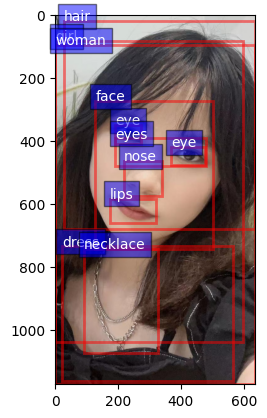

boxes=11


In [19]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

boxes = pred_boxes[keep_boxes]
objects = torch.argmax(scores[keep_boxes][:,1:], dim=1)

# 确保在绘制之前，数据已经被转移到 CPU 上
boxes_cpu = boxes.cpu()
objects_cpu = objects.cpu()

for i in range(len(keep_boxes)):
    kind = objects_cpu[i] + 1
    bbox = boxes_cpu[i, kind * 4: (kind + 1) * 4].numpy()  # 现在将其转换为 NumPy 数组
    print(bbox)
    # 适当的修改，确保其他数据也在 CPU 上并转换为 NumPy 数组
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects_cpu[i] + 1]
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                   '%s' % (cls),
                   bbox=dict(facecolor='blue', alpha=0.5),
                   fontsize=10, color='white')
plt.show()
print('boxes=%d' % (len(keep_boxes)))

In [20]:
print(objects.shape)
print(boxes.shape)
# Assuming objects_cpu is a PyTorch tensor
objects_cpu_np = objects_cpu.numpy()
class_names = [classes[idx+1] for idx in objects_cpu_np]

print(class_names)





torch.Size([11])
torch.Size([11, 6404])
['hair', 'girl', 'dress', 'woman', 'lips', 'necklace', 'nose', 'eye', 'eye', 'face', 'eyes']


In [21]:
def detect(
    model,
    raw_img,
    classes,
    device=torch.device("cuda"),
    thresh=0.05
):
    # initilize the tensor holder here.
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)
    # make variable
    with torch.no_grad():
        im_data = Variable(im_data)
        im_info = Variable(im_info)
        num_boxes = Variable(num_boxes)
        gt_boxes = Variable(gt_boxes)


    im_in = np.array(raw_img).squeeze().transpose((1, 2, 0))
    if len(im_in.shape) == 2:
        im_in = im_in[:, :, np.newaxis]
        im_in = np.concatenate((im_in, im_in, im_in), axis=2)
    # rgb -> bgr
    im = im_in[:, :, ::-1]
    blobs, im_scales = _get_image_blob(im)
    assert len(im_scales) == 1, "Only single-image batch implemented"
    im_blob = blobs
    im_info_np = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32
    )

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    # 确保所有输入数据都转移到了正确的设备
    im_data = im_data.to(device)
    im_info = im_info.to(device)
    gt_boxes = gt_boxes.to(device)
    num_boxes = num_boxes.to(device)
    with torch.no_grad():
        im_data.resize_(im_data_pt.size()).copy_(im_data_pt)
        im_info.resize_(im_info_pt.size()).copy_(im_info_pt)
        gt_boxes.resize_(1, 1, 5).zero_()
        num_boxes.resize_(1).zero_()

    rois, cls_prob, bbox_pred, \
    rpn_loss_cls, rpn_loss_box, \
    RCNN_loss_cls, RCNN_loss_bbox, \
    rois_label = model(im_data, im_info, gt_boxes, num_boxes)

    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]

    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred.data
        if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
            # Optionally normalize targets by a precomputed mean and stdev
            if args.class_agnostic:
                if args.cuda > 0:
                    box_deltas = (
                        box_deltas.view(-1, 4)
                        * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda()
                        + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                    )
                else:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(
                        cfg.TRAIN.BBOX_NORMALIZE_STDS
                    ) + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)

                box_deltas = box_deltas.view(1, -1, 4)
            else:
                if args.cuda > 0:
                    box_deltas = (
                        box_deltas.view(-1, 4)
                        * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda()
                        + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                    )
                else:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(
                        cfg.TRAIN.BBOX_NORMALIZE_STDS
                    ) + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)
                box_deltas = box_deltas.view(1, -1, 4 * len(classes))

        pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
        pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))

    pred_boxes /= im_scales[0]

    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()

    max_conf = torch.zeros((pred_boxes.shape[0]))
    if args.cuda > 0:
        max_conf = max_conf.cuda()
    for j in xrange(1, len(classes)):
        inds = torch.nonzero(scores[:, j] > thresh).view(-1)
        # if there is det
        if inds.numel() > 0:
            cls_scores = scores[:, j][inds]
            _, order = torch.sort(cls_scores, 0, True)
            if args.class_agnostic:
                cls_boxes = pred_boxes[inds, :]
            else:
                cls_boxes = pred_boxes[inds][:, j * 4 : (j + 1) * 4]

            cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
            # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
            cls_dets = cls_dets[order]
            # keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
            keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
            cls_dets = cls_dets[keep.view(-1).long()]
            index = inds[order[keep]]
            max_conf[index] = torch.where(
                scores[index, j] > max_conf[index], scores[index, j], max_conf[index]
            )
    keep_boxes = torch.where(max_conf >= conf_thresh, max_conf, torch.tensor(0.0))
    keep_boxes = torch.squeeze(torch.nonzero(keep_boxes))

    # 使用 numel() 获取张量中的元素数量
    num_boxes = keep_boxes.numel()

    if num_boxes < MIN_BOXES:
        keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
    elif num_boxes > MAX_BOXES:
        keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

    res = []
    boxes = pred_boxes[keep_boxes]
    objects = torch.argmax(scores[keep_boxes][:, 1:], dim=1)
    boxes_cpu = boxes.cpu()
    objects_cpu = objects.cpu()
    for i in range(len(keep_boxes)):
        kind = objects_cpu[i] + 1
        bbox = boxes_cpu[i, kind * 4 : (kind + 1) * 4].numpy()  # 现在将其转换为 NumPy 数组
        # 适当的修改，确保其他数据也在 CPU 上并转换为 NumPy 数组
        if bbox[0] == 0:
            bbox[0] = 1
        if bbox[1] == 0:
            bbox[1] = 1
        cls = classes[objects_cpu[i] + 1]

        temp = dict()
        temp["cls"] = cls
        temp["bbox"] = bbox
        res.append(temp)
    return res

In [22]:
res=detect(model=fasterRCNN,raw_img=raw_img,classes=classes)

In [23]:
print(res)

[{'cls': 'hair', 'bbox': array([ 28.011086,  18.88464 , 635.13403 , 680.5147  ], dtype=float32)}, {'cls': 'girl', 'bbox': array([1.0000000e+00, 8.3078842e+01, 5.9706036e+02, 1.0396740e+03],
      dtype=float32)}, {'cls': 'dress', 'bbox': array([  22.220623,  735.241   ,  565.38824 , 1162.6505  ], dtype=float32)}, {'cls': 'woman', 'bbox': array([1.0000000e+00, 9.5093216e+01, 6.3513403e+02, 1.1728260e+03],
      dtype=float32)}, {'cls': 'lips', 'bbox': array([174.81824, 583.44116, 319.72675, 661.2337 ], dtype=float32)}, {'cls': 'necklace', 'bbox': array([  92.715034,  743.3677  ,  327.9759  , 1073.1906  ], dtype=float32)}, {'cls': 'nose', 'bbox': array([219.36539, 464.0922 , 341.11716, 576.652  ], dtype=float32)}, {'cls': 'eye', 'bbox': array([369.59   , 419.19217, 477.99332, 478.13245], dtype=float32)}, {'cls': 'eye', 'bbox': array([191.74785, 350.5739 , 273.00638, 409.3697 ], dtype=float32)}, {'cls': 'face', 'bbox': array([127.7031, 273.3382, 501.5212, 742.9726], dtype=float32)}, {'cls